In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight


Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/'
    
    
    
    pa_adr = p + 'ADR_cropped/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_cropped/'
    
    pa_dmso = p + 'DMSO_cropped/'
    
    image_list = []
    
    
       


    for filename in sorted(path_data, key=natural_keys): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename)

            imarray = np.array(im)
            imarray = imarray.astype('float32')
            image_list.append(imarray)
        
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename)

            imarray = np.array(im)
            imarray = imarray.astype('float32')
            image_list.append(imarray)
            
        if 'dmso' in filename:
            
            im=cv2.imread(pa_dmso + filename)

            imarray = np.array(im)
            imarray = imarray.astype('float32')
            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))

    return x_orig

In [7]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [8]:
def loadImages_LSTM(path_data,len_t_points):
    

    feat_list = []


    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        feat_list.append(np.load(filename))

    x_orig = np.reshape(feat_list, (len(feat_list),len_t_points, 64))

    return x_orig 

In [9]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [10]:
def make_labels_LSTM(data_set):
    fe = return_count_LSTM(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [11]:
def return_count_LSTM(x):
    name_wel = []
    for _,_,i in os.walk(x):
        for f in i:
            name_wel.append(f.split('_')[2])

    z = sorted(list(set(name_wel)), key=natural_keys)
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(name_wel, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [12]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
        
            
        if y[ix][0] == 'dmso':
            
            labels.append([[y[ix][0],2]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [13]:
def time_step_acc(tes_data, x):

    results = []            

    x_test = loadImages(tes_data)
    y_test = make_labels(tes_data)
    
    y_test_1 = keras.utils.to_categorical(y_test,num_classes=3)
    
    x_test = resize(x_test)
    x_test = preprocess_input(x_test)

    scores = x.evaluate(x_test, y_test_1, verbose = 1)
    results.append(scores[1]*100)
    
    test_preds = m4.predict(x_test)

    preds_df = pd.DataFrame(test_preds)
    predicted_labels = preds_df.idxmax(axis=1)
    draw_confusion_matrix(y_test, predicted_labels)

    return results

In [14]:
def cv_mean_acc(result_cv, string_well):
    
    l_drug = string_well*3

    acc_mean_cv = []

    for i in result_cv:
        acc_mean_cv.append(np.mean(i))
        
    cv_drug = list(zip(acc_mean_cv, l_drug))
    
    res = sorted(cv_drug, key = lambda x: x[1])
    a , b = zip(*res)
    
    a = list(a)
    
    s = list(np.array_split(a, len(string_well)))
    
    cv_score_acc = []
    
    for ix, i in enumerate(s):
        s1 = list(s[ix])
        
        cv_score_acc.append(np.mean(s1))
        
    return list(zip(cv_score_acc, string_well))

In [15]:
# DATA FOR LSTM PART

p_feat = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/'
train_data = p_feat + 'features_train/*.npy'
val_data = p_feat + 'features_validation/*.npy'
tes_data= p_feat + 'features_test/*.npy'

y_tra_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_train/'
y_tes_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_test/'
y_val_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_validation/'

In [16]:
met = ['F10']
mid = ['D5']
oxy = ['F6']
nap = ['B3']
dip = ['F2']
met_1 = ['B7']
lab = ['D10']
car = ['G2']
mep = ['B11']
nef = ['C10']
tri = ['B2']
dox = ['F8']


cycl = ['C4']
dime =  ['F7']
cypr  = ['G9']
lora = [ 'E5']
doxy = ['D4']
oloa = ['E2']
hydr = ['F5']
orph = ['E7']
cinn = ['B10']
desl = ['F3']
chlo =  ['D2']
trim = ['E9']
mian= ['E8']
fexo= ['B5']
chlo_1 = ['E3']
trip= ['C5']
desi= ['E4']
levo= ['C3']
diphe_1= ['C7']
diphe_2= ['F11']
emed= ['G6']
ceti= ['D11']
trip_1= ['F9']
doxe=['C2']
chlo_2= ['D6']
flun = ['C9']
keto= ['D7']

tot_well_adr = [met,mid,oxy]
tot_well_hrh = [cycl, dime, cypr]

string_well_adr = ['met', 'mid', 'oxy']
string_well_hrh = ['cycl', 'dime', 'cypr']


In [17]:
tot_results_accuracy = []

results_lstm = []

In [18]:
tot_well_adr = [met,mid,oxy,nap,dip,met_1,lab,car,mep,nef,tri,dox]
tot_well_hrh = [cycl, dime, cypr,lora,doxy,oloa,cinn,desl,chlo,trim,mian,fexo,chlo_1,trip,desi,levo,
                
                diphe_1,diphe_2,emed,ceti,trip_1,doxe,chlo_2,flun,keto]

string_well_adr = ['met', 'mid', 'oxy', 'nap', 'dip','met_1','lab','car','mep','nef','tri','dox']
string_well_hrh = ['cycl', 'dime', 'cypr', 'lora', 'doxy','oloa','cinn','desl','chlo','trim','mian','fexo','chlo_1','trip','desi',
                   'levo','diphe_1','diphe_2','emed','ceti','trip_1','doxe','chlo_2','flun','keto']


In [19]:
tot_well = []
string_well = [] 

In [20]:
a = 'ADR' # FOR TEST SET
b = 'HRH' # FOR REST
c = 'DMSO'

if a == 'HRH':
    tot_well = tot_well_hrh
    string_well = string_well_hrh
    
if a == 'ADR':
    tot_well = tot_well_adr
    string_well = string_well_adr
    

In [21]:
rand = list(np.random.randint(1,1000,3))

0it [00:00, ?it/s]
100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 75 steps
Epoch 1/300
284/284 [==============================] - 36s 126ms/step - loss: 1.4473 - accuracy: 0.4068 - val_loss: 1.2350 - val_accuracy: 0.3586
Epoch 2/300
284/284 [==============================] - 30s 105ms/step - loss: 1.0555 - accuracy: 0.4655 - val_loss: 1.1857 - val_accuracy: 0.3403
Epoch 3/300
284/284 [==============================] - 30s 106ms/step - loss: 0.9988 - accuracy: 0.4868 - val_loss: 1.2273 - val_accuracy: 0.3663
Epoch 4/300
284/284 [==============================] - 29s 101ms/step - loss: 0.9749 - accuracy: 0.5059 - val_loss: 1.2602 - val_accuracy: 0.3813
Epoch 5/300
284/284 [==============================] - 29s 101ms/step - loss: 0.9598 - accuracy: 0.5193 - val_loss: 1.2927 - val_accuracy: 0.4067
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 75 steps
Epoch 1/300
284/284 [=

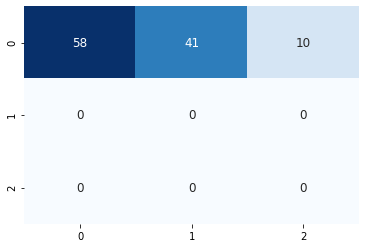

107/107 [==============================] - 0s 934us/sample - loss: 1.1788 - accuracy: 0.5794


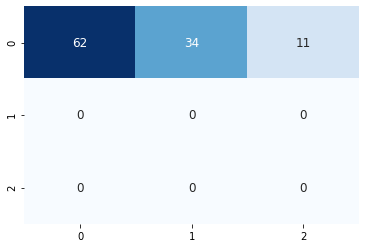

103/103 [==============================] - 0s 970us/sample - loss: 1.0958 - accuracy: 0.5631


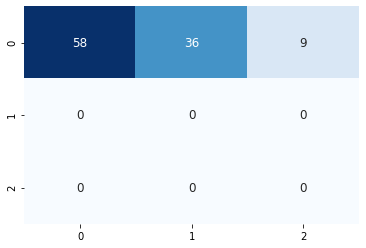

99/99 [==============================] - 0s 871us/sample - loss: 1.1367 - accuracy: 0.5657


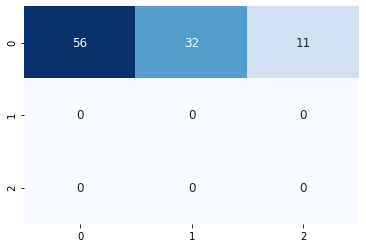

99/99 [==============================] - 0s 254us/sample - loss: 1.1090 - accuracy: 0.5556


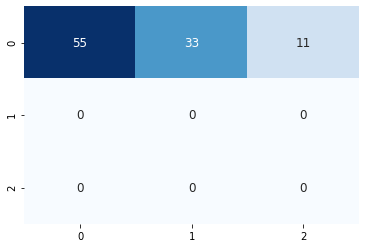

99/99 [==============================] - 0s 251us/sample - loss: 1.0568 - accuracy: 0.5556


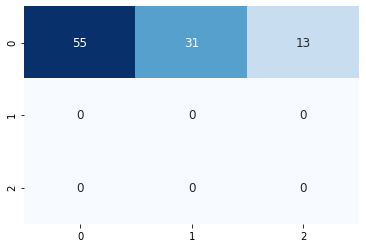

99/99 [==============================] - 0s 277us/sample - loss: 1.0255 - accuracy: 0.5455


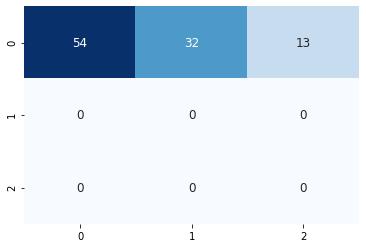

98/98 [==============================] - 0s 918us/sample - loss: 0.9372 - accuracy: 0.5816


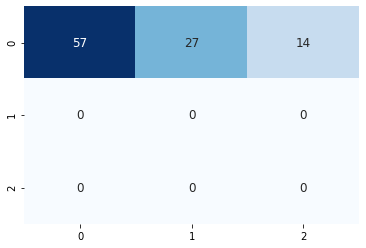

98/98 [==============================] - 0s 295us/sample - loss: 0.8748 - accuracy: 0.6531


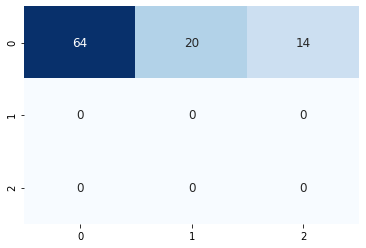

97/97 [==============================] - 0s 864us/sample - loss: 0.9525 - accuracy: 0.6082


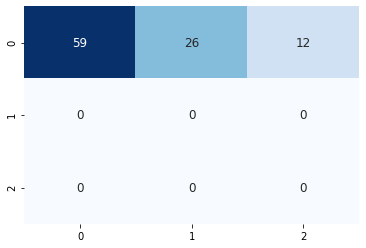

97/97 [==============================] - 0s 261us/sample - loss: 1.0269 - accuracy: 0.5876


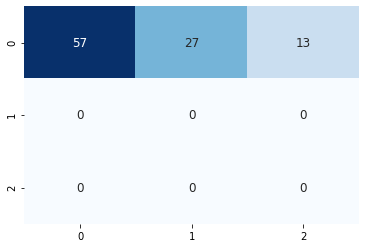

97/97 [==============================] - 0s 283us/sample - loss: 1.0263 - accuracy: 0.6289


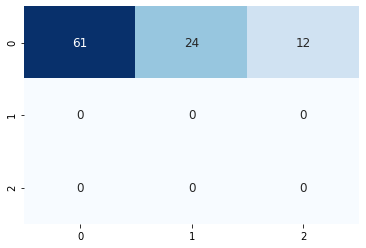

96/96 [==============================] - 0s 3ms/sample - loss: 1.0704 - accuracy: 0.5312


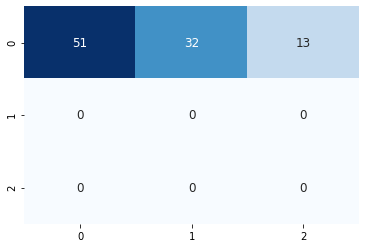

97/97 [==============================] - 0s 245us/sample - loss: 0.9825 - accuracy: 0.5979


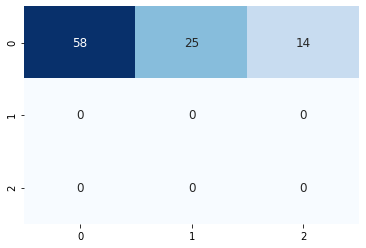

95/95 [==============================] - 0s 1ms/sample - loss: 1.1164 - accuracy: 0.5474


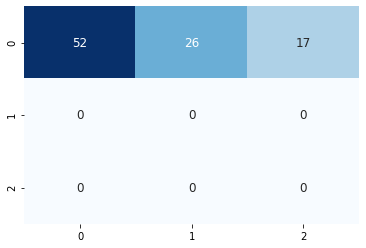

95/95 [==============================] - 0s 256us/sample - loss: 1.1664 - accuracy: 0.5368


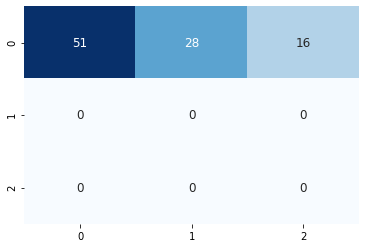

94/94 [==============================] - 0s 1ms/sample - loss: 1.0983 - accuracy: 0.5532


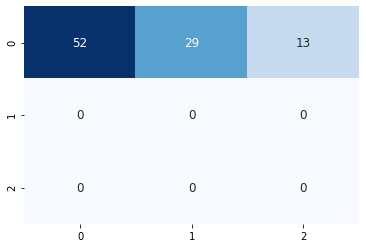

95/95 [==============================] - 0s 257us/sample - loss: 1.0343 - accuracy: 0.6421


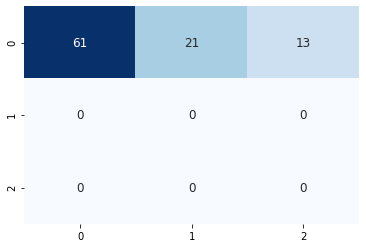

93/93 [==============================] - 0s 2ms/sample - loss: 1.0428 - accuracy: 0.6129


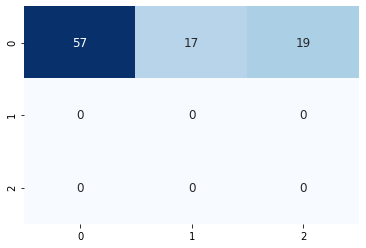

93/93 [==============================] - 0s 264us/sample - loss: 1.0762 - accuracy: 0.5806


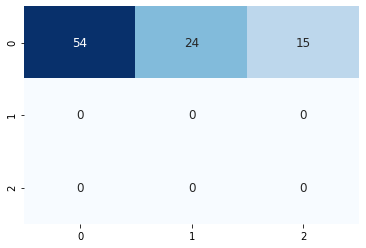

93/93 [==============================] - 0s 251us/sample - loss: 1.0780 - accuracy: 0.5161


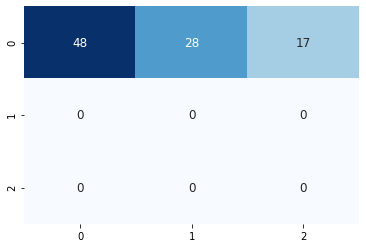

92/92 [==============================] - 0s 1ms/sample - loss: 1.0184 - accuracy: 0.5761


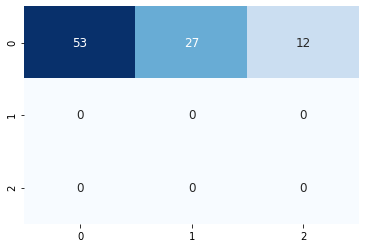

91/91 [==============================] - 0s 1ms/sample - loss: 1.0240 - accuracy: 0.5934


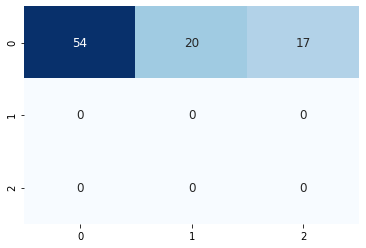

90/90 [==============================] - 0s 1ms/sample - loss: 1.0523 - accuracy: 0.5444


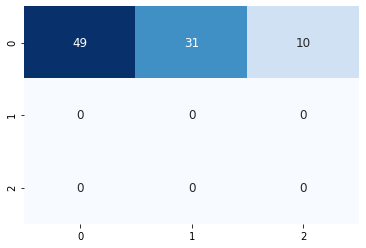

90/90 [==============================] - 0s 265us/sample - loss: 0.9189 - accuracy: 0.6667


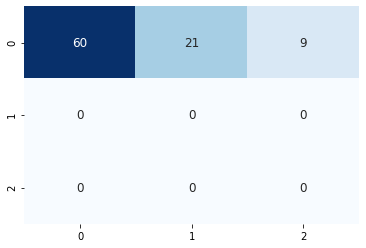

91/91 [==============================] - 0s 271us/sample - loss: 1.0062 - accuracy: 0.6154


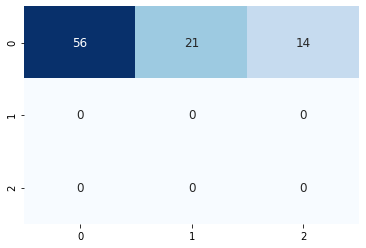

91/91 [==============================] - 0s 243us/sample - loss: 0.9819 - accuracy: 0.5714


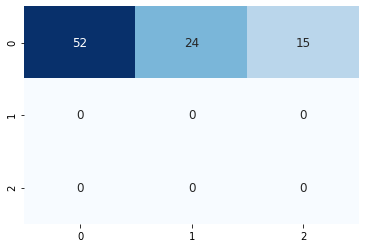

89/89 [==============================] - 0s 1ms/sample - loss: 0.9009 - accuracy: 0.6742


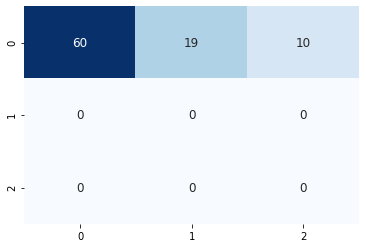

89/89 [==============================] - 0s 242us/sample - loss: 0.9641 - accuracy: 0.6854


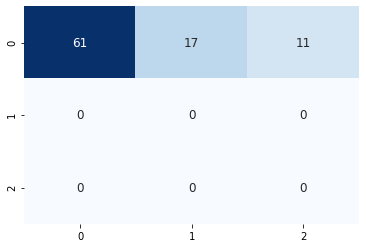

88/88 [==============================] - 0s 1ms/sample - loss: 0.9681 - accuracy: 0.6364


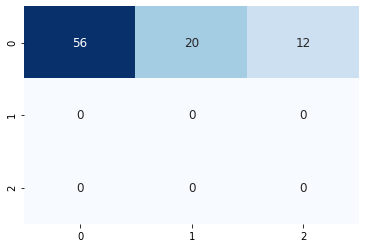

86/86 [==============================] - 0s 1ms/sample - loss: 0.9791 - accuracy: 0.6744


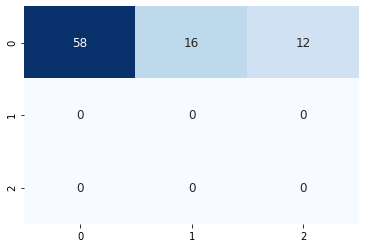

86/86 [==============================] - 0s 252us/sample - loss: 0.9470 - accuracy: 0.6628


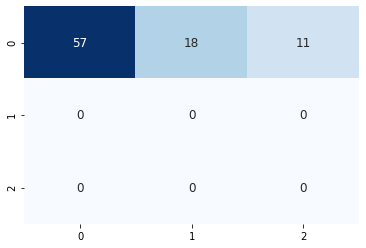

86/86 [==============================] - 0s 328us/sample - loss: 0.9826 - accuracy: 0.5930


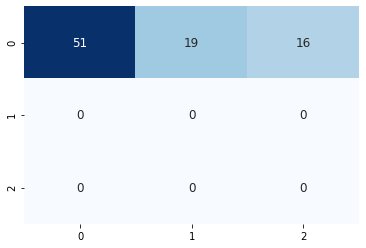

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3893 samples, validate on 1014 samples
Epoch 1/300
3893/3893 [==============================] - 3s 748us/sample - loss: 0.9828 - accuracy: 0.4906 - val_loss: 1.1093 - val_accuracy: 0.4290
Epoch 2/300
3893/3893 [==============================] - 1s 237us/sample - loss: 0.7254 - accuracy: 0.6830 - val_loss: 1.1544 - val_accuracy: 0.4694
Epoch 3/300
3893/3893 [==============================] - 1s 220us/sample - loss: 0.5484 - accuracy: 0.7660 - val_loss: 1.2808 - val_accuracy: 0.4961
Epoch 4/300
3893/3893 [==============================] - 1s 214us/sample - loss: 0.4250 - accuracy: 0.8261 - val_loss: 1.4380 - val_accuracy: 0.4931
Epoch 00004: early stopping
82/82 [==============================] - 0s 5ms/sample - loss: 0.7499 - accuracy: 0.6707


1it [24:05, 1445.46s/it]
100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 282 steps, validate for 74 steps
Epoch 1/300
282/282 [==============================] - 29s 105ms/step - loss: 1.4847 - accuracy: 0.4239 - val_loss: 1.2449 - val_accuracy: 0.3571
Epoch 2/300
282/282 [==============================] - 28s 99ms/step - loss: 1.0586 - accuracy: 0.4767 - val_loss: 1.1774 - val_accuracy: 0.4252
Epoch 3/300
282/282 [==============================] - 28s 98ms/step - loss: 0.9953 - accuracy: 0.5008 - val_loss: 1.2066 - val_accuracy: 0.3843
Epoch 4/300
282/282 [==============================] - 28s 98ms/step - loss: 0.9683 - accuracy: 0.5180 - val_loss: 1.2293 - val_accuracy: 0.4353
Epoch 5/300
282/282 [==============================] - 28s 100ms/step - loss: 0.9513 - accuracy: 0.5289 - val_loss: 1.2773 - val_accuracy: 0.4160
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 282 steps, validate for 74 steps
Epoch 1/300
282/282 [====

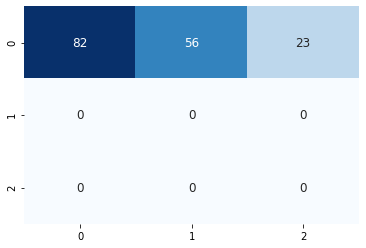

155/155 [==============================] - 0s 219us/sample - loss: 1.0932 - accuracy: 0.5226


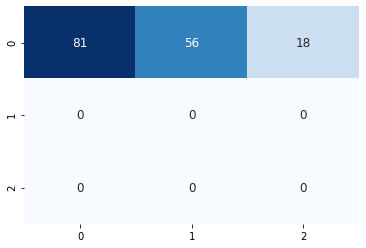

153/153 [==============================] - 0s 212us/sample - loss: 0.9566 - accuracy: 0.5163


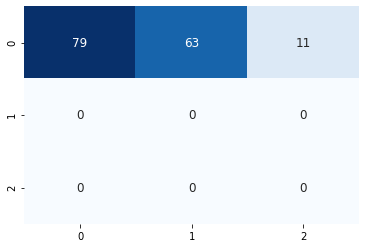

154/154 [==============================] - 0s 214us/sample - loss: 1.1046 - accuracy: 0.5130


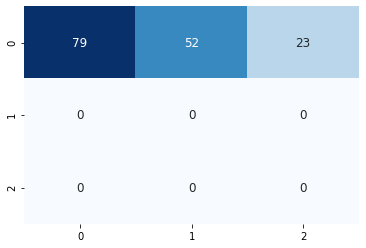

151/151 [==============================] - 0s 848us/sample - loss: 1.0684 - accuracy: 0.5497


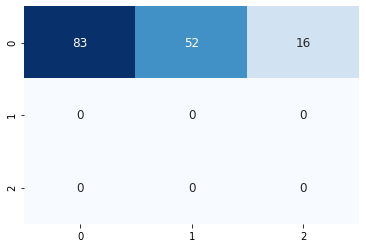

147/147 [==============================] - 0s 840us/sample - loss: 0.9887 - accuracy: 0.5782


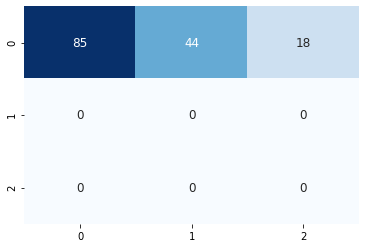

144/144 [==============================] - 0s 806us/sample - loss: 1.0484 - accuracy: 0.5625


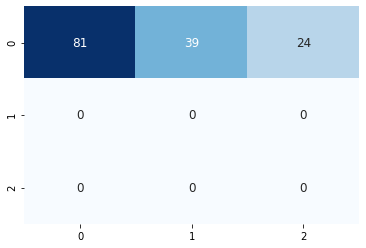

143/143 [==============================] - 0s 804us/sample - loss: 1.0153 - accuracy: 0.6084


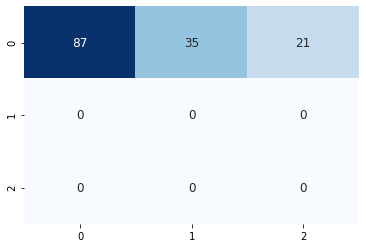

145/145 [==============================] - 0s 814us/sample - loss: 1.0252 - accuracy: 0.5034


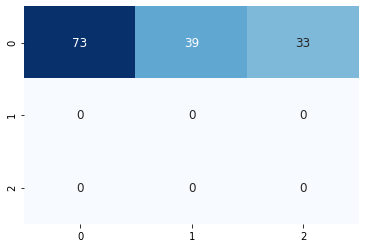

143/143 [==============================] - 0s 229us/sample - loss: 1.1337 - accuracy: 0.5804


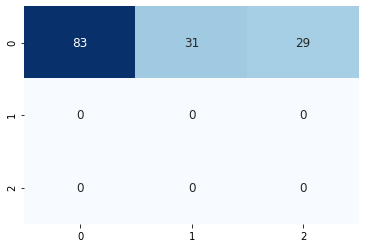

142/142 [==============================] - 0s 772us/sample - loss: 1.1673 - accuracy: 0.5141


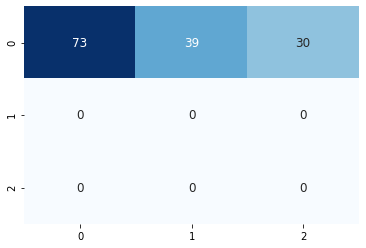

142/142 [==============================] - 0s 226us/sample - loss: 1.1714 - accuracy: 0.5493


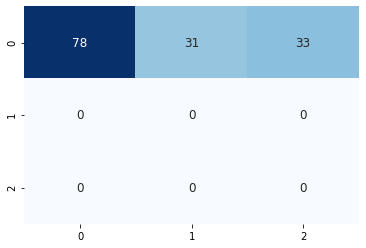

142/142 [==============================] - 0s 228us/sample - loss: 1.2260 - accuracy: 0.4577


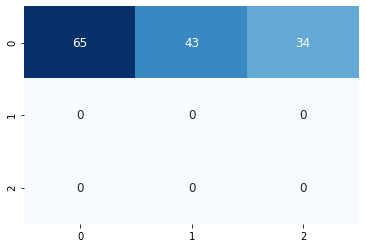

141/141 [==============================] - 0s 249us/sample - loss: 1.1578 - accuracy: 0.5035


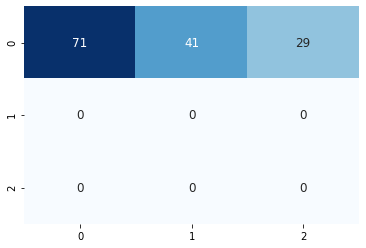

141/141 [==============================] - 0s 237us/sample - loss: 1.0895 - accuracy: 0.5745


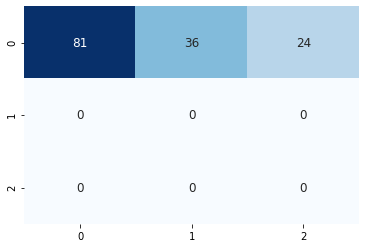

139/139 [==============================] - 0s 209us/sample - loss: 1.0905 - accuracy: 0.5755


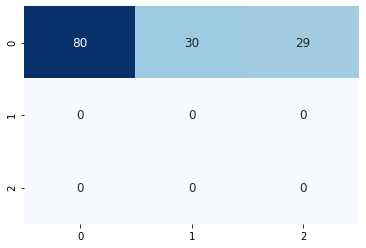

139/139 [==============================] - 0s 230us/sample - loss: 1.1559 - accuracy: 0.5540


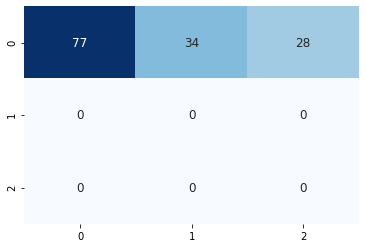

137/137 [==============================] - 0s 849us/sample - loss: 1.1550 - accuracy: 0.5182


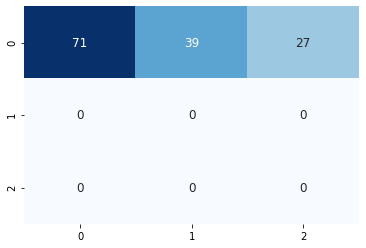

139/139 [==============================] - 0s 298us/sample - loss: 1.1663 - accuracy: 0.4676


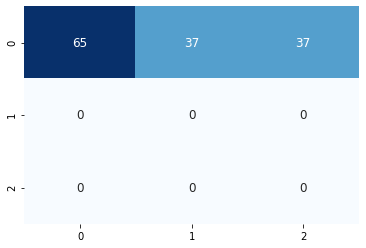

137/137 [==============================] - 0s 241us/sample - loss: 1.1491 - accuracy: 0.5328


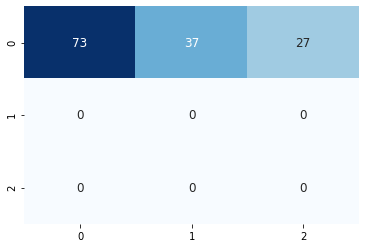

138/138 [==============================] - 0s 929us/sample - loss: 1.1540 - accuracy: 0.5362


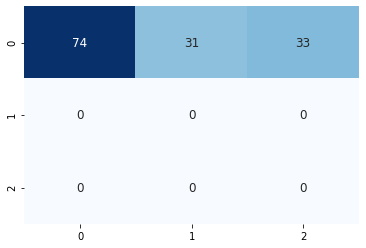

137/137 [==============================] - 0s 261us/sample - loss: 1.1101 - accuracy: 0.5693


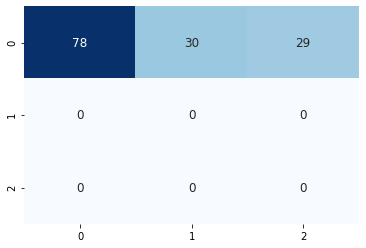

138/138 [==============================] - 0s 262us/sample - loss: 1.2693 - accuracy: 0.5072


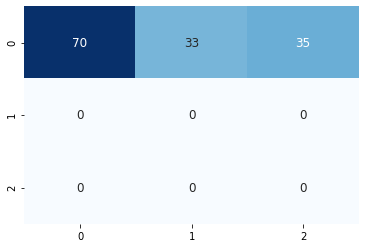

137/137 [==============================] - 0s 266us/sample - loss: 1.1163 - accuracy: 0.5255


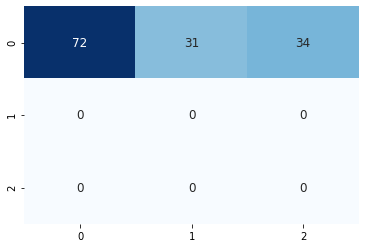

137/137 [==============================] - 0s 250us/sample - loss: 1.2017 - accuracy: 0.5036


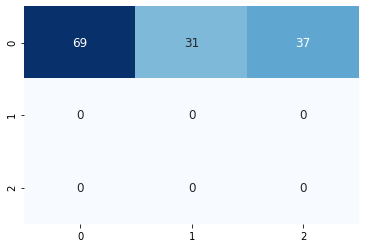

138/138 [==============================] - 0s 250us/sample - loss: 1.2801 - accuracy: 0.5217


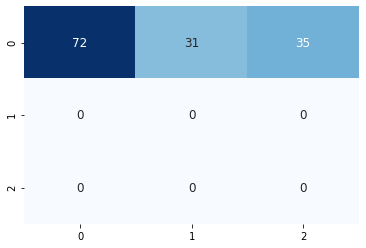

137/137 [==============================] - 0s 259us/sample - loss: 1.3548 - accuracy: 0.5182


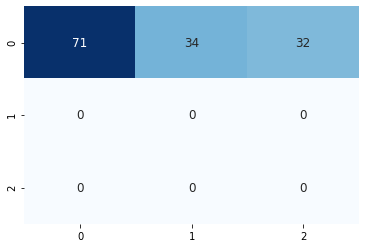

137/137 [==============================] - 0s 287us/sample - loss: 1.2786 - accuracy: 0.5255


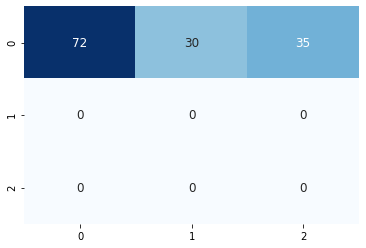

134/134 [==============================] - 0s 851us/sample - loss: 1.2313 - accuracy: 0.5373


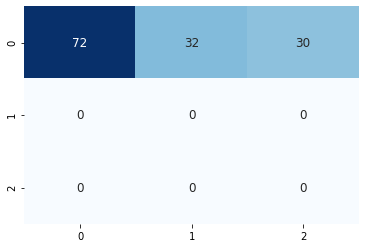

134/134 [==============================] - 0s 343us/sample - loss: 1.2222 - accuracy: 0.5224


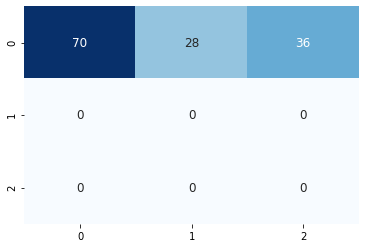

133/133 [==============================] - 0s 816us/sample - loss: 1.2326 - accuracy: 0.5489


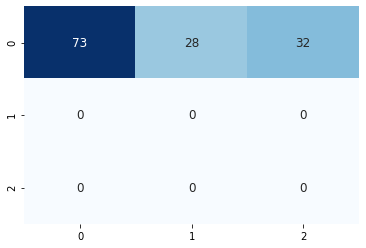

131/131 [==============================] - 0s 266us/sample - loss: 1.1240 - accuracy: 0.5573


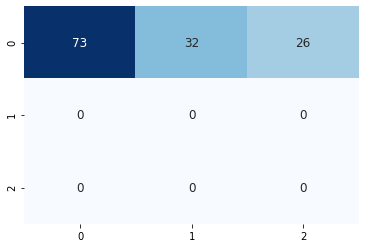

130/130 [==============================] - 0s 257us/sample - loss: 1.1910 - accuracy: 0.5385


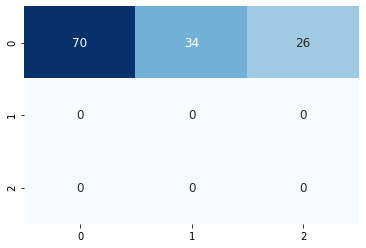

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3863 samples, validate on 1002 samples
Epoch 1/300
3863/3863 [==============================] - 3s 776us/sample - loss: 1.0566 - accuracy: 0.4931 - val_loss: 1.1293 - val_accuracy: 0.4222
Epoch 2/300
3863/3863 [==============================] - 1s 195us/sample - loss: 0.8773 - accuracy: 0.6210 - val_loss: 1.1330 - val_accuracy: 0.4172
Epoch 3/300
3863/3863 [==============================] - 1s 185us/sample - loss: 0.7419 - accuracy: 0.6824 - val_loss: 1.1706 - val_accuracy: 0.4222
Epoch 4/300
3863/3863 [==============================] - 1s 199us/sample - loss: 0.5927 - accuracy: 0.7406 - val_loss: 1.2494 - val_accuracy: 0.4541
Epoch 00004: early stopping
124/124 [==============================] - 0s 3ms/sample - loss: 1.4453 - accuracy: 0.2742


2it [46:48, 1420.68s/it]
100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 74 steps
Epoch 1/300
284/284 [==============================] - 29s 104ms/step - loss: 1.4571 - accuracy: 0.4283 - val_loss: 1.2198 - val_accuracy: 0.4216
Epoch 2/300
284/284 [==============================] - 28s 97ms/step - loss: 1.0557 - accuracy: 0.4781 - val_loss: 1.1592 - val_accuracy: 0.3789
Epoch 3/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9932 - accuracy: 0.5006 - val_loss: 1.2168 - val_accuracy: 0.3895
Epoch 4/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9726 - accuracy: 0.5159 - val_loss: 1.2431 - val_accuracy: 0.3759
Epoch 5/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9524 - accuracy: 0.5278 - val_loss: 1.2989 - val_accuracy: 0.4008
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 74 steps
Epoch 1/300
284/284 [=====

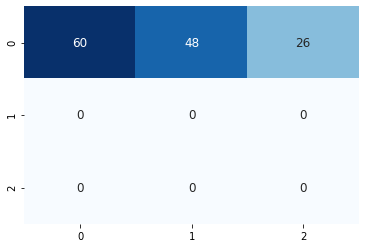

126/126 [==============================] - 0s 229us/sample - loss: 1.0222 - accuracy: 0.5159


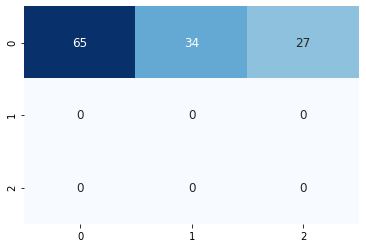

121/121 [==============================] - 0s 232us/sample - loss: 1.1485 - accuracy: 0.5207


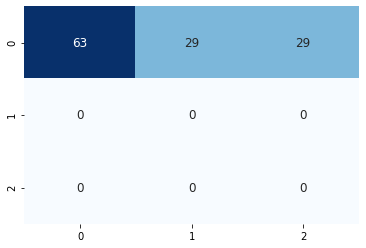

120/120 [==============================] - 0s 231us/sample - loss: 1.0539 - accuracy: 0.5750


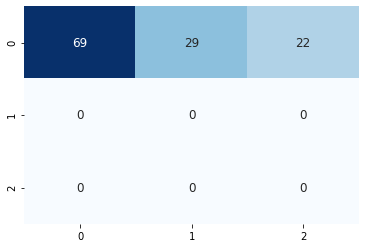

120/120 [==============================] - 0s 383us/sample - loss: 1.1352 - accuracy: 0.5167


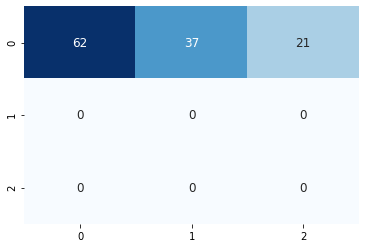

118/118 [==============================] - 0s 242us/sample - loss: 1.1171 - accuracy: 0.5000


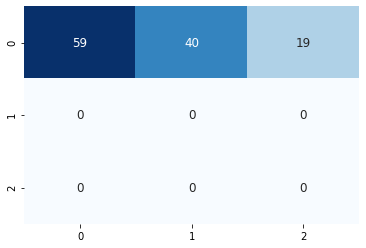

118/118 [==============================] - 0s 247us/sample - loss: 1.0484 - accuracy: 0.5593


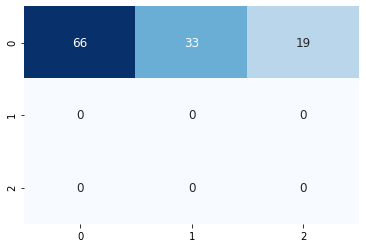

116/116 [==============================] - 0s 1ms/sample - loss: 1.0618 - accuracy: 0.5431


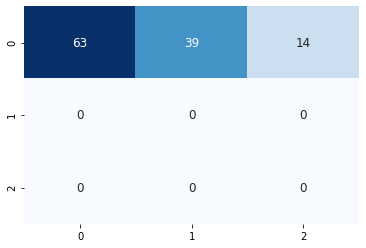

113/113 [==============================] - 0s 300us/sample - loss: 1.0578 - accuracy: 0.5664


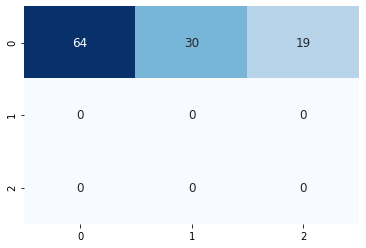

111/111 [==============================] - 0s 263us/sample - loss: 1.0661 - accuracy: 0.5315


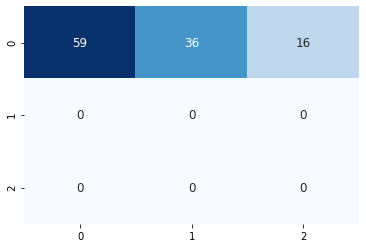

112/112 [==============================] - 0s 284us/sample - loss: 1.0049 - accuracy: 0.5714


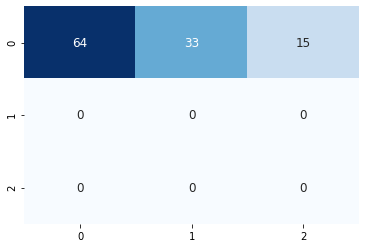

110/110 [==============================] - 0s 298us/sample - loss: 1.0483 - accuracy: 0.5364


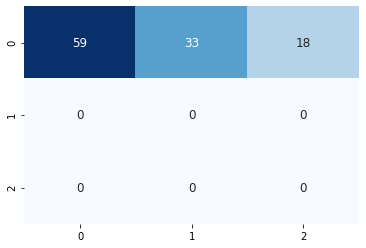

108/108 [==============================] - 0s 1ms/sample - loss: 1.0032 - accuracy: 0.5926


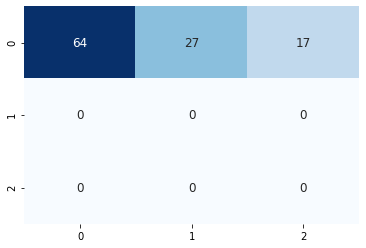

108/108 [==============================] - 0s 268us/sample - loss: 0.9934 - accuracy: 0.5833


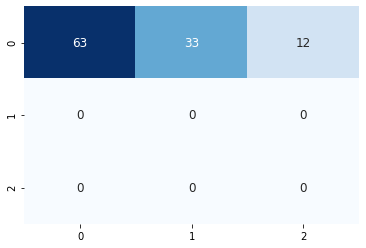

108/108 [==============================] - 0s 281us/sample - loss: 0.9061 - accuracy: 0.6204


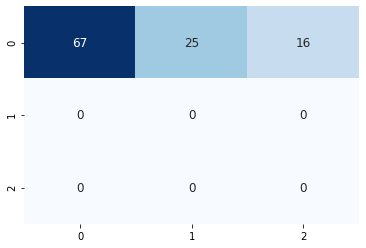

106/106 [==============================] - 0s 249us/sample - loss: 0.9186 - accuracy: 0.6226


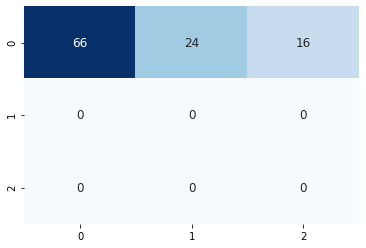

106/106 [==============================] - 0s 273us/sample - loss: 0.8563 - accuracy: 0.6415


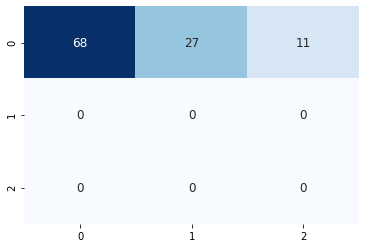

105/105 [==============================] - 0s 264us/sample - loss: 0.8430 - accuracy: 0.5810


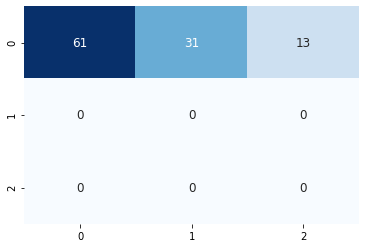

107/107 [==============================] - 0s 295us/sample - loss: 0.8797 - accuracy: 0.5794


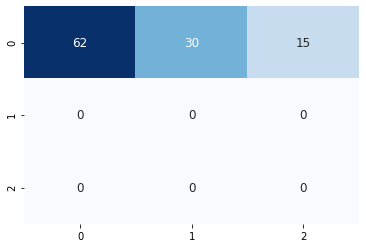

106/106 [==============================] - 0s 277us/sample - loss: 0.8322 - accuracy: 0.6604


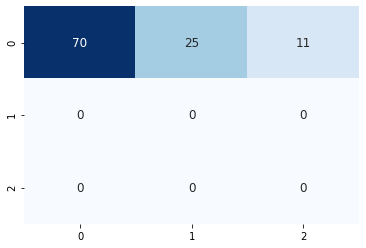

105/105 [==============================] - 0s 274us/sample - loss: 0.7945 - accuracy: 0.6857


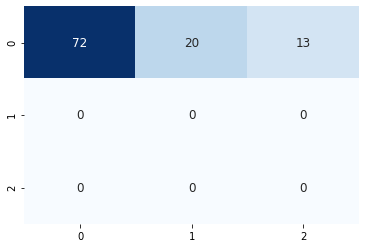

106/106 [==============================] - 0s 261us/sample - loss: 0.9173 - accuracy: 0.6321


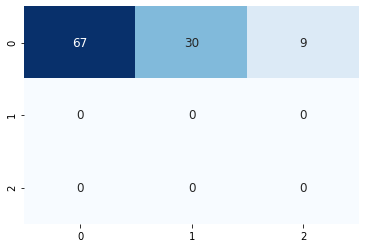

104/104 [==============================] - 0s 969us/sample - loss: 0.9681 - accuracy: 0.6346


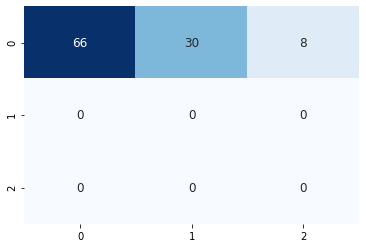

105/105 [==============================] - 0s 244us/sample - loss: 0.9151 - accuracy: 0.6286


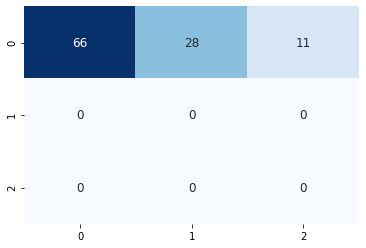

105/105 [==============================] - 0s 250us/sample - loss: 0.8520 - accuracy: 0.6857


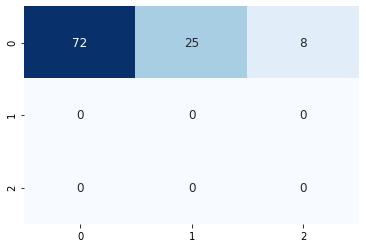

102/102 [==============================] - 0s 250us/sample - loss: 0.9421 - accuracy: 0.6471


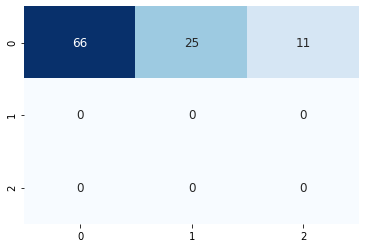

102/102 [==============================] - 0s 261us/sample - loss: 0.7666 - accuracy: 0.6765


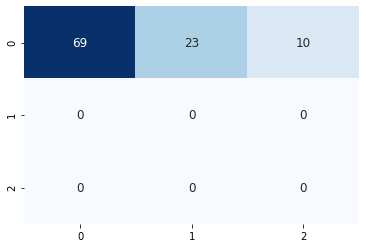

102/102 [==============================] - 0s 249us/sample - loss: 0.8593 - accuracy: 0.7059


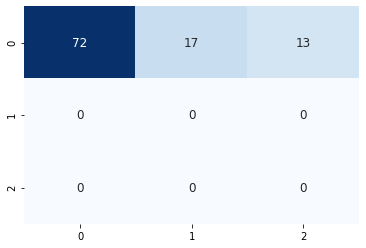

102/102 [==============================] - 0s 247us/sample - loss: 0.9502 - accuracy: 0.6373


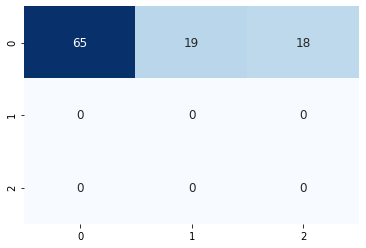

100/100 [==============================] - 0s 968us/sample - loss: 0.8379 - accuracy: 0.6900


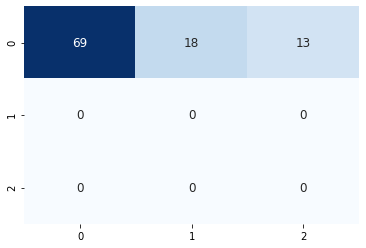

100/100 [==============================] - 0s 259us/sample - loss: 0.9101 - accuracy: 0.6300


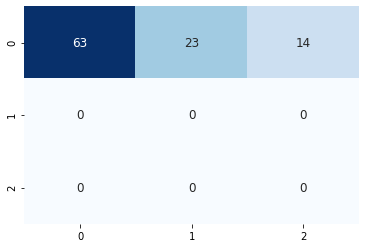

100/100 [==============================] - 0s 252us/sample - loss: 0.8910 - accuracy: 0.6400


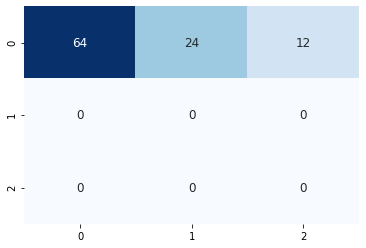

102/102 [==============================] - 0s 241us/sample - loss: 0.8295 - accuracy: 0.7255


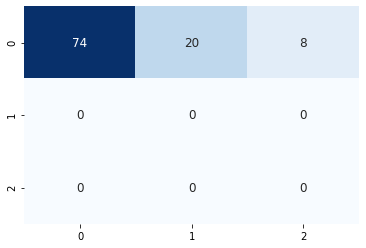

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3888 samples, validate on 1004 samples
Epoch 1/300
3888/3888 [==============================] - 3s 722us/sample - loss: 0.9374 - accuracy: 0.5041 - val_loss: 1.1201 - val_accuracy: 0.4004
Epoch 2/300
3888/3888 [==============================] - 1s 206us/sample - loss: 0.6663 - accuracy: 0.6674 - val_loss: 1.1830 - val_accuracy: 0.4462
Epoch 3/300
3888/3888 [==============================] - 1s 203us/sample - loss: 0.5094 - accuracy: 0.7598 - val_loss: 1.2889 - val_accuracy: 0.4731
Epoch 4/300
3888/3888 [==============================] - 1s 202us/sample - loss: 0.4041 - accuracy: 0.8128 - val_loss: 1.4074 - val_accuracy: 0.4930
Epoch 00004: early stopping
97/97 [==============================] - 0s 4ms/sample - loss: 1.1998 - accuracy: 0.3814


3it [1:10:23, 1419.17s/it]
100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 74 steps
Epoch 1/300
283/283 [==============================] - 30s 105ms/step - loss: 1.4453 - accuracy: 0.4290 - val_loss: 1.2105 - val_accuracy: 0.3949
Epoch 2/300
283/283 [==============================] - 28s 98ms/step - loss: 1.0503 - accuracy: 0.4799 - val_loss: 1.1577 - val_accuracy: 0.4113
Epoch 3/300
283/283 [==============================] - 28s 99ms/step - loss: 0.9942 - accuracy: 0.5029 - val_loss: 1.1739 - val_accuracy: 0.4010
Epoch 4/300
283/283 [==============================] - 28s 99ms/step - loss: 0.9669 - accuracy: 0.5205 - val_loss: 1.1977 - val_accuracy: 0.3845
Epoch 5/300
283/283 [==============================] - 28s 99ms/step - loss: 0.9518 - accuracy: 0.5329 - val_loss: 1.2270 - val_accuracy: 0.4359
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 74 steps
Epoch 1/300
283/283 [=====

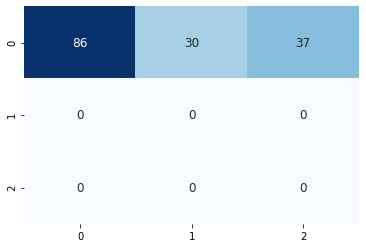

148/148 [==============================] - 0s 225us/sample - loss: 1.2937 - accuracy: 0.4865


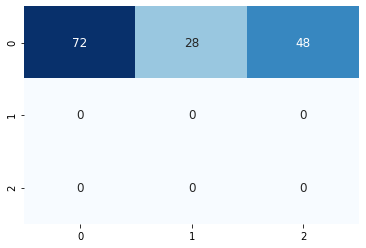

144/144 [==============================] - 0s 261us/sample - loss: 1.3086 - accuracy: 0.5000


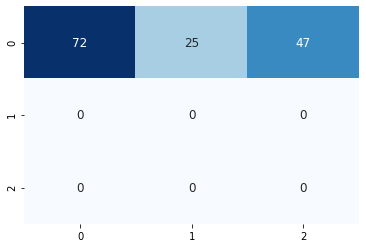

143/143 [==============================] - 0s 235us/sample - loss: 1.4267 - accuracy: 0.4825


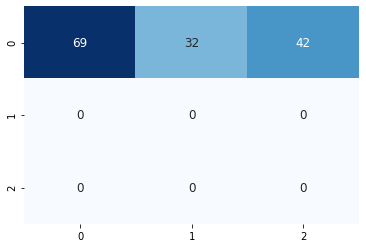

144/144 [==============================] - 0s 231us/sample - loss: 1.2041 - accuracy: 0.5486


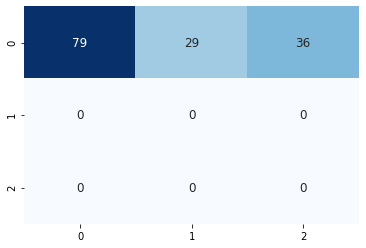

141/141 [==============================] - 0s 266us/sample - loss: 1.1834 - accuracy: 0.5603


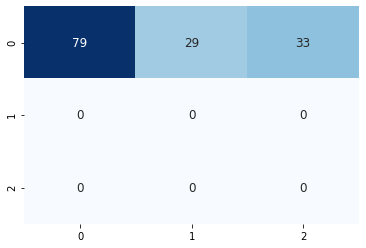

141/141 [==============================] - 0s 262us/sample - loss: 1.2870 - accuracy: 0.5177


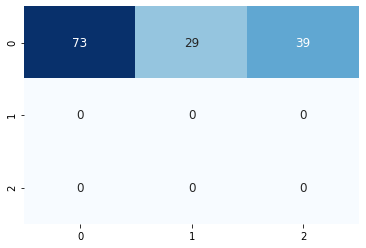

140/140 [==============================] - 0s 271us/sample - loss: 1.3230 - accuracy: 0.5071


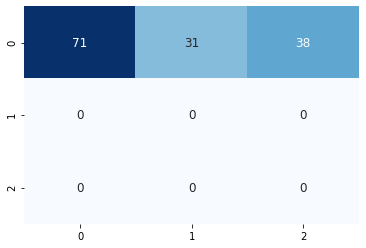

138/138 [==============================] - 0s 269us/sample - loss: 1.5677 - accuracy: 0.3841


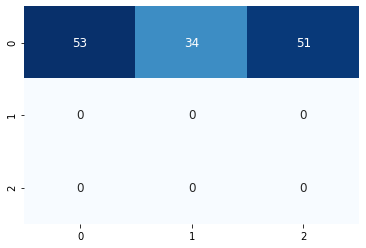

136/136 [==============================] - 0s 276us/sample - loss: 1.6994 - accuracy: 0.3529


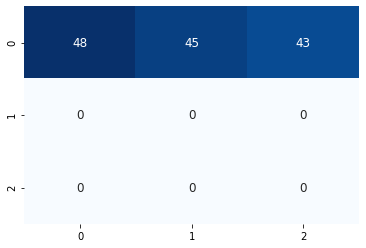

138/138 [==============================] - 0s 279us/sample - loss: 1.6021 - accuracy: 0.3768


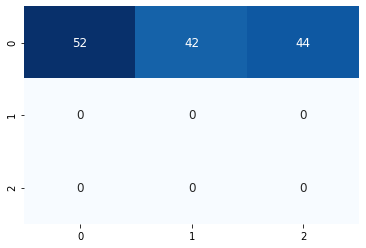

137/137 [==============================] - 0s 267us/sample - loss: 1.7095 - accuracy: 0.3212


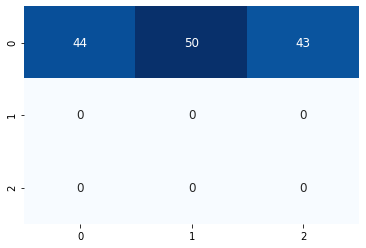

135/135 [==============================] - 0s 256us/sample - loss: 1.6063 - accuracy: 0.4074


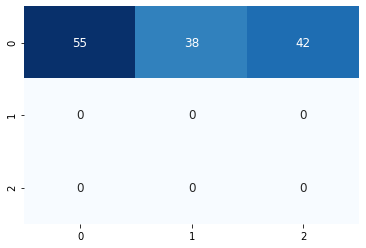

140/140 [==============================] - 0s 250us/sample - loss: 1.9125 - accuracy: 0.3000


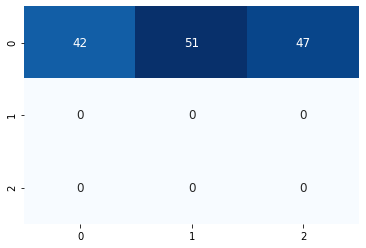

135/135 [==============================] - 0s 268us/sample - loss: 1.8384 - accuracy: 0.3481


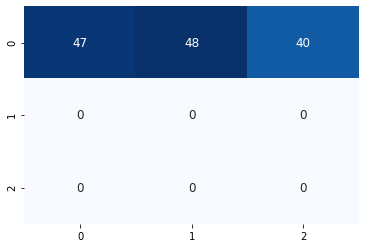

134/134 [==============================] - 0s 280us/sample - loss: 1.9248 - accuracy: 0.3284


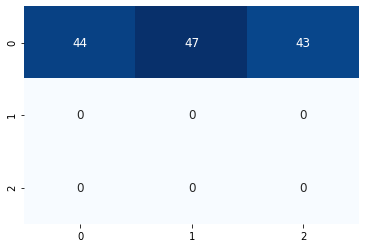

133/133 [==============================] - 0s 251us/sample - loss: 2.2224 - accuracy: 0.2857


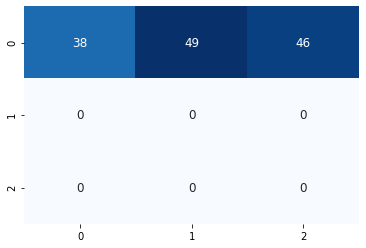

133/133 [==============================] - 0s 260us/sample - loss: 2.2181 - accuracy: 0.3083


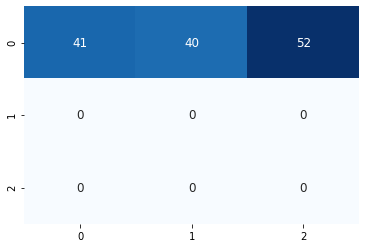

133/133 [==============================] - 0s 284us/sample - loss: 2.2265 - accuracy: 0.2932


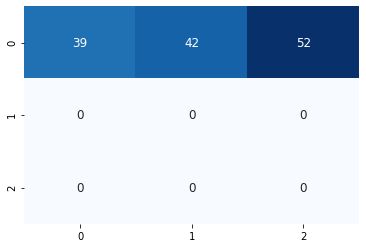

131/131 [==============================] - 0s 282us/sample - loss: 2.2994 - accuracy: 0.2901


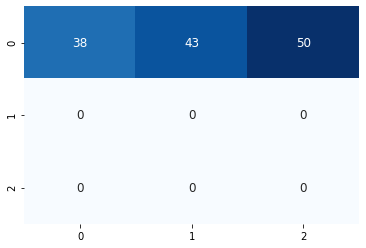

131/131 [==============================] - 0s 308us/sample - loss: 2.1112 - accuracy: 0.3130


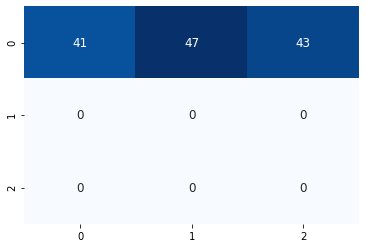

131/131 [==============================] - 0s 285us/sample - loss: 2.0708 - accuracy: 0.2595


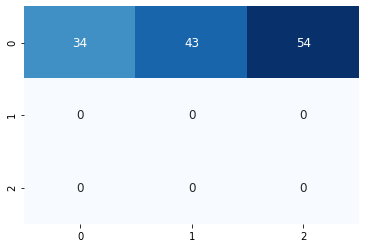

129/129 [==============================] - 0s 280us/sample - loss: 2.1943 - accuracy: 0.2636


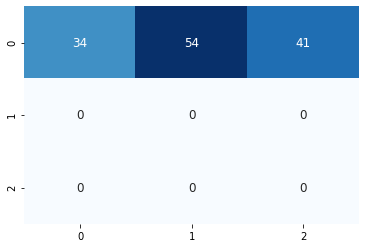

128/128 [==============================] - 0s 2ms/sample - loss: 2.1537 - accuracy: 0.3203


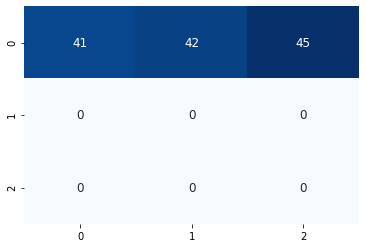

129/129 [==============================] - 0s 281us/sample - loss: 2.1306 - accuracy: 0.3256


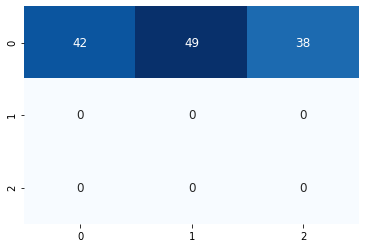

129/129 [==============================] - 0s 256us/sample - loss: 2.2987 - accuracy: 0.2093


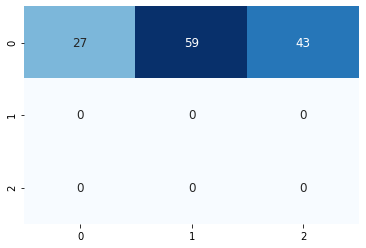

129/129 [==============================] - 0s 297us/sample - loss: 2.2226 - accuracy: 0.2171


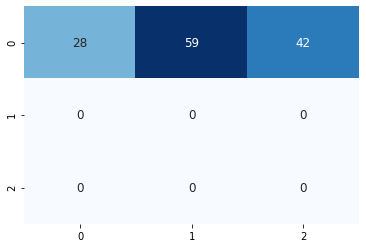

128/128 [==============================] - 0s 216us/sample - loss: 2.1875 - accuracy: 0.2812


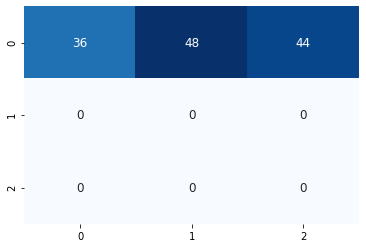

128/128 [==============================] - 0s 230us/sample - loss: 2.1696 - accuracy: 0.2734


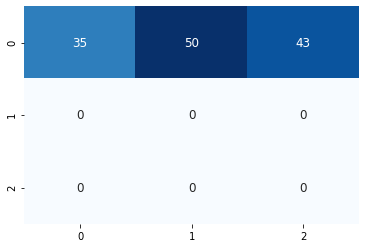

127/127 [==============================] - 0s 269us/sample - loss: 2.2131 - accuracy: 0.2047


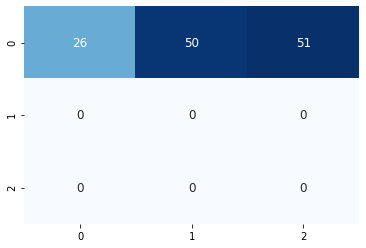

127/127 [==============================] - 0s 266us/sample - loss: 2.1708 - accuracy: 0.2598


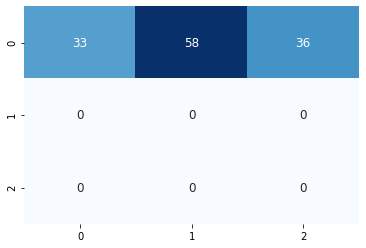

127/127 [==============================] - 0s 308us/sample - loss: 2.1829 - accuracy: 0.2598


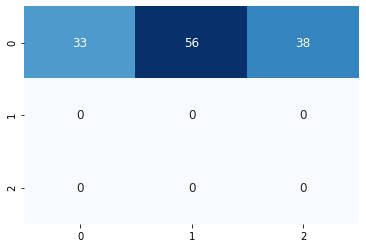

127/127 [==============================] - 0s 239us/sample - loss: 2.2817 - accuracy: 0.2362


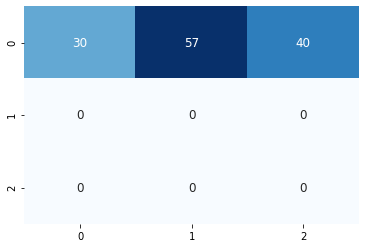

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3863 samples, validate on 1003 samples
Epoch 1/300
3863/3863 [==============================] - 3s 710us/sample - loss: 0.9333 - accuracy: 0.4973 - val_loss: 1.1287 - val_accuracy: 0.3739
Epoch 2/300
3863/3863 [==============================] - 1s 197us/sample - loss: 0.6774 - accuracy: 0.6386 - val_loss: 1.2168 - val_accuracy: 0.4058
Epoch 3/300
3863/3863 [==============================] - 1s 199us/sample - loss: 0.5214 - accuracy: 0.7212 - val_loss: 1.3630 - val_accuracy: 0.4287
Epoch 4/300
3863/3863 [==============================] - 1s 217us/sample - loss: 0.4219 - accuracy: 0.7766 - val_loss: 1.4836 - val_accuracy: 0.4546
Epoch 00004: early stopping
123/123 [==============================] - 0s 3ms/sample - loss: 1.7679 - accuracy: 0.1707


4it [1:35:25, 1443.82s/it]
100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285 steps, validate for 74 steps
Epoch 1/300
285/285 [==============================] - 30s 104ms/step - loss: 1.4143 - accuracy: 0.4183 - val_loss: 1.1877 - val_accuracy: 0.3844
Epoch 2/300
285/285 [==============================] - 28s 98ms/step - loss: 1.0383 - accuracy: 0.4730 - val_loss: 1.1640 - val_accuracy: 0.3931
Epoch 3/300
285/285 [==============================] - 28s 99ms/step - loss: 0.9847 - accuracy: 0.4994 - val_loss: 1.1864 - val_accuracy: 0.3969
Epoch 4/300
285/285 [==============================] - 28s 98ms/step - loss: 0.9644 - accuracy: 0.5122 - val_loss: 1.2540 - val_accuracy: 0.3873
Epoch 5/300
285/285 [==============================] - 28s 98ms/step - loss: 0.9509 - accuracy: 0.5232 - val_loss: 1.2722 - val_accuracy: 0.3881
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285 steps, validate for 74 steps
Epoch 1/300
285/285 [=====

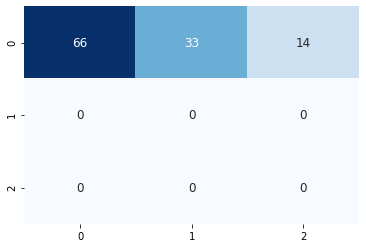

108/108 [==============================] - 0s 242us/sample - loss: 1.2011 - accuracy: 0.5185


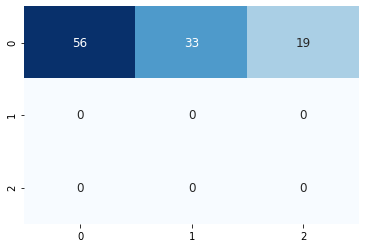

102/102 [==============================] - 0s 234us/sample - loss: 1.1703 - accuracy: 0.5294


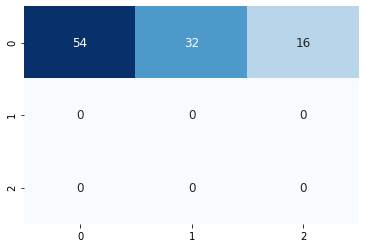

101/101 [==============================] - 0s 244us/sample - loss: 1.2297 - accuracy: 0.5347


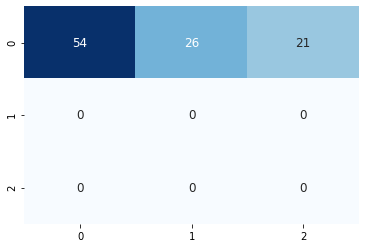

101/101 [==============================] - 0s 252us/sample - loss: 1.3337 - accuracy: 0.4653


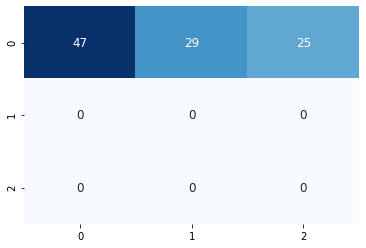

99/99 [==============================] - 0s 238us/sample - loss: 1.3571 - accuracy: 0.4040


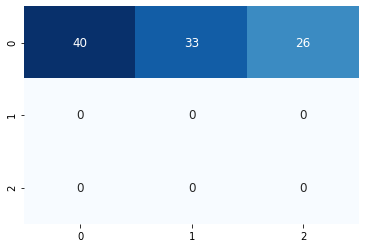

96/96 [==============================] - 0s 2ms/sample - loss: 1.2228 - accuracy: 0.5417


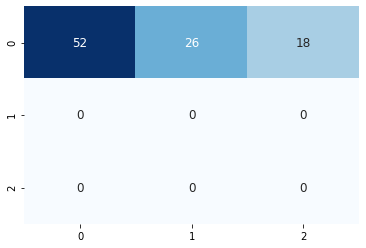

95/95 [==============================] - 0s 240us/sample - loss: 1.3865 - accuracy: 0.5158


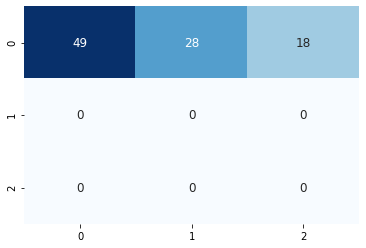

96/96 [==============================] - 0s 231us/sample - loss: 1.2339 - accuracy: 0.5208


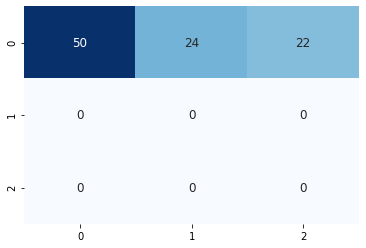

97/97 [==============================] - 0s 286us/sample - loss: 1.4137 - accuracy: 0.4536


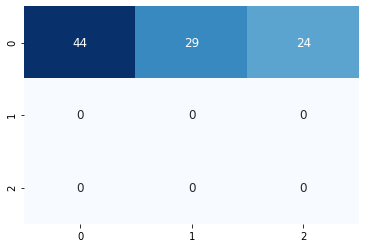

96/96 [==============================] - 0s 285us/sample - loss: 1.3585 - accuracy: 0.5104


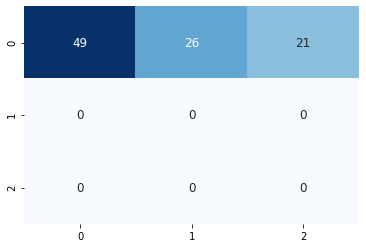

94/94 [==============================] - 0s 251us/sample - loss: 1.3253 - accuracy: 0.4894


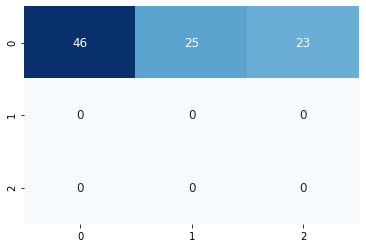

93/93 [==============================] - 0s 248us/sample - loss: 1.7952 - accuracy: 0.3871


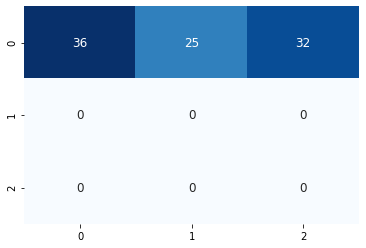

93/93 [==============================] - 0s 277us/sample - loss: 1.5841 - accuracy: 0.4301


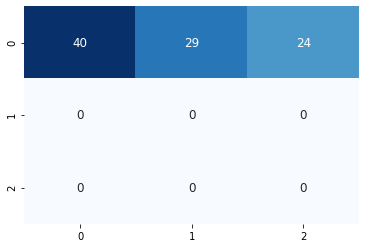

94/94 [==============================] - 0s 256us/sample - loss: 1.6146 - accuracy: 0.3936


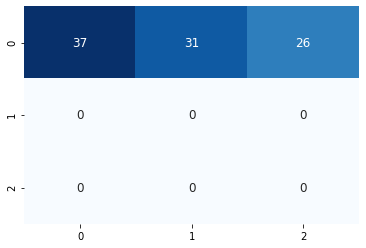

93/93 [==============================] - 0s 242us/sample - loss: 1.7082 - accuracy: 0.4624


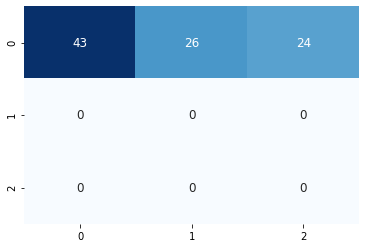

91/91 [==============================] - 0s 285us/sample - loss: 1.7837 - accuracy: 0.3956


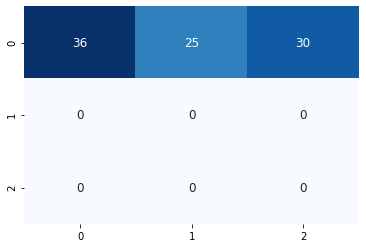

90/90 [==============================] - 0s 245us/sample - loss: 1.6442 - accuracy: 0.3778


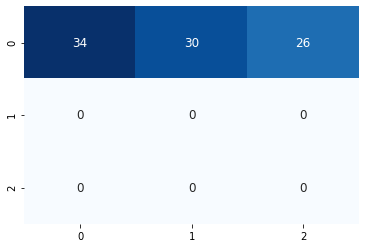

91/91 [==============================] - 0s 282us/sample - loss: 1.6589 - accuracy: 0.3626


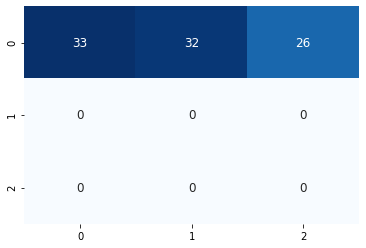

88/88 [==============================] - 0s 267us/sample - loss: 1.5480 - accuracy: 0.4091


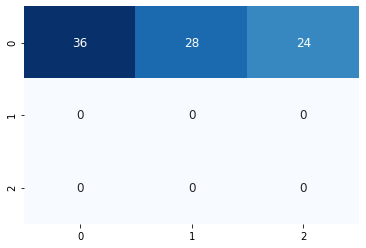

89/89 [==============================] - 0s 304us/sample - loss: 1.6766 - accuracy: 0.4382


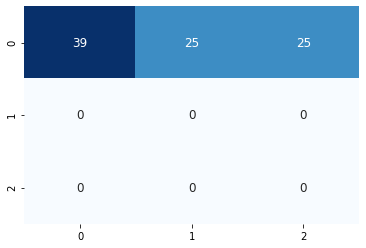

88/88 [==============================] - 0s 261us/sample - loss: 1.5729 - accuracy: 0.4318


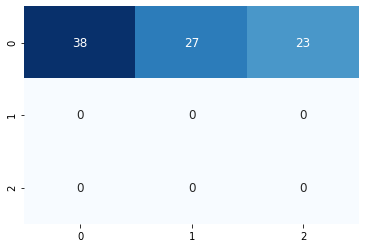

89/89 [==============================] - 0s 268us/sample - loss: 1.5008 - accuracy: 0.4157


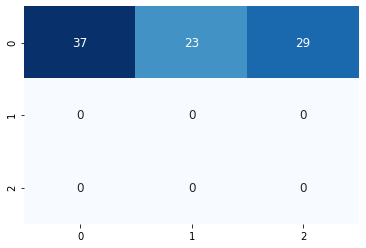

88/88 [==============================] - 0s 279us/sample - loss: 1.6074 - accuracy: 0.4432


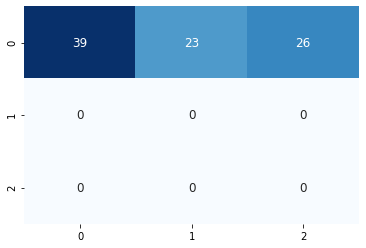

87/87 [==============================] - 0s 284us/sample - loss: 1.4533 - accuracy: 0.5057


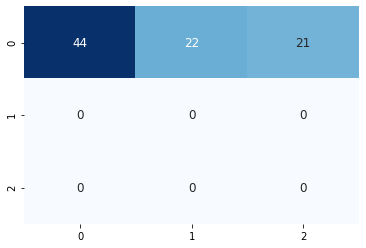

88/88 [==============================] - 0s 259us/sample - loss: 1.5780 - accuracy: 0.3636


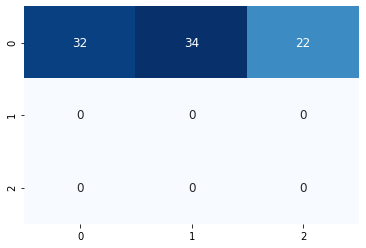

88/88 [==============================] - 0s 268us/sample - loss: 1.3893 - accuracy: 0.4886


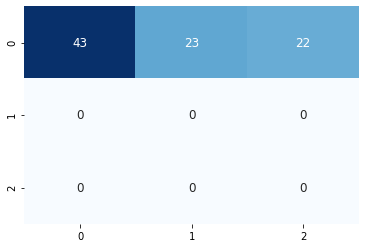

87/87 [==============================] - 0s 246us/sample - loss: 1.2516 - accuracy: 0.4253


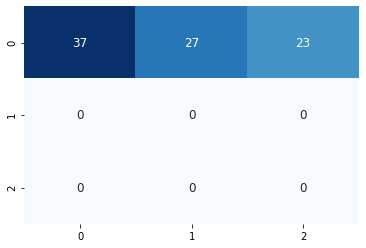

87/87 [==============================] - 0s 252us/sample - loss: 1.3403 - accuracy: 0.4713


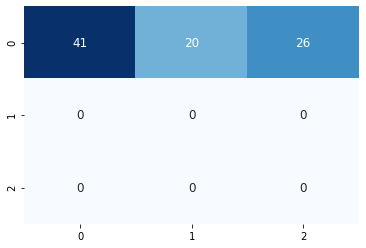

86/86 [==============================] - 0s 249us/sample - loss: 1.5632 - accuracy: 0.4186


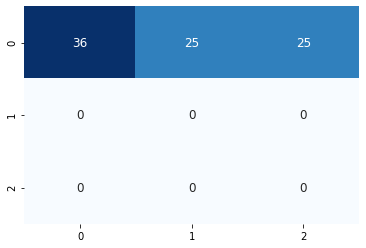

85/85 [==============================] - 0s 1ms/sample - loss: 1.4361 - accuracy: 0.4353


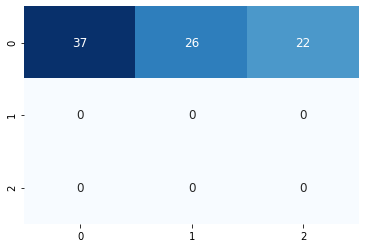

86/86 [==============================] - 0s 240us/sample - loss: 1.6843 - accuracy: 0.3837


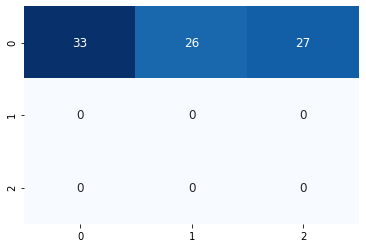

85/85 [==============================] - 0s 293us/sample - loss: 1.4309 - accuracy: 0.4706


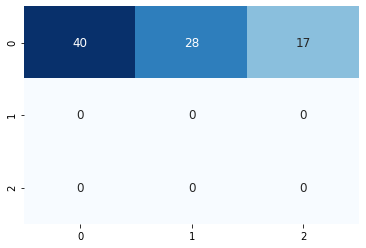

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3900 samples, validate on 1006 samples
Epoch 1/300
3900/3900 [==============================] - 3s 689us/sample - loss: 0.9000 - accuracy: 0.5177 - val_loss: 1.1552 - val_accuracy: 0.3897
Epoch 2/300
3900/3900 [==============================] - 1s 201us/sample - loss: 0.6789 - accuracy: 0.6531 - val_loss: 1.2204 - val_accuracy: 0.4105
Epoch 3/300
3900/3900 [==============================] - 1s 203us/sample - loss: 0.5393 - accuracy: 0.7146 - val_loss: 1.3251 - val_accuracy: 0.4324
Epoch 4/300
3900/3900 [==============================] - 1s 198us/sample - loss: 0.4479 - accuracy: 0.7826 - val_loss: 1.4393 - val_accuracy: 0.4423
Epoch 00004: early stopping
83/83 [==============================] - 0s 5ms/sample - loss: 1.8565 - accuracy: 0.2169


5it [2:02:12, 1492.83s/it]
100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 74 steps
Epoch 1/300
283/283 [==============================] - 29s 101ms/step - loss: 1.4527 - accuracy: 0.4196 - val_loss: 1.2091 - val_accuracy: 0.4261
Epoch 2/300
283/283 [==============================] - 27s 97ms/step - loss: 1.0521 - accuracy: 0.4788 - val_loss: 1.1836 - val_accuracy: 0.4076
Epoch 3/300
283/283 [==============================] - 27s 97ms/step - loss: 0.9935 - accuracy: 0.5015 - val_loss: 1.2074 - val_accuracy: 0.4055
Epoch 4/300
283/283 [==============================] - 27s 96ms/step - loss: 0.9677 - accuracy: 0.5167 - val_loss: 1.2738 - val_accuracy: 0.4532
Epoch 5/300
283/283 [==============================] - 28s 98ms/step - loss: 0.9543 - accuracy: 0.5295 - val_loss: 1.2852 - val_accuracy: 0.3526
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 74 steps
Epoch 1/300
283/283 [=====

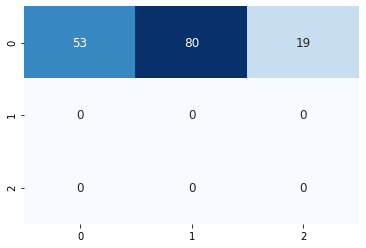

144/144 [==============================] - 0s 241us/sample - loss: 1.3133 - accuracy: 0.4028


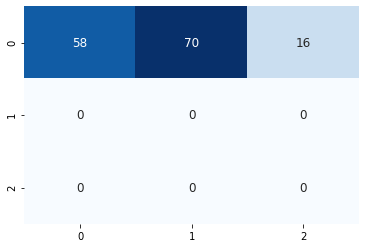

143/143 [==============================] - 0s 226us/sample - loss: 1.3462 - accuracy: 0.3706


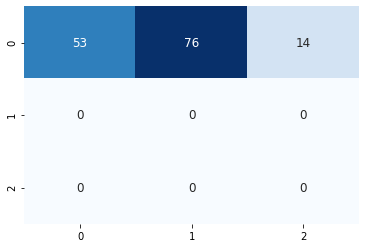

140/140 [==============================] - 0s 327us/sample - loss: 1.2977 - accuracy: 0.4071


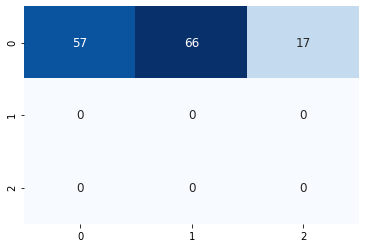

139/139 [==============================] - 0s 264us/sample - loss: 1.2975 - accuracy: 0.4676


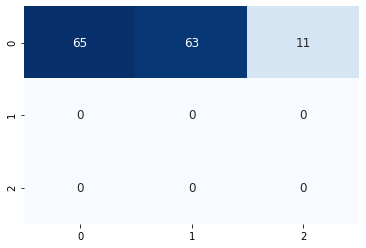

138/138 [==============================] - 0s 253us/sample - loss: 1.3675 - accuracy: 0.4058


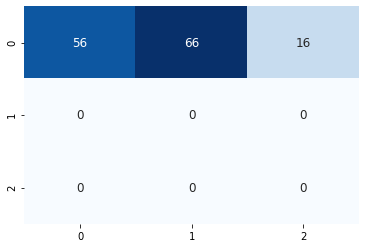

137/137 [==============================] - 0s 251us/sample - loss: 1.2960 - accuracy: 0.4161


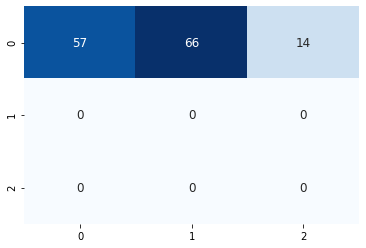

137/137 [==============================] - 0s 270us/sample - loss: 1.3131 - accuracy: 0.4234


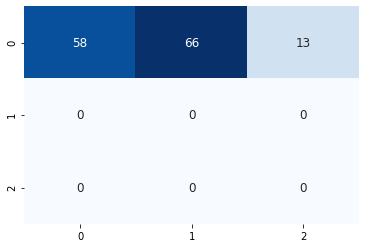

137/137 [==============================] - 0s 249us/sample - loss: 1.3529 - accuracy: 0.3869


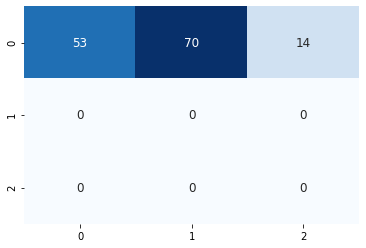

136/136 [==============================] - 0s 263us/sample - loss: 1.2915 - accuracy: 0.4485


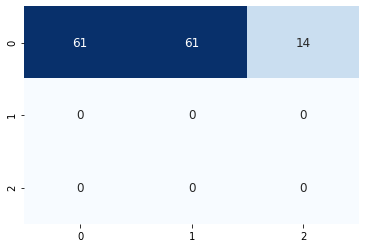

136/136 [==============================] - 0s 275us/sample - loss: 1.3333 - accuracy: 0.3897


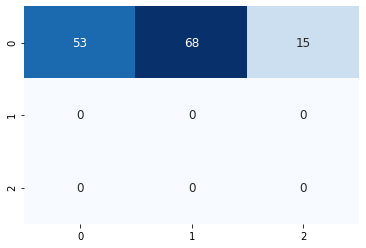

134/134 [==============================] - 0s 270us/sample - loss: 1.3998 - accuracy: 0.3731


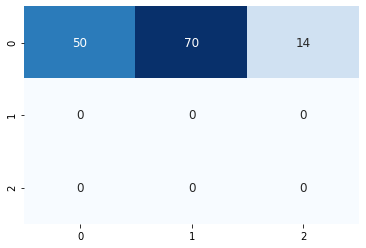

134/134 [==============================] - 0s 262us/sample - loss: 1.2935 - accuracy: 0.3955


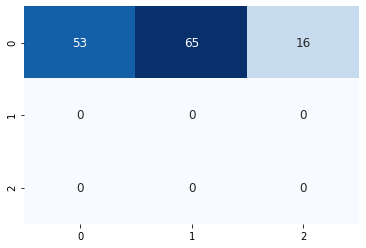

134/134 [==============================] - 0s 257us/sample - loss: 1.3210 - accuracy: 0.3806


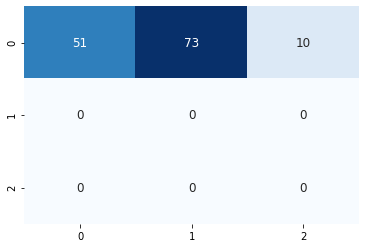

133/133 [==============================] - 0s 294us/sample - loss: 1.4327 - accuracy: 0.3910


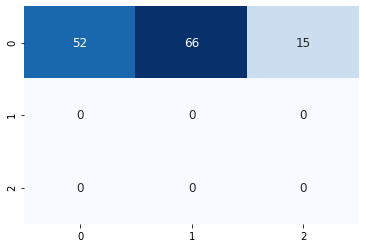

134/134 [==============================] - 0s 266us/sample - loss: 1.3629 - accuracy: 0.4030


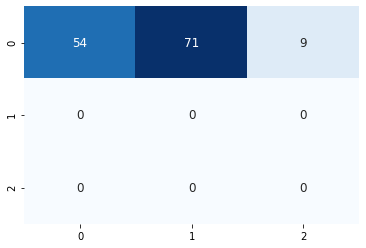

135/135 [==============================] - 0s 267us/sample - loss: 1.2767 - accuracy: 0.3778


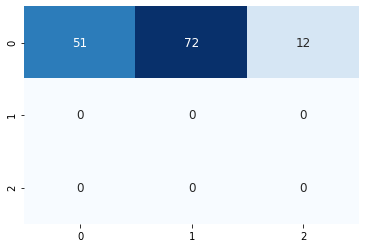

134/134 [==============================] - 0s 288us/sample - loss: 1.4392 - accuracy: 0.4104


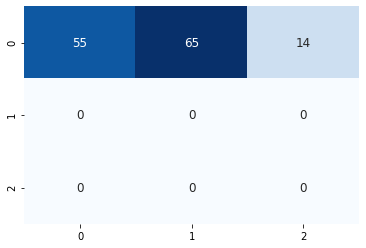

136/136 [==============================] - 0s 283us/sample - loss: 1.4452 - accuracy: 0.4191


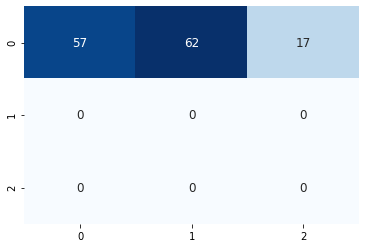

133/133 [==============================] - 0s 260us/sample - loss: 1.4056 - accuracy: 0.3985


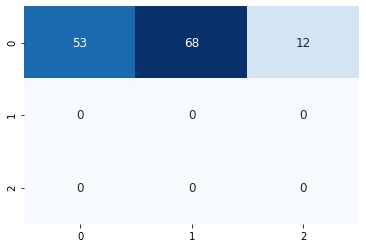

134/134 [==============================] - 0s 274us/sample - loss: 1.3402 - accuracy: 0.4179


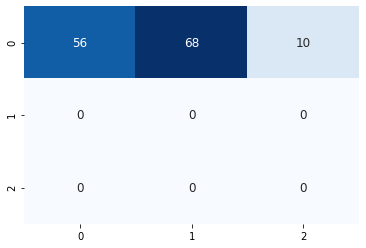

132/132 [==============================] - 0s 318us/sample - loss: 1.2825 - accuracy: 0.4394


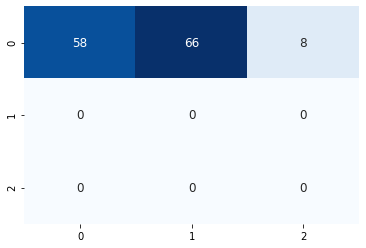

133/133 [==============================] - 0s 284us/sample - loss: 1.3213 - accuracy: 0.4211


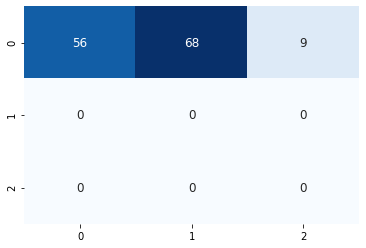

133/133 [==============================] - 0s 261us/sample - loss: 1.3891 - accuracy: 0.3985


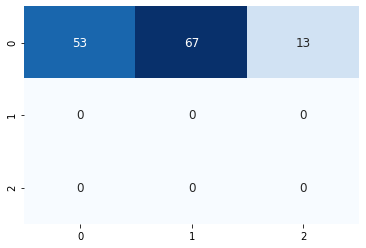

132/132 [==============================] - 0s 254us/sample - loss: 1.3175 - accuracy: 0.4242


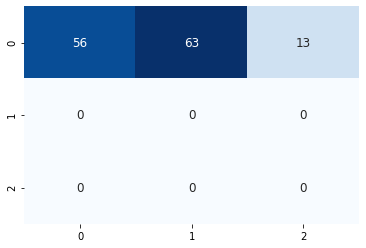

132/132 [==============================] - 0s 248us/sample - loss: 1.3046 - accuracy: 0.4318


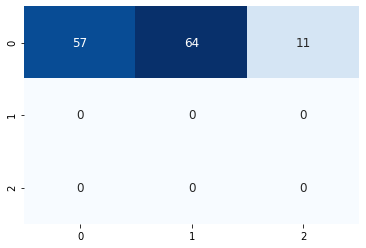

133/133 [==============================] - 0s 245us/sample - loss: 1.2651 - accuracy: 0.4361


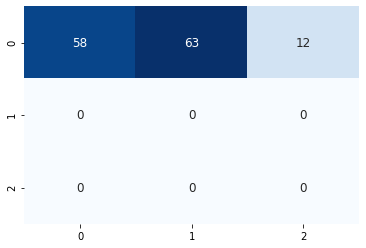

132/132 [==============================] - 0s 291us/sample - loss: 1.3626 - accuracy: 0.3561


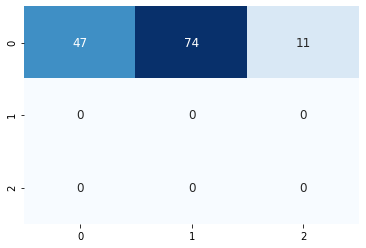

132/132 [==============================] - 0s 271us/sample - loss: 1.4154 - accuracy: 0.4091


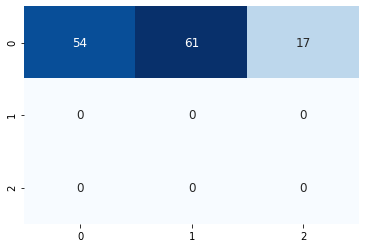

132/132 [==============================] - 0s 278us/sample - loss: 1.2704 - accuracy: 0.3485


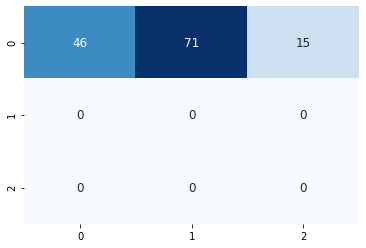

132/132 [==============================] - 0s 269us/sample - loss: 1.3565 - accuracy: 0.3788


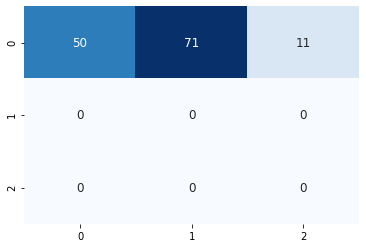

133/133 [==============================] - 0s 265us/sample - loss: 1.4309 - accuracy: 0.3008


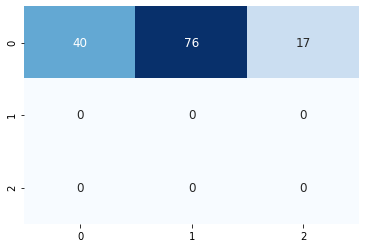

128/128 [==============================] - 0s 2ms/sample - loss: 1.3622 - accuracy: 0.4141


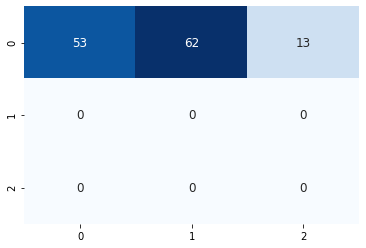

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3869 samples, validate on 998 samples
Epoch 1/300
3869/3869 [==============================] - 3s 707us/sample - loss: 1.0294 - accuracy: 0.4262 - val_loss: 1.1078 - val_accuracy: 0.4088
Epoch 2/300
3869/3869 [==============================] - 1s 198us/sample - loss: 0.8061 - accuracy: 0.6020 - val_loss: 1.1406 - val_accuracy: 0.4309
Epoch 3/300
3869/3869 [==============================] - 1s 201us/sample - loss: 0.6465 - accuracy: 0.6885 - val_loss: 1.2128 - val_accuracy: 0.4609
Epoch 4/300
3869/3869 [==============================] - 1s 212us/sample - loss: 0.5228 - accuracy: 0.7534 - val_loss: 1.3281 - val_accuracy: 0.4729
Epoch 00004: early stopping
122/122 [==============================] - 0s 3ms/sample - loss: 1.4340 - accuracy: 0.3525


6it [2:24:17, 1442.52s/it]
100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 75 steps
Epoch 1/300
283/283 [==============================] - 29s 102ms/step - loss: 1.4738 - accuracy: 0.4192 - val_loss: 1.2394 - val_accuracy: 0.4156
Epoch 2/300
283/283 [==============================] - 28s 98ms/step - loss: 1.0629 - accuracy: 0.4732 - val_loss: 1.2022 - val_accuracy: 0.4260
Epoch 3/300
283/283 [==============================] - 28s 98ms/step - loss: 0.9990 - accuracy: 0.4997 - val_loss: 1.2104 - val_accuracy: 0.3595
Epoch 4/300
283/283 [==============================] - 28s 98ms/step - loss: 0.9756 - accuracy: 0.5114 - val_loss: 1.2917 - val_accuracy: 0.3861
Epoch 5/300
283/283 [==============================] - 28s 98ms/step - loss: 0.9631 - accuracy: 0.5220 - val_loss: 1.2671 - val_accuracy: 0.3918
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 75 steps
Epoch 1/300
283/283 [=====

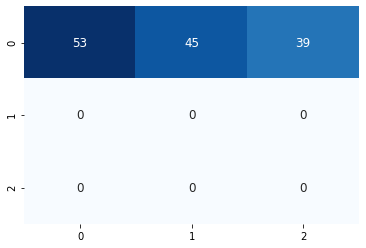

132/132 [==============================] - 0s 232us/sample - loss: 1.4071 - accuracy: 0.3182


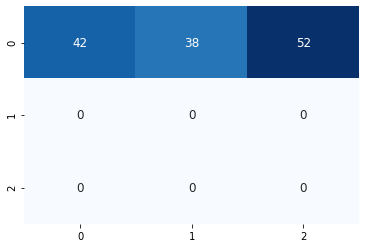

130/130 [==============================] - 0s 281us/sample - loss: 1.3274 - accuracy: 0.3077


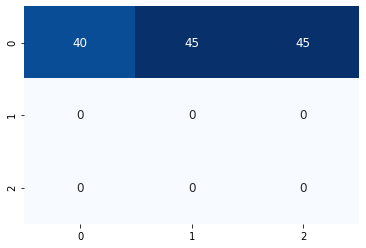

130/130 [==============================] - 0s 236us/sample - loss: 1.3755 - accuracy: 0.2846


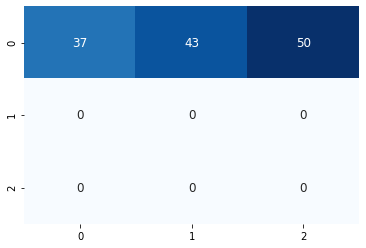

128/128 [==============================] - 0s 2ms/sample - loss: 1.3719 - accuracy: 0.3047


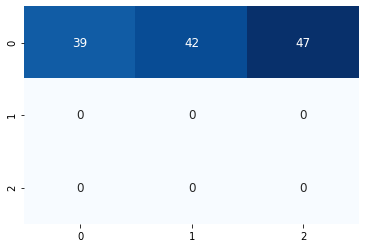

128/128 [==============================] - 0s 243us/sample - loss: 1.2321 - accuracy: 0.3672


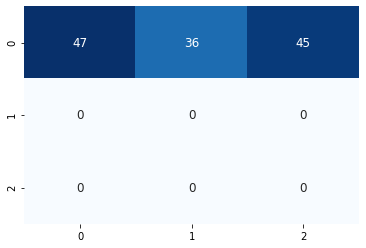

129/129 [==============================] - 0s 264us/sample - loss: 1.2706 - accuracy: 0.3953


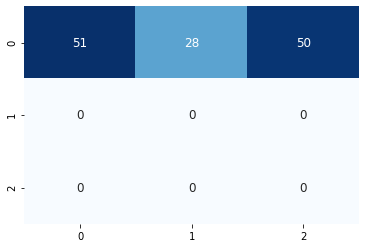

129/129 [==============================] - 0s 255us/sample - loss: 1.1317 - accuracy: 0.4496


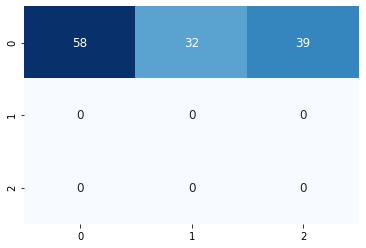

126/126 [==============================] - 0s 242us/sample - loss: 1.1363 - accuracy: 0.4603


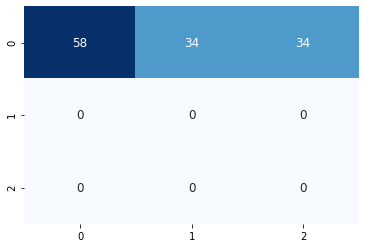

126/126 [==============================] - 0s 245us/sample - loss: 1.1446 - accuracy: 0.4524


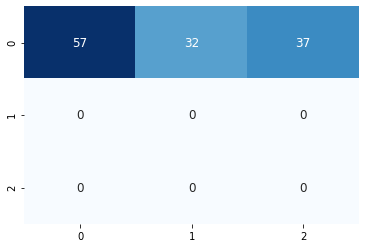

126/126 [==============================] - 0s 243us/sample - loss: 1.1013 - accuracy: 0.4444


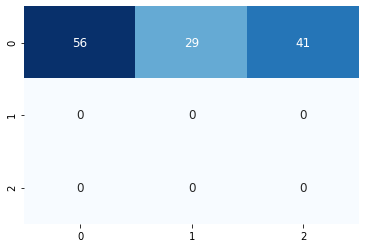

126/126 [==============================] - 0s 289us/sample - loss: 1.0592 - accuracy: 0.5079


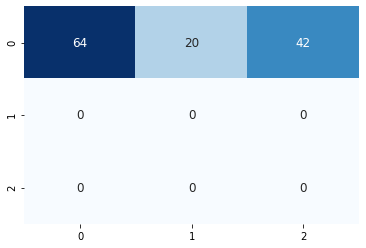

126/126 [==============================] - 0s 269us/sample - loss: 1.0522 - accuracy: 0.5000


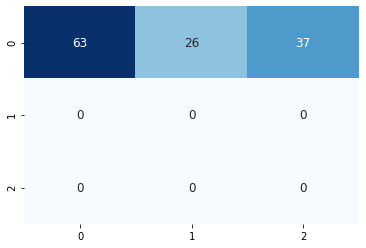

124/124 [==============================] - 0s 255us/sample - loss: 1.0744 - accuracy: 0.5000


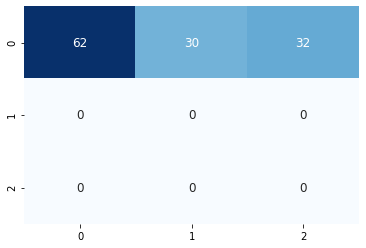

124/124 [==============================] - 0s 277us/sample - loss: 1.1111 - accuracy: 0.4758


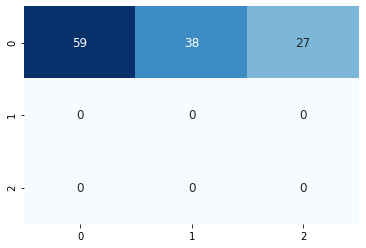

122/122 [==============================] - 0s 286us/sample - loss: 1.2551 - accuracy: 0.4590


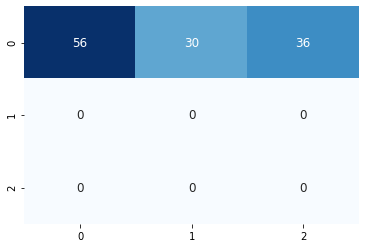

122/122 [==============================] - 0s 271us/sample - loss: 1.2043 - accuracy: 0.4590


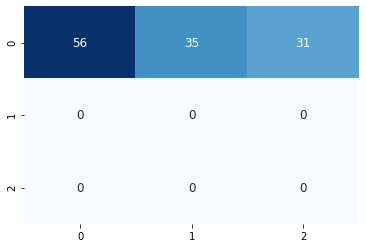

120/120 [==============================] - 0s 245us/sample - loss: 1.2158 - accuracy: 0.4417


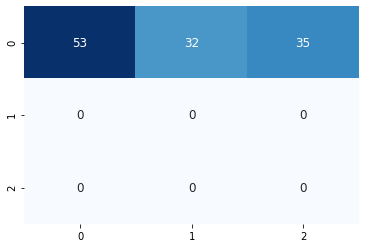

121/121 [==============================] - 0s 244us/sample - loss: 1.2491 - accuracy: 0.4215


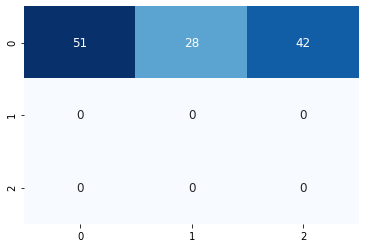

121/121 [==============================] - 0s 253us/sample - loss: 1.2125 - accuracy: 0.4380


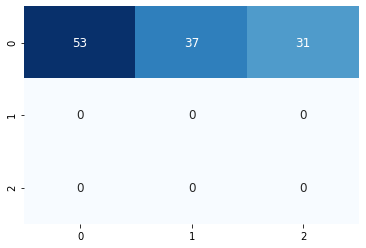

120/120 [==============================] - 0s 230us/sample - loss: 1.2667 - accuracy: 0.4500


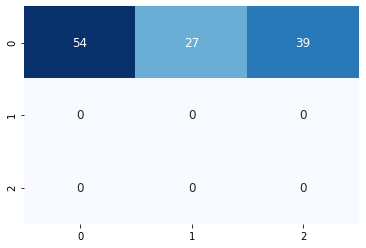

121/121 [==============================] - 0s 281us/sample - loss: 1.0067 - accuracy: 0.5702


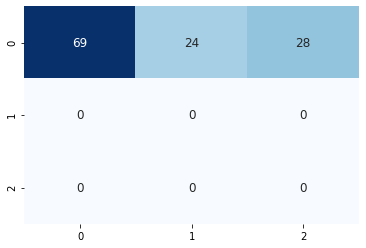

120/120 [==============================] - 0s 257us/sample - loss: 1.0789 - accuracy: 0.5167


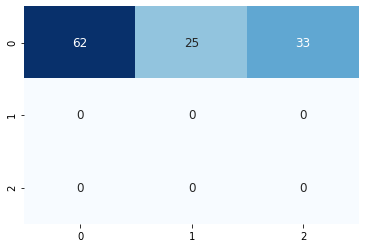

120/120 [==============================] - 0s 246us/sample - loss: 1.0761 - accuracy: 0.5500


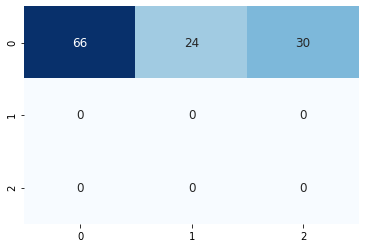

120/120 [==============================] - 0s 243us/sample - loss: 1.0619 - accuracy: 0.5417


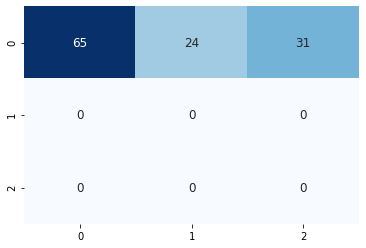

120/120 [==============================] - 0s 273us/sample - loss: 1.1968 - accuracy: 0.5000


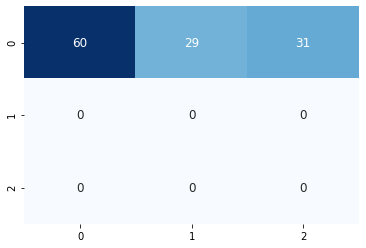

122/122 [==============================] - 0s 262us/sample - loss: 1.1536 - accuracy: 0.4918


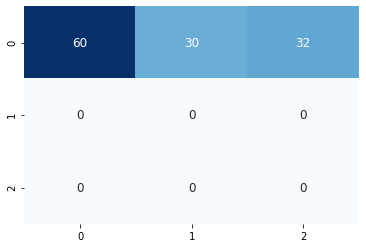

119/119 [==============================] - 0s 241us/sample - loss: 1.1103 - accuracy: 0.4454


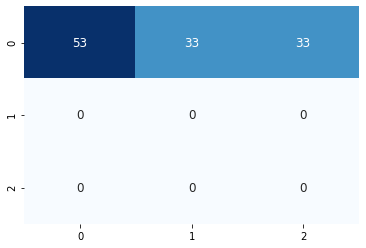

116/116 [==============================] - 0s 278us/sample - loss: 1.1027 - accuracy: 0.5086


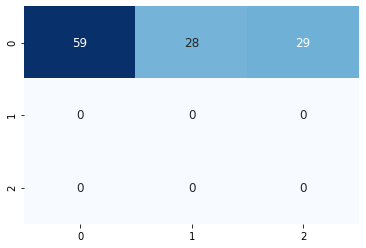

117/117 [==============================] - 0s 243us/sample - loss: 1.0681 - accuracy: 0.5043


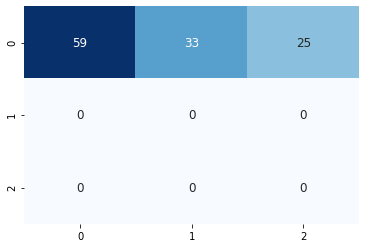

116/116 [==============================] - 0s 265us/sample - loss: 1.0627 - accuracy: 0.5517


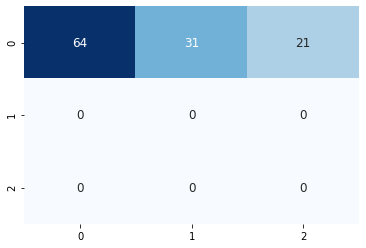

117/117 [==============================] - 0s 288us/sample - loss: 1.0198 - accuracy: 0.4872


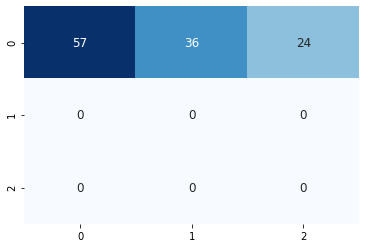

117/117 [==============================] - 0s 258us/sample - loss: 0.9004 - accuracy: 0.5726


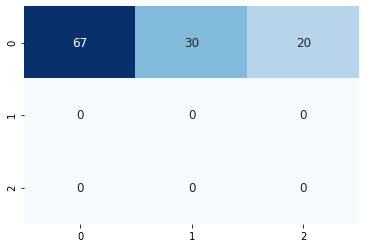

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3869 samples, validate on 1011 samples
Epoch 1/300
3869/3869 [==============================] - 3s 801us/sample - loss: 0.9582 - accuracy: 0.4590 - val_loss: 1.1094 - val_accuracy: 0.3610
Epoch 2/300
3869/3869 [==============================] - 1s 198us/sample - loss: 0.7964 - accuracy: 0.5712 - val_loss: 1.1371 - val_accuracy: 0.3798
Epoch 3/300
3869/3869 [==============================] - 1s 196us/sample - loss: 0.6796 - accuracy: 0.6366 - val_loss: 1.1966 - val_accuracy: 0.3986
Epoch 4/300
3869/3869 [==============================] - 1s 205us/sample - loss: 0.5863 - accuracy: 0.6981 - val_loss: 1.2849 - val_accuracy: 0.4204
Epoch 00004: early stopping
109/109 [==============================] - 0s 4ms/sample - loss: 0.8340 - accuracy: 0.6330


7it [2:48:10, 1439.64s/it]
100%|██████████| 3/3 [00:06<00:00,  2.31s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 75 steps
Epoch 1/300
286/286 [==============================] - 29s 101ms/step - loss: 1.4526 - accuracy: 0.4234 - val_loss: 1.2359 - val_accuracy: 0.3615
Epoch 2/300
286/286 [==============================] - 28s 97ms/step - loss: 1.0528 - accuracy: 0.4719 - val_loss: 1.1820 - val_accuracy: 0.3530
Epoch 3/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9972 - accuracy: 0.4939 - val_loss: 1.2318 - val_accuracy: 0.4274
Epoch 4/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9717 - accuracy: 0.5126 - val_loss: 1.2255 - val_accuracy: 0.3898
Epoch 5/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9589 - accuracy: 0.5239 - val_loss: 1.2532 - val_accuracy: 0.3879
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 75 steps
Epoch 1/300
286/286 [=====

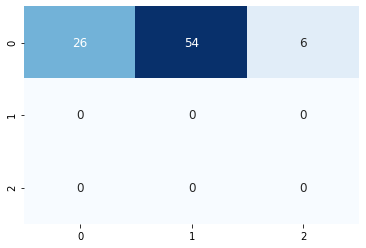

85/85 [==============================] - 0s 245us/sample - loss: 1.3422 - accuracy: 0.3294


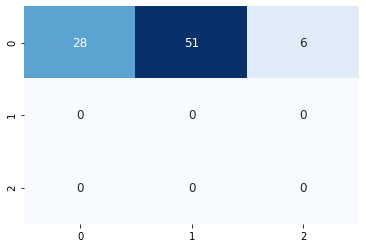

84/84 [==============================] - 0s 330us/sample - loss: 1.5669 - accuracy: 0.3214


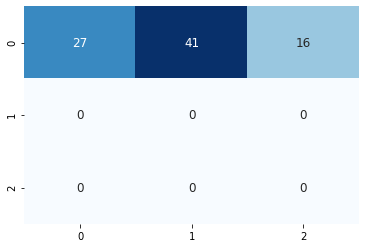

82/82 [==============================] - 0s 1ms/sample - loss: 1.3653 - accuracy: 0.3659


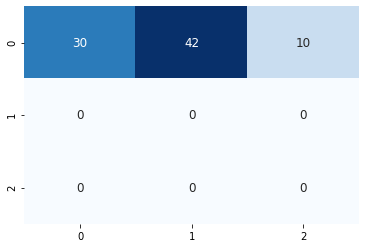

83/83 [==============================] - 0s 251us/sample - loss: 1.5470 - accuracy: 0.3253


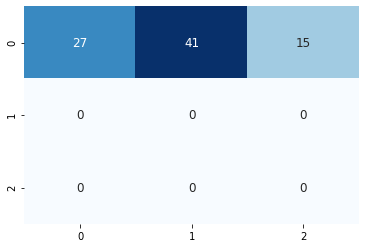

83/83 [==============================] - 0s 231us/sample - loss: 1.4431 - accuracy: 0.2530


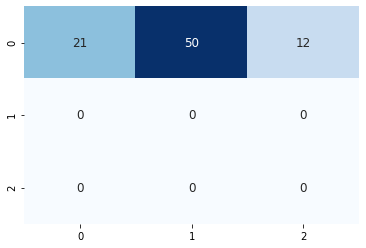

82/82 [==============================] - 0s 258us/sample - loss: 1.4714 - accuracy: 0.3293


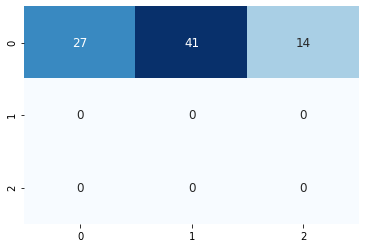

82/82 [==============================] - 0s 233us/sample - loss: 1.4600 - accuracy: 0.2683


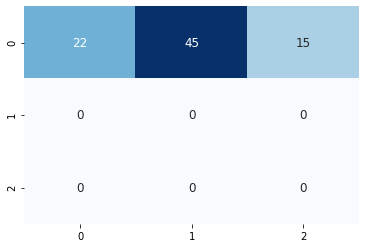

80/80 [==============================] - 0s 255us/sample - loss: 1.4851 - accuracy: 0.3000


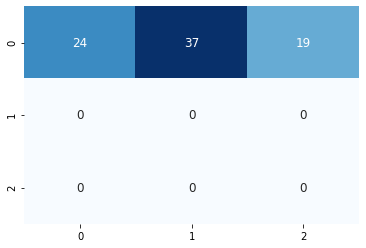

79/79 [==============================] - 0s 239us/sample - loss: 1.4740 - accuracy: 0.3291


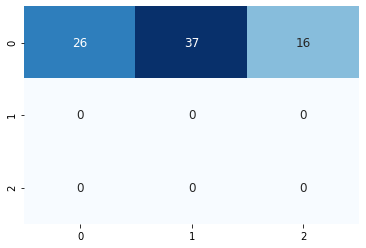

79/79 [==============================] - 0s 241us/sample - loss: 1.3079 - accuracy: 0.3418


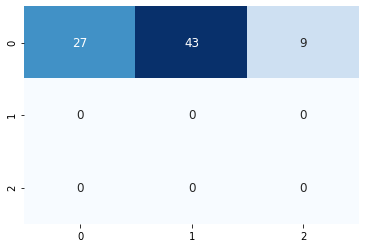

78/78 [==============================] - 0s 276us/sample - loss: 1.2982 - accuracy: 0.4103


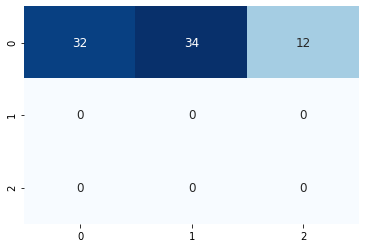

78/78 [==============================] - 0s 298us/sample - loss: 1.3147 - accuracy: 0.4359


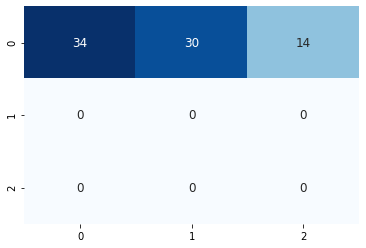

79/79 [==============================] - 0s 287us/sample - loss: 1.2972 - accuracy: 0.3924


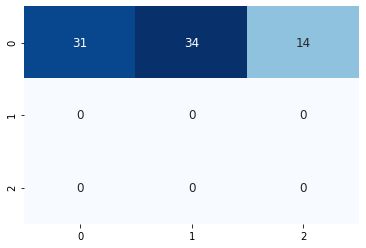

78/78 [==============================] - 0s 327us/sample - loss: 1.3295 - accuracy: 0.4615


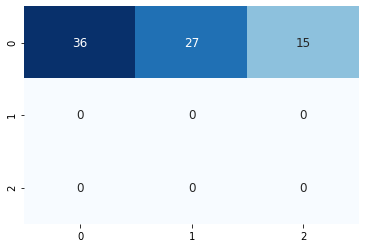

77/77 [==============================] - 0s 278us/sample - loss: 1.2935 - accuracy: 0.4156


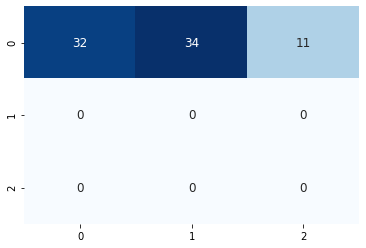

76/76 [==============================] - 0s 321us/sample - loss: 1.3923 - accuracy: 0.3421


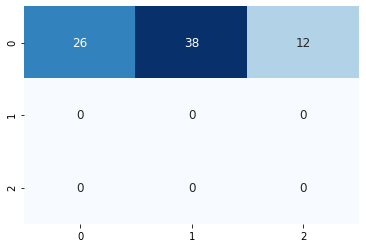

76/76 [==============================] - 0s 319us/sample - loss: 1.3967 - accuracy: 0.4079


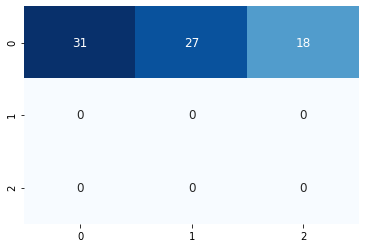

75/75 [==============================] - 0s 285us/sample - loss: 1.3034 - accuracy: 0.4133


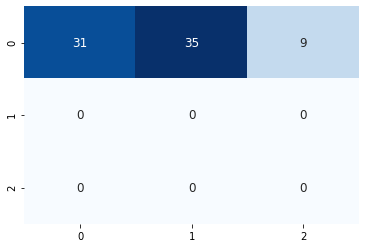

76/76 [==============================] - 0s 268us/sample - loss: 1.1799 - accuracy: 0.3816


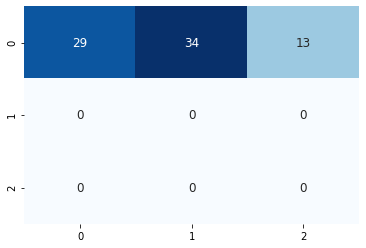

76/76 [==============================] - 0s 269us/sample - loss: 1.4216 - accuracy: 0.3816


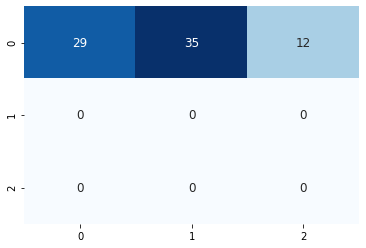

76/76 [==============================] - 0s 265us/sample - loss: 1.4815 - accuracy: 0.3553


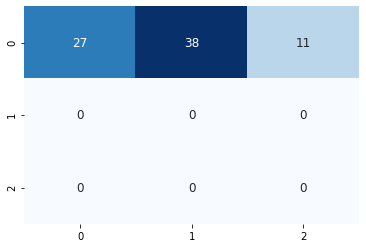

75/75 [==============================] - 0s 317us/sample - loss: 1.3223 - accuracy: 0.4400


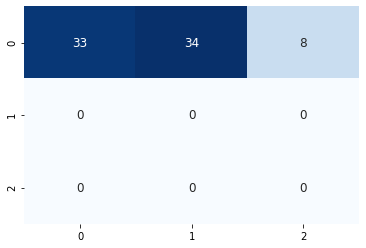

75/75 [==============================] - 0s 277us/sample - loss: 1.3319 - accuracy: 0.3867


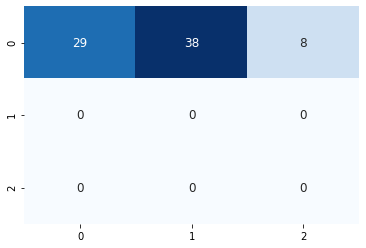

74/74 [==============================] - 0s 293us/sample - loss: 1.1933 - accuracy: 0.4865


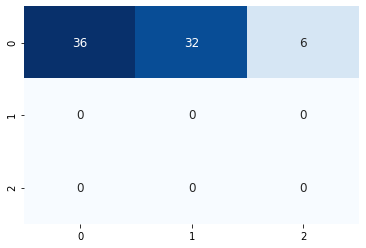

75/75 [==============================] - 0s 284us/sample - loss: 1.3739 - accuracy: 0.3600


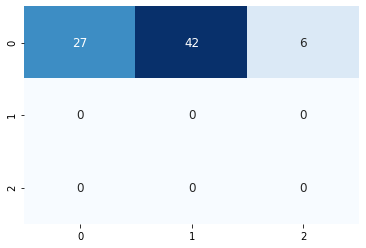

75/75 [==============================] - 0s 329us/sample - loss: 1.2211 - accuracy: 0.4800


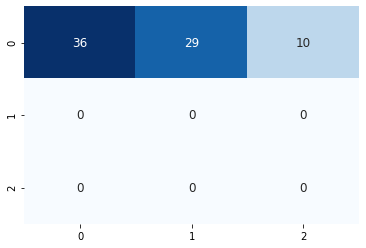

74/74 [==============================] - 0s 283us/sample - loss: 1.2699 - accuracy: 0.4865


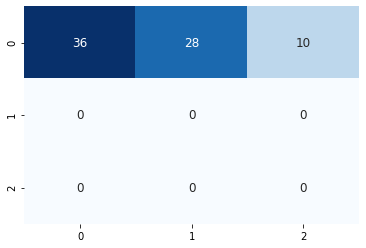

73/73 [==============================] - 0s 284us/sample - loss: 1.2060 - accuracy: 0.4932


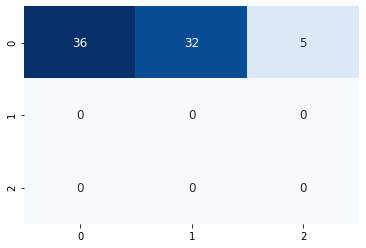

73/73 [==============================] - 0s 304us/sample - loss: 1.3119 - accuracy: 0.4247


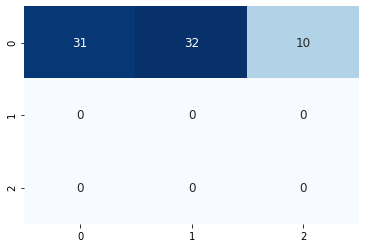

73/73 [==============================] - 0s 279us/sample - loss: 1.4261 - accuracy: 0.3836


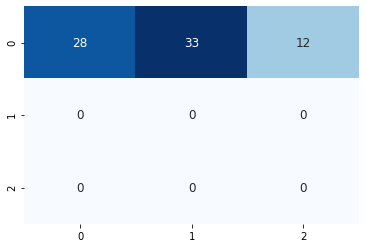

73/73 [==============================] - 0s 260us/sample - loss: 1.3159 - accuracy: 0.4384


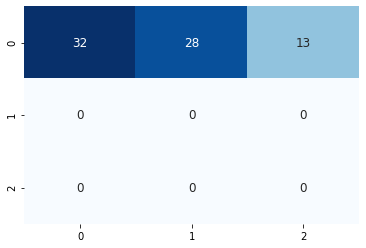

71/71 [==============================] - 0s 288us/sample - loss: 1.1027 - accuracy: 0.4930


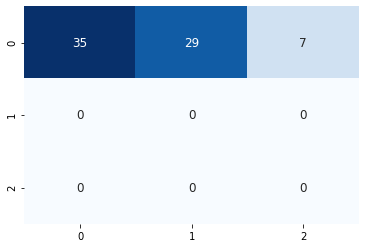

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3909 samples, validate on 1014 samples
Epoch 1/300
3909/3909 [==============================] - 3s 723us/sample - loss: 0.9746 - accuracy: 0.4666 - val_loss: 1.1022 - val_accuracy: 0.3905
Epoch 2/300
3909/3909 [==============================] - 1s 217us/sample - loss: 0.6960 - accuracy: 0.6818 - val_loss: 1.1669 - val_accuracy: 0.4103
Epoch 3/300
3909/3909 [==============================] - 1s 210us/sample - loss: 0.5272 - accuracy: 0.7549 - val_loss: 1.2898 - val_accuracy: 0.4310
Epoch 4/300
3909/3909 [==============================] - 1s 188us/sample - loss: 0.4081 - accuracy: 0.8153 - val_loss: 1.4419 - val_accuracy: 0.4684
Epoch 00004: early stopping
66/66 [==============================] - 0s 6ms/sample - loss: 1.4575 - accuracy: 0.2879


8it [3:15:26, 1498.51s/it]
100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 281 steps, validate for 74 steps
Epoch 1/300
281/281 [==============================] - 29s 104ms/step - loss: 1.4516 - accuracy: 0.4255 - val_loss: 1.2166 - val_accuracy: 0.3557
Epoch 2/300
281/281 [==============================] - 28s 98ms/step - loss: 1.0428 - accuracy: 0.4833 - val_loss: 1.1788 - val_accuracy: 0.3994
Epoch 3/300
281/281 [==============================] - 28s 98ms/step - loss: 0.9830 - accuracy: 0.5053 - val_loss: 1.2001 - val_accuracy: 0.3980
Epoch 4/300
281/281 [==============================] - 28s 99ms/step - loss: 0.9543 - accuracy: 0.5268 - val_loss: 1.2912 - val_accuracy: 0.4082
Epoch 5/300
281/281 [==============================] - 27s 97ms/step - loss: 0.9392 - accuracy: 0.5366 - val_loss: 1.2810 - val_accuracy: 0.4087
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 281 steps, validate for 74 steps
Epoch 1/300
281/281 [=====

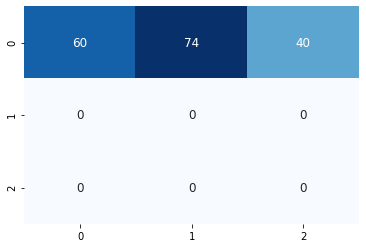

169/169 [==============================] - 0s 248us/sample - loss: 1.7961 - accuracy: 0.2544


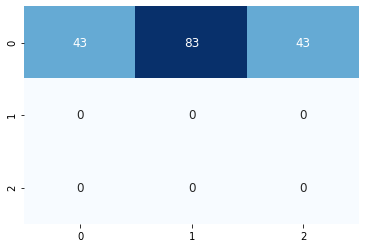

170/170 [==============================] - 0s 255us/sample - loss: 1.6519 - accuracy: 0.3294


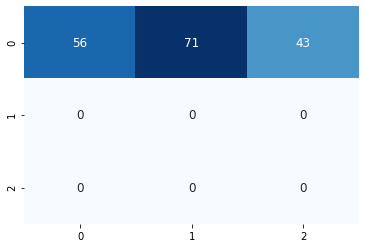

167/167 [==============================] - 0s 228us/sample - loss: 1.7004 - accuracy: 0.2874


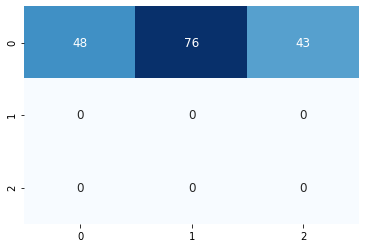

168/168 [==============================] - 0s 228us/sample - loss: 1.8909 - accuracy: 0.2560


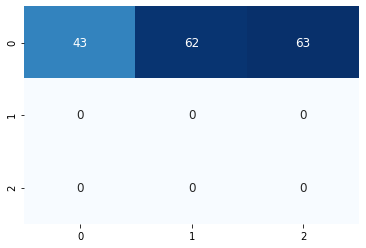

169/169 [==============================] - 0s 241us/sample - loss: 1.9215 - accuracy: 0.2189


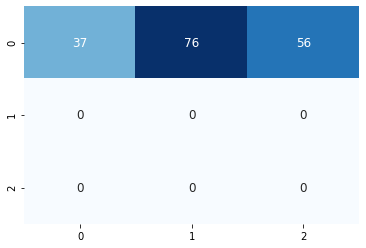

169/169 [==============================] - 0s 246us/sample - loss: 2.1515 - accuracy: 0.1598


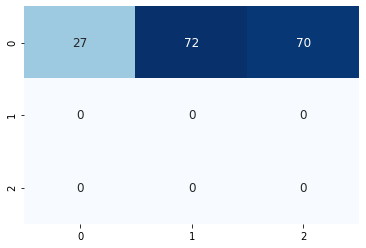

167/167 [==============================] - 0s 265us/sample - loss: 2.2861 - accuracy: 0.1497


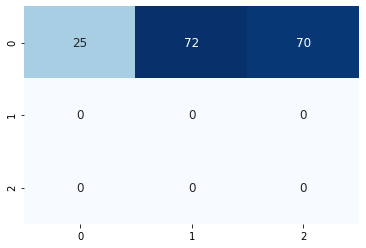

166/166 [==============================] - 0s 316us/sample - loss: 2.1747 - accuracy: 0.1145


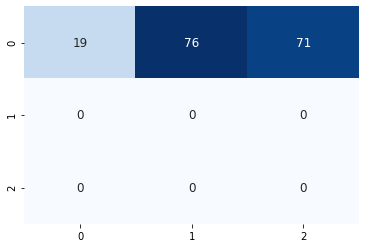

164/164 [==============================] - 0s 257us/sample - loss: 2.2270 - accuracy: 0.1524


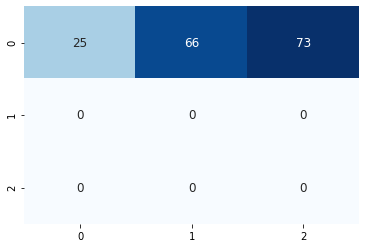

164/164 [==============================] - 0s 278us/sample - loss: 2.1242 - accuracy: 0.1707


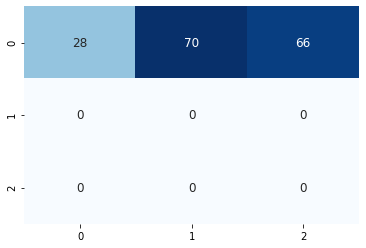

164/164 [==============================] - 0s 229us/sample - loss: 2.2335 - accuracy: 0.1220


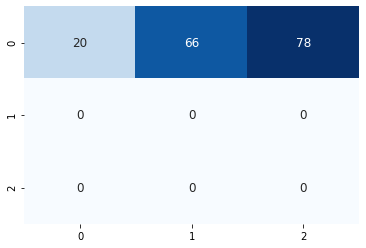

163/163 [==============================] - 0s 260us/sample - loss: 2.1539 - accuracy: 0.1902


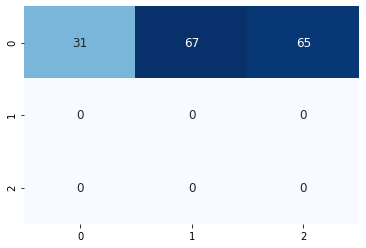

161/161 [==============================] - 0s 275us/sample - loss: 2.2062 - accuracy: 0.1677


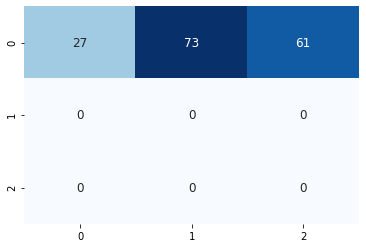

159/159 [==============================] - 0s 238us/sample - loss: 2.2014 - accuracy: 0.2327


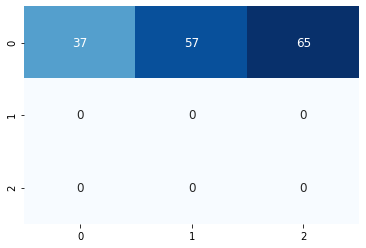

161/161 [==============================] - 0s 245us/sample - loss: 2.2426 - accuracy: 0.2174


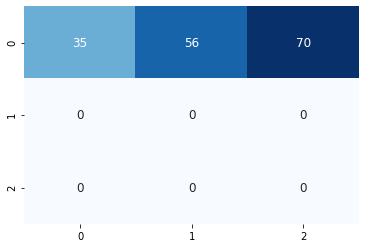

159/159 [==============================] - 0s 244us/sample - loss: 2.1525 - accuracy: 0.2013


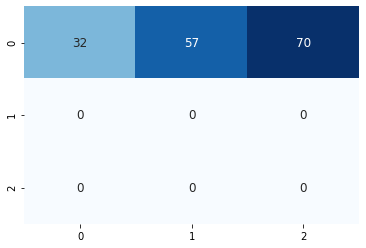

158/158 [==============================] - 0s 250us/sample - loss: 2.2286 - accuracy: 0.1582


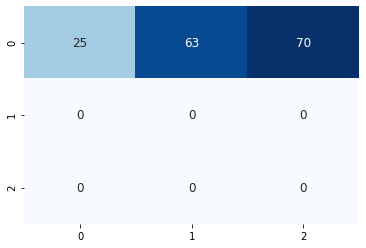

159/159 [==============================] - 0s 255us/sample - loss: 2.3570 - accuracy: 0.2138


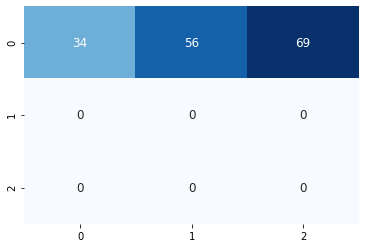

158/158 [==============================] - 0s 262us/sample - loss: 2.3721 - accuracy: 0.1456


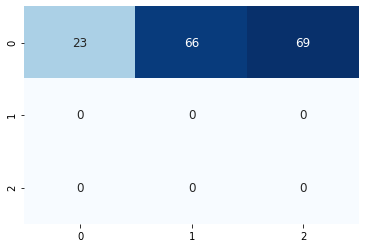

157/157 [==============================] - 0s 228us/sample - loss: 2.3654 - accuracy: 0.1656


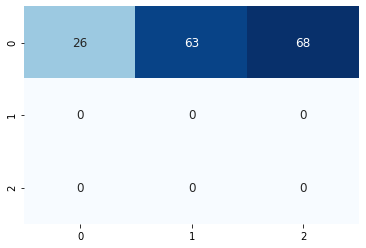

157/157 [==============================] - 0s 246us/sample - loss: 2.4039 - accuracy: 0.1529


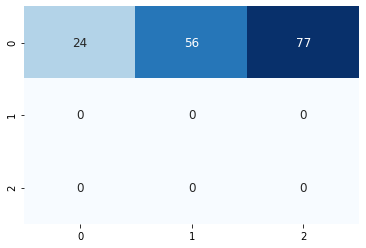

157/157 [==============================] - 0s 236us/sample - loss: 2.4043 - accuracy: 0.2102


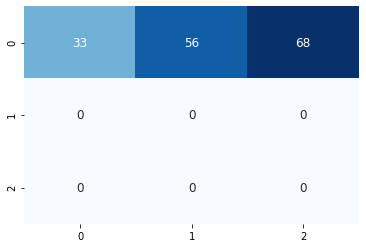

157/157 [==============================] - 0s 240us/sample - loss: 2.4070 - accuracy: 0.1656


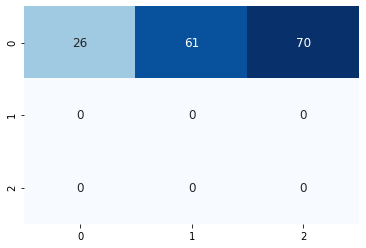

154/154 [==============================] - 0s 255us/sample - loss: 2.3391 - accuracy: 0.2143


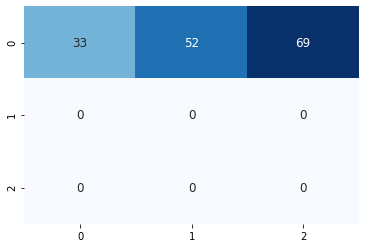

153/153 [==============================] - 0s 278us/sample - loss: 2.3267 - accuracy: 0.2157


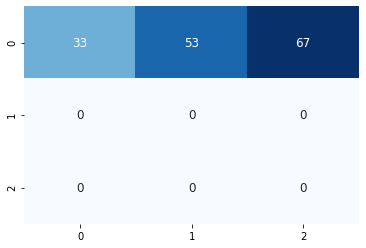

153/153 [==============================] - 0s 250us/sample - loss: 2.3986 - accuracy: 0.1895


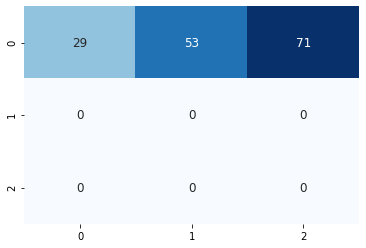

153/153 [==============================] - 0s 260us/sample - loss: 2.2931 - accuracy: 0.2157


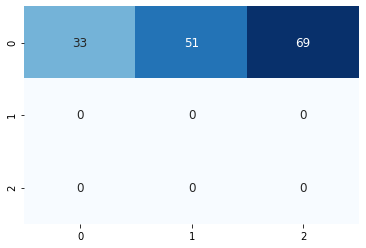

150/150 [==============================] - 0s 247us/sample - loss: 2.5106 - accuracy: 0.1867


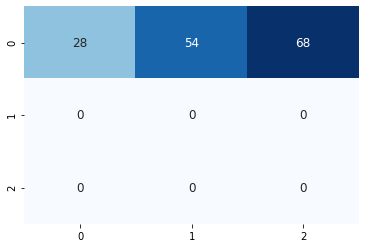

150/150 [==============================] - 0s 240us/sample - loss: 2.4620 - accuracy: 0.1467


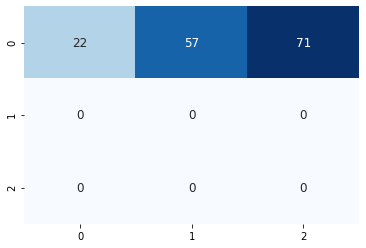

152/152 [==============================] - 0s 254us/sample - loss: 2.2259 - accuracy: 0.2237


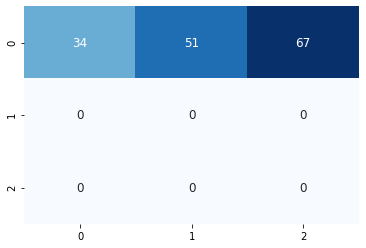

151/151 [==============================] - 0s 243us/sample - loss: 2.2436 - accuracy: 0.2318


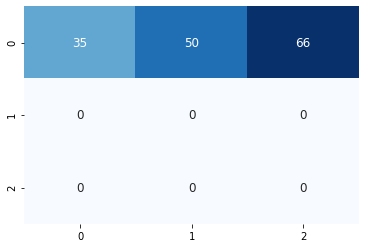

147/147 [==============================] - 0s 263us/sample - loss: 2.3220 - accuracy: 0.2517


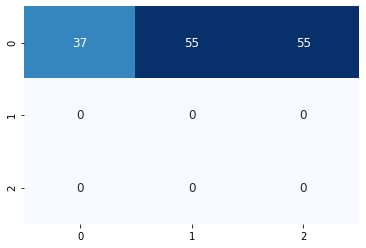

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3843 samples, validate on 1007 samples
Epoch 1/300
3843/3843 [==============================] - 3s 759us/sample - loss: 1.0133 - accuracy: 0.4616 - val_loss: 1.1145 - val_accuracy: 0.4062
Epoch 2/300
3843/3843 [==============================] - 1s 198us/sample - loss: 0.7776 - accuracy: 0.6232 - val_loss: 1.1420 - val_accuracy: 0.4250
Epoch 3/300
3843/3843 [==============================] - 1s 208us/sample - loss: 0.6117 - accuracy: 0.7008 - val_loss: 1.2141 - val_accuracy: 0.4240
Epoch 4/300
3843/3843 [==============================] - 1s 174us/sample - loss: 0.4964 - accuracy: 0.7515 - val_loss: 1.2946 - val_accuracy: 0.4518
Epoch 00004: early stopping
139/139 [==============================] - 0s 3ms/sample - loss: 2.2001 - accuracy: 0.1439


9it [3:38:31, 1464.34s/it]
100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 280 steps, validate for 75 steps
Epoch 1/300
280/280 [==============================] - 29s 103ms/step - loss: 1.4638 - accuracy: 0.4192 - val_loss: 1.2485 - val_accuracy: 0.3796
Epoch 2/300
280/280 [==============================] - 27s 98ms/step - loss: 1.0575 - accuracy: 0.4741 - val_loss: 1.1904 - val_accuracy: 0.4211
Epoch 3/300
280/280 [==============================] - 27s 97ms/step - loss: 0.9936 - accuracy: 0.5000 - val_loss: 1.2391 - val_accuracy: 0.4054
Epoch 4/300
280/280 [==============================] - 27s 98ms/step - loss: 0.9675 - accuracy: 0.5183 - val_loss: 1.2869 - val_accuracy: 0.3851
Epoch 5/300
280/280 [==============================] - 28s 100ms/step - loss: 0.9534 - accuracy: 0.5290 - val_loss: 1.2978 - val_accuracy: 0.3837
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 280 steps, validate for 75 steps
Epoch 1/300
280/280 [====

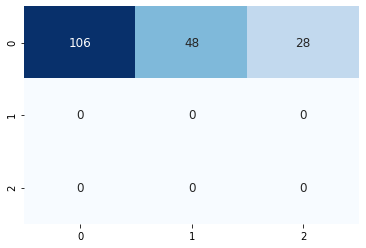

181/181 [==============================] - 0s 213us/sample - loss: 1.0329 - accuracy: 0.5691


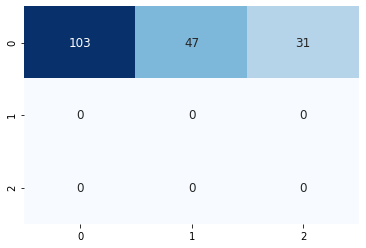

178/178 [==============================] - 0s 230us/sample - loss: 0.9298 - accuracy: 0.5843


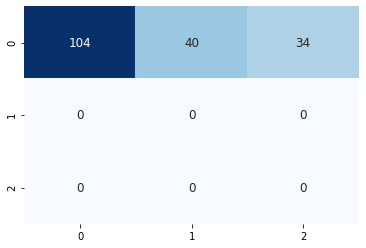

175/175 [==============================] - 0s 227us/sample - loss: 1.0666 - accuracy: 0.5657


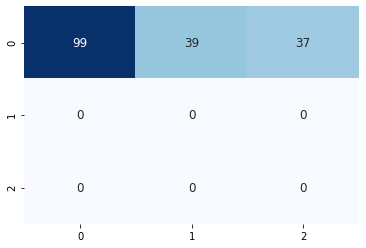

175/175 [==============================] - 0s 235us/sample - loss: 0.9053 - accuracy: 0.6286


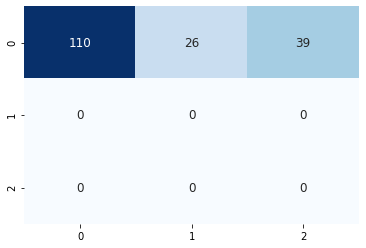

175/175 [==============================] - 0s 256us/sample - loss: 0.8732 - accuracy: 0.6400


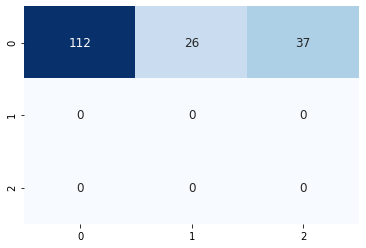

172/172 [==============================] - 0s 248us/sample - loss: 0.8760 - accuracy: 0.6453


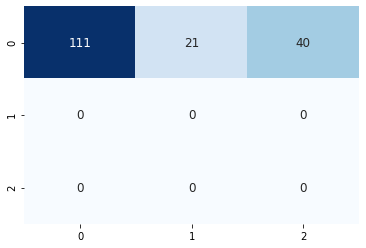

172/172 [==============================] - 0s 247us/sample - loss: 0.9567 - accuracy: 0.6163


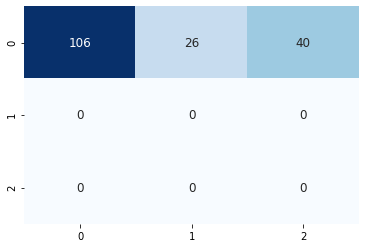

170/170 [==============================] - 0s 289us/sample - loss: 0.8851 - accuracy: 0.6706


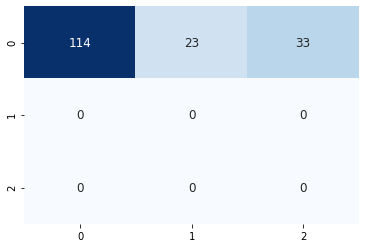

168/168 [==============================] - 0s 236us/sample - loss: 0.7867 - accuracy: 0.7024


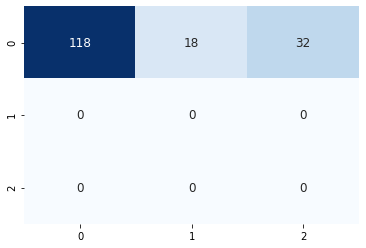

168/168 [==============================] - 0s 266us/sample - loss: 0.7971 - accuracy: 0.7143


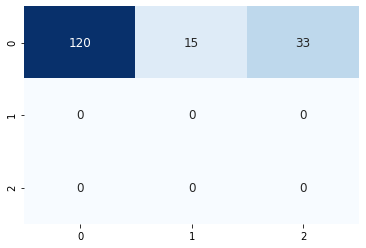

166/166 [==============================] - 0s 252us/sample - loss: 0.8258 - accuracy: 0.6747


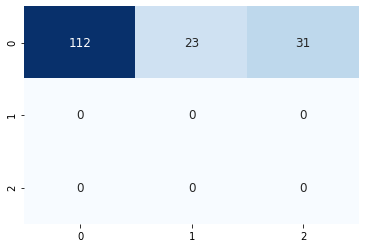

164/164 [==============================] - 0s 238us/sample - loss: 0.8001 - accuracy: 0.7134


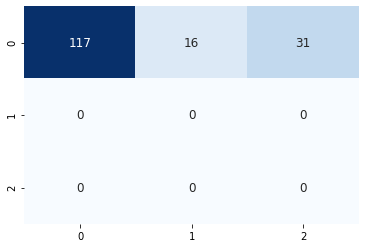

164/164 [==============================] - 0s 233us/sample - loss: 0.8030 - accuracy: 0.7195


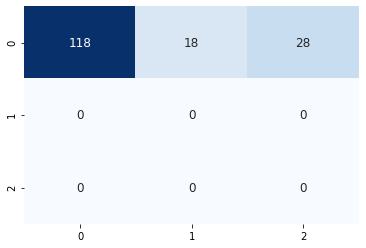

163/163 [==============================] - 0s 261us/sample - loss: 0.7402 - accuracy: 0.7485


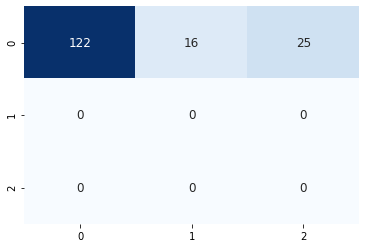

161/161 [==============================] - 0s 292us/sample - loss: 0.7788 - accuracy: 0.6770


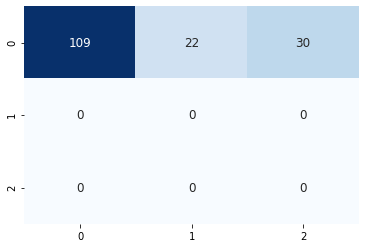

162/162 [==============================] - 0s 265us/sample - loss: 0.7033 - accuracy: 0.7407


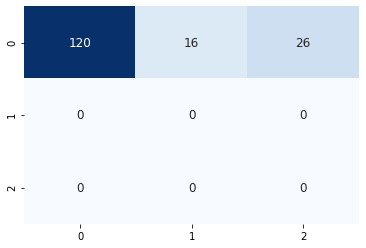

159/159 [==============================] - 0s 281us/sample - loss: 0.7959 - accuracy: 0.7233


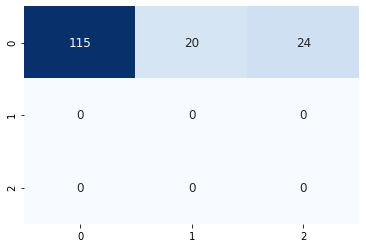

158/158 [==============================] - 0s 253us/sample - loss: 0.7670 - accuracy: 0.6899


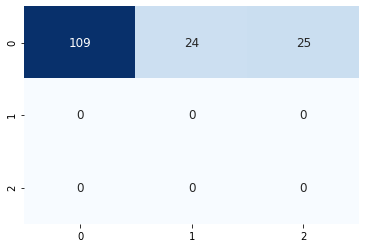

159/159 [==============================] - 0s 253us/sample - loss: 0.8025 - accuracy: 0.7233


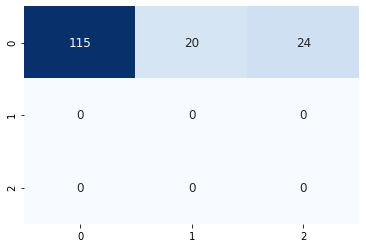

158/158 [==============================] - 0s 229us/sample - loss: 0.8533 - accuracy: 0.6962


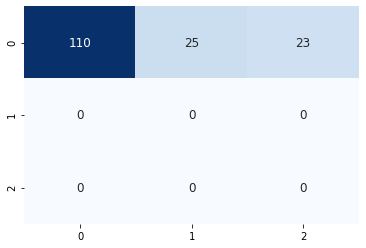

158/158 [==============================] - 0s 257us/sample - loss: 0.7683 - accuracy: 0.7215


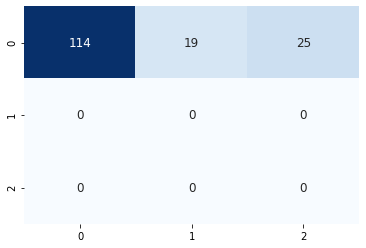

160/160 [==============================] - 0s 1ms/sample - loss: 0.7194 - accuracy: 0.7312


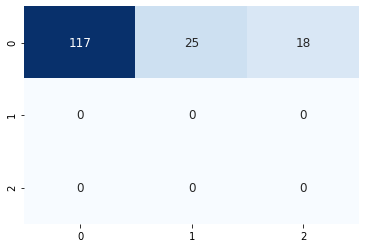

157/157 [==============================] - 0s 222us/sample - loss: 0.7288 - accuracy: 0.7580


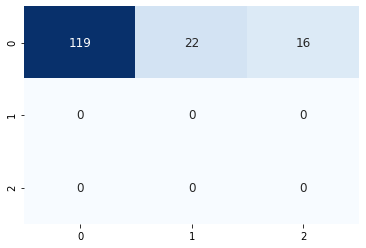

154/154 [==============================] - 0s 237us/sample - loss: 0.6722 - accuracy: 0.7727


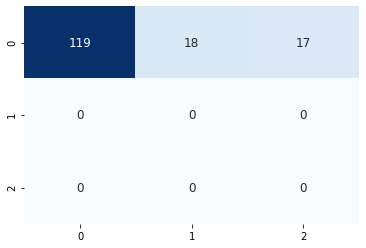

155/155 [==============================] - 0s 312us/sample - loss: 0.7341 - accuracy: 0.7677


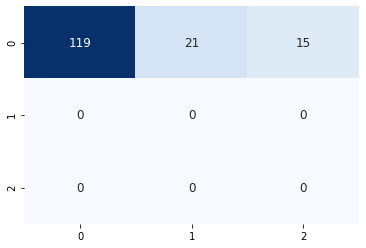

154/154 [==============================] - 0s 238us/sample - loss: 0.6592 - accuracy: 0.7857


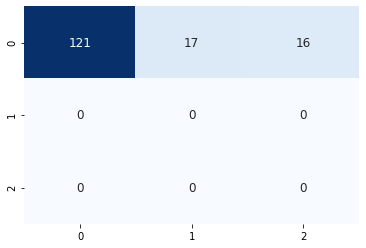

153/153 [==============================] - 0s 263us/sample - loss: 0.6956 - accuracy: 0.7582


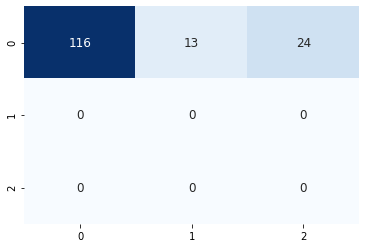

151/151 [==============================] - 0s 229us/sample - loss: 0.7250 - accuracy: 0.7417


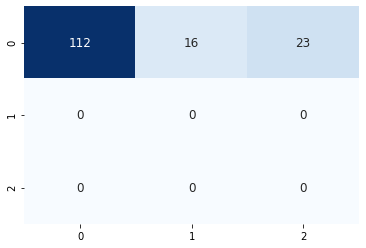

151/151 [==============================] - 0s 273us/sample - loss: 0.7152 - accuracy: 0.7550


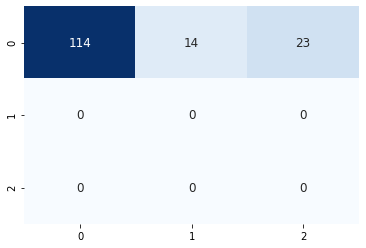

151/151 [==============================] - 0s 234us/sample - loss: 0.6811 - accuracy: 0.7748


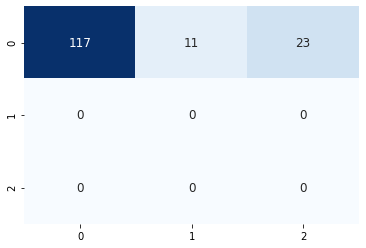

147/147 [==============================] - 0s 252us/sample - loss: 0.7096 - accuracy: 0.7687


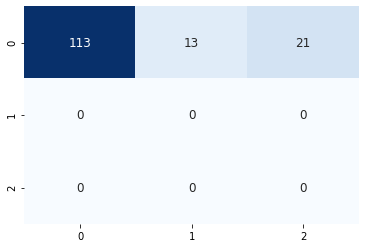

148/148 [==============================] - 0s 261us/sample - loss: 0.6856 - accuracy: 0.7230


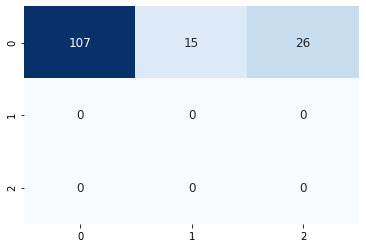

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3835 samples, validate on 1011 samples
Epoch 1/300
3835/3835 [==============================] - 3s 758us/sample - loss: 0.9941 - accuracy: 0.4245 - val_loss: 1.1015 - val_accuracy: 0.3719
Epoch 2/300
3835/3835 [==============================] - 1s 189us/sample - loss: 0.7647 - accuracy: 0.5851 - val_loss: 1.1535 - val_accuracy: 0.3947
Epoch 3/300
3835/3835 [==============================] - 1s 200us/sample - loss: 0.6154 - accuracy: 0.6446 - val_loss: 1.2532 - val_accuracy: 0.4174
Epoch 4/300
3835/3835 [==============================] - 1s 185us/sample - loss: 0.5131 - accuracy: 0.7163 - val_loss: 1.3553 - val_accuracy: 0.4451
Epoch 00004: early stopping
143/143 [==============================] - 0s 3ms/sample - loss: 0.8298 - accuracy: 0.6503


10it [4:05:27, 1509.84s/it]
100%|██████████| 3/3 [00:06<00:00,  2.20s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 281 steps, validate for 75 steps
Epoch 1/300
281/281 [==============================] - 29s 103ms/step - loss: 1.4501 - accuracy: 0.4131 - val_loss: 1.2349 - val_accuracy: 0.5008
Epoch 2/300
281/281 [==============================] - 27s 97ms/step - loss: 1.0505 - accuracy: 0.4737 - val_loss: 1.1848 - val_accuracy: 0.3646
Epoch 3/300
281/281 [==============================] - 28s 99ms/step - loss: 0.9913 - accuracy: 0.4962 - val_loss: 1.2759 - val_accuracy: 0.4102
Epoch 4/300
281/281 [==============================] - 28s 100ms/step - loss: 0.9677 - accuracy: 0.5139 - val_loss: 1.2815 - val_accuracy: 0.3967
Epoch 5/300
281/281 [==============================] - 28s 100ms/step - loss: 0.9514 - accuracy: 0.5238 - val_loss: 1.3116 - val_accuracy: 0.3868
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 281 steps, validate for 75 steps
Epoch 1/300
281/281 [===

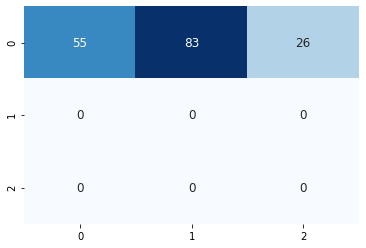

161/161 [==============================] - 0s 241us/sample - loss: 1.4020 - accuracy: 0.3602


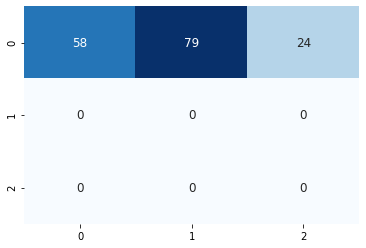

157/157 [==============================] - 0s 263us/sample - loss: 1.3390 - accuracy: 0.3631


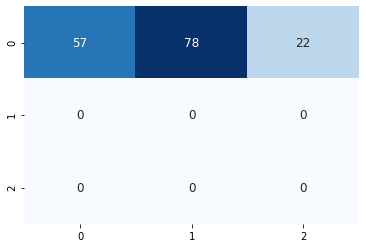

158/158 [==============================] - 0s 240us/sample - loss: 1.3220 - accuracy: 0.3418


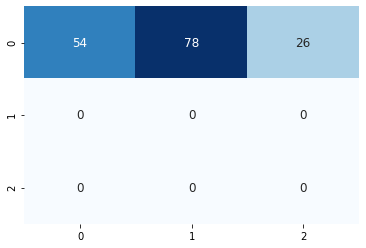

158/158 [==============================] - 0s 225us/sample - loss: 1.2933 - accuracy: 0.4367


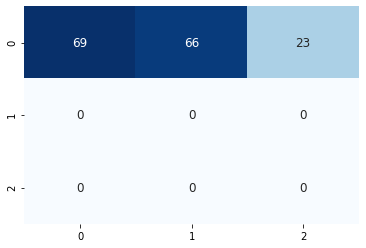

156/156 [==============================] - 0s 251us/sample - loss: 1.3791 - accuracy: 0.3718


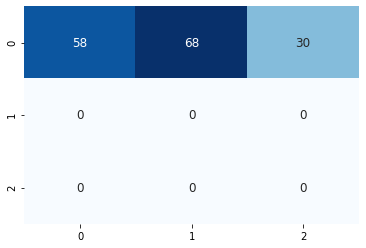

153/153 [==============================] - 0s 264us/sample - loss: 1.1862 - accuracy: 0.4444


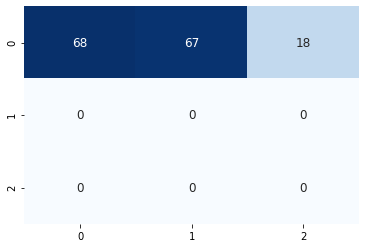

155/155 [==============================] - 0s 246us/sample - loss: 1.2606 - accuracy: 0.4452


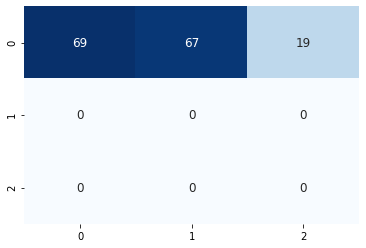

153/153 [==============================] - 0s 251us/sample - loss: 1.2165 - accuracy: 0.4510


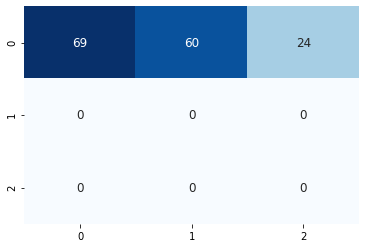

150/150 [==============================] - 0s 240us/sample - loss: 1.0848 - accuracy: 0.5000


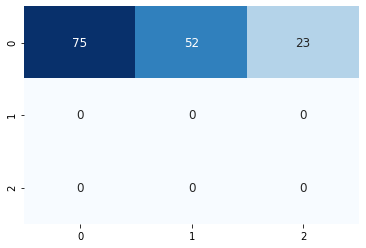

149/149 [==============================] - 0s 255us/sample - loss: 1.2086 - accuracy: 0.5101


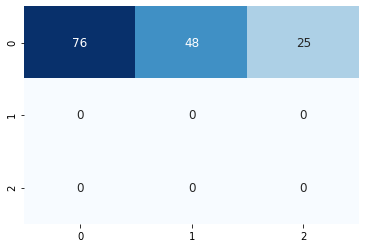

148/148 [==============================] - 0s 270us/sample - loss: 1.1445 - accuracy: 0.5473


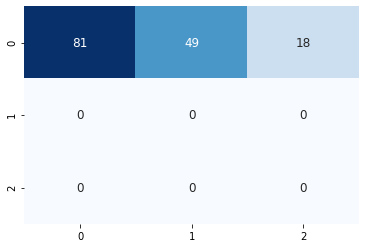

146/146 [==============================] - 0s 239us/sample - loss: 1.1623 - accuracy: 0.5068


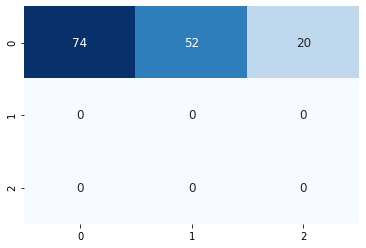

148/148 [==============================] - 0s 268us/sample - loss: 1.2600 - accuracy: 0.4662


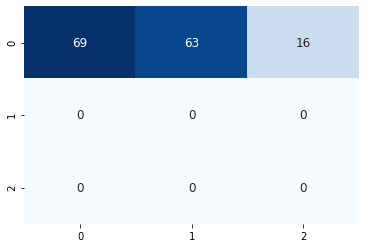

148/148 [==============================] - 0s 264us/sample - loss: 1.2047 - accuracy: 0.5203


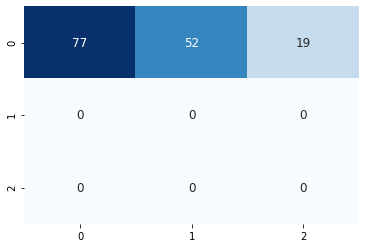

146/146 [==============================] - 0s 282us/sample - loss: 1.2429 - accuracy: 0.5000


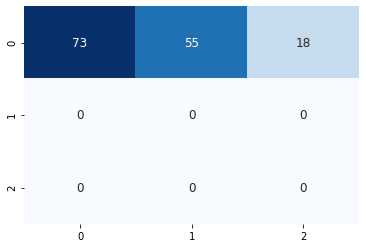

144/144 [==============================] - 0s 295us/sample - loss: 1.2426 - accuracy: 0.4514


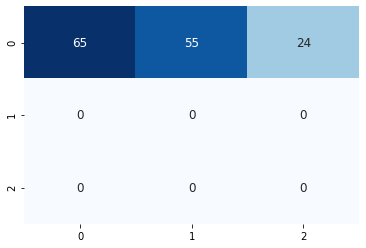

143/143 [==============================] - 0s 236us/sample - loss: 1.1701 - accuracy: 0.5105


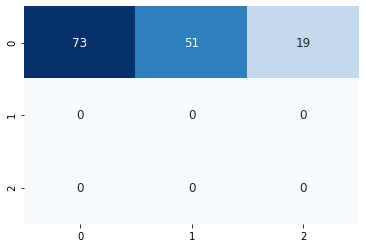

143/143 [==============================] - 0s 235us/sample - loss: 1.1176 - accuracy: 0.5105


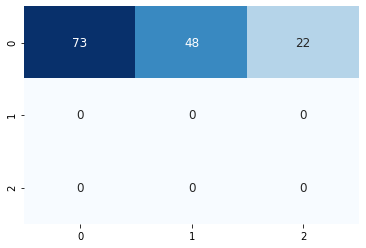

142/142 [==============================] - 0s 260us/sample - loss: 1.2160 - accuracy: 0.4859


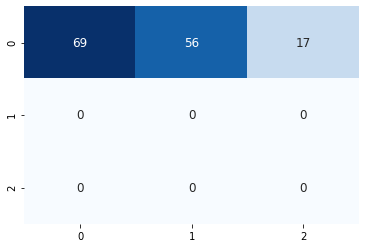

142/142 [==============================] - 0s 260us/sample - loss: 1.1701 - accuracy: 0.5845


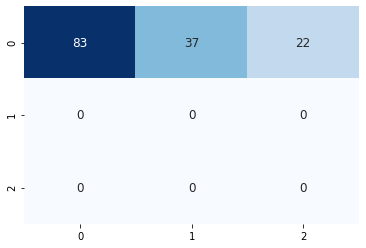

142/142 [==============================] - 0s 258us/sample - loss: 1.1739 - accuracy: 0.5282


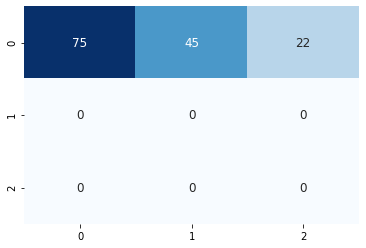

140/140 [==============================] - 0s 283us/sample - loss: 1.1206 - accuracy: 0.5714


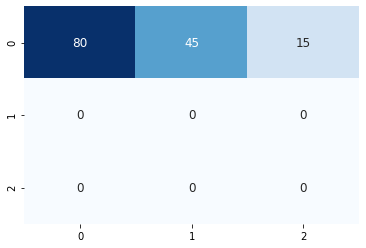

139/139 [==============================] - 0s 255us/sample - loss: 1.2521 - accuracy: 0.4820


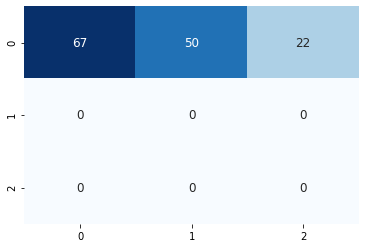

139/139 [==============================] - 0s 242us/sample - loss: 1.1534 - accuracy: 0.5396


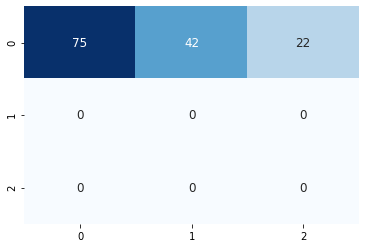

139/139 [==============================] - 0s 282us/sample - loss: 1.1259 - accuracy: 0.5468


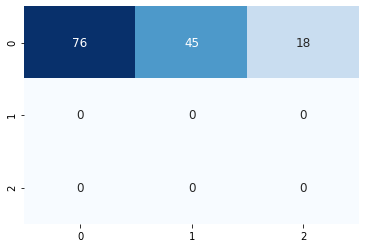

138/138 [==============================] - 0s 247us/sample - loss: 1.1333 - accuracy: 0.5290


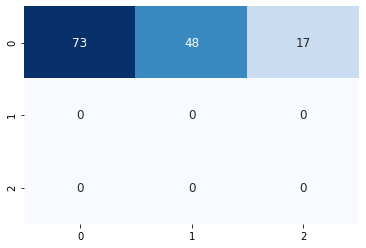

137/137 [==============================] - 0s 253us/sample - loss: 1.1586 - accuracy: 0.5109


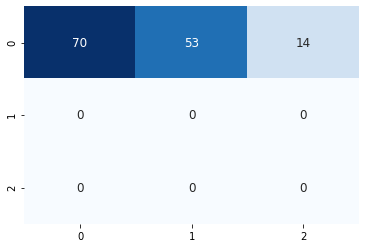

136/136 [==============================] - 0s 261us/sample - loss: 1.0685 - accuracy: 0.5515


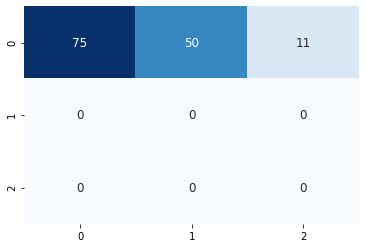

136/136 [==============================] - 0s 259us/sample - loss: 1.1348 - accuracy: 0.5074


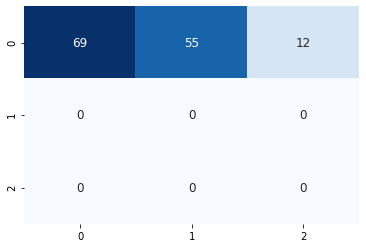

136/136 [==============================] - 0s 274us/sample - loss: 1.2563 - accuracy: 0.5000


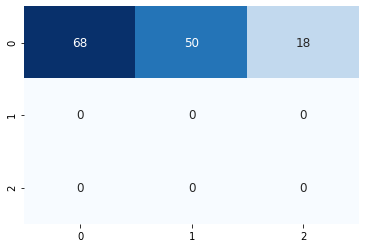

136/136 [==============================] - 0s 323us/sample - loss: 1.1460 - accuracy: 0.5588


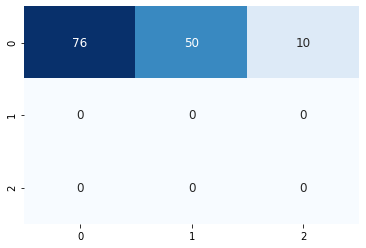

134/134 [==============================] - 0s 299us/sample - loss: 1.1394 - accuracy: 0.5373


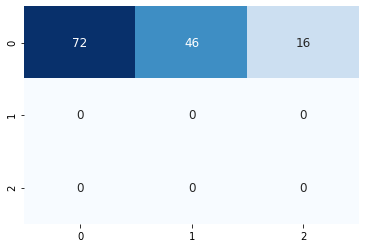

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3845 samples, validate on 1011 samples
Epoch 1/300
3845/3845 [==============================] - 3s 740us/sample - loss: 0.9584 - accuracy: 0.5438 - val_loss: 1.1068 - val_accuracy: 0.4411
Epoch 2/300
3845/3845 [==============================] - 1s 199us/sample - loss: 0.7090 - accuracy: 0.6809 - val_loss: 1.1580 - val_accuracy: 0.4362
Epoch 3/300
3845/3845 [==============================] - 1s 208us/sample - loss: 0.5508 - accuracy: 0.7423 - val_loss: 1.2557 - val_accuracy: 0.4520
Epoch 4/300
3845/3845 [==============================] - 1s 221us/sample - loss: 0.4321 - accuracy: 0.8055 - val_loss: 1.3696 - val_accuracy: 0.4718
Epoch 00004: early stopping
133/133 [==============================] - 0s 3ms/sample - loss: 1.0433 - accuracy: 0.5940


11it [4:28:17, 1467.95s/it]
100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 74 steps
Epoch 1/300
283/283 [==============================] - 29s 103ms/step - loss: 1.4432 - accuracy: 0.4268 - val_loss: 1.2327 - val_accuracy: 0.3805
Epoch 2/300
283/283 [==============================] - 28s 100ms/step - loss: 1.0466 - accuracy: 0.4794 - val_loss: 1.1926 - val_accuracy: 0.3631
Epoch 3/300
283/283 [==============================] - 28s 100ms/step - loss: 0.9887 - accuracy: 0.4995 - val_loss: 1.2665 - val_accuracy: 0.4051
Epoch 4/300
283/283 [==============================] - 28s 100ms/step - loss: 0.9604 - accuracy: 0.5177 - val_loss: 1.2908 - val_accuracy: 0.4590
Epoch 5/300
283/283 [==============================] - 28s 101ms/step - loss: 0.9460 - accuracy: 0.5272 - val_loss: 1.2848 - val_accuracy: 0.4082
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 74 steps
Epoch 1/300
283/283 [=

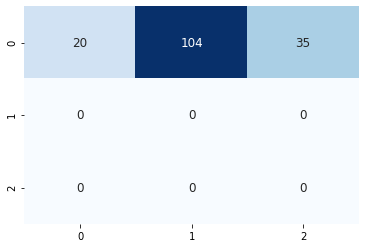

147/147 [==============================] - 0s 244us/sample - loss: 2.5421 - accuracy: 0.1224


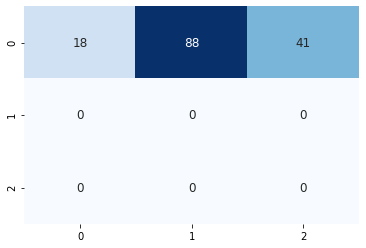

144/144 [==============================] - 0s 229us/sample - loss: 2.6394 - accuracy: 0.1528


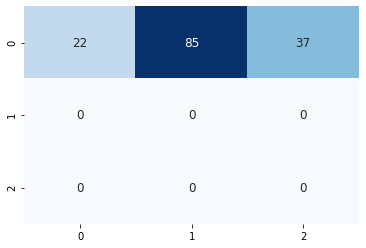

141/141 [==============================] - 0s 249us/sample - loss: 2.5460 - accuracy: 0.1844


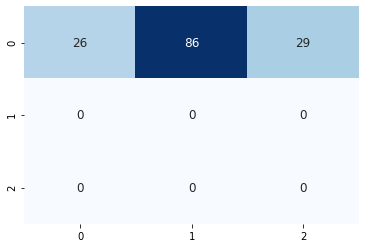

140/140 [==============================] - 0s 263us/sample - loss: 2.6772 - accuracy: 0.1429


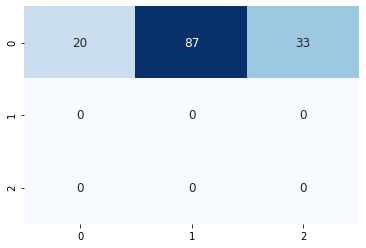

140/140 [==============================] - 0s 260us/sample - loss: 2.6909 - accuracy: 0.1000


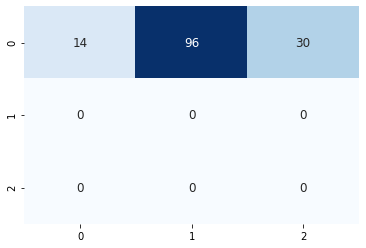

138/138 [==============================] - 0s 252us/sample - loss: 2.6365 - accuracy: 0.1812


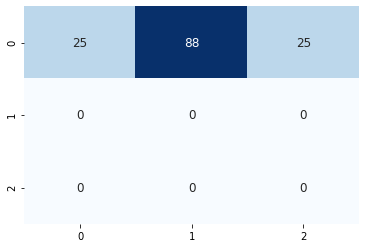

134/134 [==============================] - 0s 240us/sample - loss: 2.7992 - accuracy: 0.1045


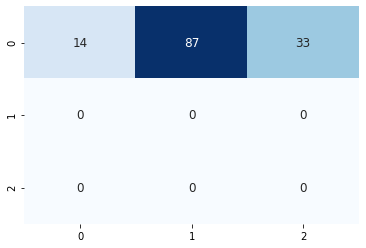

135/135 [==============================] - 0s 236us/sample - loss: 2.8386 - accuracy: 0.1111


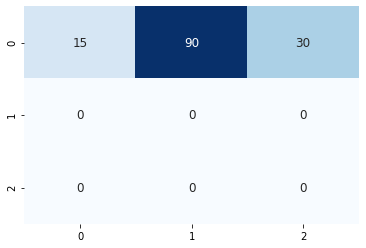

135/135 [==============================] - 0s 263us/sample - loss: 2.8476 - accuracy: 0.1037


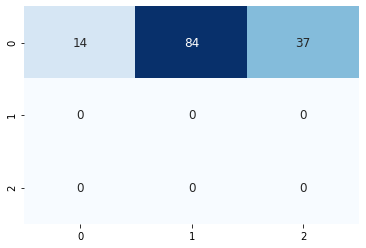

134/134 [==============================] - 0s 252us/sample - loss: 2.8327 - accuracy: 0.0896


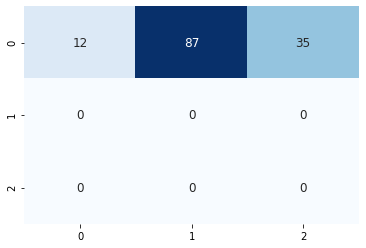

134/134 [==============================] - 0s 247us/sample - loss: 2.9131 - accuracy: 0.1045


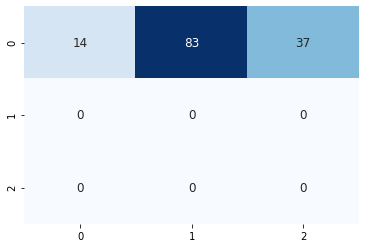

135/135 [==============================] - 0s 240us/sample - loss: 3.0438 - accuracy: 0.0815


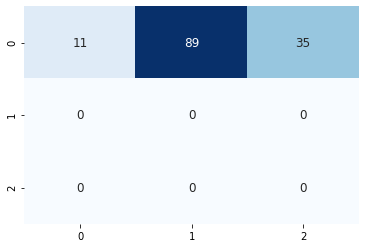

132/132 [==============================] - 0s 262us/sample - loss: 2.7624 - accuracy: 0.1136


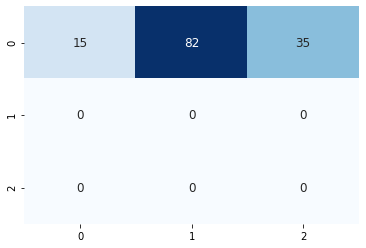

132/132 [==============================] - 0s 279us/sample - loss: 2.6442 - accuracy: 0.1212


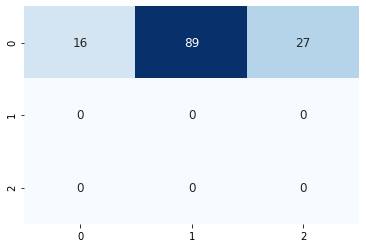

131/131 [==============================] - 0s 251us/sample - loss: 2.6557 - accuracy: 0.1221


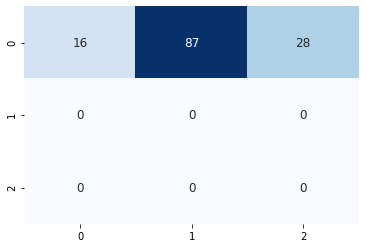

130/130 [==============================] - 0s 260us/sample - loss: 2.7825 - accuracy: 0.1615


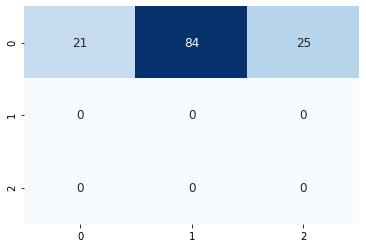

130/130 [==============================] - 0s 315us/sample - loss: 2.7162 - accuracy: 0.1000


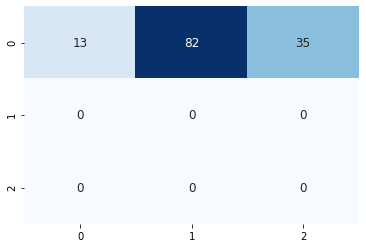

129/129 [==============================] - 0s 330us/sample - loss: 2.7098 - accuracy: 0.1473


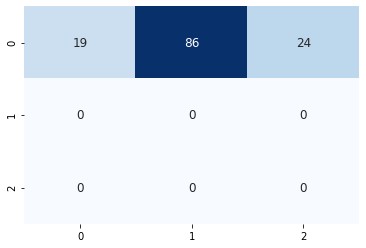

127/127 [==============================] - 0s 247us/sample - loss: 2.5752 - accuracy: 0.1417


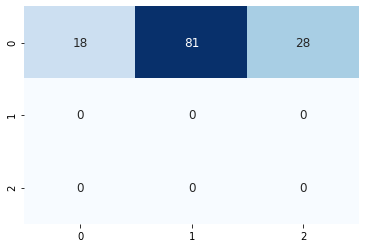

127/127 [==============================] - 0s 267us/sample - loss: 2.5278 - accuracy: 0.1260


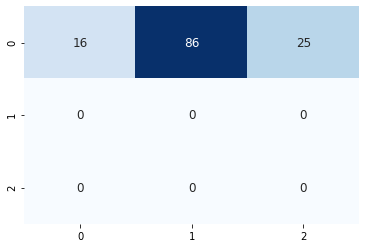

128/128 [==============================] - 0s 2ms/sample - loss: 2.7946 - accuracy: 0.1328


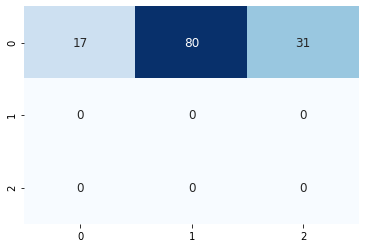

127/127 [==============================] - 0s 271us/sample - loss: 2.7008 - accuracy: 0.1339


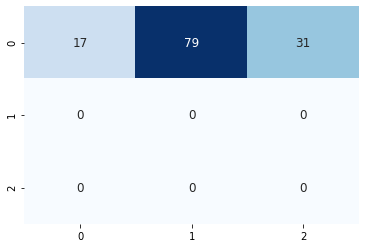

127/127 [==============================] - 0s 280us/sample - loss: 2.6094 - accuracy: 0.1102


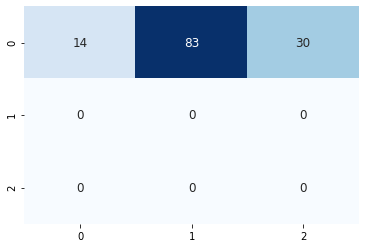

126/126 [==============================] - 0s 307us/sample - loss: 2.6663 - accuracy: 0.1349


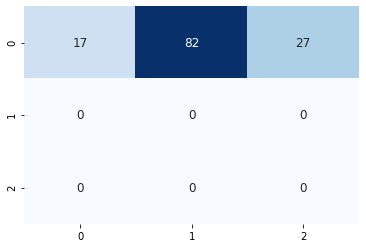

126/126 [==============================] - 0s 251us/sample - loss: 2.4704 - accuracy: 0.1667


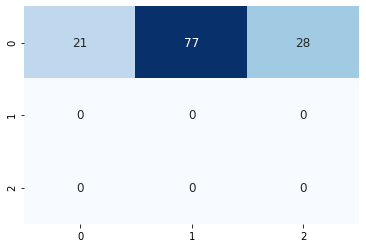

122/122 [==============================] - 0s 237us/sample - loss: 2.6878 - accuracy: 0.1230


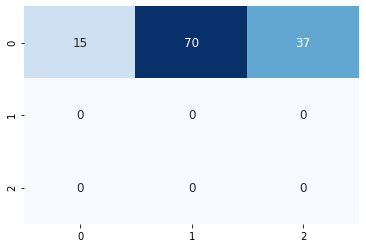

122/122 [==============================] - 0s 256us/sample - loss: 2.6221 - accuracy: 0.1230


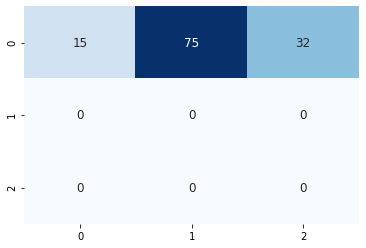

123/123 [==============================] - 0s 299us/sample - loss: 2.7232 - accuracy: 0.0813


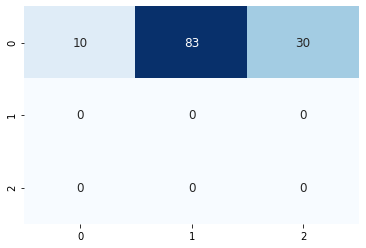

122/122 [==============================] - 0s 274us/sample - loss: 2.6157 - accuracy: 0.1803


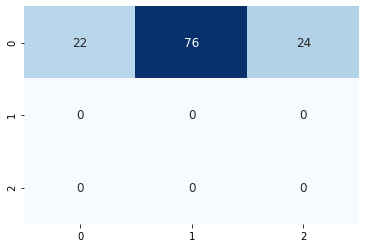

122/122 [==============================] - 0s 270us/sample - loss: 2.7156 - accuracy: 0.1311


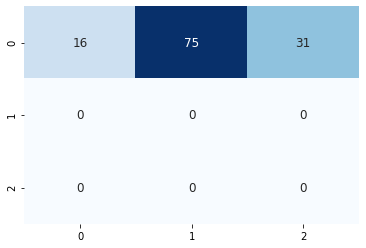

122/122 [==============================] - 0s 276us/sample - loss: 2.8907 - accuracy: 0.1393


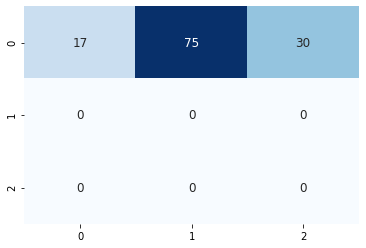

121/121 [==============================] - 0s 257us/sample - loss: 2.5405 - accuracy: 0.1736


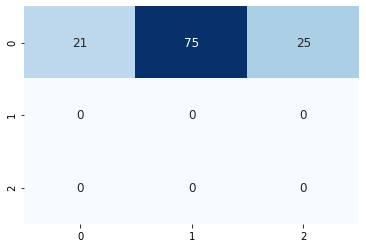

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3866 samples, validate on 1004 samples
Epoch 1/300
3866/3866 [==============================] - 3s 721us/sample - loss: 0.9544 - accuracy: 0.4886 - val_loss: 1.1379 - val_accuracy: 0.3884
Epoch 2/300
3866/3866 [==============================] - 1s 238us/sample - loss: 0.7192 - accuracy: 0.6583 - val_loss: 1.1943 - val_accuracy: 0.4213
Epoch 3/300
3866/3866 [==============================] - 1s 222us/sample - loss: 0.5657 - accuracy: 0.7375 - val_loss: 1.2891 - val_accuracy: 0.4522
Epoch 4/300
3866/3866 [==============================] - 1s 236us/sample - loss: 0.4424 - accuracy: 0.8044 - val_loss: 1.3922 - val_accuracy: 0.4741
Epoch 00004: early stopping
119/119 [==============================] - 1s 7ms/sample - loss: 2.1727 - accuracy: 0.2101


12it [4:56:55, 1484.65s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 291 steps, validate for 68 steps
Epoch 1/300
291/291 [==============================] - 30s 102ms/step - loss: 1.4299 - accuracy: 0.4190 - val_loss: 1.1864 - val_accuracy: 0.4346
Epoch 2/300
291/291 [==============================] - 28s 97ms/step - loss: 1.0441 - accuracy: 0.4857 - val_loss: 1.1691 - val_accuracy: 0.3724
Epoch 3/300
291/291 [==============================] - 28s 98ms/step - loss: 0.9906 - accuracy: 0.5089 - val_loss: 1.1761 - val_accuracy: 0.3712
Epoch 4/300
291/291 [==============================] - 28s 98ms/step - loss: 0.9689 - accuracy: 0.5227 - val_loss: 1.2098 - val_accuracy: 0.4149
Epoch 5/300
291/291 [==============================] - 28s 97ms/step - loss: 0.9558 - accuracy: 0.5319 - val_loss: 1.2221 - val_accuracy: 0.3871
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 291 steps, validate for 68 steps
Epoch 1/300
291/291 [=====

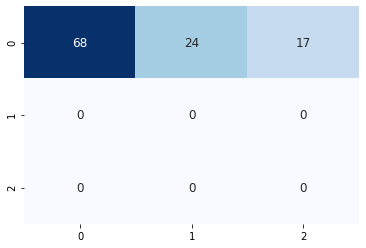

107/107 [==============================] - 0s 246us/sample - loss: 1.1615 - accuracy: 0.5327


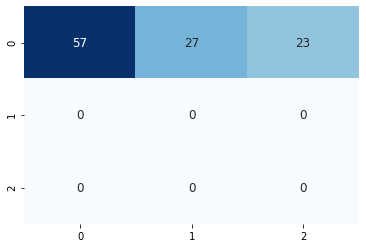

103/103 [==============================] - 0s 275us/sample - loss: 1.1111 - accuracy: 0.5437


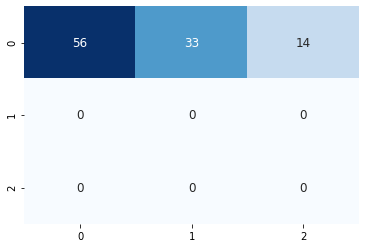

99/99 [==============================] - 0s 301us/sample - loss: 0.9418 - accuracy: 0.6162


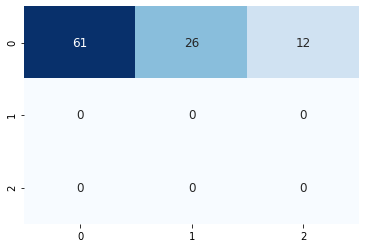

99/99 [==============================] - 0s 278us/sample - loss: 1.0922 - accuracy: 0.6162


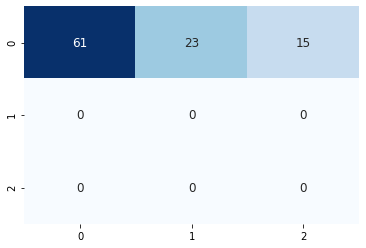

99/99 [==============================] - 0s 342us/sample - loss: 0.9836 - accuracy: 0.6263


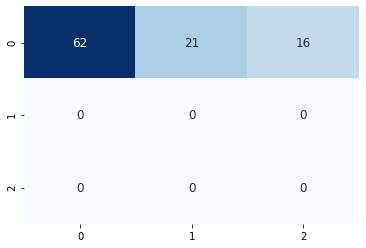

99/99 [==============================] - 0s 273us/sample - loss: 1.0060 - accuracy: 0.6465


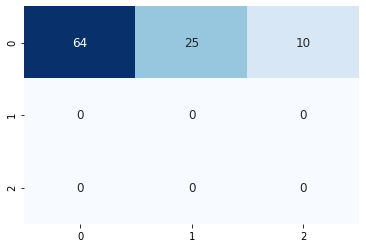

98/98 [==============================] - 0s 270us/sample - loss: 0.9406 - accuracy: 0.6429


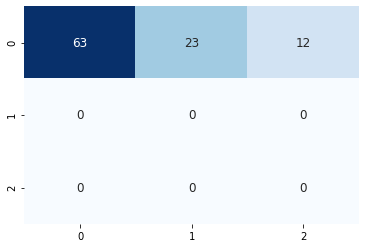

98/98 [==============================] - 0s 375us/sample - loss: 1.0392 - accuracy: 0.6531


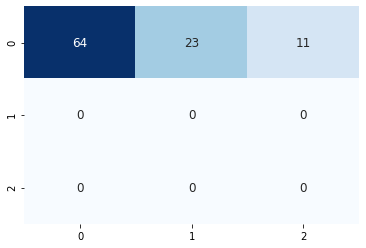

97/97 [==============================] - 0s 273us/sample - loss: 1.0403 - accuracy: 0.5979


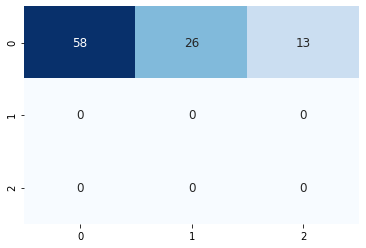

97/97 [==============================] - 0s 261us/sample - loss: 1.1431 - accuracy: 0.6082


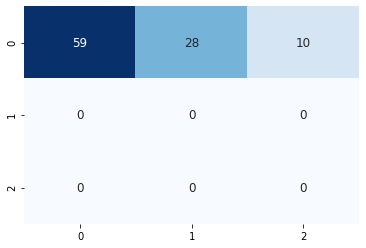

97/97 [==============================] - 0s 273us/sample - loss: 1.1027 - accuracy: 0.5979


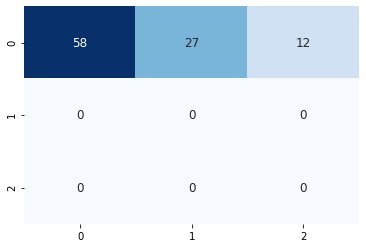

96/96 [==============================] - 0s 2ms/sample - loss: 1.0024 - accuracy: 0.5833


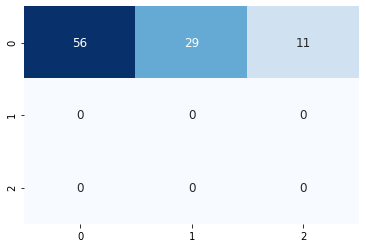

97/97 [==============================] - 0s 293us/sample - loss: 1.0026 - accuracy: 0.6289


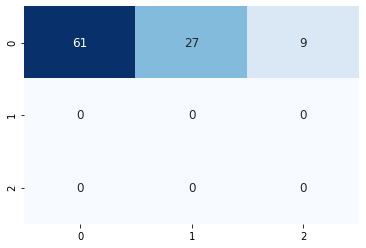

95/95 [==============================] - 0s 257us/sample - loss: 1.0822 - accuracy: 0.5895


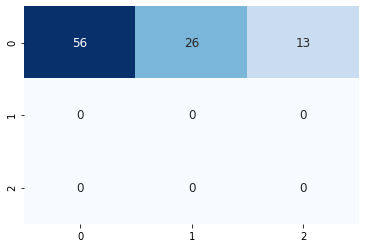

95/95 [==============================] - 0s 253us/sample - loss: 1.1445 - accuracy: 0.5684


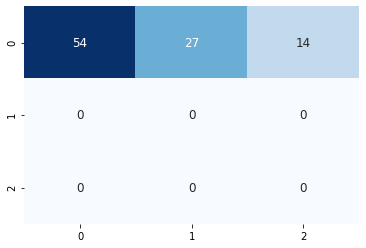

94/94 [==============================] - 0s 277us/sample - loss: 0.9895 - accuracy: 0.6915


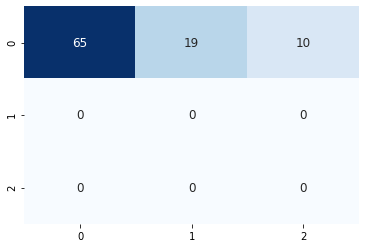

95/95 [==============================] - 0s 259us/sample - loss: 1.0771 - accuracy: 0.5895


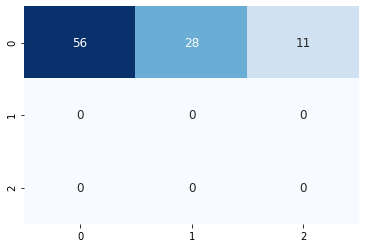

93/93 [==============================] - 0s 268us/sample - loss: 1.1344 - accuracy: 0.5914


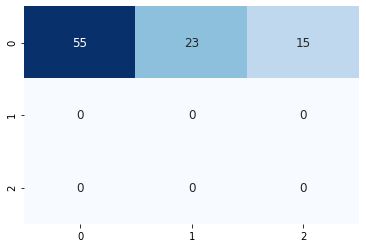

93/93 [==============================] - 0s 283us/sample - loss: 1.0557 - accuracy: 0.6344


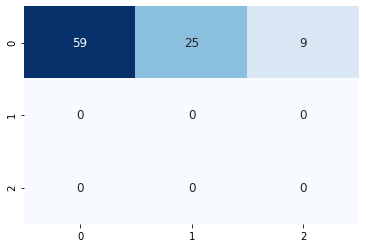

93/93 [==============================] - 0s 254us/sample - loss: 1.2737 - accuracy: 0.5269


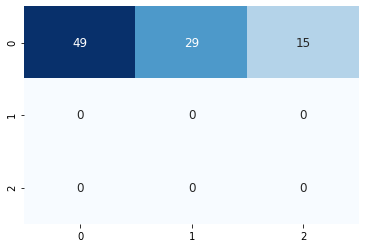

92/92 [==============================] - 0s 266us/sample - loss: 1.1853 - accuracy: 0.5435


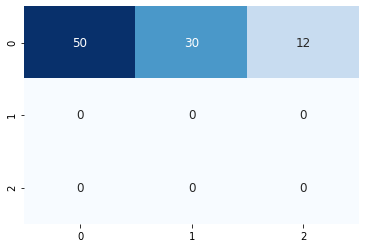

91/91 [==============================] - 0s 267us/sample - loss: 1.0279 - accuracy: 0.5824


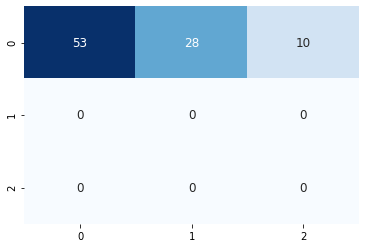

90/90 [==============================] - 0s 276us/sample - loss: 1.0562 - accuracy: 0.6000


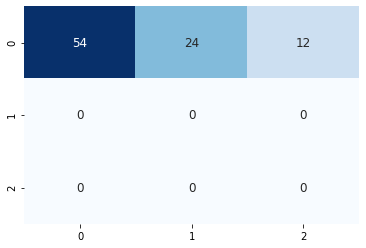

90/90 [==============================] - 0s 277us/sample - loss: 1.0604 - accuracy: 0.6000


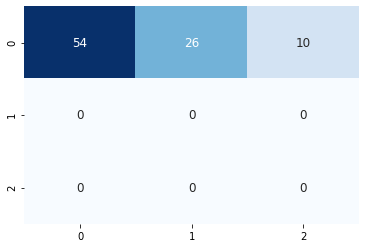

91/91 [==============================] - 0s 300us/sample - loss: 1.0439 - accuracy: 0.6044


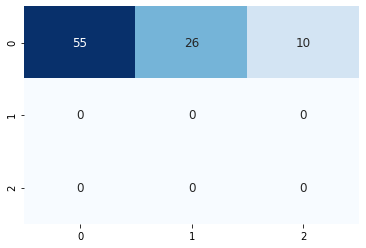

91/91 [==============================] - 0s 306us/sample - loss: 1.1505 - accuracy: 0.5824


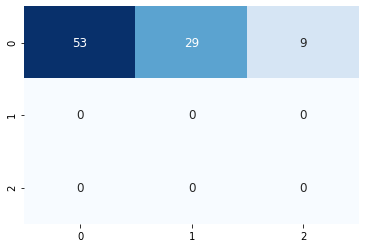

89/89 [==============================] - 0s 256us/sample - loss: 1.1760 - accuracy: 0.5056


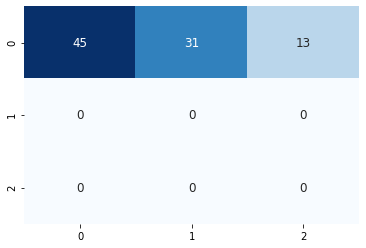

89/89 [==============================] - 0s 276us/sample - loss: 1.2268 - accuracy: 0.5506


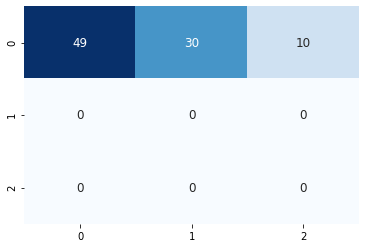

88/88 [==============================] - 0s 260us/sample - loss: 1.1783 - accuracy: 0.5795


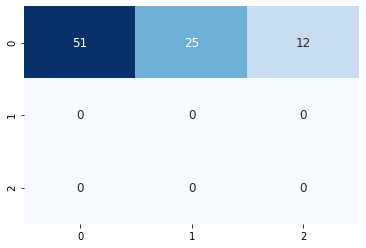

86/86 [==============================] - 0s 275us/sample - loss: 1.0051 - accuracy: 0.6047


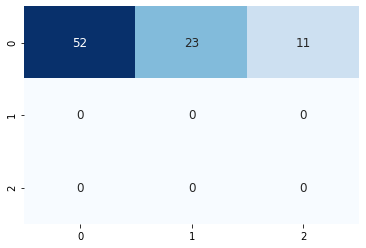

86/86 [==============================] - 0s 260us/sample - loss: 1.1681 - accuracy: 0.6395


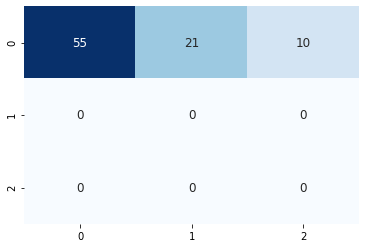

86/86 [==============================] - 0s 281us/sample - loss: 1.1740 - accuracy: 0.5698


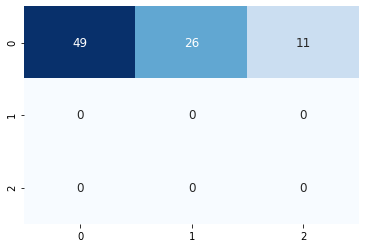

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3964 samples, validate on 943 samples
Epoch 1/300
3964/3964 [==============================] - 3s 720us/sample - loss: 0.8961 - accuracy: 0.6256 - val_loss: 1.1064 - val_accuracy: 0.4454
Epoch 2/300
3964/3964 [==============================] - 1s 196us/sample - loss: 0.5518 - accuracy: 0.8027 - val_loss: 1.2673 - val_accuracy: 0.4740
Epoch 3/300
3964/3964 [==============================] - 1s 165us/sample - loss: 0.3552 - accuracy: 0.8802 - val_loss: 1.4902 - val_accuracy: 0.4942
Epoch 4/300
3964/3964 [==============================] - 1s 181us/sample - loss: 0.2490 - accuracy: 0.9170 - val_loss: 1.7299 - val_accuracy: 0.5027
Epoch 00004: early stopping
82/82 [==============================] - 1s 9ms/sample - loss: 1.1941 - accuracy: 0.5366


1it [26:17, 1577.42s/it]
100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 68 steps
Epoch 1/300
289/289 [==============================] - 29s 101ms/step - loss: 1.4760 - accuracy: 0.4403 - val_loss: 1.2253 - val_accuracy: 0.4141
Epoch 2/300
289/289 [==============================] - 29s 99ms/step - loss: 1.0522 - accuracy: 0.4986 - val_loss: 1.1699 - val_accuracy: 0.4255
Epoch 3/300
289/289 [==============================] - 28s 97ms/step - loss: 0.9866 - accuracy: 0.5190 - val_loss: 1.1931 - val_accuracy: 0.3994
Epoch 4/300
289/289 [==============================] - 28s 97ms/step - loss: 0.9629 - accuracy: 0.5335 - val_loss: 1.1984 - val_accuracy: 0.3943
Epoch 5/300
289/289 [==============================] - 28s 98ms/step - loss: 0.9448 - accuracy: 0.5456 - val_loss: 1.2395 - val_accuracy: 0.3723
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 68 steps
Epoch 1/300
289/289 [=====

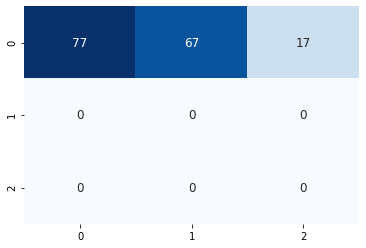

155/155 [==============================] - 0s 230us/sample - loss: 1.2655 - accuracy: 0.3871


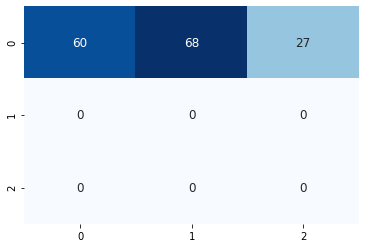

153/153 [==============================] - 0s 250us/sample - loss: 1.1964 - accuracy: 0.4379


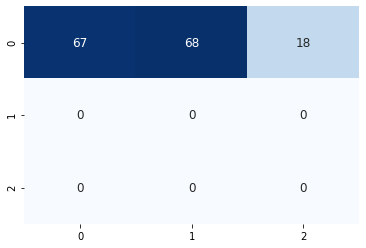

154/154 [==============================] - 0s 234us/sample - loss: 1.2882 - accuracy: 0.4416


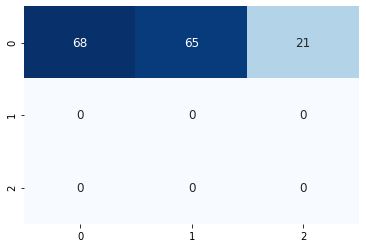

151/151 [==============================] - 0s 213us/sample - loss: 1.1979 - accuracy: 0.4437


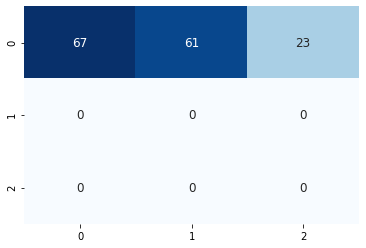

147/147 [==============================] - 0s 239us/sample - loss: 1.1442 - accuracy: 0.3946


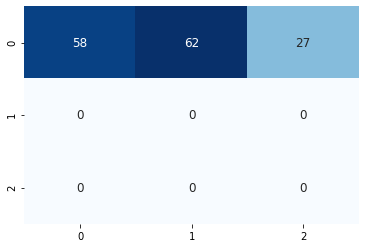

144/144 [==============================] - 0s 242us/sample - loss: 1.2264 - accuracy: 0.4653


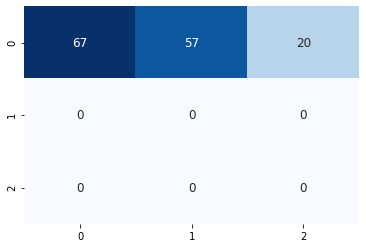

143/143 [==============================] - 0s 253us/sample - loss: 1.2091 - accuracy: 0.4336


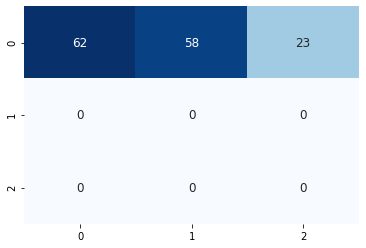

145/145 [==============================] - 0s 265us/sample - loss: 1.1739 - accuracy: 0.4552


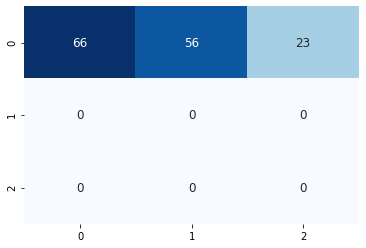

143/143 [==============================] - 0s 267us/sample - loss: 1.2153 - accuracy: 0.4825


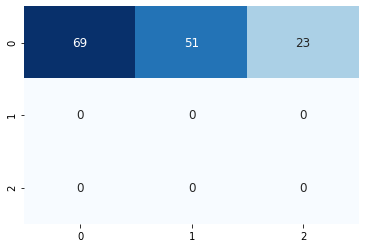

142/142 [==============================] - 0s 289us/sample - loss: 1.3087 - accuracy: 0.4296


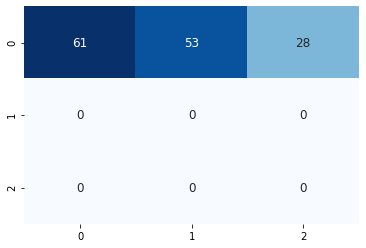

142/142 [==============================] - 0s 250us/sample - loss: 1.2830 - accuracy: 0.4859


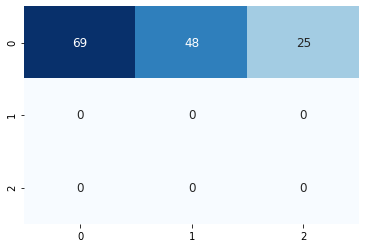

142/142 [==============================] - 0s 309us/sample - loss: 1.3332 - accuracy: 0.3873


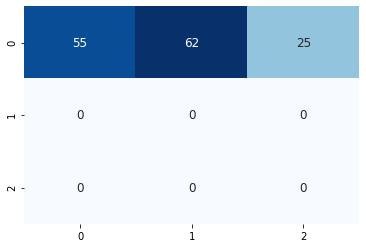

141/141 [==============================] - 0s 254us/sample - loss: 1.3191 - accuracy: 0.3972


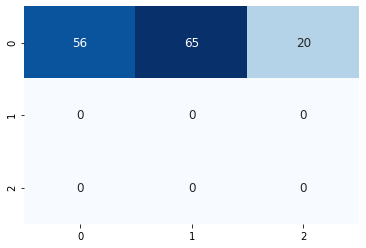

141/141 [==============================] - 0s 256us/sample - loss: 1.2515 - accuracy: 0.4184


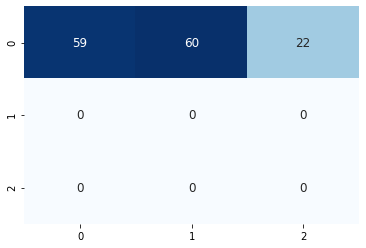

139/139 [==============================] - 0s 280us/sample - loss: 1.3006 - accuracy: 0.4173


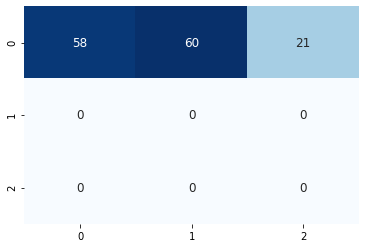

139/139 [==============================] - 0s 242us/sample - loss: 1.2611 - accuracy: 0.4245


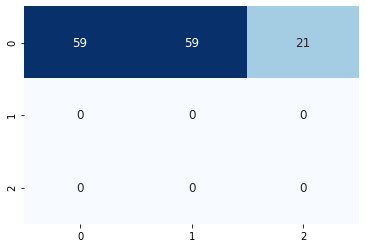

137/137 [==============================] - 0s 253us/sample - loss: 1.2826 - accuracy: 0.4161


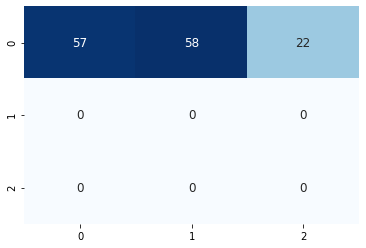

139/139 [==============================] - 0s 250us/sample - loss: 1.3496 - accuracy: 0.3741


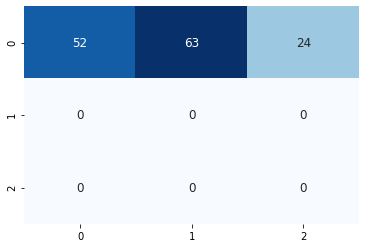

137/137 [==============================] - 0s 264us/sample - loss: 1.3004 - accuracy: 0.4015


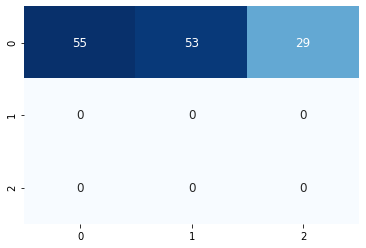

138/138 [==============================] - 0s 253us/sample - loss: 1.2866 - accuracy: 0.4203


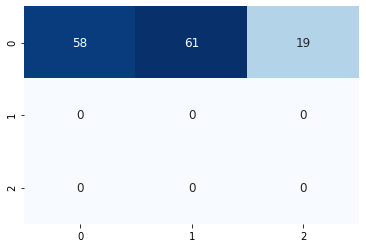

137/137 [==============================] - 0s 281us/sample - loss: 1.3705 - accuracy: 0.3942


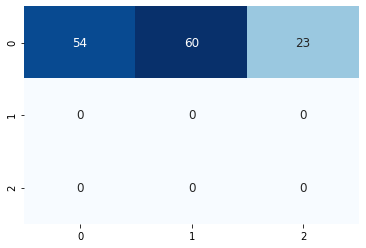

138/138 [==============================] - 0s 289us/sample - loss: 1.4598 - accuracy: 0.3623


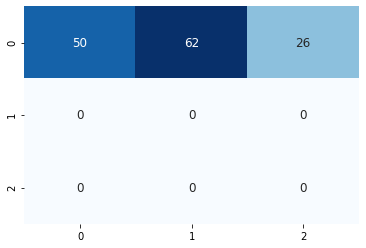

137/137 [==============================] - 0s 256us/sample - loss: 1.4409 - accuracy: 0.3358


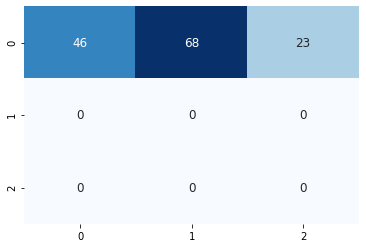

137/137 [==============================] - 0s 237us/sample - loss: 1.4535 - accuracy: 0.3358


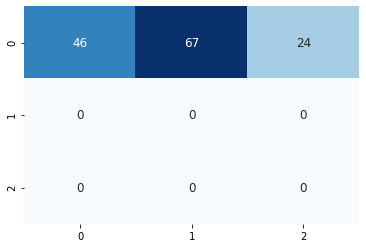

138/138 [==============================] - 0s 249us/sample - loss: 1.3970 - accuracy: 0.4203


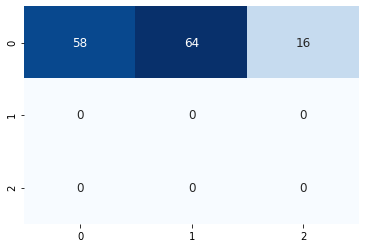

137/137 [==============================] - 0s 257us/sample - loss: 1.4814 - accuracy: 0.3650


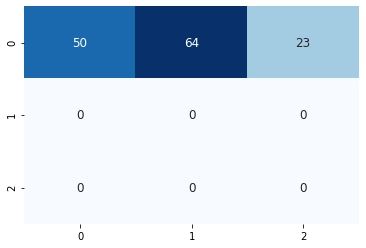

137/137 [==============================] - 0s 248us/sample - loss: 1.4190 - accuracy: 0.3942


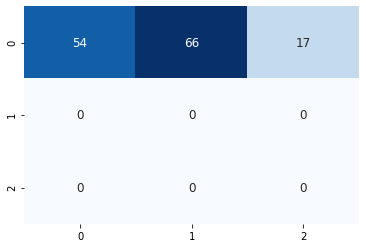

134/134 [==============================] - 0s 255us/sample - loss: 1.4269 - accuracy: 0.4403


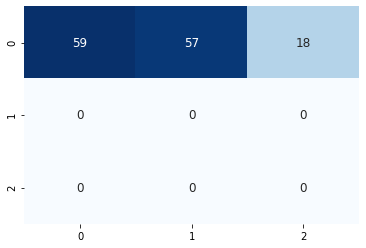

134/134 [==============================] - 0s 250us/sample - loss: 1.4268 - accuracy: 0.3657


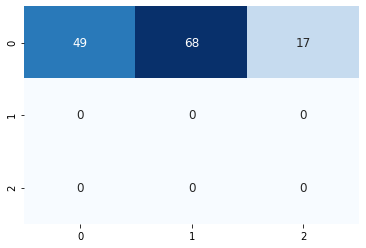

133/133 [==============================] - 0s 270us/sample - loss: 1.4451 - accuracy: 0.3684


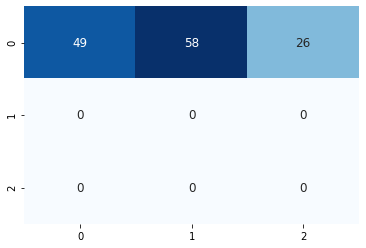

131/131 [==============================] - 0s 285us/sample - loss: 1.3931 - accuracy: 0.3206


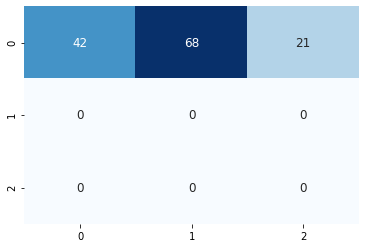

130/130 [==============================] - 0s 283us/sample - loss: 1.5797 - accuracy: 0.3231


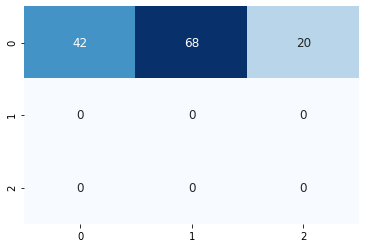

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3926 samples, validate on 939 samples
Epoch 1/300
3926/3926 [==============================] - 3s 764us/sample - loss: 0.9059 - accuracy: 0.5866 - val_loss: 1.0998 - val_accuracy: 0.4686
Epoch 2/300
3926/3926 [==============================] - 1s 215us/sample - loss: 0.6015 - accuracy: 0.7654 - val_loss: 1.2346 - val_accuracy: 0.4686
Epoch 3/300
3926/3926 [==============================] - 1s 230us/sample - loss: 0.4241 - accuracy: 0.8423 - val_loss: 1.4189 - val_accuracy: 0.4899
Epoch 4/300
3926/3926 [==============================] - 1s 215us/sample - loss: 0.3260 - accuracy: 0.8734 - val_loss: 1.5724 - val_accuracy: 0.4899
Epoch 00004: early stopping
124/124 [==============================] - 0s 4ms/sample - loss: 1.9276 - accuracy: 0.1774


2it [54:40, 1615.26s/it]
100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 291 steps, validate for 67 steps
Epoch 1/300
291/291 [==============================] - 29s 100ms/step - loss: 1.4500 - accuracy: 0.4249 - val_loss: 1.1923 - val_accuracy: 0.3647
Epoch 2/300
291/291 [==============================] - 28s 96ms/step - loss: 1.0476 - accuracy: 0.4830 - val_loss: 1.1572 - val_accuracy: 0.3603
Epoch 3/300
291/291 [==============================] - 28s 97ms/step - loss: 0.9901 - accuracy: 0.5065 - val_loss: 1.1556 - val_accuracy: 0.3641
Epoch 4/300
291/291 [==============================] - 28s 97ms/step - loss: 0.9664 - accuracy: 0.5227 - val_loss: 1.1956 - val_accuracy: 0.3613
Epoch 5/300
291/291 [==============================] - 28s 98ms/step - loss: 0.9491 - accuracy: 0.5345 - val_loss: 1.2611 - val_accuracy: 0.3581
Epoch 6/300
291/291 [==============================] - 28s 97ms/step - loss: 0.9407 - accuracy: 0.5433 - val_loss: 1.2148 - val_accuracy: 0.3683
Ep

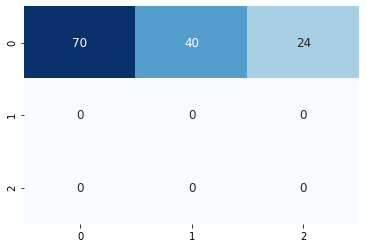

126/126 [==============================] - 0s 378us/sample - loss: 1.2812 - accuracy: 0.4841


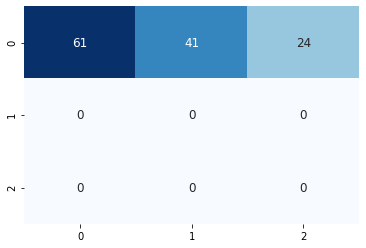

121/121 [==============================] - 0s 243us/sample - loss: 1.2341 - accuracy: 0.4793


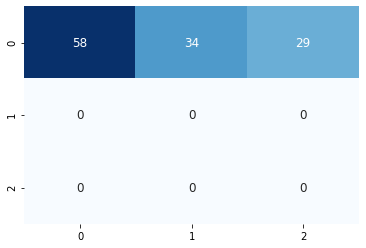

120/120 [==============================] - 0s 225us/sample - loss: 1.2458 - accuracy: 0.4833


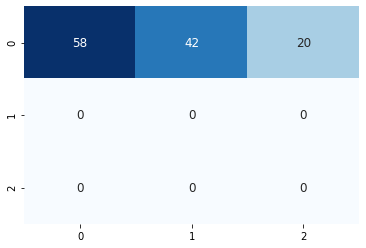

120/120 [==============================] - 0s 220us/sample - loss: 1.4479 - accuracy: 0.4250


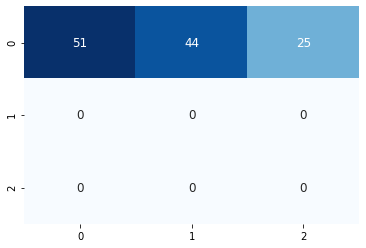

118/118 [==============================] - 0s 242us/sample - loss: 1.2831 - accuracy: 0.4407


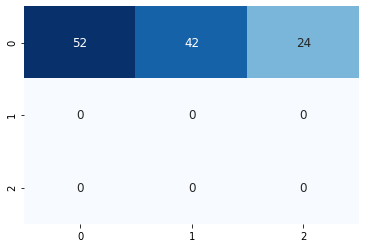

118/118 [==============================] - 0s 281us/sample - loss: 1.2759 - accuracy: 0.5000


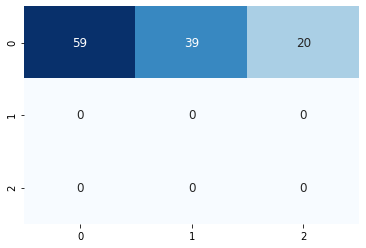

116/116 [==============================] - 0s 252us/sample - loss: 1.3137 - accuracy: 0.4224


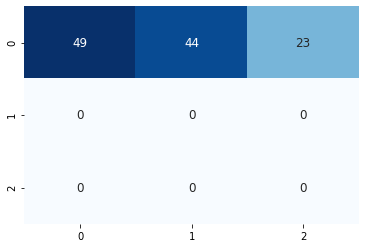

113/113 [==============================] - 0s 260us/sample - loss: 1.3989 - accuracy: 0.3805


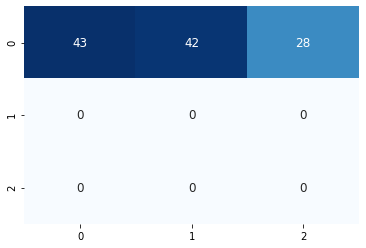

111/111 [==============================] - 0s 294us/sample - loss: 1.3350 - accuracy: 0.4054


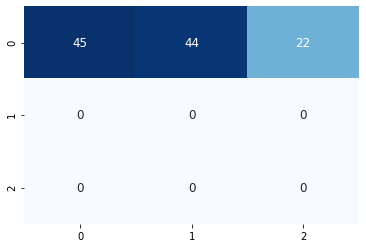

112/112 [==============================] - 0s 260us/sample - loss: 1.2665 - accuracy: 0.4286


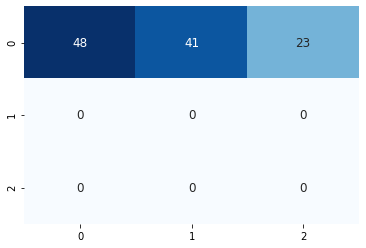

110/110 [==============================] - 0s 291us/sample - loss: 1.2571 - accuracy: 0.4182


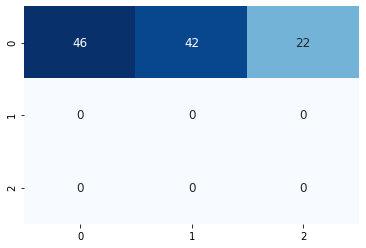

108/108 [==============================] - 0s 308us/sample - loss: 1.2505 - accuracy: 0.4537


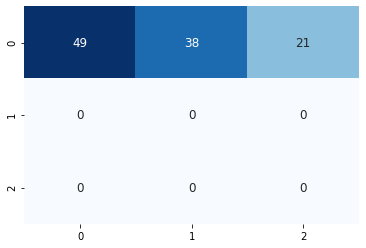

108/108 [==============================] - 0s 332us/sample - loss: 1.1874 - accuracy: 0.4167


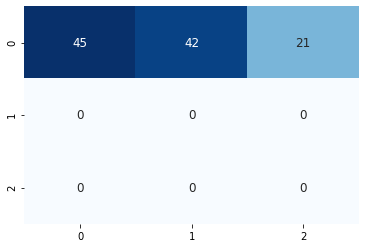

108/108 [==============================] - 0s 274us/sample - loss: 1.1510 - accuracy: 0.4444


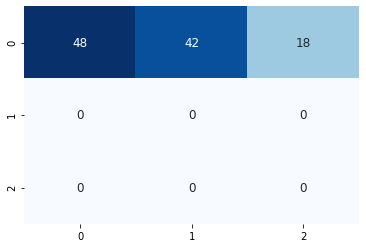

106/106 [==============================] - 0s 289us/sample - loss: 1.3115 - accuracy: 0.4528


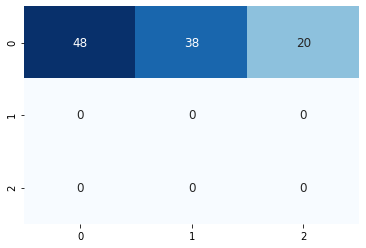

106/106 [==============================] - 0s 262us/sample - loss: 1.2411 - accuracy: 0.3962


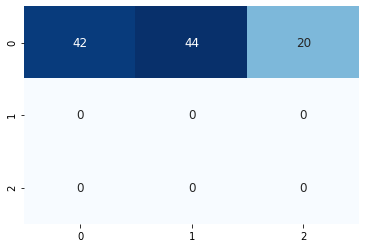

105/105 [==============================] - 0s 366us/sample - loss: 1.3862 - accuracy: 0.3810


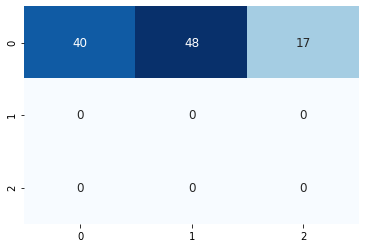

107/107 [==============================] - 0s 277us/sample - loss: 1.3463 - accuracy: 0.4112


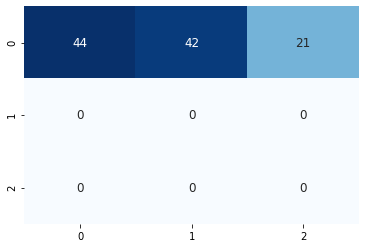

106/106 [==============================] - 0s 298us/sample - loss: 1.2581 - accuracy: 0.4528


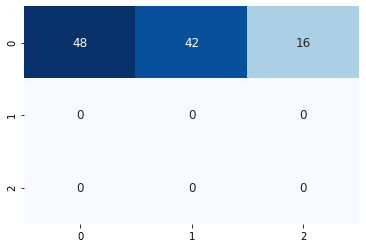

105/105 [==============================] - 0s 316us/sample - loss: 1.2127 - accuracy: 0.4571


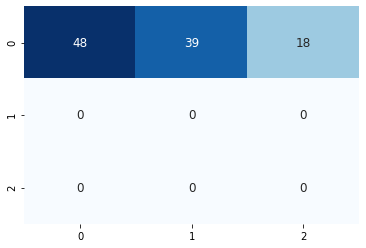

106/106 [==============================] - 0s 291us/sample - loss: 1.3491 - accuracy: 0.4057


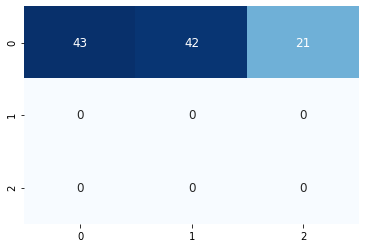

104/104 [==============================] - 0s 259us/sample - loss: 1.3466 - accuracy: 0.4231


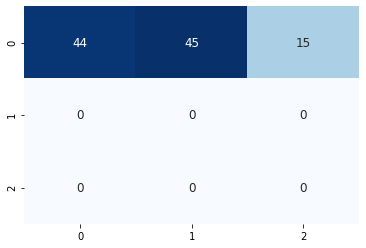

105/105 [==============================] - 0s 278us/sample - loss: 1.2863 - accuracy: 0.4667


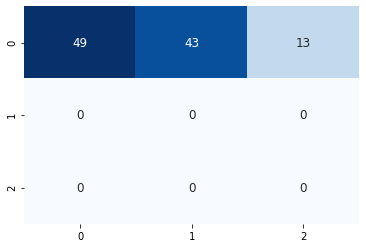

105/105 [==============================] - 0s 279us/sample - loss: 1.0735 - accuracy: 0.5714


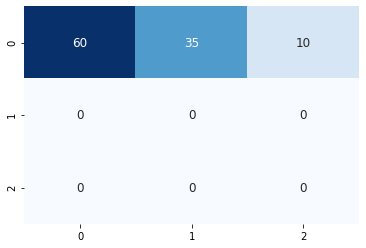

102/102 [==============================] - 0s 307us/sample - loss: 1.3461 - accuracy: 0.4412


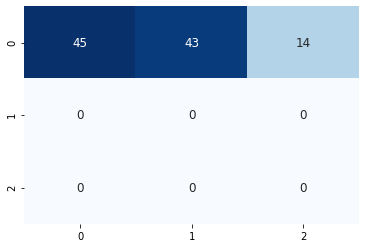

102/102 [==============================] - 0s 281us/sample - loss: 1.2652 - accuracy: 0.4608


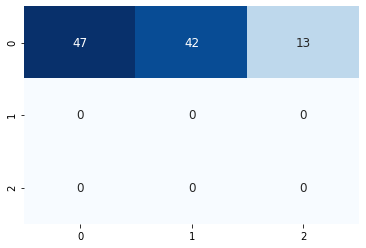

102/102 [==============================] - 0s 276us/sample - loss: 1.3877 - accuracy: 0.3922


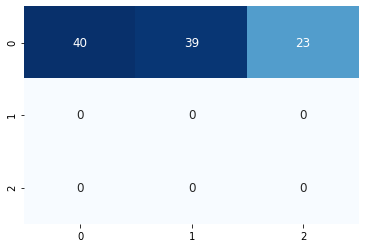

102/102 [==============================] - 0s 298us/sample - loss: 1.3669 - accuracy: 0.4118


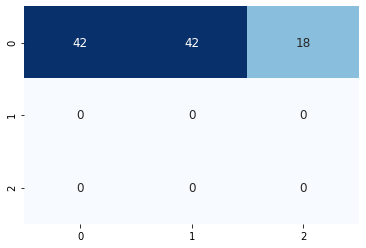

100/100 [==============================] - 0s 305us/sample - loss: 1.2089 - accuracy: 0.4500


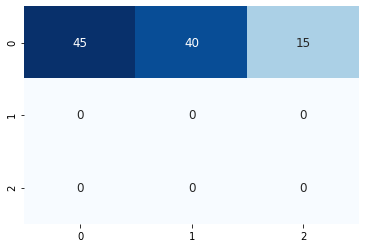

100/100 [==============================] - 0s 285us/sample - loss: 1.4357 - accuracy: 0.4000


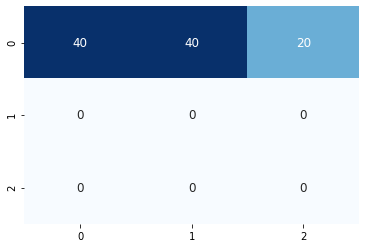

100/100 [==============================] - 0s 302us/sample - loss: 1.3345 - accuracy: 0.4100


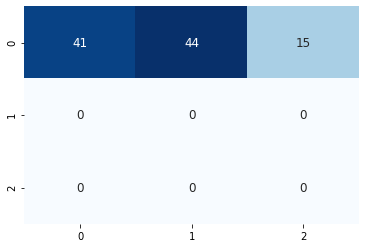

102/102 [==============================] - 0s 277us/sample - loss: 1.4018 - accuracy: 0.3725


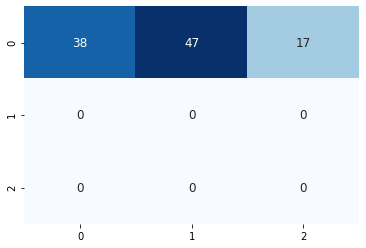

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3958 samples, validate on 934 samples
Epoch 1/300
3958/3958 [==============================] - 3s 784us/sample - loss: 0.9724 - accuracy: 0.4805 - val_loss: 1.0473 - val_accuracy: 0.4197
Epoch 2/300
3958/3958 [==============================] - 1s 227us/sample - loss: 0.7098 - accuracy: 0.6799 - val_loss: 1.1131 - val_accuracy: 0.4379
Epoch 3/300
3958/3958 [==============================] - 1s 220us/sample - loss: 0.5083 - accuracy: 0.7961 - val_loss: 1.2801 - val_accuracy: 0.4550
Epoch 4/300
3958/3958 [==============================] - 1s 212us/sample - loss: 0.3537 - accuracy: 0.8658 - val_loss: 1.4989 - val_accuracy: 0.4807
Epoch 00004: early stopping
97/97 [==============================] - 0s 4ms/sample - loss: 1.4545 - accuracy: 0.4227


3it [1:20:26, 1594.43s/it]
100%|██████████| 3/3 [00:06<00:00,  2.26s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 287 steps, validate for 69 steps
Epoch 1/300
287/287 [==============================] - 29s 102ms/step - loss: 1.4468 - accuracy: 0.4377 - val_loss: 1.2171 - val_accuracy: 0.3938
Epoch 2/300
287/287 [==============================] - 28s 97ms/step - loss: 1.0416 - accuracy: 0.4944 - val_loss: 1.1572 - val_accuracy: 0.3834
Epoch 3/300
287/287 [==============================] - 28s 97ms/step - loss: 0.9833 - accuracy: 0.5139 - val_loss: 1.1914 - val_accuracy: 0.3904
Epoch 4/300
287/287 [==============================] - 28s 99ms/step - loss: 0.9614 - accuracy: 0.5267 - val_loss: 1.1751 - val_accuracy: 0.4132
Epoch 5/300
287/287 [==============================] - 29s 100ms/step - loss: 0.9456 - accuracy: 0.5398 - val_loss: 1.2556 - val_accuracy: 0.4049
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 287 steps, validate for 69 steps
Epoch 1/300
287/287 [====

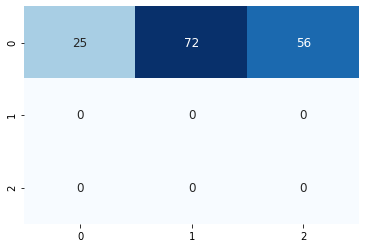

148/148 [==============================] - 0s 240us/sample - loss: 2.0123 - accuracy: 0.1622


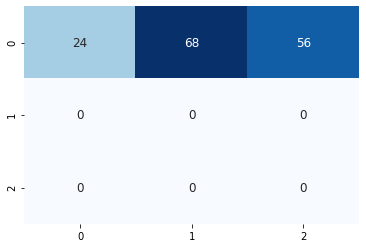

144/144 [==============================] - 0s 269us/sample - loss: 2.2445 - accuracy: 0.1458


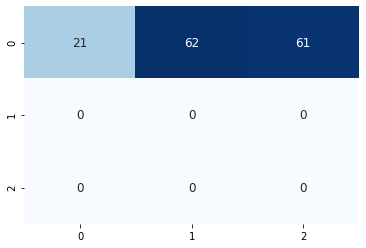

143/143 [==============================] - 0s 417us/sample - loss: 2.3268 - accuracy: 0.1888


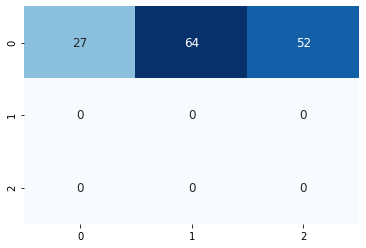

144/144 [==============================] - 0s 246us/sample - loss: 2.0825 - accuracy: 0.1736


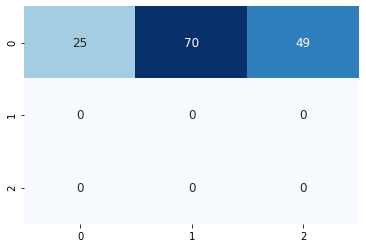

141/141 [==============================] - 0s 272us/sample - loss: 2.3128 - accuracy: 0.2057


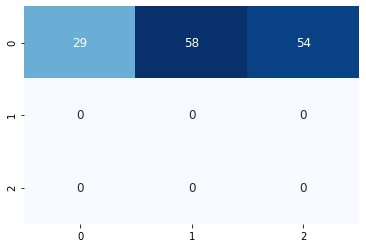

141/141 [==============================] - 0s 268us/sample - loss: 2.3065 - accuracy: 0.1844


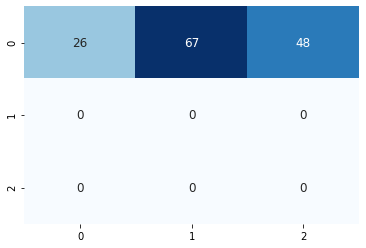

140/140 [==============================] - 0s 273us/sample - loss: 2.4647 - accuracy: 0.1714


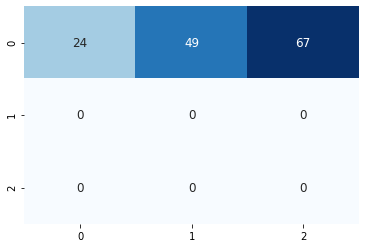

138/138 [==============================] - 0s 277us/sample - loss: 2.6632 - accuracy: 0.1377


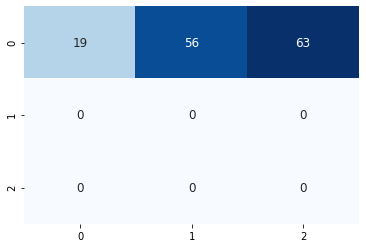

136/136 [==============================] - 0s 274us/sample - loss: 2.5784 - accuracy: 0.1691


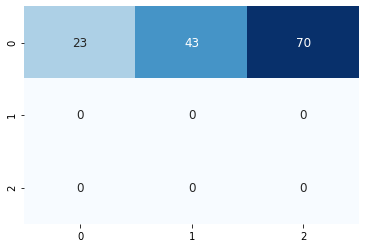

138/138 [==============================] - 0s 277us/sample - loss: 2.4988 - accuracy: 0.1522


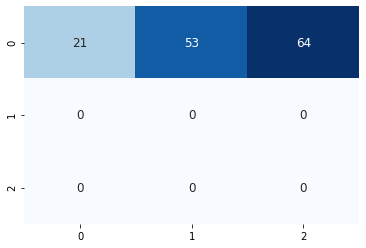

137/137 [==============================] - 0s 268us/sample - loss: 2.6495 - accuracy: 0.1387


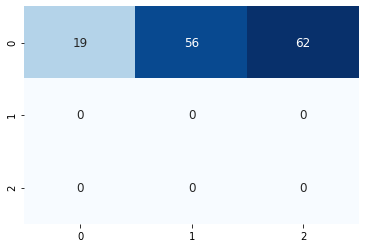

135/135 [==============================] - 0s 253us/sample - loss: 2.5779 - accuracy: 0.1704


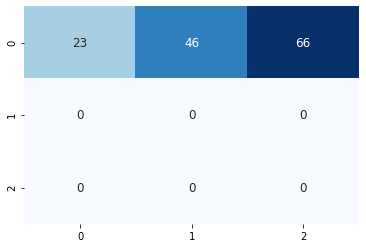

140/140 [==============================] - 0s 254us/sample - loss: 2.5025 - accuracy: 0.1500


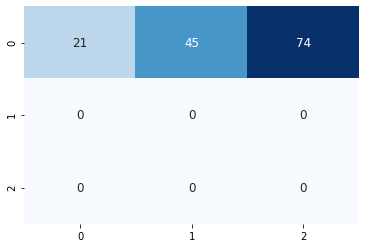

135/135 [==============================] - 0s 291us/sample - loss: 2.8583 - accuracy: 0.1704


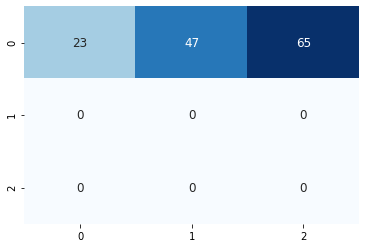

134/134 [==============================] - 0s 280us/sample - loss: 2.7635 - accuracy: 0.2239


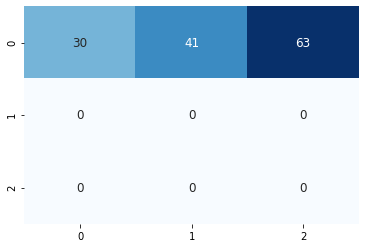

133/133 [==============================] - 0s 274us/sample - loss: 3.0591 - accuracy: 0.2180


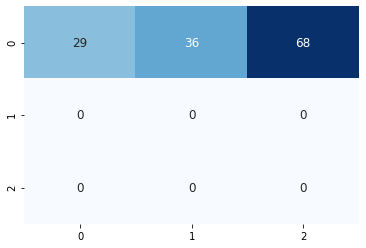

133/133 [==============================] - 0s 278us/sample - loss: 2.7634 - accuracy: 0.2331


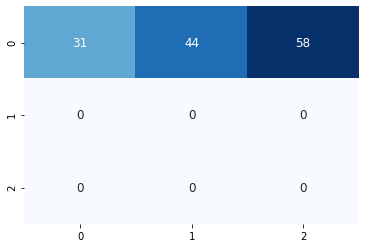

133/133 [==============================] - 0s 275us/sample - loss: 2.9272 - accuracy: 0.1729


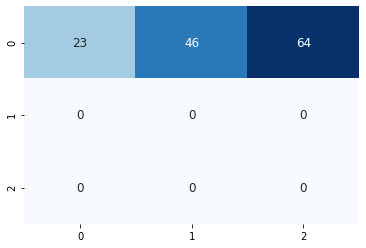

131/131 [==============================] - 0s 247us/sample - loss: 2.9510 - accuracy: 0.2595


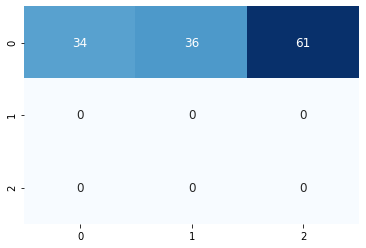

131/131 [==============================] - 0s 267us/sample - loss: 2.9207 - accuracy: 0.1985


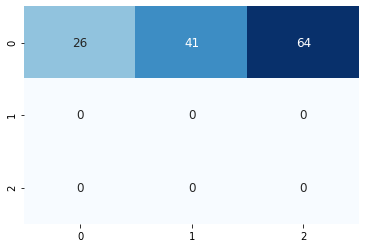

131/131 [==============================] - 0s 279us/sample - loss: 2.9647 - accuracy: 0.1450


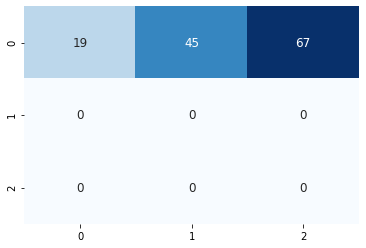

129/129 [==============================] - 0s 262us/sample - loss: 2.8187 - accuracy: 0.1628


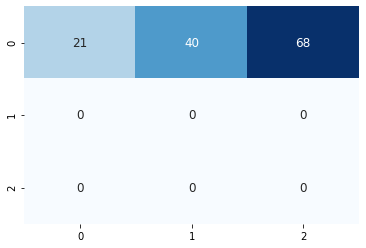

128/128 [==============================] - 0s 2ms/sample - loss: 2.8022 - accuracy: 0.2344


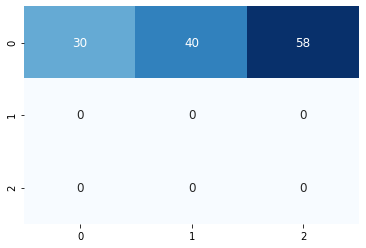

129/129 [==============================] - 0s 298us/sample - loss: 2.5796 - accuracy: 0.2016


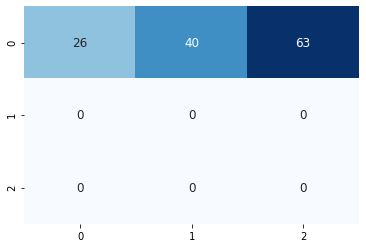

129/129 [==============================] - 0s 257us/sample - loss: 2.7095 - accuracy: 0.1860


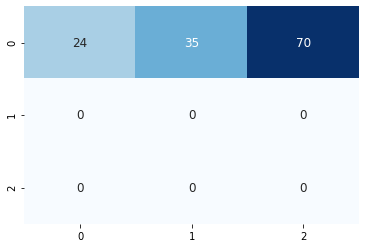

129/129 [==============================] - 0s 264us/sample - loss: 2.6622 - accuracy: 0.2248


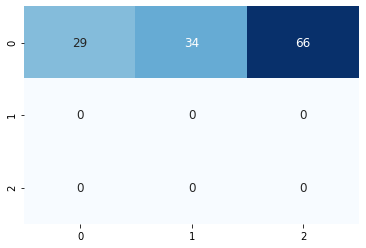

128/128 [==============================] - 0s 235us/sample - loss: 2.6339 - accuracy: 0.2188


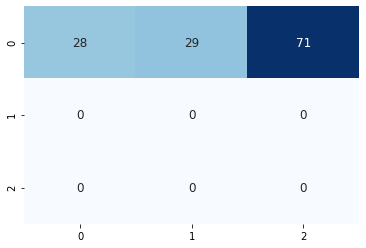

128/128 [==============================] - 0s 219us/sample - loss: 2.6244 - accuracy: 0.2344


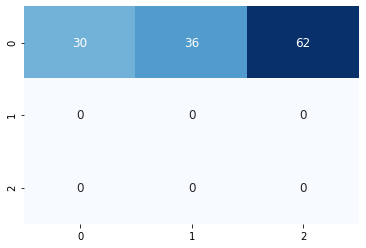

127/127 [==============================] - 0s 270us/sample - loss: 2.4670 - accuracy: 0.1890


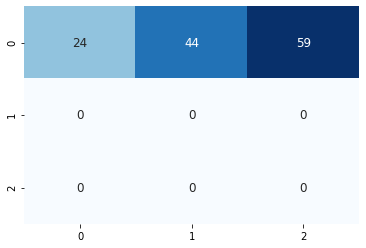

127/127 [==============================] - 0s 238us/sample - loss: 2.4763 - accuracy: 0.2283


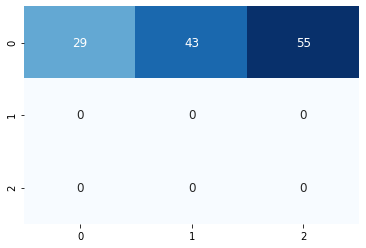

127/127 [==============================] - 0s 348us/sample - loss: 2.5652 - accuracy: 0.1890


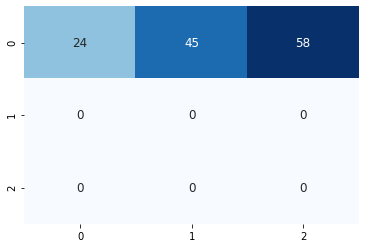

127/127 [==============================] - 0s 261us/sample - loss: 2.4813 - accuracy: 0.1890


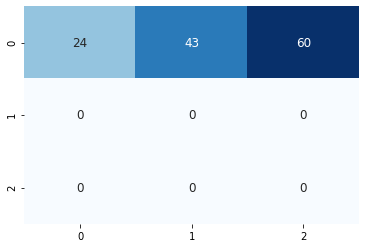

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3907 samples, validate on 959 samples
Epoch 1/300
3907/3907 [==============================] - 3s 701us/sample - loss: 0.9512 - accuracy: 0.4753 - val_loss: 1.0733 - val_accuracy: 0.3962
Epoch 2/300
3907/3907 [==============================] - 1s 195us/sample - loss: 0.7376 - accuracy: 0.6255 - val_loss: 1.1084 - val_accuracy: 0.4192
Epoch 3/300
3907/3907 [==============================] - 1s 179us/sample - loss: 0.6045 - accuracy: 0.6977 - val_loss: 1.1747 - val_accuracy: 0.4307
Epoch 4/300
3907/3907 [==============================] - 1s 202us/sample - loss: 0.5055 - accuracy: 0.7676 - val_loss: 1.2690 - val_accuracy: 0.4599
Epoch 00004: early stopping
123/123 [==============================] - 0s 3ms/sample - loss: 1.7751 - accuracy: 0.2358


4it [1:46:11, 1579.53s/it]
100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 291 steps, validate for 69 steps
Epoch 1/300
291/291 [==============================] - 30s 102ms/step - loss: 1.4209 - accuracy: 0.4292 - val_loss: 1.1847 - val_accuracy: 0.4168
Epoch 2/300
291/291 [==============================] - 28s 98ms/step - loss: 1.0378 - accuracy: 0.4831 - val_loss: 1.1481 - val_accuracy: 0.4280
Epoch 3/300
291/291 [==============================] - 29s 98ms/step - loss: 0.9858 - accuracy: 0.5073 - val_loss: 1.1734 - val_accuracy: 0.3982
Epoch 4/300
291/291 [==============================] - 28s 97ms/step - loss: 0.9626 - accuracy: 0.5210 - val_loss: 1.2074 - val_accuracy: 0.3929
Epoch 5/300
291/291 [==============================] - 28s 97ms/step - loss: 0.9491 - accuracy: 0.5331 - val_loss: 1.2213 - val_accuracy: 0.3771
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 291 steps, validate for 69 steps
Epoch 1/300
291/291 [=====

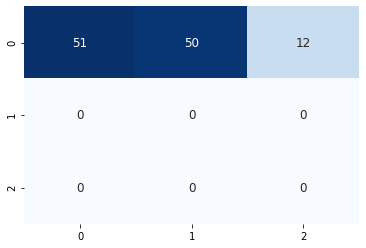

108/108 [==============================] - 0s 295us/sample - loss: 1.1995 - accuracy: 0.3981


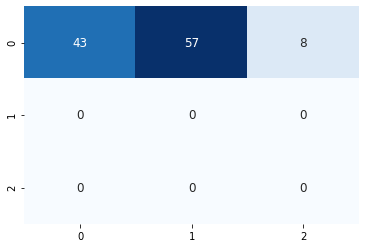

102/102 [==============================] - 0s 298us/sample - loss: 1.1479 - accuracy: 0.4608


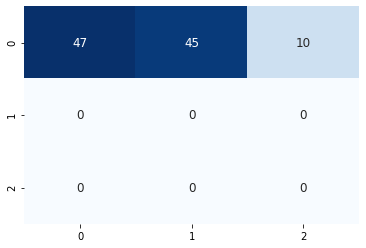

101/101 [==============================] - 0s 260us/sample - loss: 1.2660 - accuracy: 0.4059


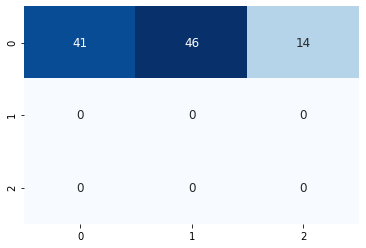

101/101 [==============================] - 0s 311us/sample - loss: 1.3807 - accuracy: 0.4059


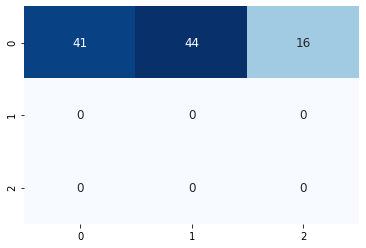

99/99 [==============================] - 0s 286us/sample - loss: 1.4102 - accuracy: 0.3838


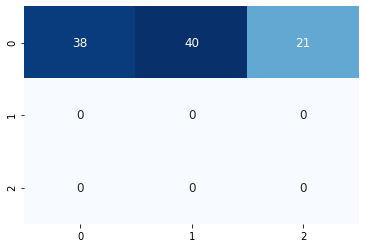

96/96 [==============================] - 0s 2ms/sample - loss: 1.3383 - accuracy: 0.3854


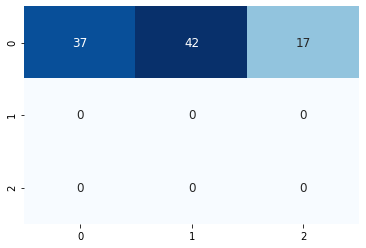

95/95 [==============================] - 0s 245us/sample - loss: 1.5378 - accuracy: 0.3263


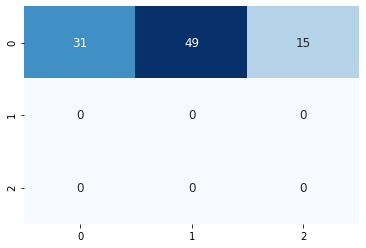

96/96 [==============================] - 0s 230us/sample - loss: 1.4461 - accuracy: 0.3854


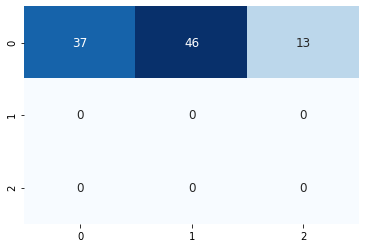

97/97 [==============================] - 0s 286us/sample - loss: 1.4662 - accuracy: 0.3608


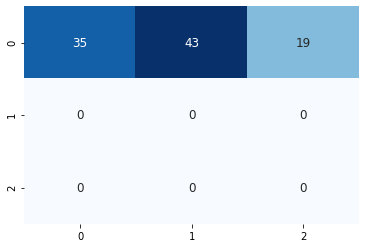

96/96 [==============================] - 0s 232us/sample - loss: 1.4576 - accuracy: 0.3333


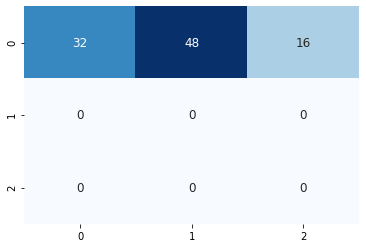

94/94 [==============================] - 0s 233us/sample - loss: 1.4098 - accuracy: 0.3511


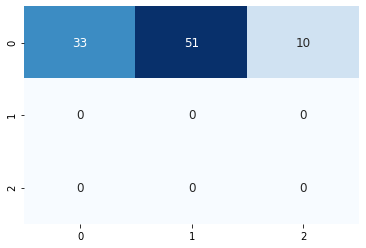

93/93 [==============================] - 0s 311us/sample - loss: 1.4149 - accuracy: 0.3548


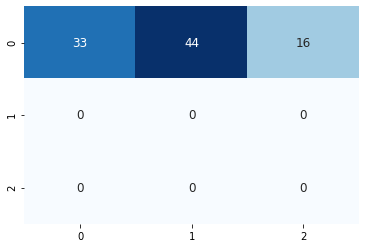

93/93 [==============================] - 0s 254us/sample - loss: 1.3616 - accuracy: 0.3871


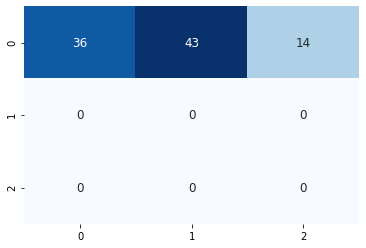

94/94 [==============================] - 0s 254us/sample - loss: 1.4350 - accuracy: 0.4149


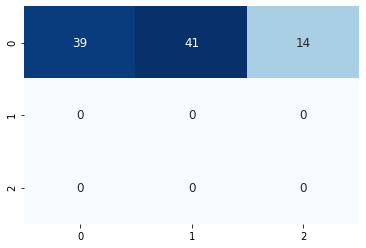

93/93 [==============================] - 0s 267us/sample - loss: 1.4704 - accuracy: 0.3656


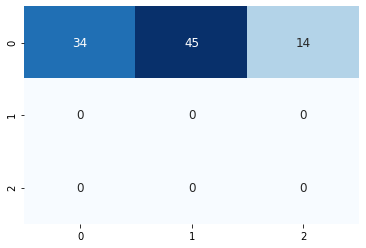

91/91 [==============================] - 0s 264us/sample - loss: 1.5370 - accuracy: 0.4066


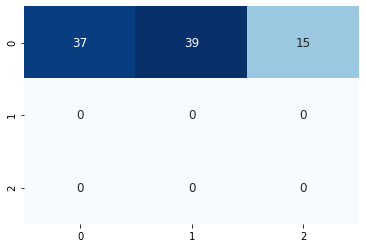

90/90 [==============================] - 0s 265us/sample - loss: 1.4865 - accuracy: 0.3778


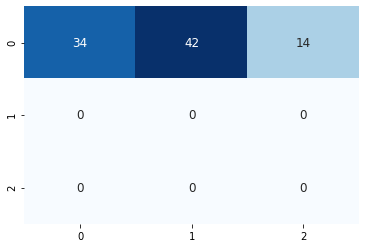

91/91 [==============================] - 0s 280us/sample - loss: 1.5658 - accuracy: 0.3846


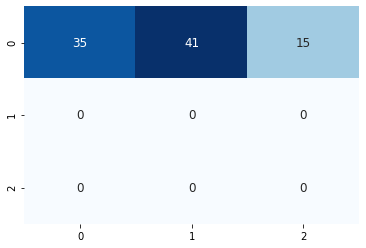

88/88 [==============================] - 0s 324us/sample - loss: 1.5544 - accuracy: 0.3295


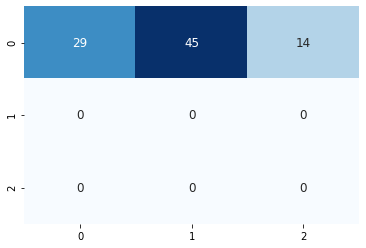

89/89 [==============================] - 0s 269us/sample - loss: 1.6304 - accuracy: 0.3820


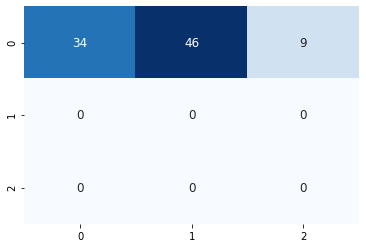

88/88 [==============================] - 0s 263us/sample - loss: 1.5635 - accuracy: 0.2955


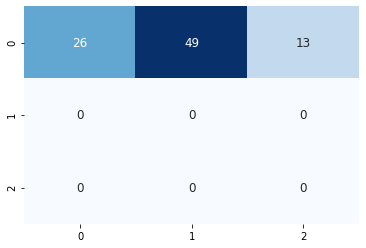

89/89 [==============================] - 0s 276us/sample - loss: 1.5613 - accuracy: 0.3258


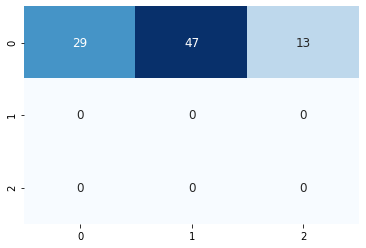

88/88 [==============================] - 0s 253us/sample - loss: 1.6538 - accuracy: 0.3295


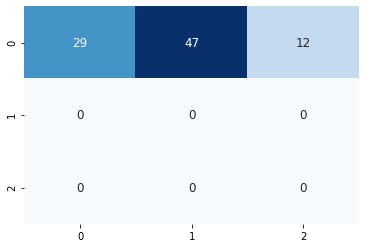

87/87 [==============================] - 0s 257us/sample - loss: 1.7680 - accuracy: 0.2989


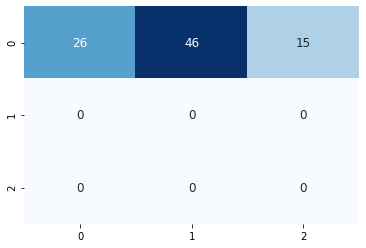

88/88 [==============================] - 0s 293us/sample - loss: 1.7777 - accuracy: 0.2727


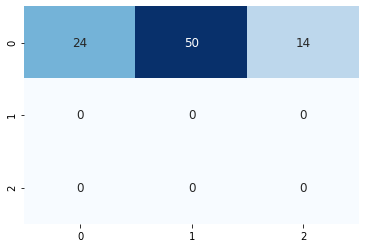

88/88 [==============================] - 0s 314us/sample - loss: 1.6220 - accuracy: 0.3182


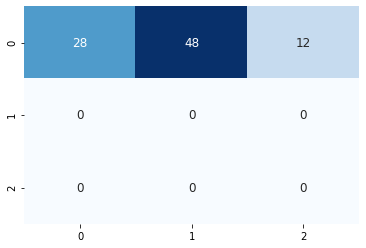

87/87 [==============================] - 0s 261us/sample - loss: 1.6213 - accuracy: 0.2759


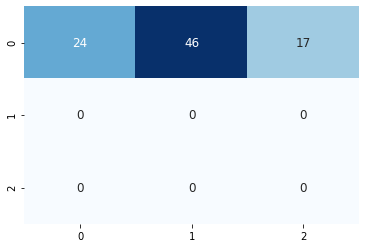

87/87 [==============================] - 0s 271us/sample - loss: 1.5789 - accuracy: 0.3103


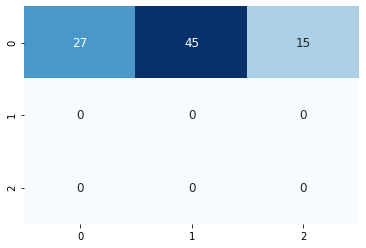

86/86 [==============================] - 0s 315us/sample - loss: 1.8540 - accuracy: 0.2442


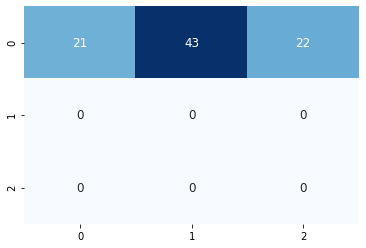

85/85 [==============================] - 0s 263us/sample - loss: 1.7114 - accuracy: 0.2824


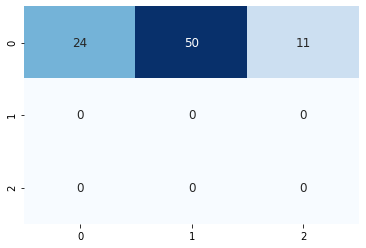

86/86 [==============================] - 0s 286us/sample - loss: 1.6714 - accuracy: 0.2791


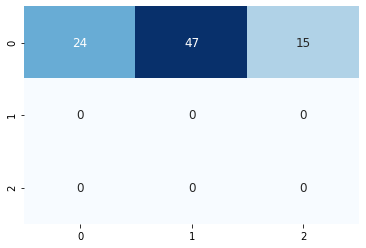

85/85 [==============================] - 0s 265us/sample - loss: 1.4505 - accuracy: 0.3882


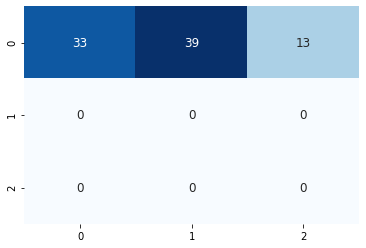

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3953 samples, validate on 953 samples
Epoch 1/300
3953/3953 [==============================] - 3s 708us/sample - loss: 0.9691 - accuracy: 0.5280 - val_loss: 1.0663 - val_accuracy: 0.4533
Epoch 2/300
3953/3953 [==============================] - 1s 185us/sample - loss: 0.7465 - accuracy: 0.6790 - val_loss: 1.1109 - val_accuracy: 0.4638
Epoch 3/300
3953/3953 [==============================] - 1s 211us/sample - loss: 0.5834 - accuracy: 0.7450 - val_loss: 1.2083 - val_accuracy: 0.4890
Epoch 4/300
3953/3953 [==============================] - 1s 209us/sample - loss: 0.4708 - accuracy: 0.7900 - val_loss: 1.2991 - val_accuracy: 0.4837
Epoch 00004: early stopping
83/83 [==============================] - 0s 5ms/sample - loss: 1.5993 - accuracy: 0.3253


5it [2:09:08, 1518.86s/it]
100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 68 steps
Epoch 1/300
289/289 [==============================] - 29s 101ms/step - loss: 1.4663 - accuracy: 0.4315 - val_loss: 1.2046 - val_accuracy: 0.4178
Epoch 2/300
289/289 [==============================] - 28s 95ms/step - loss: 1.0481 - accuracy: 0.4953 - val_loss: 1.1441 - val_accuracy: 0.3960
Epoch 3/300
289/289 [==============================] - 28s 96ms/step - loss: 0.9857 - accuracy: 0.5174 - val_loss: 1.1565 - val_accuracy: 0.4147
Epoch 4/300
289/289 [==============================] - 28s 98ms/step - loss: 0.9636 - accuracy: 0.5295 - val_loss: 1.2040 - val_accuracy: 0.3890
Epoch 5/300
289/289 [==============================] - 28s 96ms/step - loss: 0.9485 - accuracy: 0.5410 - val_loss: 1.2408 - val_accuracy: 0.3829
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 68 steps
Epoch 1/300
289/289 [=====

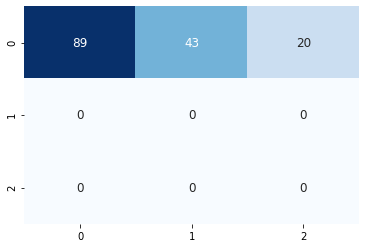

144/144 [==============================] - 0s 250us/sample - loss: 0.9111 - accuracy: 0.6111


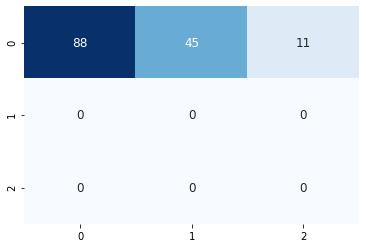

143/143 [==============================] - 0s 261us/sample - loss: 0.8530 - accuracy: 0.6224


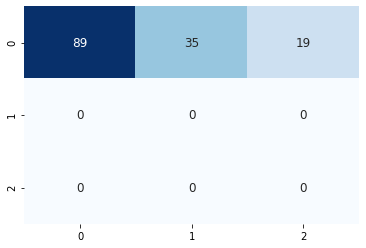

140/140 [==============================] - 0s 254us/sample - loss: 0.8610 - accuracy: 0.6214


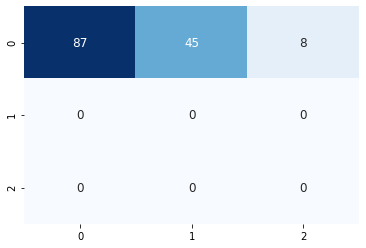

139/139 [==============================] - 0s 229us/sample - loss: 1.0315 - accuracy: 0.5468


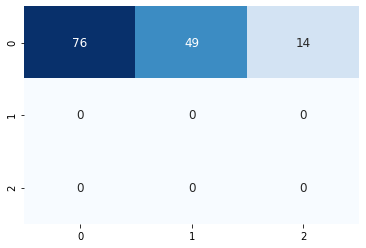

138/138 [==============================] - 0s 278us/sample - loss: 1.0177 - accuracy: 0.6087


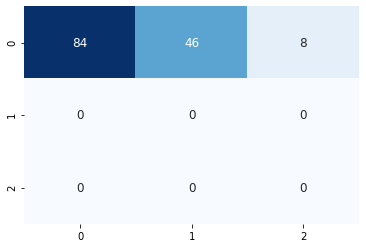

137/137 [==============================] - 0s 264us/sample - loss: 1.0862 - accuracy: 0.5109


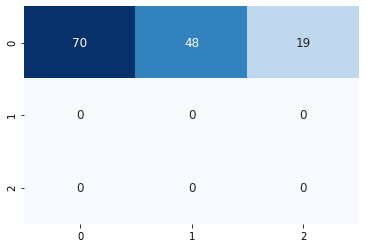

137/137 [==============================] - 0s 266us/sample - loss: 0.9072 - accuracy: 0.6058


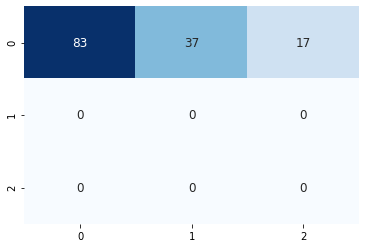

137/137 [==============================] - 0s 246us/sample - loss: 1.0013 - accuracy: 0.6204


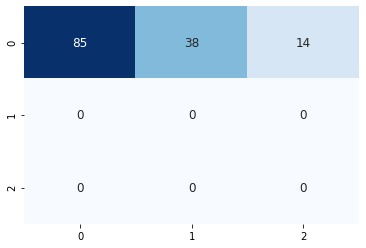

136/136 [==============================] - 0s 240us/sample - loss: 0.9758 - accuracy: 0.6176


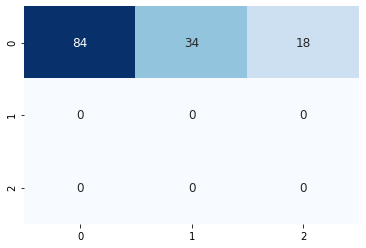

136/136 [==============================] - 0s 274us/sample - loss: 0.9808 - accuracy: 0.5956


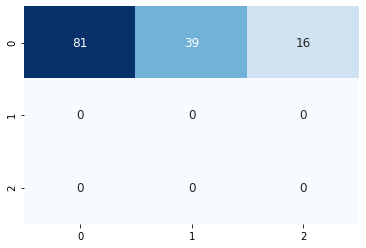

134/134 [==============================] - 0s 279us/sample - loss: 1.0578 - accuracy: 0.5522


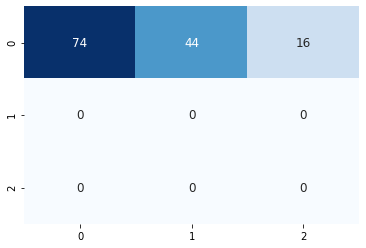

134/134 [==============================] - 0s 304us/sample - loss: 0.9789 - accuracy: 0.5746


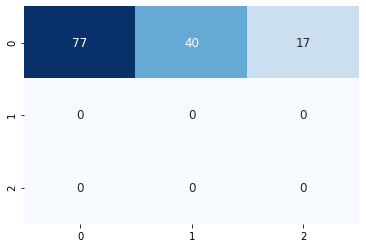

134/134 [==============================] - 0s 290us/sample - loss: 0.9966 - accuracy: 0.6343


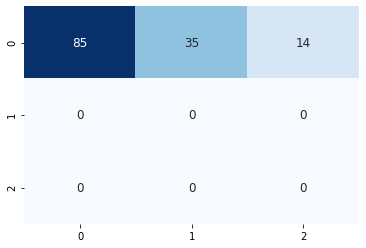

133/133 [==============================] - 0s 263us/sample - loss: 1.1358 - accuracy: 0.5714


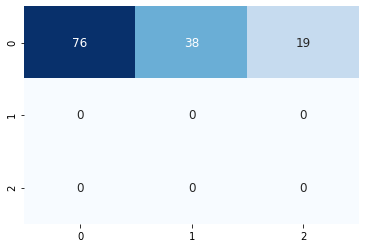

134/134 [==============================] - 0s 275us/sample - loss: 1.0693 - accuracy: 0.5000


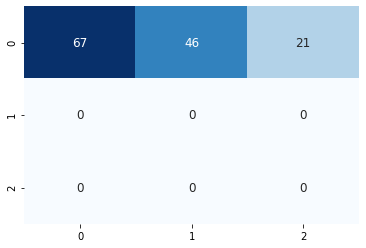

135/135 [==============================] - 0s 284us/sample - loss: 0.9764 - accuracy: 0.6000


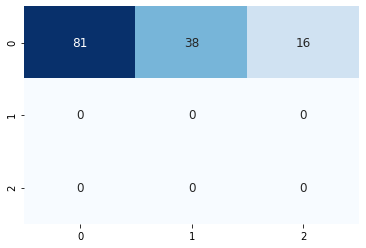

134/134 [==============================] - 0s 253us/sample - loss: 1.0371 - accuracy: 0.5075


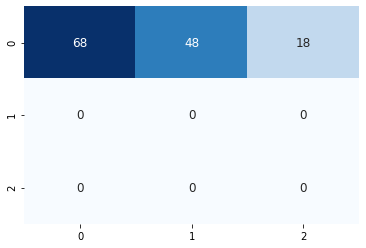

136/136 [==============================] - 0s 270us/sample - loss: 1.0544 - accuracy: 0.5588


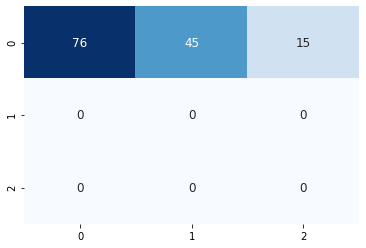

133/133 [==============================] - 0s 261us/sample - loss: 1.1108 - accuracy: 0.4962


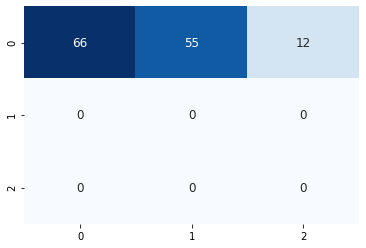

134/134 [==============================] - 0s 251us/sample - loss: 1.0840 - accuracy: 0.5224


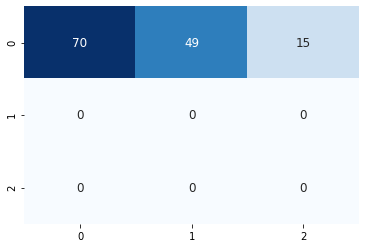

132/132 [==============================] - 0s 294us/sample - loss: 0.9494 - accuracy: 0.5758


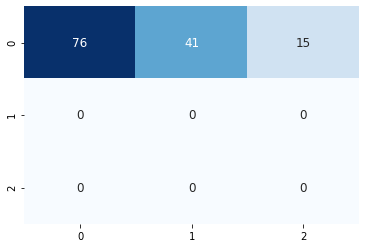

133/133 [==============================] - 0s 287us/sample - loss: 0.9529 - accuracy: 0.6015


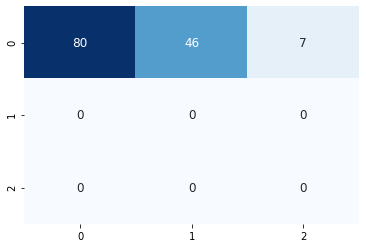

133/133 [==============================] - 0s 250us/sample - loss: 0.9477 - accuracy: 0.5338


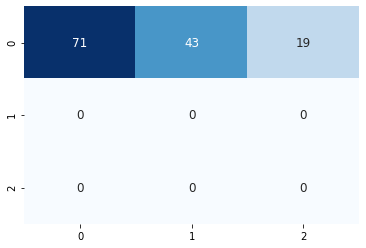

132/132 [==============================] - 0s 255us/sample - loss: 0.9068 - accuracy: 0.6061


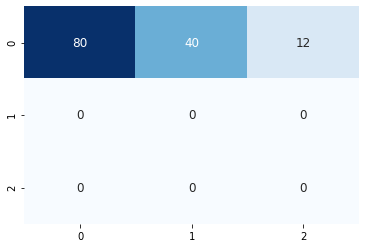

132/132 [==============================] - 0s 262us/sample - loss: 0.9110 - accuracy: 0.6061


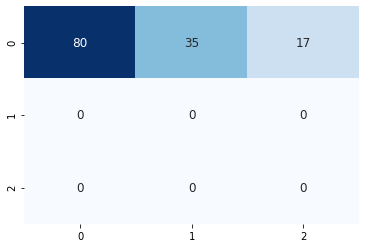

133/133 [==============================] - 0s 257us/sample - loss: 0.8954 - accuracy: 0.6241


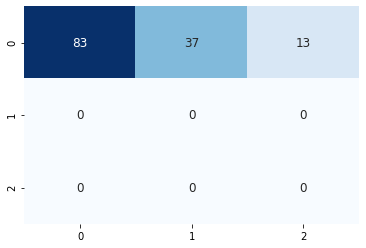

132/132 [==============================] - 0s 260us/sample - loss: 0.9731 - accuracy: 0.5530


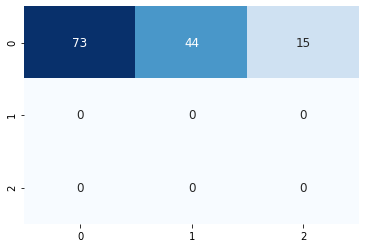

132/132 [==============================] - 0s 301us/sample - loss: 0.9563 - accuracy: 0.5682


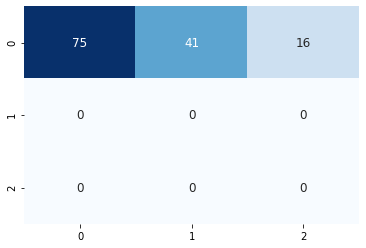

132/132 [==============================] - 0s 342us/sample - loss: 0.9002 - accuracy: 0.6364


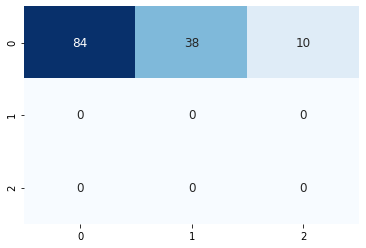

132/132 [==============================] - 0s 303us/sample - loss: 0.9318 - accuracy: 0.6288


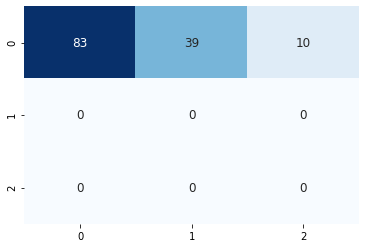

133/133 [==============================] - 0s 260us/sample - loss: 0.9573 - accuracy: 0.6015


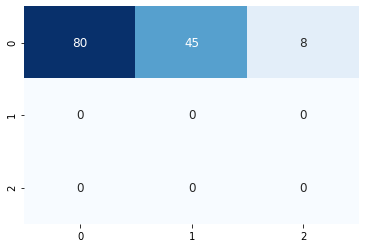

128/128 [==============================] - 0s 2ms/sample - loss: 0.9655 - accuracy: 0.5312


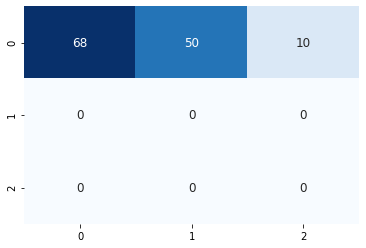

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3929 samples, validate on 938 samples
Epoch 1/300
3929/3929 [==============================] - 3s 648us/sample - loss: 0.8847 - accuracy: 0.5363 - val_loss: 1.0886 - val_accuracy: 0.3998
Epoch 2/300
3929/3929 [==============================] - 1s 185us/sample - loss: 0.6123 - accuracy: 0.7172 - val_loss: 1.1874 - val_accuracy: 0.4456
Epoch 3/300
3929/3929 [==============================] - 1s 184us/sample - loss: 0.4258 - accuracy: 0.8063 - val_loss: 1.3689 - val_accuracy: 0.4797
Epoch 4/300
3929/3929 [==============================] - 1s 163us/sample - loss: 0.3081 - accuracy: 0.8717 - val_loss: 1.5475 - val_accuracy: 0.4979
Epoch 00004: early stopping
122/122 [==============================] - 0s 3ms/sample - loss: 1.8224 - accuracy: 0.2705


6it [2:34:05, 1512.13s/it]
100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 290 steps, validate for 67 steps
Epoch 1/300
290/290 [==============================] - 29s 99ms/step - loss: 1.4497 - accuracy: 0.4265 - val_loss: 1.2032 - val_accuracy: 0.3422
Epoch 2/300
290/290 [==============================] - 28s 97ms/step - loss: 1.0522 - accuracy: 0.4821 - val_loss: 1.1567 - val_accuracy: 0.3852
Epoch 3/300
290/290 [==============================] - 28s 96ms/step - loss: 0.9939 - accuracy: 0.5058 - val_loss: 1.1966 - val_accuracy: 0.4218
Epoch 4/300
290/290 [==============================] - 28s 96ms/step - loss: 0.9712 - accuracy: 0.5219 - val_loss: 1.2107 - val_accuracy: 0.3620
Epoch 5/300
290/290 [==============================] - 28s 98ms/step - loss: 0.9538 - accuracy: 0.5322 - val_loss: 1.2459 - val_accuracy: 0.3740
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 290 steps, validate for 67 steps
Epoch 1/300
290/290 [======

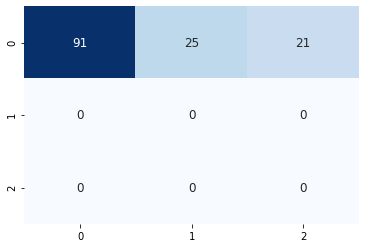

132/132 [==============================] - 0s 243us/sample - loss: 0.9043 - accuracy: 0.6136


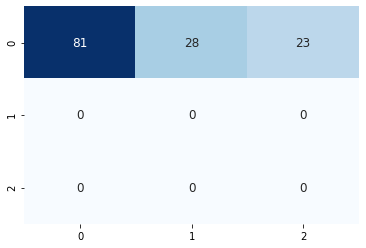

130/130 [==============================] - 0s 237us/sample - loss: 0.8463 - accuracy: 0.6769


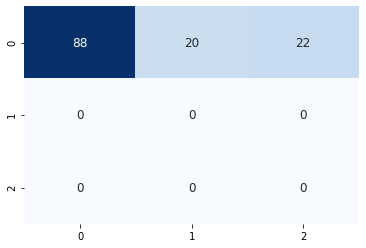

130/130 [==============================] - 0s 239us/sample - loss: 0.8559 - accuracy: 0.6846


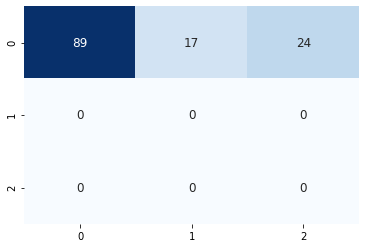

128/128 [==============================] - 0s 2ms/sample - loss: 0.8217 - accuracy: 0.6719


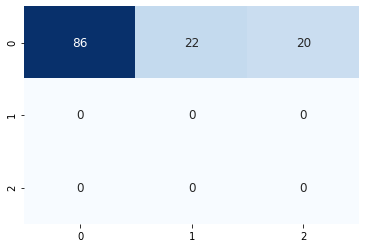

128/128 [==============================] - 0s 225us/sample - loss: 0.8860 - accuracy: 0.5781


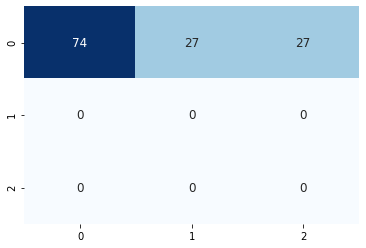

129/129 [==============================] - 0s 270us/sample - loss: 0.8467 - accuracy: 0.6822


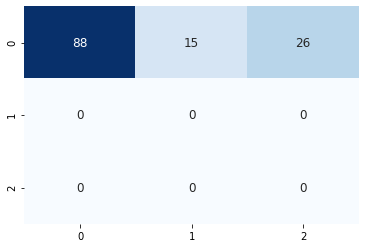

129/129 [==============================] - 0s 248us/sample - loss: 0.7988 - accuracy: 0.7054


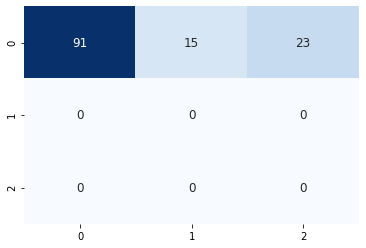

126/126 [==============================] - 0s 286us/sample - loss: 0.8163 - accuracy: 0.6587


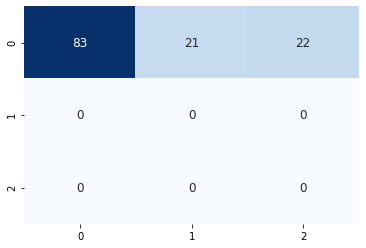

126/126 [==============================] - 0s 247us/sample - loss: 0.8030 - accuracy: 0.7063


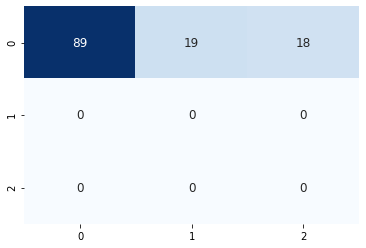

126/126 [==============================] - 0s 243us/sample - loss: 0.8086 - accuracy: 0.6508


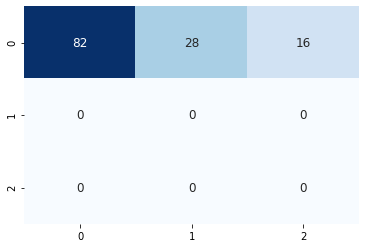

126/126 [==============================] - 0s 254us/sample - loss: 0.7604 - accuracy: 0.6825


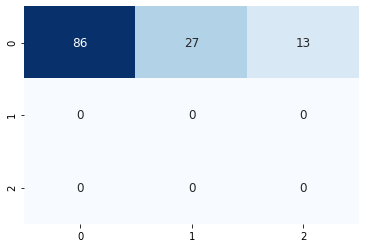

126/126 [==============================] - 0s 262us/sample - loss: 0.7404 - accuracy: 0.7063


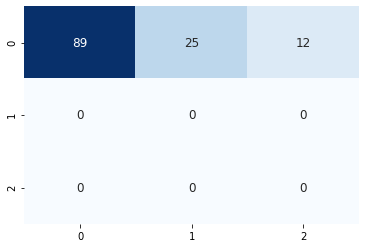

124/124 [==============================] - 0s 269us/sample - loss: 0.7230 - accuracy: 0.7097


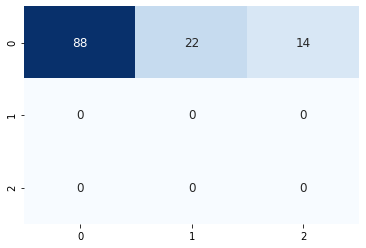

124/124 [==============================] - 0s 261us/sample - loss: 0.7298 - accuracy: 0.7339


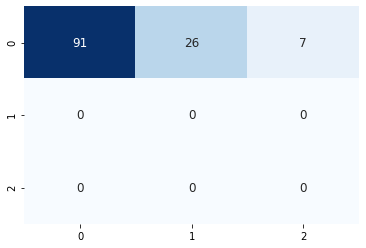

122/122 [==============================] - 0s 245us/sample - loss: 0.7484 - accuracy: 0.6639


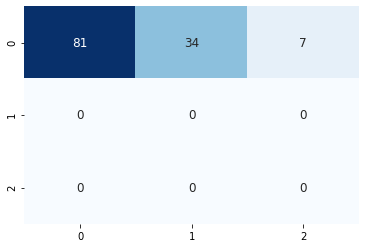

122/122 [==============================] - 0s 270us/sample - loss: 0.7441 - accuracy: 0.6639


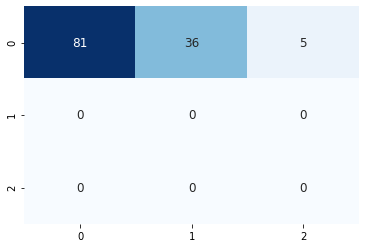

120/120 [==============================] - 0s 256us/sample - loss: 0.6484 - accuracy: 0.7583


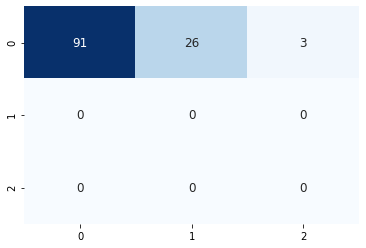

121/121 [==============================] - 0s 278us/sample - loss: 0.6754 - accuracy: 0.7355


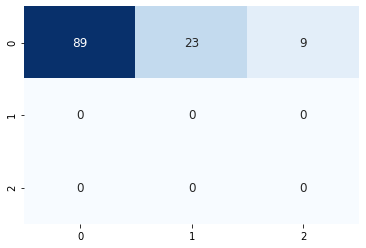

121/121 [==============================] - 0s 297us/sample - loss: 0.6650 - accuracy: 0.7438


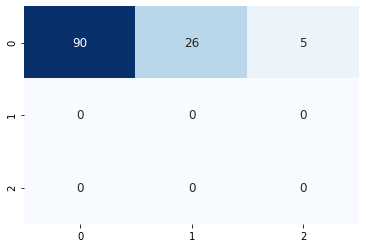

120/120 [==============================] - 0s 247us/sample - loss: 0.6335 - accuracy: 0.7917


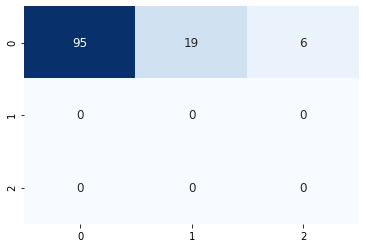

121/121 [==============================] - 0s 274us/sample - loss: 0.6087 - accuracy: 0.7521


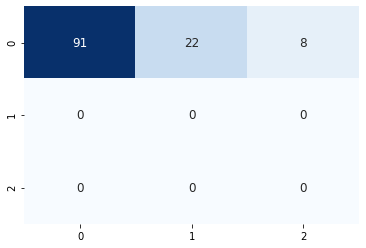

120/120 [==============================] - 0s 295us/sample - loss: 0.6512 - accuracy: 0.7667


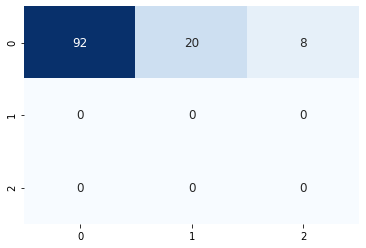

120/120 [==============================] - 0s 247us/sample - loss: 0.6218 - accuracy: 0.7583


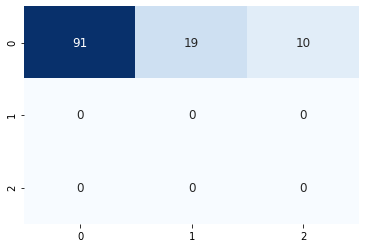

120/120 [==============================] - 0s 243us/sample - loss: 0.5705 - accuracy: 0.8417


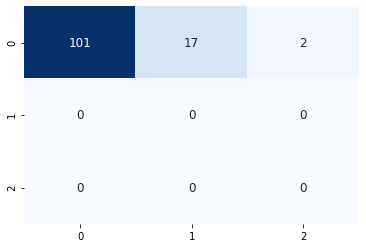

120/120 [==============================] - 0s 260us/sample - loss: 0.6591 - accuracy: 0.7500


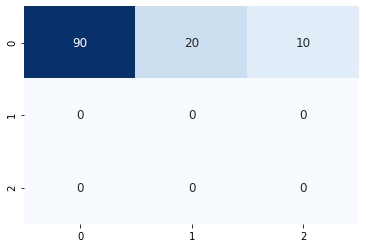

122/122 [==============================] - 0s 242us/sample - loss: 0.5811 - accuracy: 0.8443


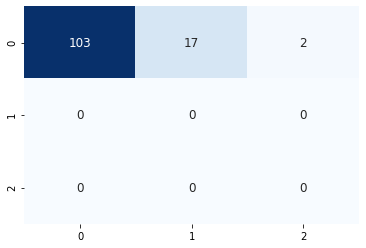

119/119 [==============================] - 0s 260us/sample - loss: 0.5742 - accuracy: 0.7983


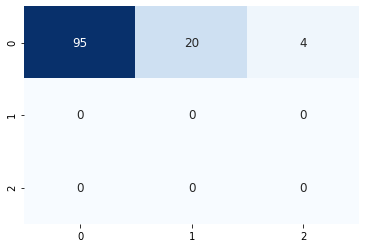

116/116 [==============================] - 0s 271us/sample - loss: 0.5305 - accuracy: 0.8534


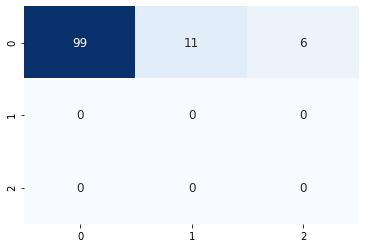

117/117 [==============================] - 0s 263us/sample - loss: 0.5646 - accuracy: 0.8291


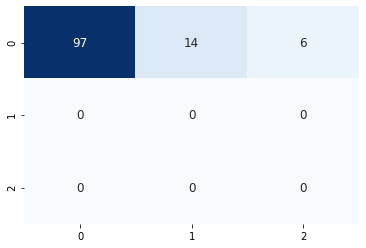

116/116 [==============================] - 0s 279us/sample - loss: 0.5643 - accuracy: 0.7759


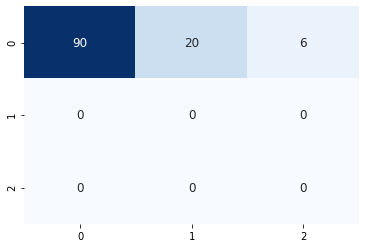

117/117 [==============================] - 0s 260us/sample - loss: 0.5673 - accuracy: 0.8120


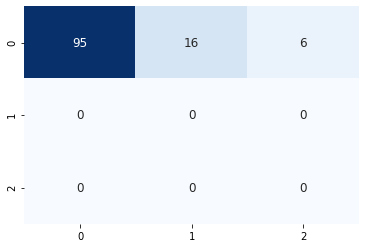

117/117 [==============================] - 0s 296us/sample - loss: 0.5196 - accuracy: 0.8462


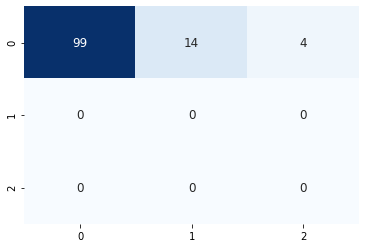

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3945 samples, validate on 935 samples
Epoch 1/300
3945/3945 [==============================] - 3s 704us/sample - loss: 0.9754 - accuracy: 0.4935 - val_loss: 1.0614 - val_accuracy: 0.4193
Epoch 2/300
3945/3945 [==============================] - 1s 218us/sample - loss: 0.7811 - accuracy: 0.6380 - val_loss: 1.1031 - val_accuracy: 0.4225
Epoch 3/300
3945/3945 [==============================] - 1s 202us/sample - loss: 0.6337 - accuracy: 0.7077 - val_loss: 1.1933 - val_accuracy: 0.4321
Epoch 4/300
3945/3945 [==============================] - 1s 215us/sample - loss: 0.5234 - accuracy: 0.7579 - val_loss: 1.2888 - val_accuracy: 0.4588
Epoch 00004: early stopping
109/109 [==============================] - 0s 4ms/sample - loss: 0.7221 - accuracy: 0.6239


7it [2:56:49, 1467.84s/it]
100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 68 steps
Epoch 1/300
293/293 [==============================] - 30s 101ms/step - loss: 1.4291 - accuracy: 0.4378 - val_loss: 1.1784 - val_accuracy: 0.3971
Epoch 2/300
293/293 [==============================] - 29s 97ms/step - loss: 1.0418 - accuracy: 0.4924 - val_loss: 1.1378 - val_accuracy: 0.3938
Epoch 3/300
293/293 [==============================] - 29s 98ms/step - loss: 0.9893 - accuracy: 0.5126 - val_loss: 1.1598 - val_accuracy: 0.4050
Epoch 4/300
293/293 [==============================] - 29s 99ms/step - loss: 0.9655 - accuracy: 0.5266 - val_loss: 1.1803 - val_accuracy: 0.3985
Epoch 5/300
293/293 [==============================] - 29s 98ms/step - loss: 0.9513 - accuracy: 0.5402 - val_loss: 1.2140 - val_accuracy: 0.3863
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 293 steps, validate for 68 steps
Epoch 1/300
293/293 [=====

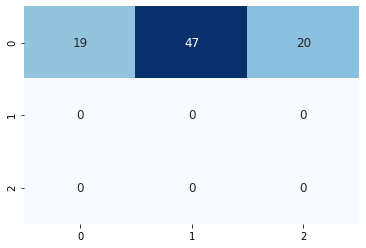

85/85 [==============================] - 0s 259us/sample - loss: 1.6358 - accuracy: 0.2353


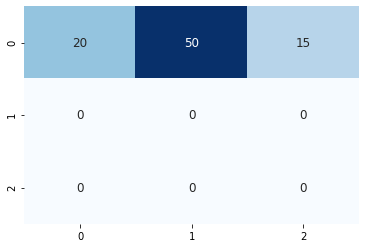

84/84 [==============================] - 0s 270us/sample - loss: 1.6553 - accuracy: 0.2381


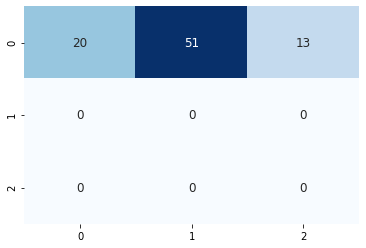

82/82 [==============================] - 0s 334us/sample - loss: 1.6056 - accuracy: 0.2195


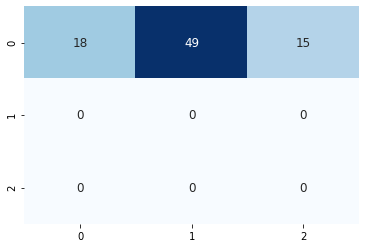

83/83 [==============================] - 0s 261us/sample - loss: 1.8561 - accuracy: 0.1446


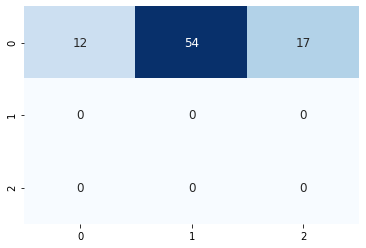

83/83 [==============================] - 0s 275us/sample - loss: 1.7531 - accuracy: 0.1807


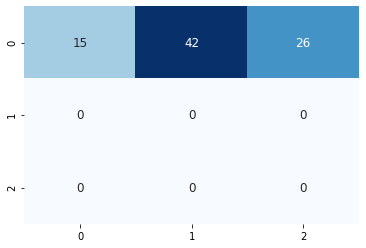

82/82 [==============================] - 0s 303us/sample - loss: 1.7332 - accuracy: 0.2805


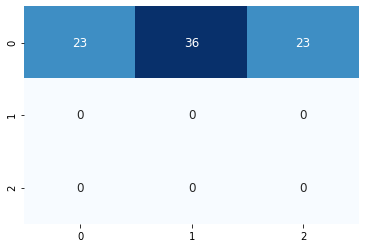

82/82 [==============================] - 0s 286us/sample - loss: 1.7976 - accuracy: 0.2561


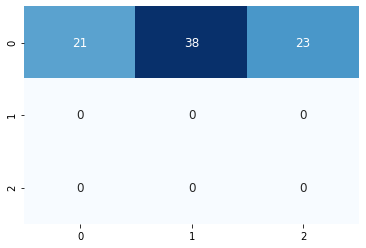

80/80 [==============================] - 0s 319us/sample - loss: 1.7614 - accuracy: 0.2500


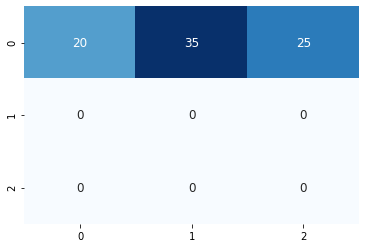

79/79 [==============================] - 0s 293us/sample - loss: 1.8561 - accuracy: 0.2025


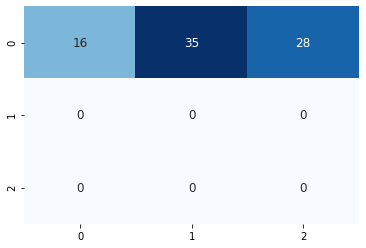

79/79 [==============================] - 0s 310us/sample - loss: 1.6704 - accuracy: 0.2532


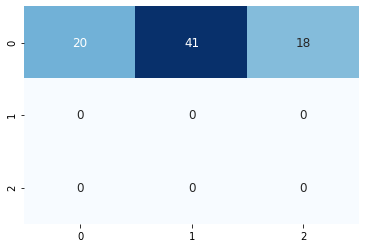

78/78 [==============================] - 0s 348us/sample - loss: 1.6042 - accuracy: 0.2949


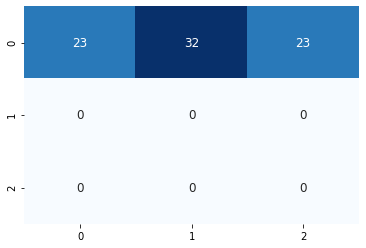

78/78 [==============================] - 0s 294us/sample - loss: 1.7514 - accuracy: 0.2564


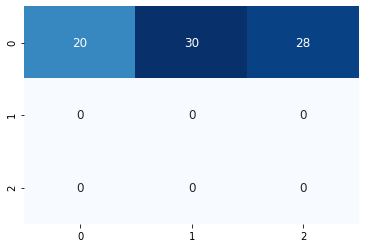

79/79 [==============================] - 0s 271us/sample - loss: 1.7121 - accuracy: 0.2658


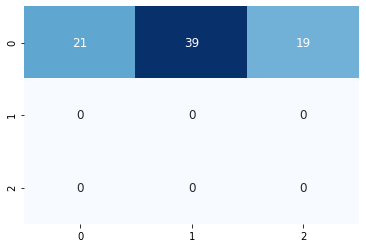

78/78 [==============================] - 0s 335us/sample - loss: 1.5536 - accuracy: 0.3205


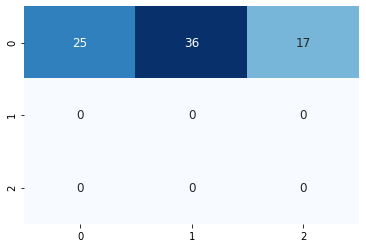

77/77 [==============================] - 0s 277us/sample - loss: 1.5412 - accuracy: 0.3896


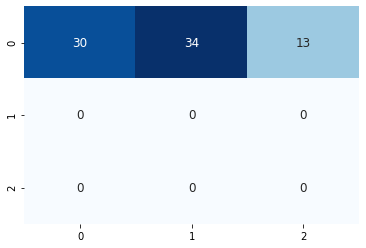

76/76 [==============================] - 0s 278us/sample - loss: 1.7115 - accuracy: 0.3158


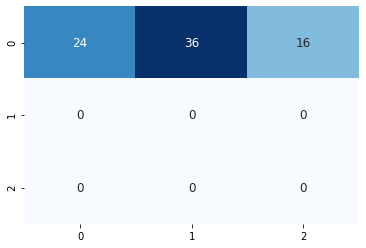

76/76 [==============================] - 0s 300us/sample - loss: 1.5779 - accuracy: 0.3553


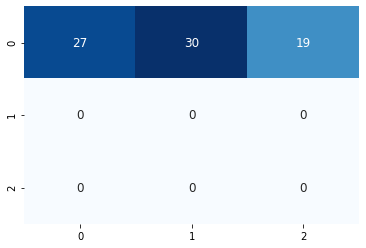

75/75 [==============================] - 0s 324us/sample - loss: 1.5108 - accuracy: 0.3733


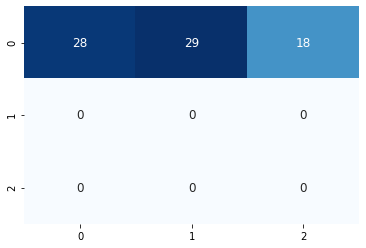

76/76 [==============================] - 0s 292us/sample - loss: 1.5044 - accuracy: 0.3947


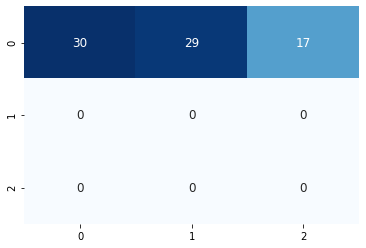

76/76 [==============================] - 0s 316us/sample - loss: 1.6813 - accuracy: 0.3158


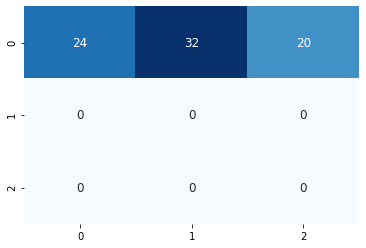

76/76 [==============================] - 0s 318us/sample - loss: 1.7061 - accuracy: 0.3158


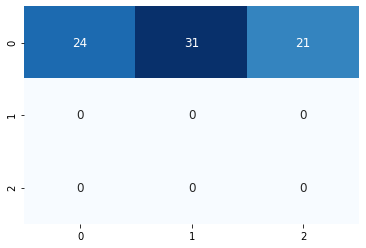

75/75 [==============================] - 0s 307us/sample - loss: 1.5764 - accuracy: 0.3867


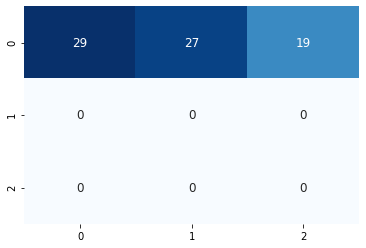

75/75 [==============================] - 0s 325us/sample - loss: 1.5482 - accuracy: 0.4000


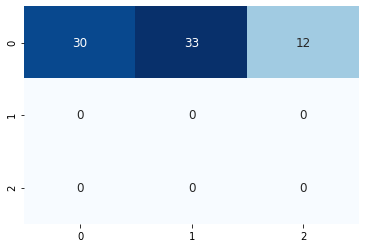

74/74 [==============================] - 0s 287us/sample - loss: 1.4674 - accuracy: 0.3649


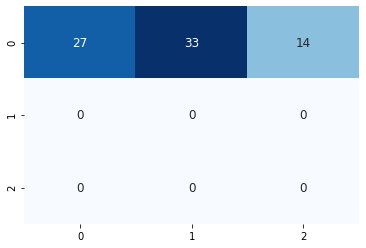

75/75 [==============================] - 0s 279us/sample - loss: 1.6491 - accuracy: 0.2800


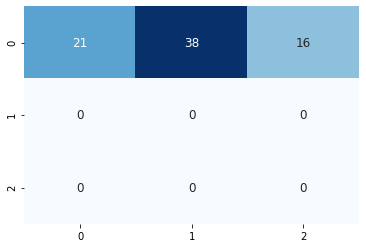

75/75 [==============================] - 0s 281us/sample - loss: 1.8248 - accuracy: 0.3333


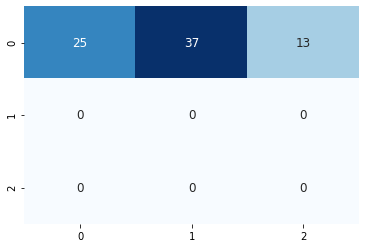

74/74 [==============================] - 0s 326us/sample - loss: 1.8295 - accuracy: 0.3108


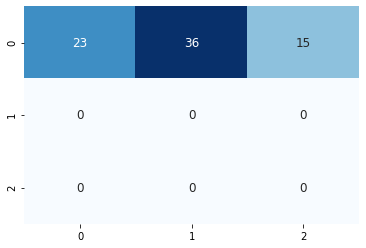

73/73 [==============================] - 0s 308us/sample - loss: 1.6733 - accuracy: 0.3562


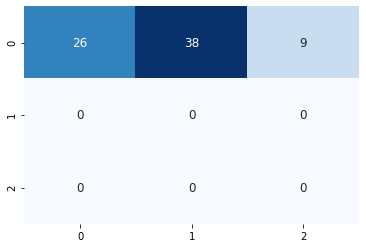

73/73 [==============================] - 0s 345us/sample - loss: 1.6517 - accuracy: 0.3014


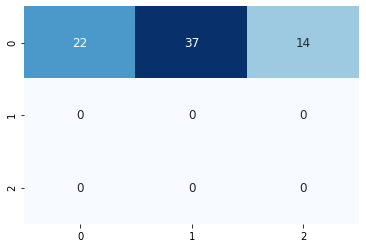

73/73 [==============================] - 0s 290us/sample - loss: 1.7346 - accuracy: 0.2877


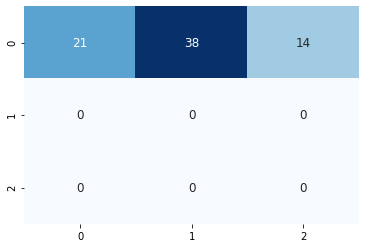

73/73 [==============================] - 0s 304us/sample - loss: 1.7170 - accuracy: 0.3699


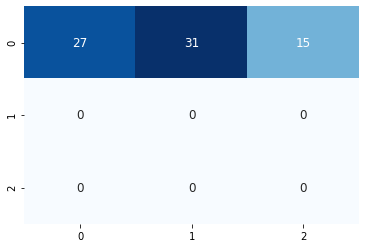

71/71 [==============================] - 0s 306us/sample - loss: 1.4459 - accuracy: 0.4225


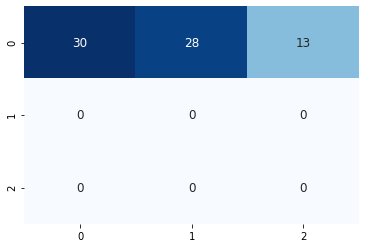

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3987 samples, validate on 936 samples
Epoch 1/300
3987/3987 [==============================] - 3s 775us/sample - loss: 0.9682 - accuracy: 0.4575 - val_loss: 1.0303 - val_accuracy: 0.4049
Epoch 2/300
3987/3987 [==============================] - 1s 222us/sample - loss: 0.7194 - accuracy: 0.6514 - val_loss: 1.0582 - val_accuracy: 0.4327
Epoch 3/300
3987/3987 [==============================] - 1s 189us/sample - loss: 0.5490 - accuracy: 0.7459 - val_loss: 1.1487 - val_accuracy: 0.4712
Epoch 4/300
3987/3987 [==============================] - 1s 174us/sample - loss: 0.4207 - accuracy: 0.8154 - val_loss: 1.2945 - val_accuracy: 0.4829
Epoch 00004: early stopping
66/66 [==============================] - 0s 5ms/sample - loss: 1.5061 - accuracy: 0.3030


8it [3:20:45, 1458.32s/it]
100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 288 steps, validate for 67 steps
Epoch 1/300
288/288 [==============================] - 29s 102ms/step - loss: 1.4085 - accuracy: 0.4443 - val_loss: 1.1875 - val_accuracy: 0.4029
Epoch 2/300
288/288 [==============================] - 28s 95ms/step - loss: 1.0295 - accuracy: 0.5023 - val_loss: 1.1329 - val_accuracy: 0.4247
Epoch 3/300
288/288 [==============================] - 28s 96ms/step - loss: 0.9738 - accuracy: 0.5244 - val_loss: 1.1743 - val_accuracy: 0.4295
Epoch 4/300
288/288 [==============================] - 28s 98ms/step - loss: 0.9513 - accuracy: 0.5376 - val_loss: 1.1984 - val_accuracy: 0.4120
Epoch 5/300
288/288 [==============================] - 28s 97ms/step - loss: 0.9326 - accuracy: 0.5517 - val_loss: 1.2173 - val_accuracy: 0.4042
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 288 steps, validate for 67 steps
Epoch 1/300
288/288 [=====

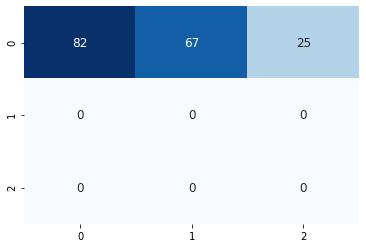

169/169 [==============================] - 0s 224us/sample - loss: 1.1877 - accuracy: 0.4379


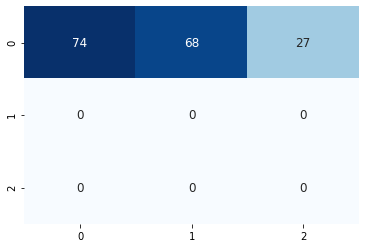

170/170 [==============================] - 0s 221us/sample - loss: 1.1906 - accuracy: 0.4588


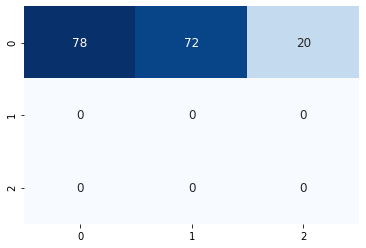

167/167 [==============================] - 0s 261us/sample - loss: 1.2072 - accuracy: 0.4551


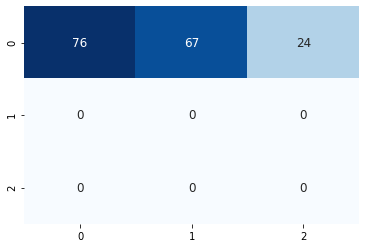

168/168 [==============================] - 0s 241us/sample - loss: 1.2132 - accuracy: 0.4226


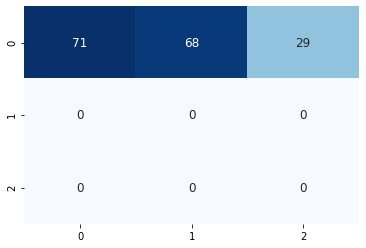

169/169 [==============================] - 0s 234us/sample - loss: 1.2301 - accuracy: 0.4438


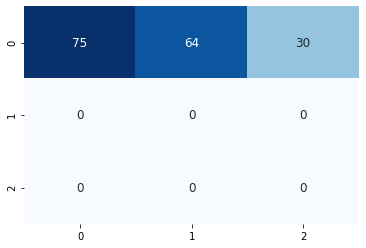

169/169 [==============================] - 0s 266us/sample - loss: 1.2597 - accuracy: 0.3964


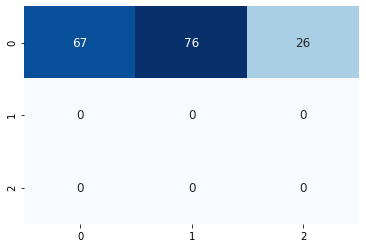

167/167 [==============================] - 0s 254us/sample - loss: 1.4623 - accuracy: 0.3473


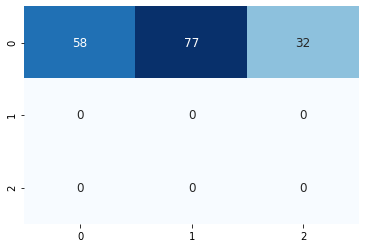

166/166 [==============================] - 0s 264us/sample - loss: 1.2927 - accuracy: 0.4398


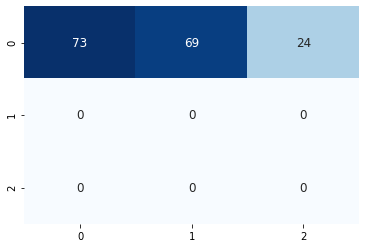

164/164 [==============================] - 0s 273us/sample - loss: 1.3118 - accuracy: 0.4207


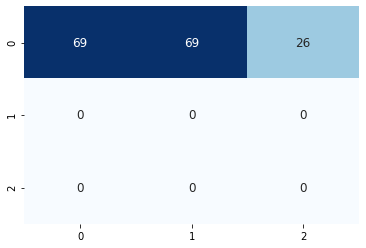

164/164 [==============================] - 0s 344us/sample - loss: 1.3491 - accuracy: 0.3963


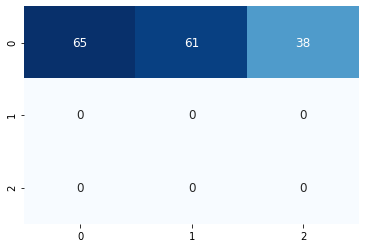

164/164 [==============================] - 0s 264us/sample - loss: 1.3685 - accuracy: 0.4268


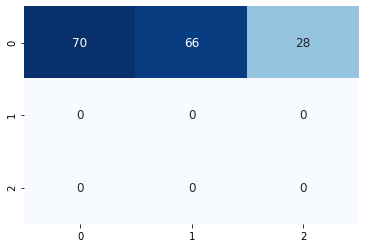

163/163 [==============================] - 0s 259us/sample - loss: 1.3866 - accuracy: 0.4172


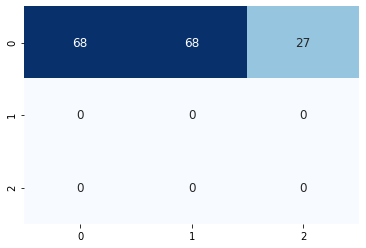

161/161 [==============================] - 0s 275us/sample - loss: 1.3399 - accuracy: 0.4286


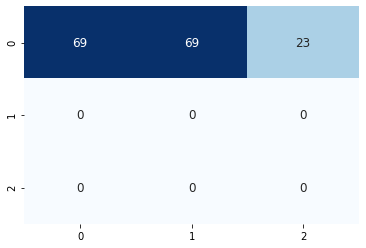

159/159 [==============================] - 0s 275us/sample - loss: 1.3553 - accuracy: 0.4088


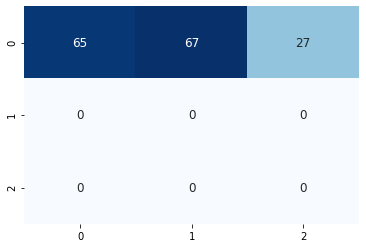

161/161 [==============================] - 0s 269us/sample - loss: 1.3445 - accuracy: 0.4907


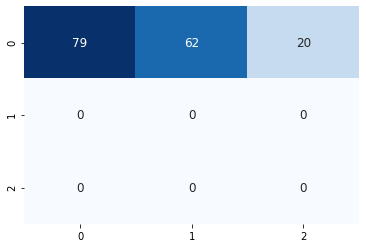

159/159 [==============================] - 0s 245us/sample - loss: 1.2682 - accuracy: 0.4717


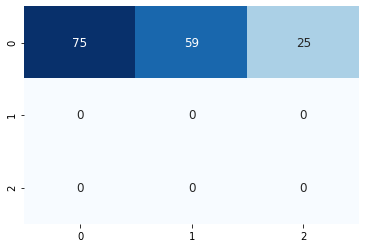

158/158 [==============================] - 0s 231us/sample - loss: 1.3904 - accuracy: 0.4494


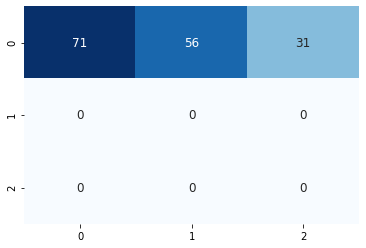

159/159 [==============================] - 0s 230us/sample - loss: 1.4425 - accuracy: 0.4214


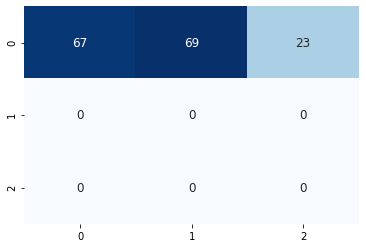

158/158 [==============================] - 0s 242us/sample - loss: 1.4494 - accuracy: 0.4304


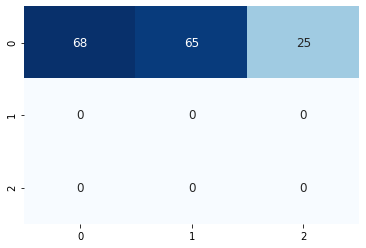

157/157 [==============================] - 0s 259us/sample - loss: 1.4541 - accuracy: 0.3758


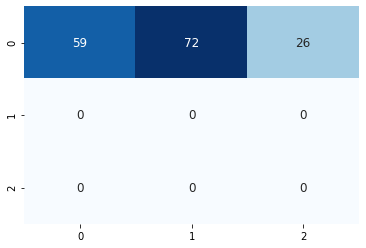

157/157 [==============================] - 0s 270us/sample - loss: 1.4425 - accuracy: 0.4204


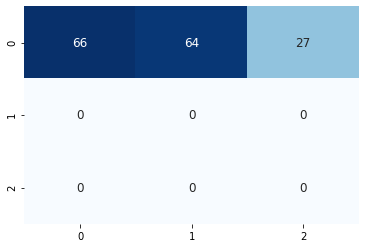

157/157 [==============================] - 0s 289us/sample - loss: 1.5217 - accuracy: 0.4076


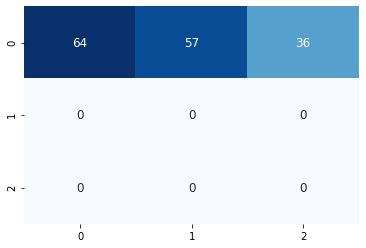

157/157 [==============================] - 0s 267us/sample - loss: 1.5052 - accuracy: 0.4268


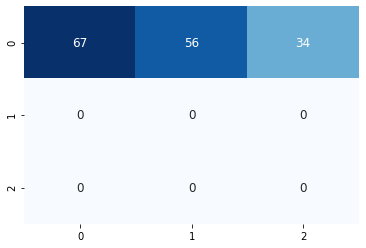

154/154 [==============================] - 0s 285us/sample - loss: 1.4916 - accuracy: 0.4156


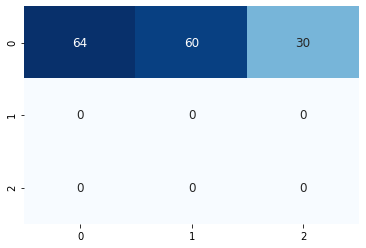

153/153 [==============================] - 0s 264us/sample - loss: 1.4269 - accuracy: 0.4444


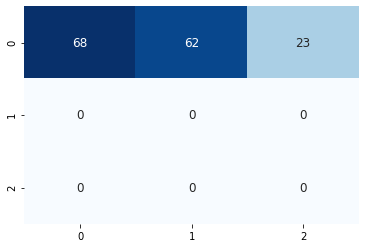

153/153 [==============================] - 0s 302us/sample - loss: 1.4982 - accuracy: 0.3529


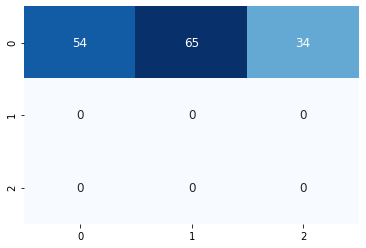

153/153 [==============================] - 0s 304us/sample - loss: 1.3185 - accuracy: 0.4902


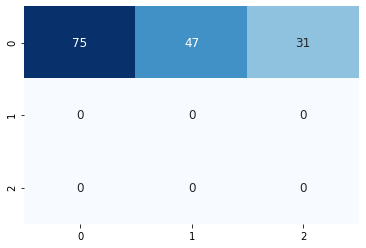

150/150 [==============================] - 0s 304us/sample - loss: 1.4567 - accuracy: 0.4533


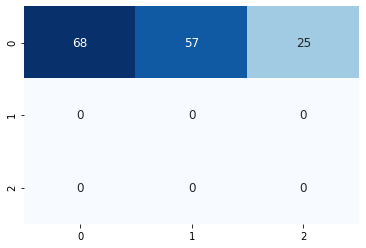

150/150 [==============================] - 0s 272us/sample - loss: 1.5389 - accuracy: 0.3933


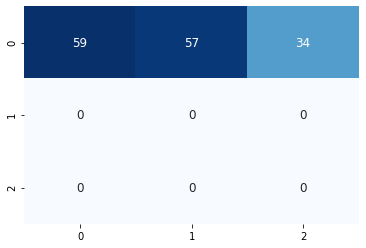

152/152 [==============================] - 0s 258us/sample - loss: 1.4318 - accuracy: 0.4539


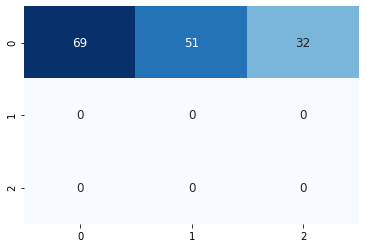

151/151 [==============================] - 0s 251us/sample - loss: 1.3872 - accuracy: 0.3974


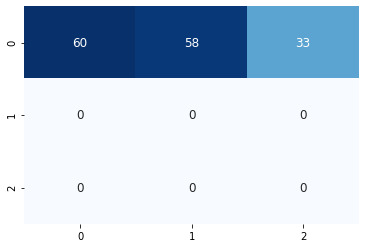

147/147 [==============================] - 0s 238us/sample - loss: 1.4973 - accuracy: 0.3741


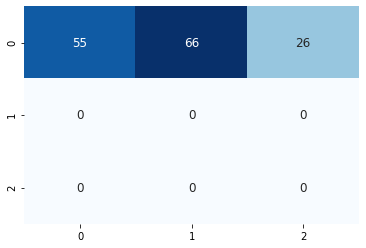

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3919 samples, validate on 931 samples
Epoch 1/300
3919/3919 [==============================] - 3s 712us/sample - loss: 1.0097 - accuracy: 0.4453 - val_loss: 1.0549 - val_accuracy: 0.3641
Epoch 2/300
3919/3919 [==============================] - 1s 204us/sample - loss: 0.7771 - accuracy: 0.5841 - val_loss: 1.0973 - val_accuracy: 0.3899
Epoch 3/300
3919/3919 [==============================] - 1s 231us/sample - loss: 0.6344 - accuracy: 0.6476 - val_loss: 1.1873 - val_accuracy: 0.4049
Epoch 4/300
3919/3919 [==============================] - 1s 217us/sample - loss: 0.5427 - accuracy: 0.7145 - val_loss: 1.2676 - val_accuracy: 0.4404
Epoch 00004: early stopping
139/139 [==============================] - 0s 3ms/sample - loss: 1.8600 - accuracy: 0.2518


9it [3:43:38, 1432.58s/it]
100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 288 steps, validate for 67 steps
Epoch 1/300
288/288 [==============================] - 29s 102ms/step - loss: 1.4535 - accuracy: 0.4403 - val_loss: 1.2114 - val_accuracy: 0.4019
Epoch 2/300
288/288 [==============================] - 28s 96ms/step - loss: 1.0527 - accuracy: 0.4912 - val_loss: 1.1617 - val_accuracy: 0.3793
Epoch 3/300
288/288 [==============================] - 28s 96ms/step - loss: 0.9940 - accuracy: 0.5130 - val_loss: 1.1950 - val_accuracy: 0.4535
Epoch 4/300
288/288 [==============================] - 28s 97ms/step - loss: 0.9706 - accuracy: 0.5268 - val_loss: 1.2190 - val_accuracy: 0.3628
Epoch 5/300
288/288 [==============================] - 28s 96ms/step - loss: 0.9525 - accuracy: 0.5404 - val_loss: 1.2365 - val_accuracy: 0.3535
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 288 steps, validate for 67 steps
Epoch 1/300
288/288 [=====

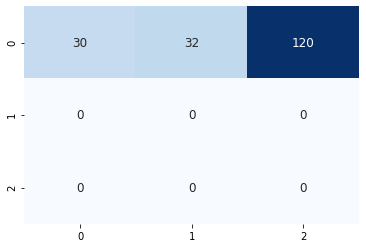

181/181 [==============================] - 0s 233us/sample - loss: 2.1329 - accuracy: 0.1878


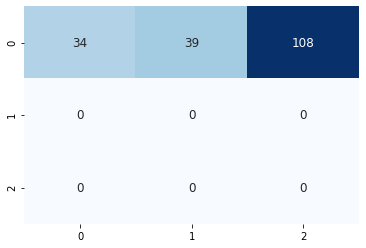

178/178 [==============================] - 0s 288us/sample - loss: 2.1778 - accuracy: 0.1573


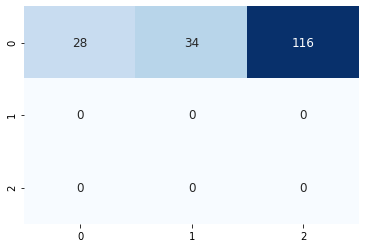

175/175 [==============================] - 0s 241us/sample - loss: 2.4552 - accuracy: 0.1600


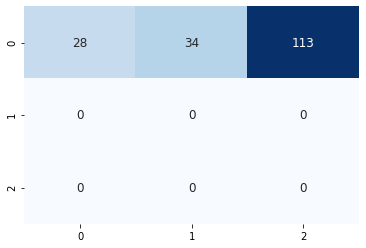

175/175 [==============================] - 0s 234us/sample - loss: 2.1518 - accuracy: 0.1600


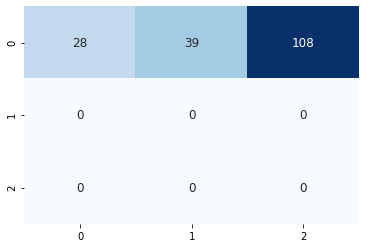

175/175 [==============================] - 0s 260us/sample - loss: 2.2226 - accuracy: 0.1771


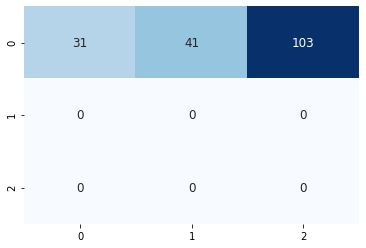

172/172 [==============================] - 0s 248us/sample - loss: 2.1586 - accuracy: 0.2035


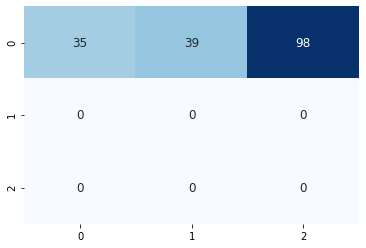

172/172 [==============================] - 0s 251us/sample - loss: 2.3045 - accuracy: 0.1802


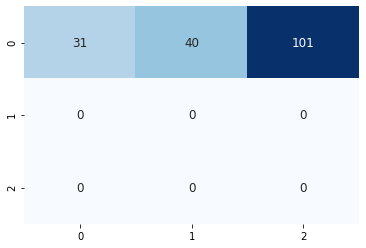

170/170 [==============================] - 0s 263us/sample - loss: 2.3596 - accuracy: 0.1765


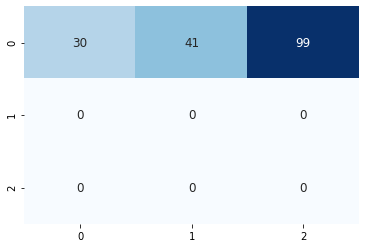

168/168 [==============================] - 0s 282us/sample - loss: 2.2491 - accuracy: 0.1845


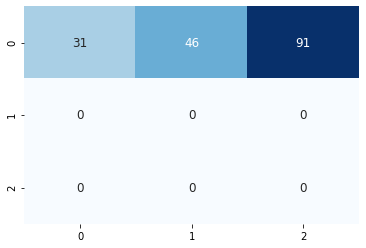

168/168 [==============================] - 0s 272us/sample - loss: 2.2997 - accuracy: 0.1786


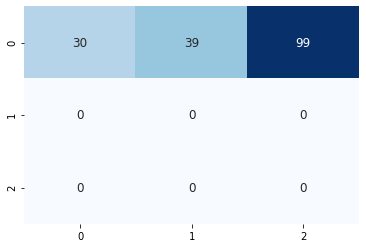

166/166 [==============================] - 0s 284us/sample - loss: 2.3090 - accuracy: 0.1807


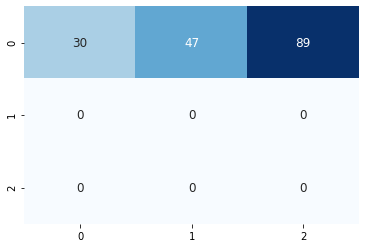

164/164 [==============================] - 0s 246us/sample - loss: 2.3769 - accuracy: 0.2012


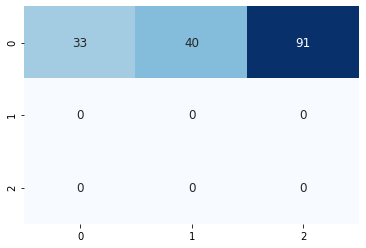

164/164 [==============================] - 0s 278us/sample - loss: 2.1946 - accuracy: 0.1951


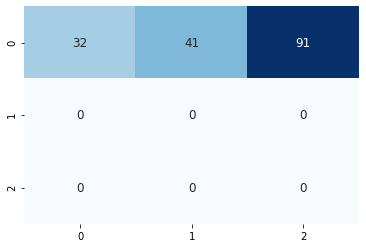

163/163 [==============================] - 0s 266us/sample - loss: 2.3160 - accuracy: 0.1656


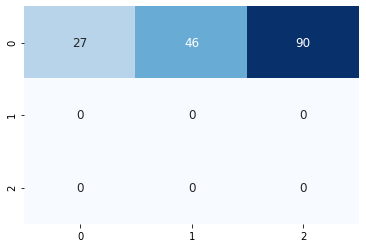

161/161 [==============================] - 0s 245us/sample - loss: 2.3390 - accuracy: 0.1615


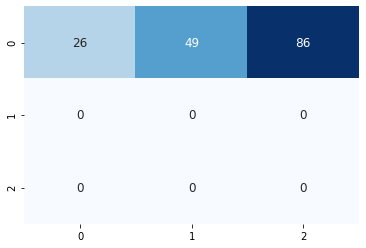

162/162 [==============================] - 0s 279us/sample - loss: 2.1359 - accuracy: 0.2037


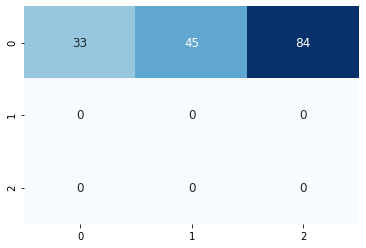

159/159 [==============================] - 0s 284us/sample - loss: 2.3249 - accuracy: 0.1698


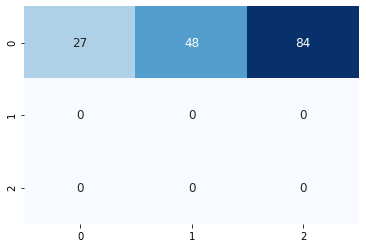

158/158 [==============================] - 0s 251us/sample - loss: 2.2547 - accuracy: 0.2215


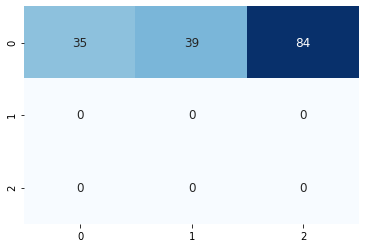

159/159 [==============================] - 0s 248us/sample - loss: 2.1946 - accuracy: 0.2013


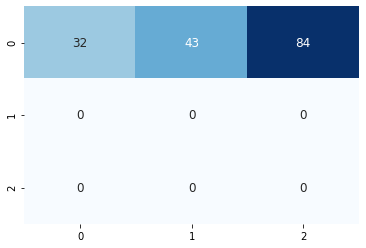

158/158 [==============================] - 0s 249us/sample - loss: 2.2173 - accuracy: 0.2025


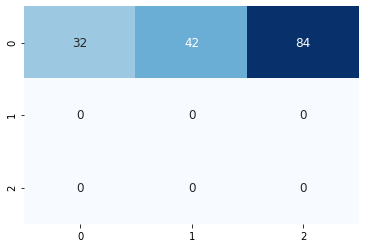

158/158 [==============================] - 0s 253us/sample - loss: 2.0860 - accuracy: 0.1709


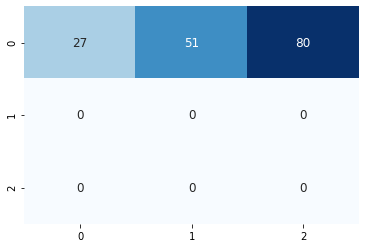

160/160 [==============================] - 0s 1ms/sample - loss: 2.0758 - accuracy: 0.2375


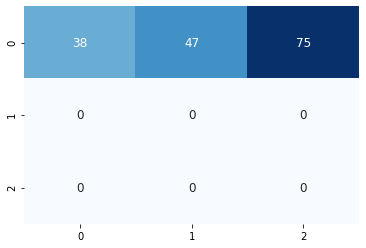

157/157 [==============================] - 0s 249us/sample - loss: 2.1233 - accuracy: 0.2038


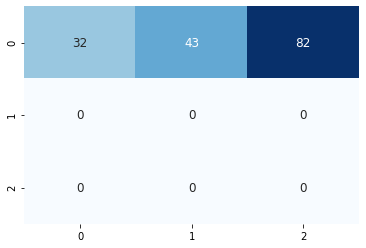

154/154 [==============================] - 0s 252us/sample - loss: 2.1567 - accuracy: 0.2078


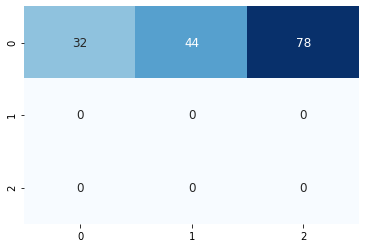

155/155 [==============================] - 0s 247us/sample - loss: 2.0692 - accuracy: 0.2194


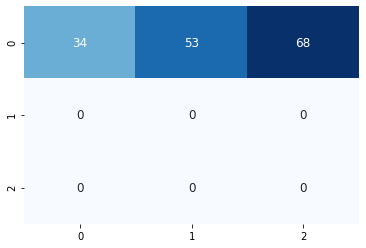

154/154 [==============================] - 0s 234us/sample - loss: 2.1926 - accuracy: 0.1623


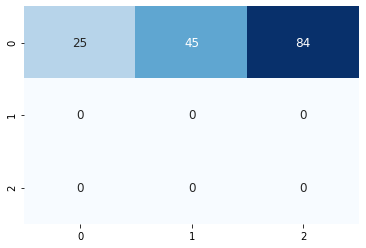

153/153 [==============================] - 0s 273us/sample - loss: 2.0987 - accuracy: 0.2549


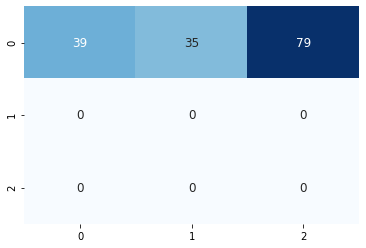

151/151 [==============================] - 0s 259us/sample - loss: 2.1440 - accuracy: 0.2185


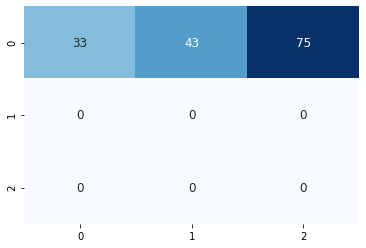

151/151 [==============================] - 0s 243us/sample - loss: 1.9299 - accuracy: 0.1987


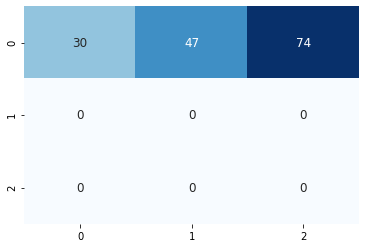

151/151 [==============================] - 0s 262us/sample - loss: 1.9882 - accuracy: 0.2649


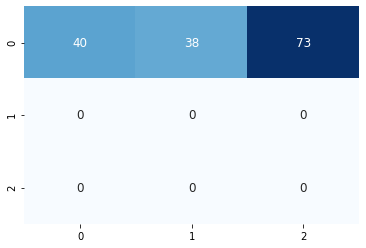

147/147 [==============================] - 0s 237us/sample - loss: 2.1152 - accuracy: 0.2585


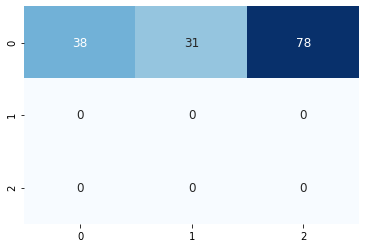

148/148 [==============================] - 0s 284us/sample - loss: 2.2488 - accuracy: 0.2162


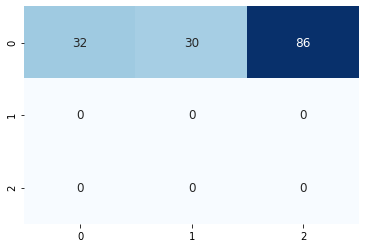

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3918 samples, validate on 928 samples
Epoch 1/300
3918/3918 [==============================] - 3s 698us/sample - loss: 0.9801 - accuracy: 0.4949 - val_loss: 1.0718 - val_accuracy: 0.4181
Epoch 2/300
3918/3918 [==============================] - 1s 230us/sample - loss: 0.7855 - accuracy: 0.6348 - val_loss: 1.1216 - val_accuracy: 0.4267
Epoch 3/300
3918/3918 [==============================] - 1s 216us/sample - loss: 0.6503 - accuracy: 0.6973 - val_loss: 1.2105 - val_accuracy: 0.4450
Epoch 4/300
3918/3918 [==============================] - 1s 232us/sample - loss: 0.5391 - accuracy: 0.7596 - val_loss: 1.3250 - val_accuracy: 0.4461
Epoch 00004: early stopping
143/143 [==============================] - 0s 3ms/sample - loss: 0.8145 - accuracy: 0.6503


10it [4:06:16, 1410.21s/it]
100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 67 steps
Epoch 1/300
289/289 [==============================] - 30s 103ms/step - loss: 1.4583 - accuracy: 0.4293 - val_loss: 1.2025 - val_accuracy: 0.5081
Epoch 2/300
289/289 [==============================] - 28s 96ms/step - loss: 1.0500 - accuracy: 0.4929 - val_loss: 1.1519 - val_accuracy: 0.3809
Epoch 3/300
289/289 [==============================] - 28s 98ms/step - loss: 0.9953 - accuracy: 0.5129 - val_loss: 1.1765 - val_accuracy: 0.3598
Epoch 4/300
289/289 [==============================] - 28s 98ms/step - loss: 0.9659 - accuracy: 0.5296 - val_loss: 1.1992 - val_accuracy: 0.3938
Epoch 5/300
289/289 [==============================] - 28s 97ms/step - loss: 0.9547 - accuracy: 0.5382 - val_loss: 1.2324 - val_accuracy: 0.3977
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 289 steps, validate for 67 steps
Epoch 1/300
289/289 [=====

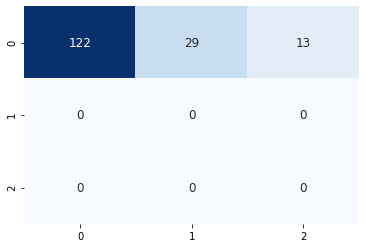

161/161 [==============================] - 0s 256us/sample - loss: 0.6233 - accuracy: 0.7640


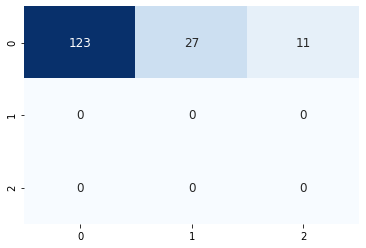

157/157 [==============================] - 0s 233us/sample - loss: 0.6322 - accuracy: 0.7898


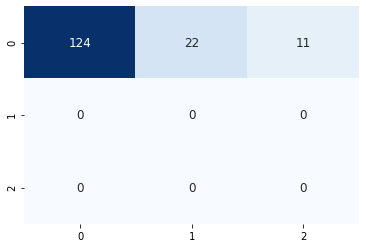

158/158 [==============================] - 0s 258us/sample - loss: 0.6313 - accuracy: 0.7975


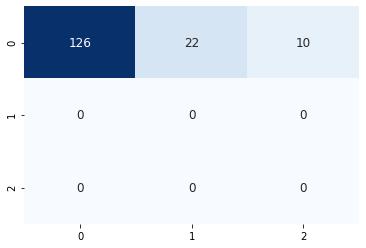

158/158 [==============================] - 0s 218us/sample - loss: 0.6279 - accuracy: 0.7911


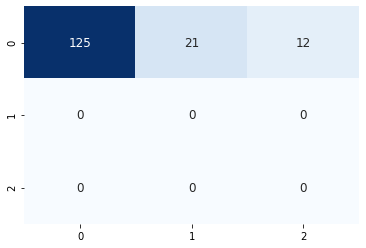

156/156 [==============================] - 0s 257us/sample - loss: 0.6552 - accuracy: 0.7885


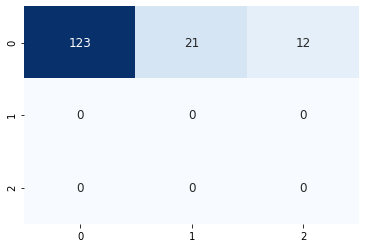

153/153 [==============================] - 0s 272us/sample - loss: 0.4854 - accuracy: 0.8758


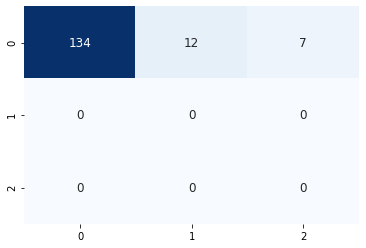

155/155 [==============================] - 0s 246us/sample - loss: 0.6023 - accuracy: 0.8065


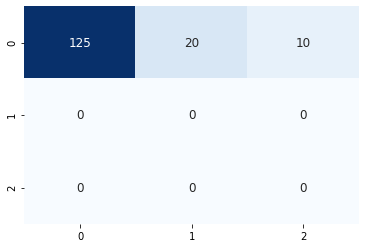

153/153 [==============================] - 0s 267us/sample - loss: 0.6298 - accuracy: 0.7712


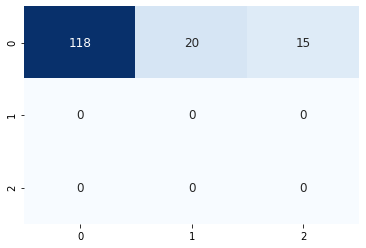

150/150 [==============================] - 0s 249us/sample - loss: 0.6480 - accuracy: 0.7733


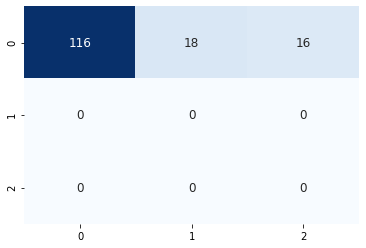

149/149 [==============================] - 0s 264us/sample - loss: 0.6629 - accuracy: 0.7450


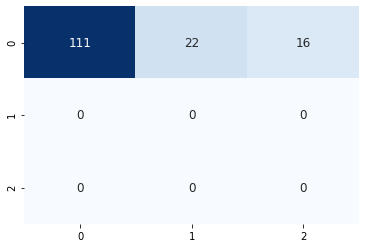

148/148 [==============================] - 0s 239us/sample - loss: 0.6172 - accuracy: 0.8176


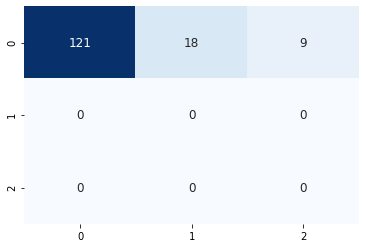

146/146 [==============================] - 0s 243us/sample - loss: 0.7192 - accuracy: 0.7192


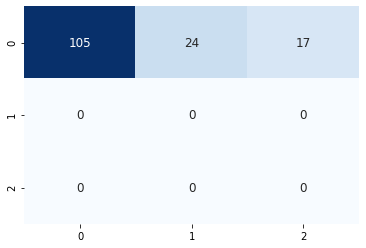

148/148 [==============================] - 0s 291us/sample - loss: 0.6793 - accuracy: 0.7635


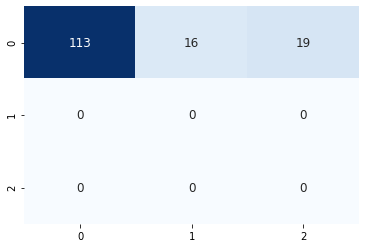

148/148 [==============================] - 0s 281us/sample - loss: 0.7331 - accuracy: 0.7162


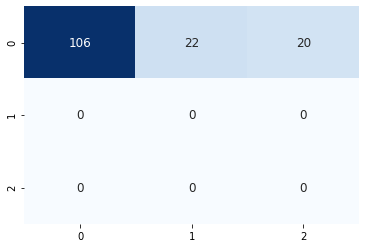

146/146 [==============================] - 0s 271us/sample - loss: 0.7967 - accuracy: 0.6644


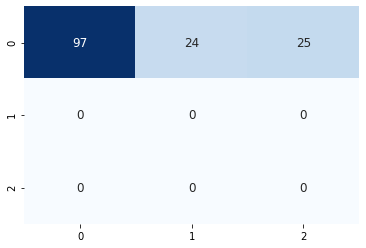

144/144 [==============================] - 0s 246us/sample - loss: 0.7959 - accuracy: 0.6736


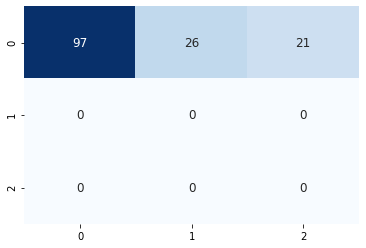

143/143 [==============================] - 0s 278us/sample - loss: 0.6936 - accuracy: 0.7063


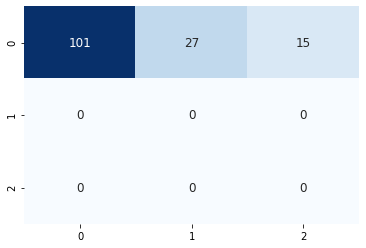

143/143 [==============================] - 0s 268us/sample - loss: 0.7726 - accuracy: 0.7343


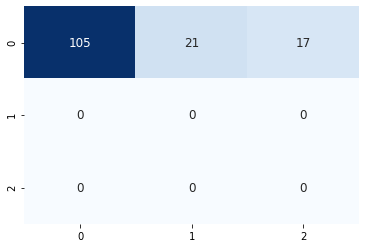

142/142 [==============================] - 0s 289us/sample - loss: 0.8113 - accuracy: 0.6761


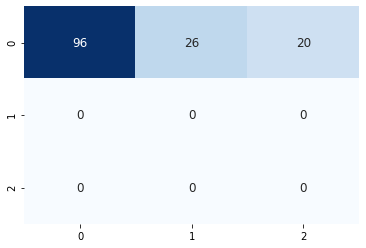

142/142 [==============================] - 0s 280us/sample - loss: 0.9374 - accuracy: 0.6690


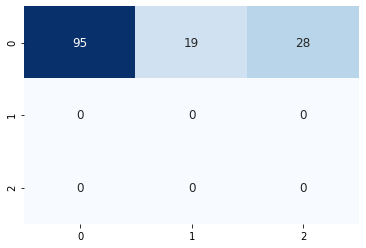

142/142 [==============================] - 0s 248us/sample - loss: 0.8662 - accuracy: 0.6268


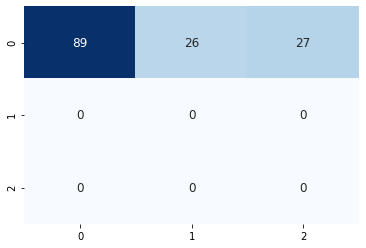

140/140 [==============================] - 0s 271us/sample - loss: 0.9647 - accuracy: 0.6500


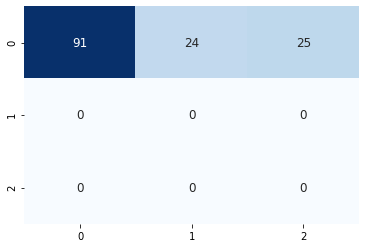

139/139 [==============================] - 0s 259us/sample - loss: 0.9588 - accuracy: 0.6403


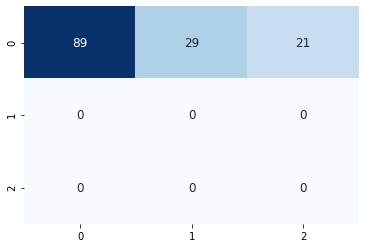

139/139 [==============================] - 0s 262us/sample - loss: 0.9356 - accuracy: 0.7050


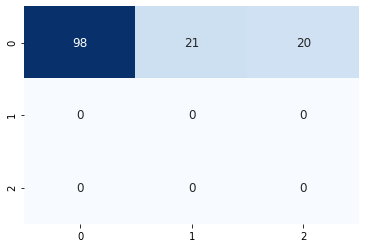

139/139 [==============================] - 0s 267us/sample - loss: 0.9263 - accuracy: 0.6403


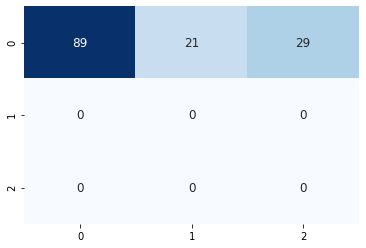

138/138 [==============================] - 0s 272us/sample - loss: 0.9006 - accuracy: 0.6522


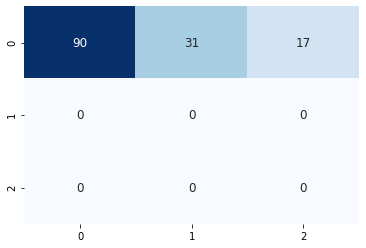

137/137 [==============================] - 0s 247us/sample - loss: 0.8923 - accuracy: 0.6642


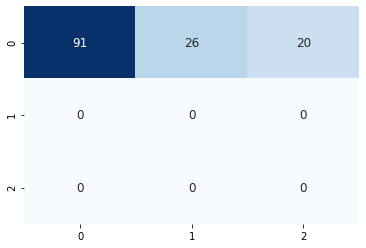

136/136 [==============================] - 0s 263us/sample - loss: 0.9836 - accuracy: 0.6250


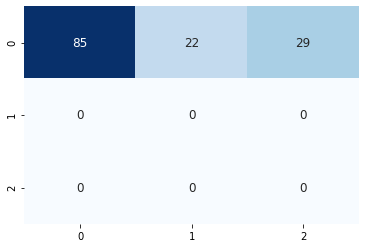

136/136 [==============================] - 0s 277us/sample - loss: 0.9057 - accuracy: 0.6912


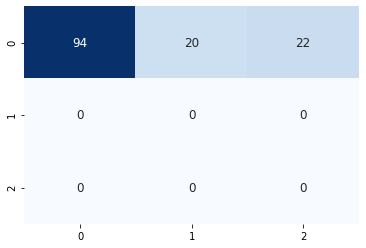

136/136 [==============================] - 0s 289us/sample - loss: 0.9026 - accuracy: 0.7132


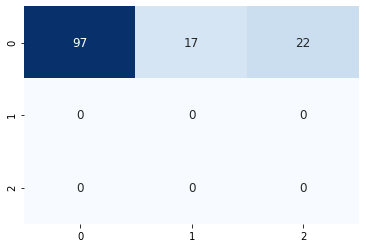

136/136 [==============================] - 0s 263us/sample - loss: 0.9228 - accuracy: 0.6765


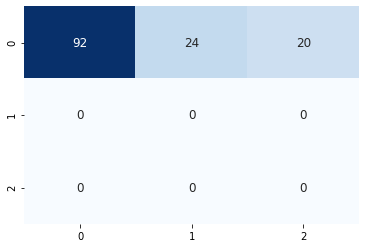

134/134 [==============================] - 0s 244us/sample - loss: 0.8913 - accuracy: 0.6866


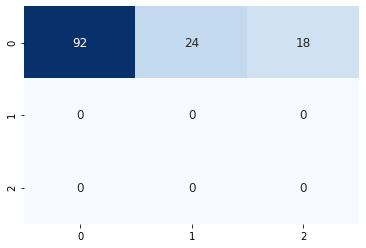

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3931 samples, validate on 925 samples
Epoch 1/300
3931/3931 [==============================] - 3s 718us/sample - loss: 1.0434 - accuracy: 0.4019 - val_loss: 1.0953 - val_accuracy: 0.3762
Epoch 2/300
3931/3931 [==============================] - 1s 226us/sample - loss: 0.8623 - accuracy: 0.5551 - val_loss: 1.1000 - val_accuracy: 0.3968
Epoch 3/300
3931/3931 [==============================] - 1s 210us/sample - loss: 0.7419 - accuracy: 0.6197 - val_loss: 1.1379 - val_accuracy: 0.4076
Epoch 4/300
3931/3931 [==============================] - 1s 218us/sample - loss: 0.6361 - accuracy: 0.6790 - val_loss: 1.2133 - val_accuracy: 0.4249
Epoch 00004: early stopping
133/133 [==============================] - 0s 3ms/sample - loss: 1.0208 - accuracy: 0.4812


11it [4:29:06, 1398.09s/it]
100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 290 steps, validate for 67 steps
Epoch 1/300
290/290 [==============================] - 30s 102ms/step - loss: 1.4412 - accuracy: 0.4295 - val_loss: 1.1946 - val_accuracy: 0.3776
Epoch 2/300
290/290 [==============================] - 28s 97ms/step - loss: 1.0449 - accuracy: 0.4856 - val_loss: 1.1428 - val_accuracy: 0.3989
Epoch 3/300
290/290 [==============================] - 28s 98ms/step - loss: 0.9899 - accuracy: 0.5113 - val_loss: 1.1749 - val_accuracy: 0.3549
Epoch 4/300
290/290 [==============================] - 28s 98ms/step - loss: 0.9661 - accuracy: 0.5242 - val_loss: 1.2103 - val_accuracy: 0.4032
Epoch 5/300
290/290 [==============================] - 28s 98ms/step - loss: 0.9530 - accuracy: 0.5334 - val_loss: 1.2049 - val_accuracy: 0.4024
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 290 steps, validate for 67 steps
Epoch 1/300
290/290 [=====

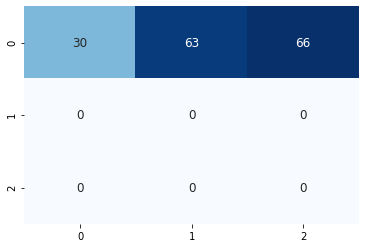

147/147 [==============================] - 0s 238us/sample - loss: 2.7435 - accuracy: 0.2041


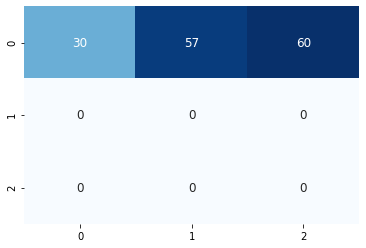

144/144 [==============================] - 0s 256us/sample - loss: 2.7875 - accuracy: 0.2361


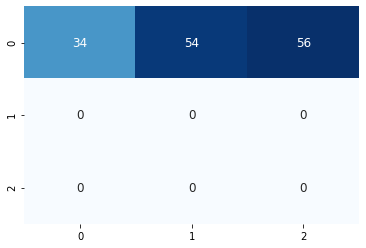

141/141 [==============================] - 0s 264us/sample - loss: 2.8644 - accuracy: 0.2482


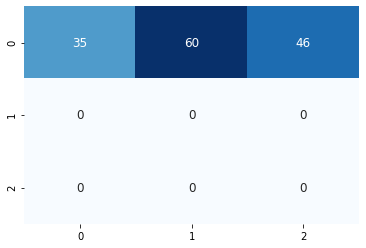

140/140 [==============================] - 0s 266us/sample - loss: 2.7928 - accuracy: 0.2429


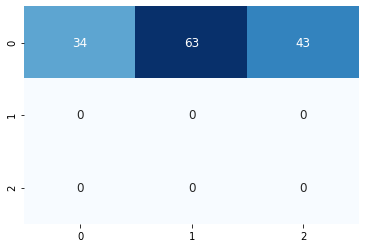

140/140 [==============================] - 0s 261us/sample - loss: 2.9277 - accuracy: 0.1571


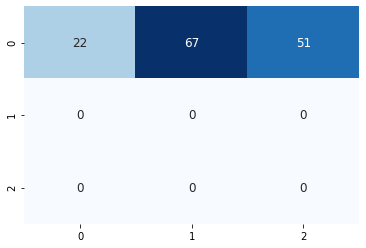

138/138 [==============================] - 0s 255us/sample - loss: 2.8533 - accuracy: 0.2319


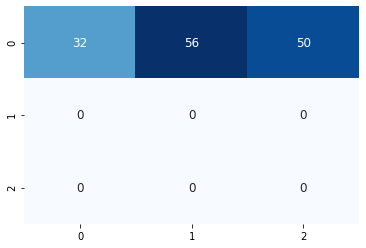

134/134 [==============================] - 0s 252us/sample - loss: 2.9370 - accuracy: 0.2015


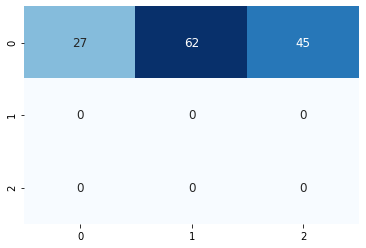

135/135 [==============================] - 0s 264us/sample - loss: 2.8449 - accuracy: 0.2222


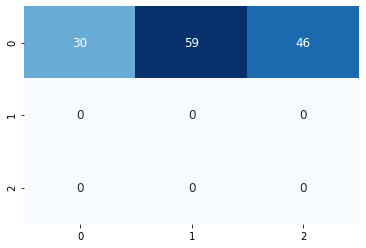

135/135 [==============================] - 0s 367us/sample - loss: 3.0007 - accuracy: 0.1481


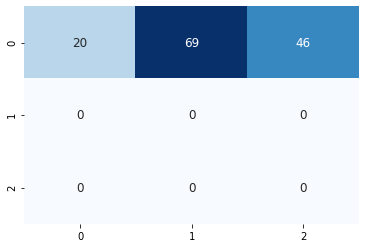

134/134 [==============================] - 0s 284us/sample - loss: 2.9915 - accuracy: 0.1567


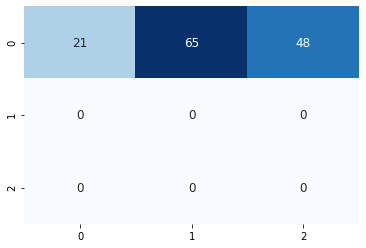

134/134 [==============================] - 0s 276us/sample - loss: 3.0342 - accuracy: 0.1642


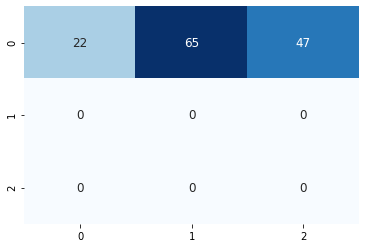

135/135 [==============================] - 0s 308us/sample - loss: 2.9293 - accuracy: 0.1704


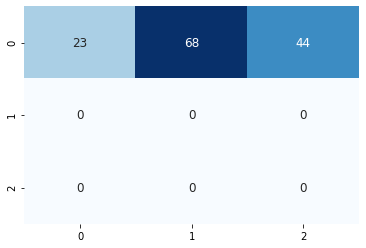

132/132 [==============================] - 0s 290us/sample - loss: 3.0132 - accuracy: 0.1667


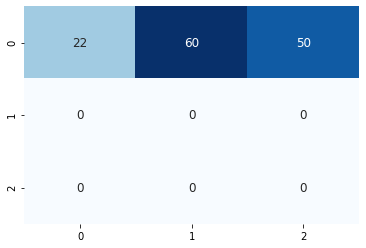

132/132 [==============================] - 0s 290us/sample - loss: 2.9694 - accuracy: 0.1288


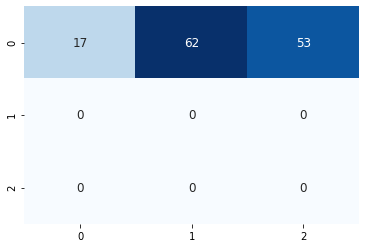

131/131 [==============================] - 0s 300us/sample - loss: 2.8677 - accuracy: 0.1908


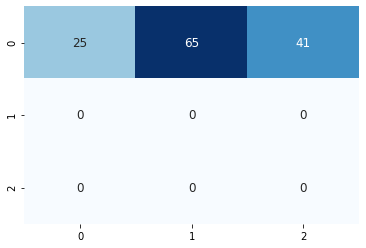

130/130 [==============================] - 0s 281us/sample - loss: 2.9231 - accuracy: 0.1769


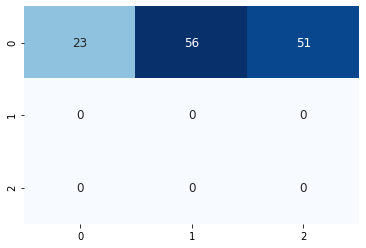

130/130 [==============================] - 0s 285us/sample - loss: 2.9003 - accuracy: 0.1308


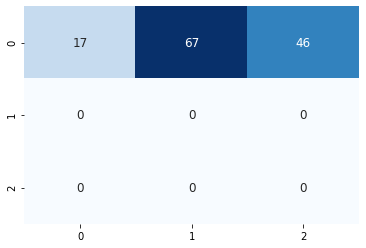

129/129 [==============================] - 0s 291us/sample - loss: 3.1369 - accuracy: 0.1395


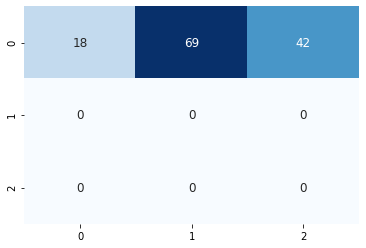

127/127 [==============================] - 0s 250us/sample - loss: 3.1664 - accuracy: 0.1811


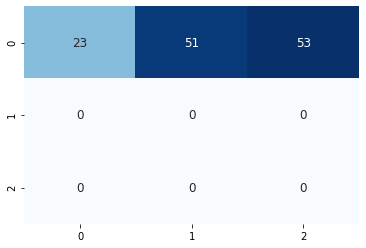

127/127 [==============================] - 0s 257us/sample - loss: 2.8591 - accuracy: 0.1811


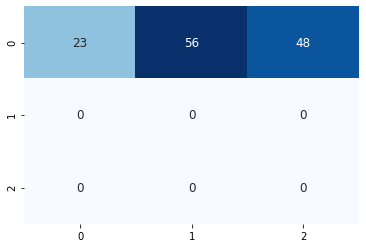

128/128 [==============================] - 0s 2ms/sample - loss: 2.9243 - accuracy: 0.1562


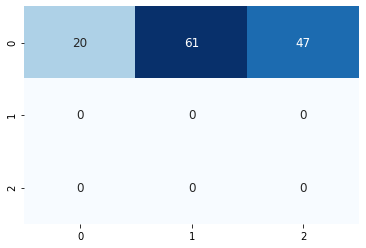

127/127 [==============================] - 0s 264us/sample - loss: 3.2611 - accuracy: 0.1575


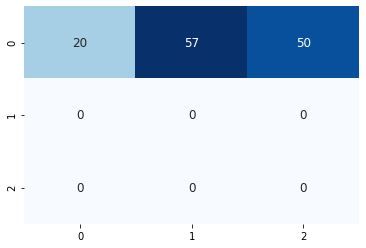

127/127 [==============================] - 0s 242us/sample - loss: 3.0926 - accuracy: 0.1575


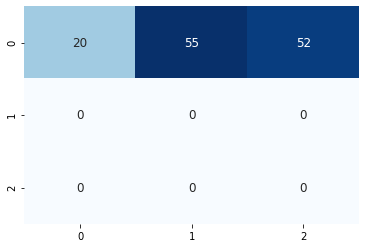

126/126 [==============================] - 0s 277us/sample - loss: 3.0301 - accuracy: 0.1270


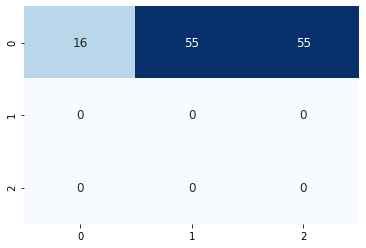

126/126 [==============================] - 0s 246us/sample - loss: 2.8898 - accuracy: 0.1825


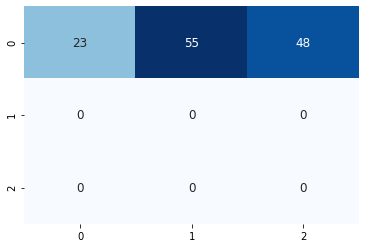

122/122 [==============================] - 0s 273us/sample - loss: 3.0923 - accuracy: 0.1393


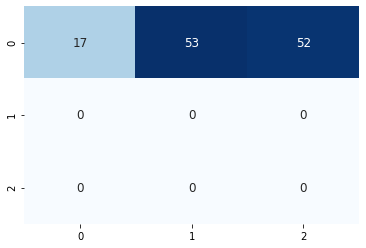

122/122 [==============================] - 0s 274us/sample - loss: 3.0038 - accuracy: 0.1639


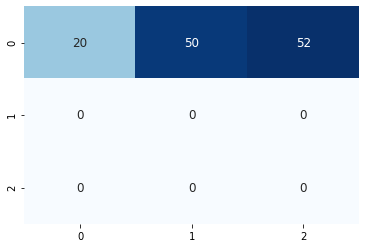

123/123 [==============================] - 0s 291us/sample - loss: 3.0723 - accuracy: 0.1870


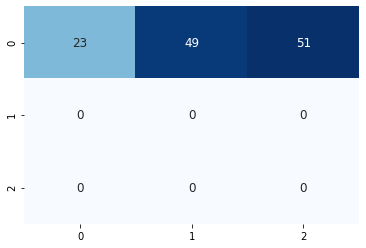

122/122 [==============================] - 0s 254us/sample - loss: 3.1426 - accuracy: 0.1393


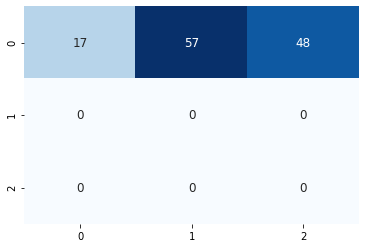

122/122 [==============================] - 0s 244us/sample - loss: 3.3707 - accuracy: 0.1230


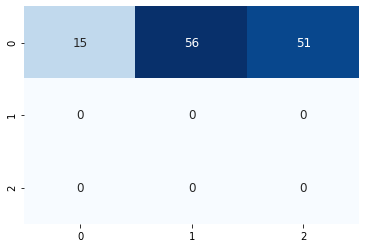

122/122 [==============================] - 0s 248us/sample - loss: 3.2281 - accuracy: 0.1557


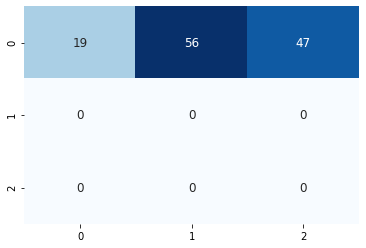

121/121 [==============================] - 0s 257us/sample - loss: 2.8856 - accuracy: 0.1570


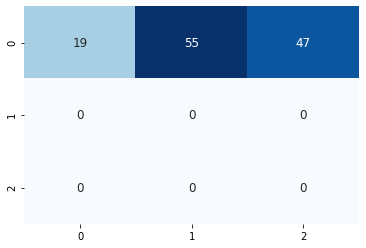

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3949 samples, validate on 921 samples
Epoch 1/300
3949/3949 [==============================] - 3s 706us/sample - loss: 0.9072 - accuracy: 0.5275 - val_loss: 1.0579 - val_accuracy: 0.4213
Epoch 2/300
3949/3949 [==============================] - 1s 221us/sample - loss: 0.6228 - accuracy: 0.7014 - val_loss: 1.1611 - val_accuracy: 0.4321
Epoch 3/300
3949/3949 [==============================] - 1s 193us/sample - loss: 0.4595 - accuracy: 0.7627 - val_loss: 1.3100 - val_accuracy: 0.4528
Epoch 4/300
3949/3949 [==============================] - 1s 176us/sample - loss: 0.3523 - accuracy: 0.8321 - val_loss: 1.4726 - val_accuracy: 0.4604
Epoch 00004: early stopping
119/119 [==============================] - 0s 4ms/sample - loss: 1.8849 - accuracy: 0.2017


12it [4:54:13, 1471.14s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 73 steps
Epoch 1/300
286/286 [==============================] - 29s 101ms/step - loss: 1.4229 - accuracy: 0.4249 - val_loss: 1.2192 - val_accuracy: 0.3628
Epoch 2/300
286/286 [==============================] - 28s 99ms/step - loss: 1.0462 - accuracy: 0.4801 - val_loss: 1.2071 - val_accuracy: 0.3384
Epoch 3/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9942 - accuracy: 0.4995 - val_loss: 1.2335 - val_accuracy: 0.3845
Epoch 4/300
286/286 [==============================] - 28s 97ms/step - loss: 0.9741 - accuracy: 0.5157 - val_loss: 1.3231 - val_accuracy: 0.4008
Epoch 5/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9613 - accuracy: 0.5266 - val_loss: 1.4063 - val_accuracy: 0.4022
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 73 steps
Epoch 1/300
286/286 [=====

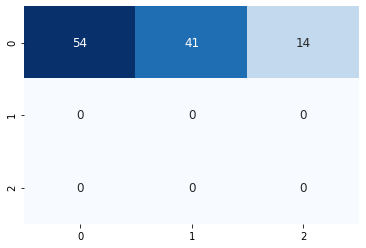

107/107 [==============================] - 0s 243us/sample - loss: 1.2312 - accuracy: 0.4299


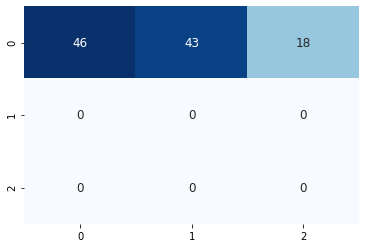

103/103 [==============================] - 0s 258us/sample - loss: 1.2102 - accuracy: 0.4466


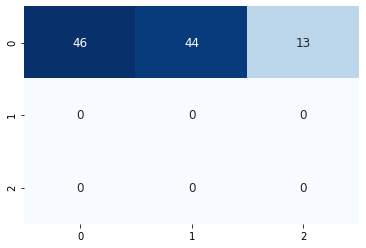

99/99 [==============================] - 0s 260us/sample - loss: 1.2870 - accuracy: 0.4141


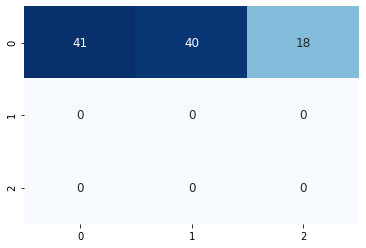

99/99 [==============================] - 0s 246us/sample - loss: 1.2823 - accuracy: 0.4848


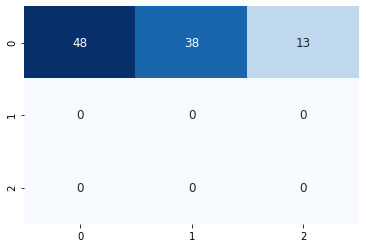

99/99 [==============================] - 0s 265us/sample - loss: 1.2133 - accuracy: 0.4949


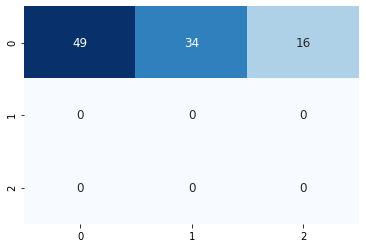

99/99 [==============================] - 0s 421us/sample - loss: 1.2091 - accuracy: 0.4747


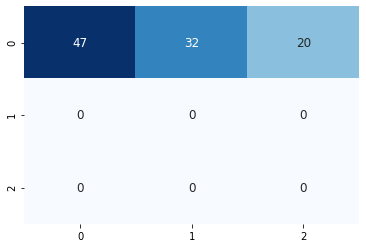

98/98 [==============================] - 0s 257us/sample - loss: 1.1248 - accuracy: 0.5204


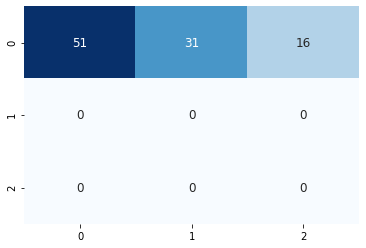

98/98 [==============================] - 0s 264us/sample - loss: 1.1190 - accuracy: 0.5102


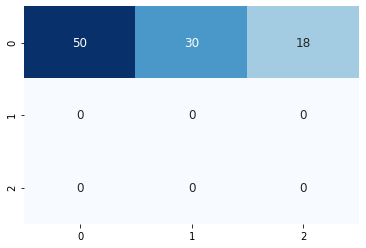

97/97 [==============================] - 0s 307us/sample - loss: 1.1552 - accuracy: 0.4742


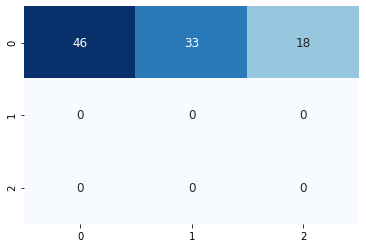

97/97 [==============================] - 0s 287us/sample - loss: 1.1612 - accuracy: 0.5155


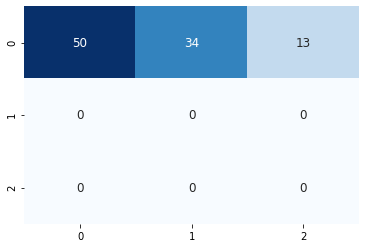

97/97 [==============================] - 0s 278us/sample - loss: 1.1008 - accuracy: 0.5258


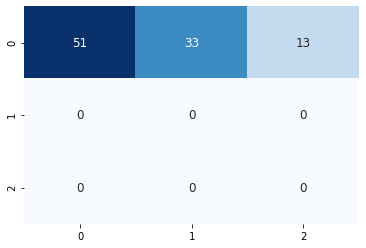

96/96 [==============================] - 0s 2ms/sample - loss: 1.2166 - accuracy: 0.5208


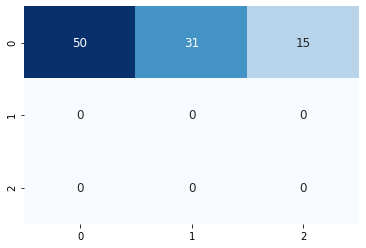

97/97 [==============================] - 0s 381us/sample - loss: 1.0644 - accuracy: 0.5464


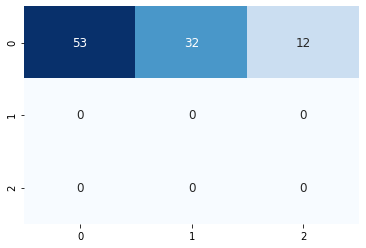

95/95 [==============================] - 0s 254us/sample - loss: 1.1717 - accuracy: 0.5158


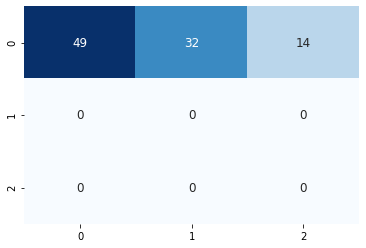

95/95 [==============================] - 0s 256us/sample - loss: 1.2709 - accuracy: 0.5053


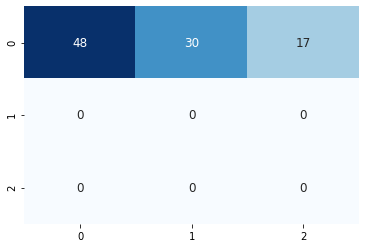

94/94 [==============================] - 0s 255us/sample - loss: 1.0974 - accuracy: 0.5106


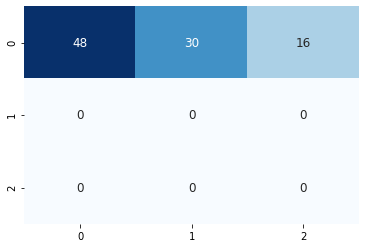

95/95 [==============================] - 0s 252us/sample - loss: 1.1265 - accuracy: 0.5684


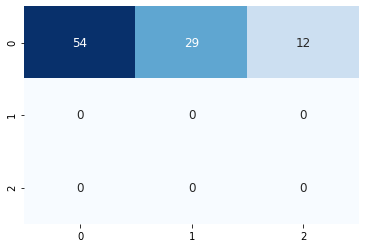

93/93 [==============================] - 0s 242us/sample - loss: 1.1178 - accuracy: 0.5269


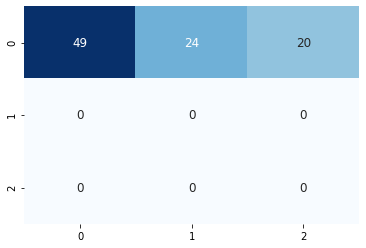

93/93 [==============================] - 0s 250us/sample - loss: 1.1696 - accuracy: 0.4946


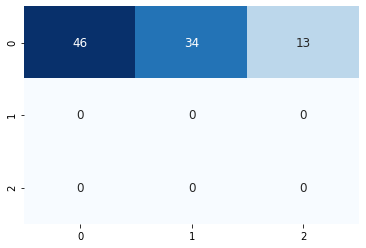

93/93 [==============================] - 0s 243us/sample - loss: 1.1585 - accuracy: 0.5376


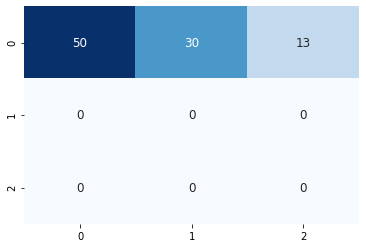

92/92 [==============================] - 0s 264us/sample - loss: 1.1027 - accuracy: 0.5000


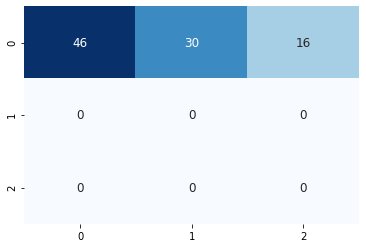

91/91 [==============================] - 0s 250us/sample - loss: 1.1761 - accuracy: 0.4725


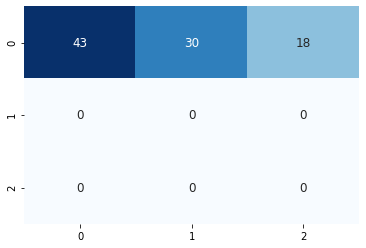

90/90 [==============================] - 0s 259us/sample - loss: 1.0998 - accuracy: 0.5111


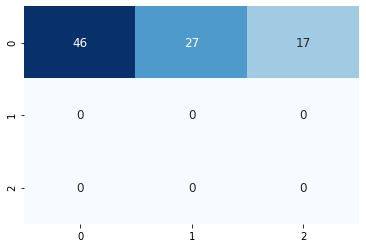

90/90 [==============================] - 0s 270us/sample - loss: 0.9850 - accuracy: 0.6222


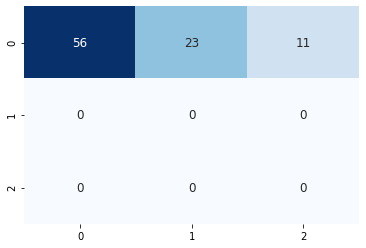

91/91 [==============================] - 0s 287us/sample - loss: 0.9508 - accuracy: 0.6154


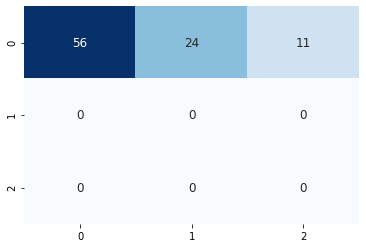

91/91 [==============================] - 0s 254us/sample - loss: 1.0563 - accuracy: 0.5604


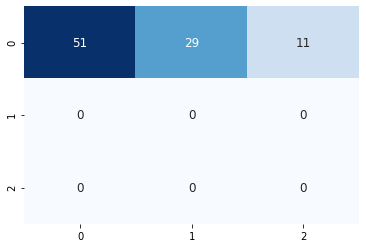

89/89 [==============================] - 0s 245us/sample - loss: 0.9880 - accuracy: 0.5618


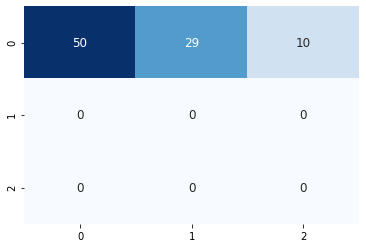

89/89 [==============================] - 0s 259us/sample - loss: 1.0198 - accuracy: 0.5281


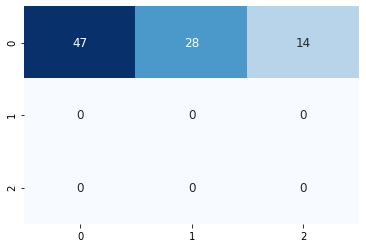

88/88 [==============================] - 0s 332us/sample - loss: 1.0532 - accuracy: 0.5227


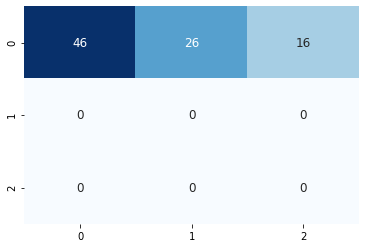

86/86 [==============================] - 0s 301us/sample - loss: 0.9940 - accuracy: 0.4884


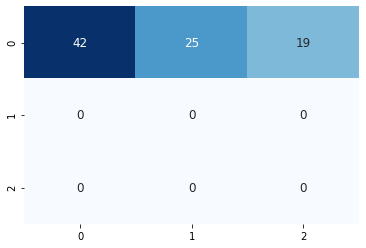

86/86 [==============================] - 0s 249us/sample - loss: 0.9867 - accuracy: 0.6163


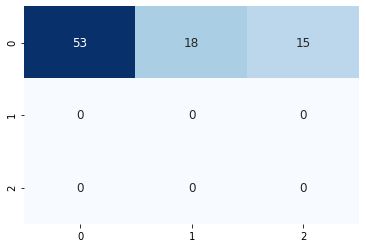

86/86 [==============================] - 0s 247us/sample - loss: 0.9395 - accuracy: 0.5465


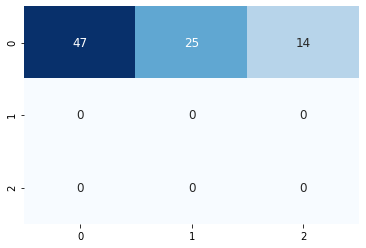

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3909 samples, validate on 998 samples
Epoch 1/300
3909/3909 [==============================] - 3s 770us/sample - loss: 0.9824 - accuracy: 0.4748 - val_loss: 1.0725 - val_accuracy: 0.4088
Epoch 2/300
3909/3909 [==============================] - 1s 209us/sample - loss: 0.8035 - accuracy: 0.5856 - val_loss: 1.1098 - val_accuracy: 0.4198
Epoch 3/300
3909/3909 [==============================] - 1s 178us/sample - loss: 0.6786 - accuracy: 0.6442 - val_loss: 1.1776 - val_accuracy: 0.4269
Epoch 4/300
3909/3909 [==============================] - 1s 190us/sample - loss: 0.5858 - accuracy: 0.6899 - val_loss: 1.2476 - val_accuracy: 0.4579
Epoch 00004: early stopping
82/82 [==============================] - 0s 5ms/sample - loss: 0.8636 - accuracy: 0.5610


1it [22:42, 1362.16s/it]
100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 72 steps
Epoch 1/300
284/284 [==============================] - 29s 103ms/step - loss: 1.4243 - accuracy: 0.4296 - val_loss: 1.2023 - val_accuracy: 0.3678
Epoch 2/300
284/284 [==============================] - 27s 97ms/step - loss: 1.0380 - accuracy: 0.4919 - val_loss: 1.1603 - val_accuracy: 0.3391
Epoch 3/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9849 - accuracy: 0.5116 - val_loss: 1.2343 - val_accuracy: 0.3751
Epoch 4/300
284/284 [==============================] - 28s 99ms/step - loss: 0.9656 - accuracy: 0.5261 - val_loss: 1.2835 - val_accuracy: 0.3827
Epoch 5/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9491 - accuracy: 0.5387 - val_loss: 1.2933 - val_accuracy: 0.3939
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 72 steps
Epoch 1/300
284/284 [=====

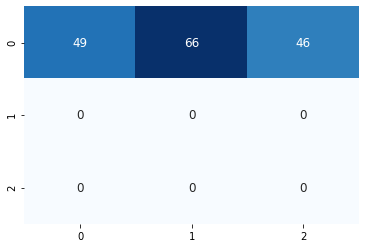

155/155 [==============================] - 0s 239us/sample - loss: 1.4805 - accuracy: 0.3032


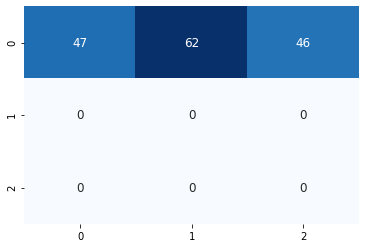

153/153 [==============================] - 0s 244us/sample - loss: 1.5526 - accuracy: 0.2876


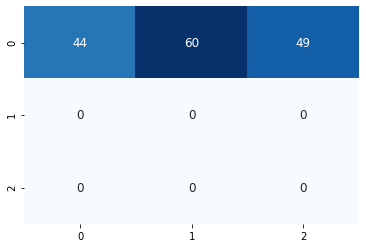

154/154 [==============================] - 0s 234us/sample - loss: 1.5732 - accuracy: 0.2792


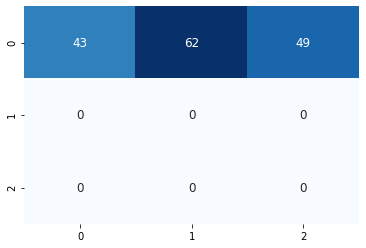

151/151 [==============================] - 0s 248us/sample - loss: 1.5327 - accuracy: 0.2914


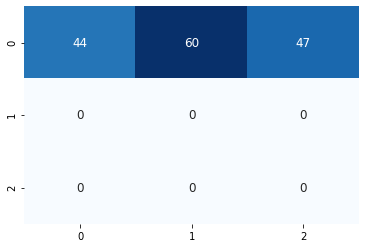

147/147 [==============================] - 0s 258us/sample - loss: 1.5458 - accuracy: 0.2585


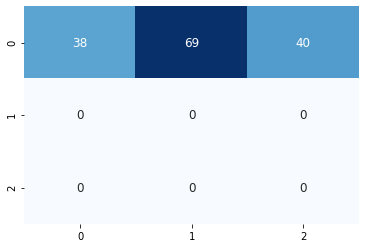

144/144 [==============================] - 0s 292us/sample - loss: 1.7143 - accuracy: 0.2778


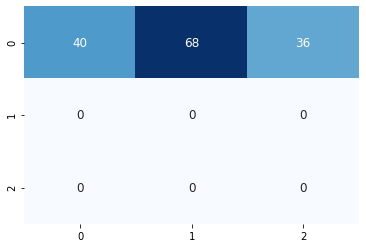

143/143 [==============================] - 0s 252us/sample - loss: 1.5864 - accuracy: 0.2727


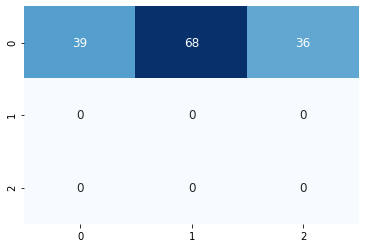

145/145 [==============================] - 0s 267us/sample - loss: 1.7076 - accuracy: 0.2690


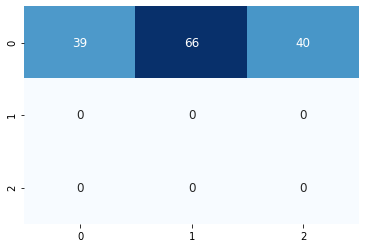

143/143 [==============================] - 0s 278us/sample - loss: 1.7139 - accuracy: 0.2238


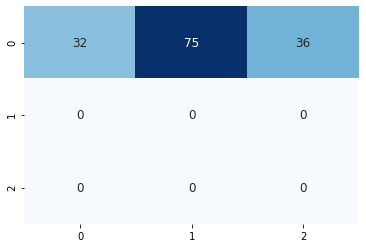

142/142 [==============================] - 0s 296us/sample - loss: 1.6947 - accuracy: 0.2606


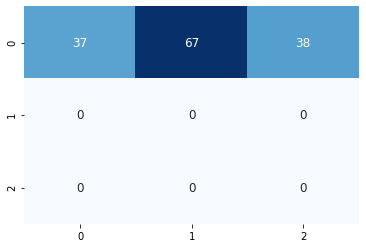

142/142 [==============================] - 0s 290us/sample - loss: 1.6591 - accuracy: 0.2958


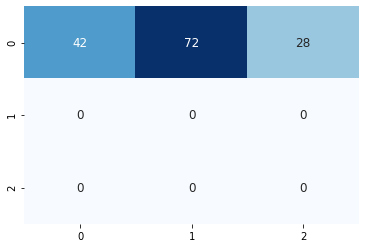

142/142 [==============================] - 0s 267us/sample - loss: 1.8142 - accuracy: 0.2254


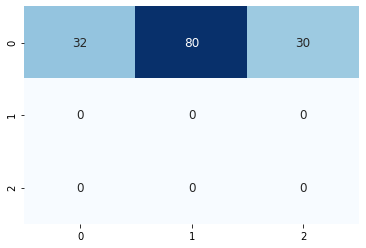

141/141 [==============================] - 0s 271us/sample - loss: 1.8785 - accuracy: 0.1986


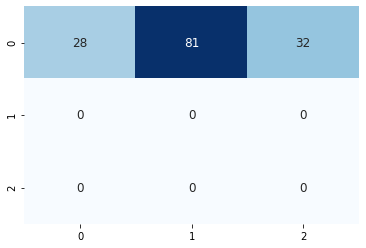

141/141 [==============================] - 0s 265us/sample - loss: 1.8687 - accuracy: 0.2057


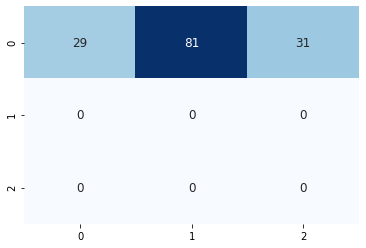

139/139 [==============================] - 0s 268us/sample - loss: 1.7806 - accuracy: 0.2158


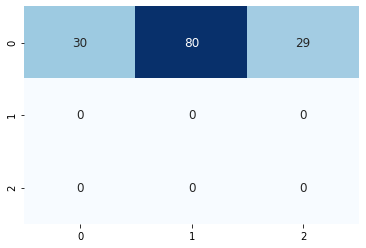

139/139 [==============================] - 0s 258us/sample - loss: 1.7709 - accuracy: 0.1871


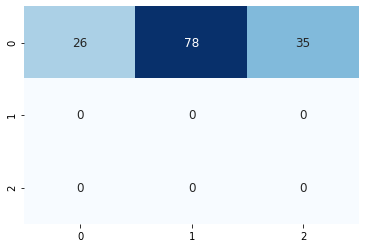

137/137 [==============================] - 0s 258us/sample - loss: 1.8183 - accuracy: 0.1898


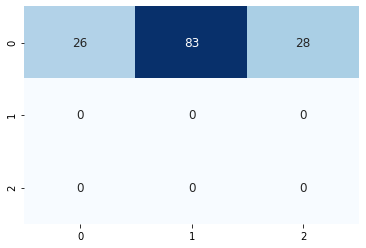

139/139 [==============================] - 0s 259us/sample - loss: 1.8242 - accuracy: 0.2158


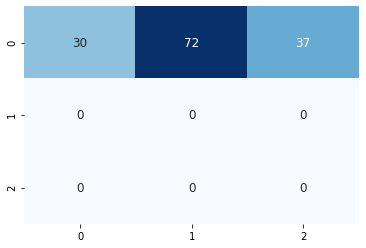

137/137 [==============================] - 0s 288us/sample - loss: 1.7809 - accuracy: 0.2555


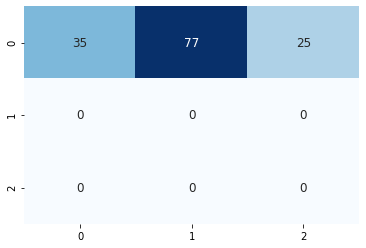

138/138 [==============================] - 0s 256us/sample - loss: 1.9152 - accuracy: 0.2029


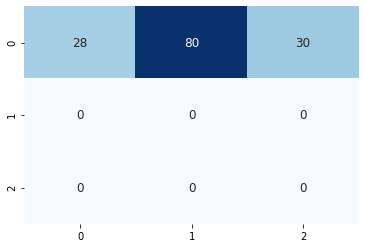

137/137 [==============================] - 0s 260us/sample - loss: 1.9221 - accuracy: 0.2263


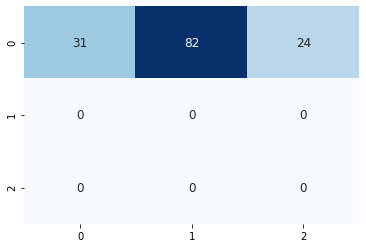

138/138 [==============================] - 0s 264us/sample - loss: 1.9446 - accuracy: 0.2029


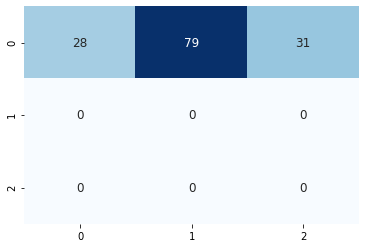

137/137 [==============================] - 0s 285us/sample - loss: 1.9170 - accuracy: 0.1679


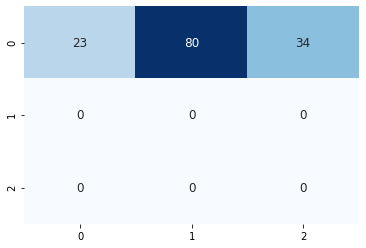

137/137 [==============================] - 0s 267us/sample - loss: 1.9992 - accuracy: 0.2263


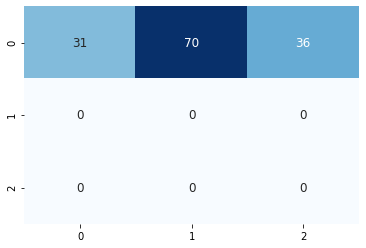

138/138 [==============================] - 0s 268us/sample - loss: 1.8161 - accuracy: 0.2464


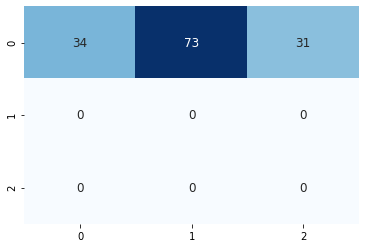

137/137 [==============================] - 0s 295us/sample - loss: 1.8649 - accuracy: 0.2190


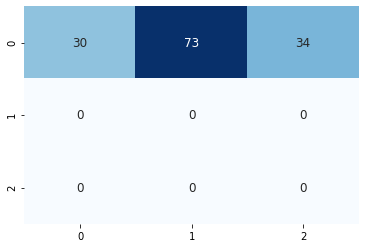

137/137 [==============================] - 0s 254us/sample - loss: 1.8672 - accuracy: 0.2409


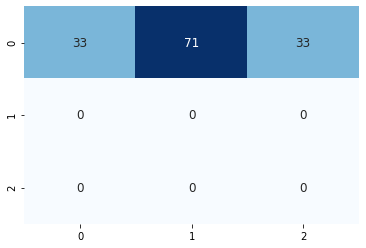

134/134 [==============================] - 0s 267us/sample - loss: 1.8917 - accuracy: 0.2015


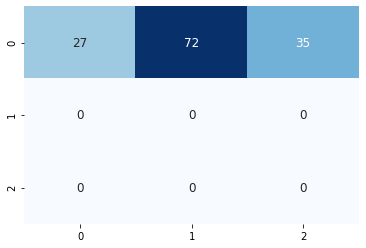

134/134 [==============================] - 0s 264us/sample - loss: 1.8049 - accuracy: 0.2612


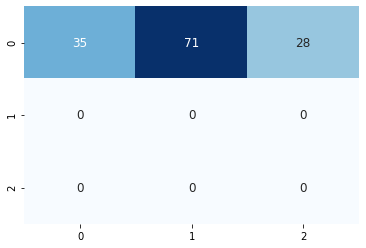

133/133 [==============================] - 0s 331us/sample - loss: 1.7796 - accuracy: 0.2481


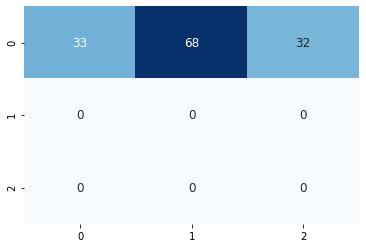

131/131 [==============================] - 0s 258us/sample - loss: 1.8794 - accuracy: 0.2061


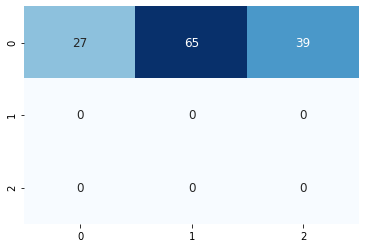

130/130 [==============================] - 0s 286us/sample - loss: 2.0062 - accuracy: 0.2000


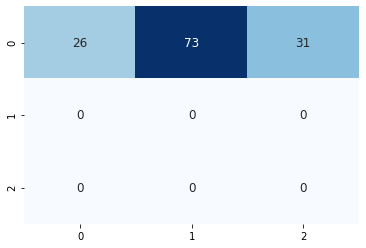

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3881 samples, validate on 984 samples
Epoch 1/300
3881/3881 [==============================] - 3s 732us/sample - loss: 0.9427 - accuracy: 0.4813 - val_loss: 1.0710 - val_accuracy: 0.4207
Epoch 2/300
3881/3881 [==============================] - 1s 236us/sample - loss: 0.6958 - accuracy: 0.6573 - val_loss: 1.1220 - val_accuracy: 0.4492
Epoch 3/300
3881/3881 [==============================] - 1s 215us/sample - loss: 0.5333 - accuracy: 0.7480 - val_loss: 1.2067 - val_accuracy: 0.4909
Epoch 4/300
3881/3881 [==============================] - 1s 211us/sample - loss: 0.4145 - accuracy: 0.8214 - val_loss: 1.3076 - val_accuracy: 0.5193
Epoch 00004: early stopping
124/124 [==============================] - 0s 3ms/sample - loss: 1.4706 - accuracy: 0.2097


2it [46:25, 1380.64s/it]
100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285 steps, validate for 73 steps
Epoch 1/300
285/285 [==============================] - 29s 103ms/step - loss: 1.4315 - accuracy: 0.4270 - val_loss: 1.1873 - val_accuracy: 0.4103
Epoch 2/300
285/285 [==============================] - 28s 97ms/step - loss: 1.0531 - accuracy: 0.4772 - val_loss: 1.1519 - val_accuracy: 0.4142
Epoch 3/300
285/285 [==============================] - 28s 99ms/step - loss: 0.9998 - accuracy: 0.4987 - val_loss: 1.2757 - val_accuracy: 0.3646
Epoch 4/300
285/285 [==============================] - 28s 99ms/step - loss: 0.9764 - accuracy: 0.5186 - val_loss: 1.3261 - val_accuracy: 0.3821
Epoch 5/300
285/285 [==============================] - 28s 99ms/step - loss: 0.9617 - accuracy: 0.5302 - val_loss: 1.4352 - val_accuracy: 0.3514
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285 steps, validate for 73 steps
Epoch 1/300
285/285 [=====

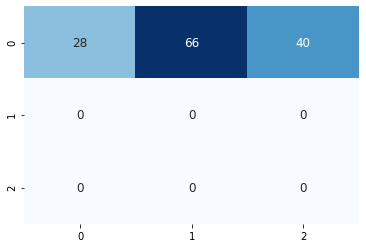

126/126 [==============================] - 0s 252us/sample - loss: 1.6759 - accuracy: 0.2778


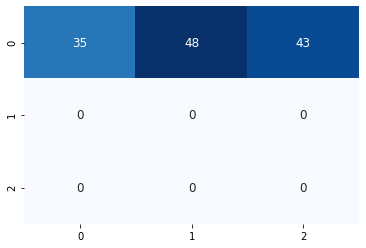

121/121 [==============================] - 0s 230us/sample - loss: 1.6663 - accuracy: 0.2149


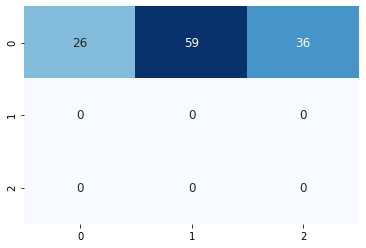

120/120 [==============================] - 0s 209us/sample - loss: 1.6134 - accuracy: 0.2667


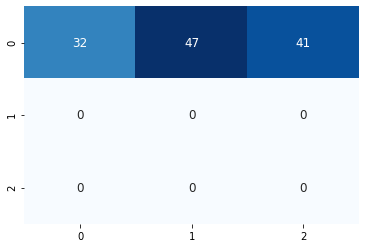

120/120 [==============================] - 0s 308us/sample - loss: 1.5987 - accuracy: 0.2833


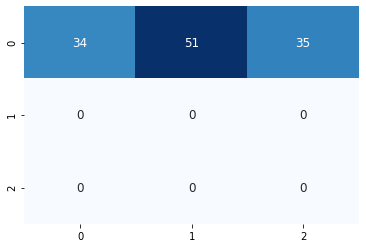

118/118 [==============================] - 0s 329us/sample - loss: 1.4733 - accuracy: 0.2881


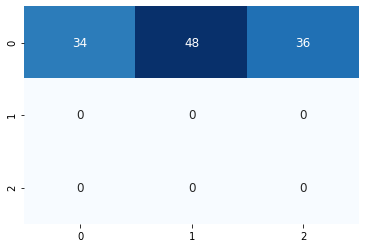

118/118 [==============================] - 0s 249us/sample - loss: 1.5535 - accuracy: 0.2797


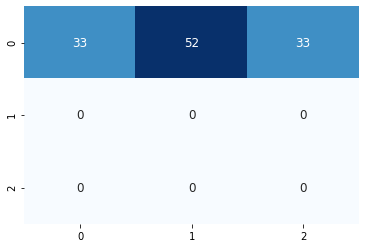

116/116 [==============================] - 0s 242us/sample - loss: 1.5413 - accuracy: 0.2586


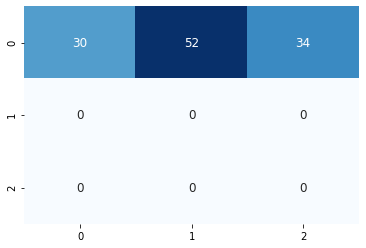

113/113 [==============================] - 0s 253us/sample - loss: 1.5328 - accuracy: 0.3540


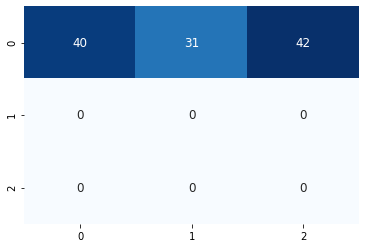

111/111 [==============================] - 0s 258us/sample - loss: 1.5458 - accuracy: 0.3243


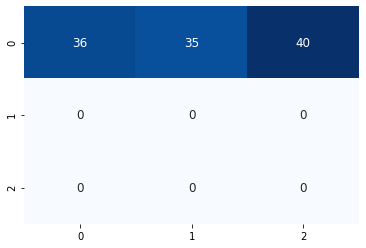

112/112 [==============================] - 0s 258us/sample - loss: 1.4239 - accuracy: 0.2768


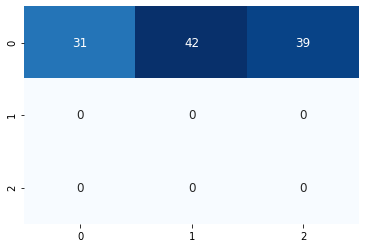

110/110 [==============================] - 0s 268us/sample - loss: 1.5495 - accuracy: 0.3364


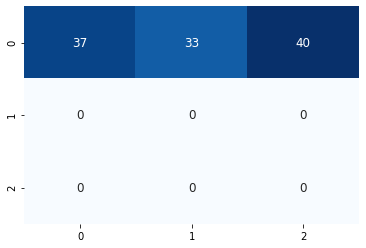

108/108 [==============================] - 0s 324us/sample - loss: 1.5042 - accuracy: 0.3426


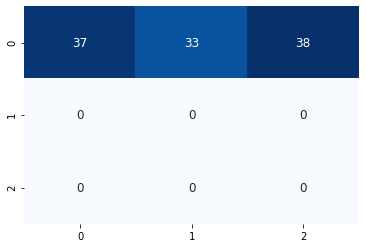

108/108 [==============================] - 0s 253us/sample - loss: 1.4743 - accuracy: 0.2963


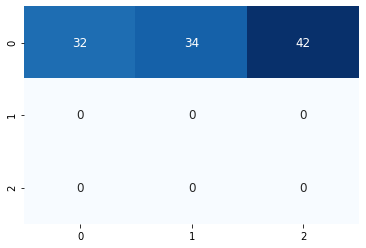

108/108 [==============================] - 0s 251us/sample - loss: 1.4495 - accuracy: 0.3981


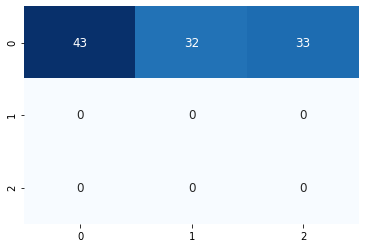

106/106 [==============================] - 0s 257us/sample - loss: 1.6046 - accuracy: 0.3491


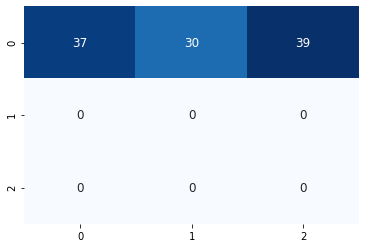

106/106 [==============================] - 0s 287us/sample - loss: 1.4947 - accuracy: 0.3679


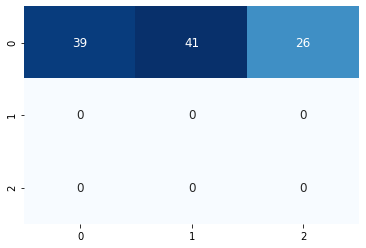

105/105 [==============================] - 0s 263us/sample - loss: 1.4641 - accuracy: 0.3143


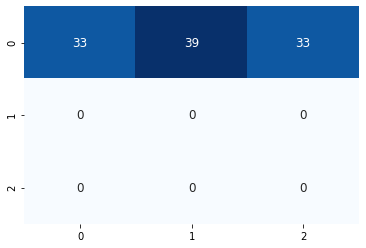

107/107 [==============================] - 0s 274us/sample - loss: 1.4591 - accuracy: 0.3178


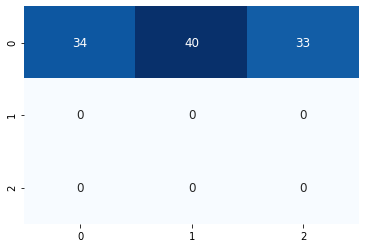

106/106 [==============================] - 0s 300us/sample - loss: 1.4374 - accuracy: 0.3585


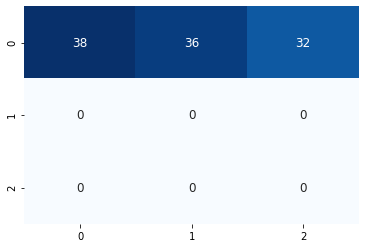

105/105 [==============================] - 0s 278us/sample - loss: 1.4971 - accuracy: 0.3333


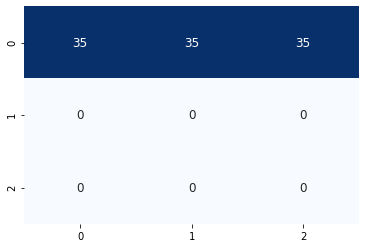

106/106 [==============================] - 0s 269us/sample - loss: 1.4883 - accuracy: 0.2736


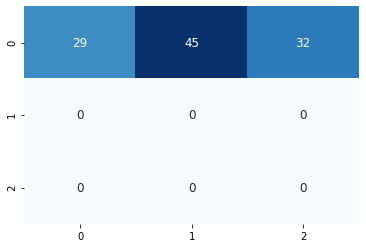

104/104 [==============================] - 0s 305us/sample - loss: 1.4903 - accuracy: 0.2981


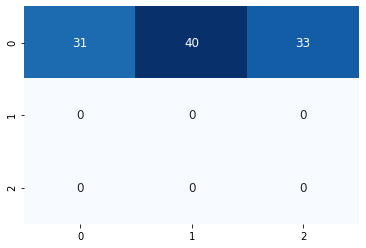

105/105 [==============================] - 0s 325us/sample - loss: 1.4818 - accuracy: 0.3333


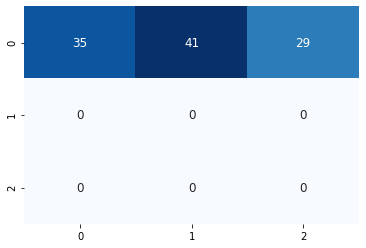

105/105 [==============================] - 0s 274us/sample - loss: 1.4064 - accuracy: 0.3429


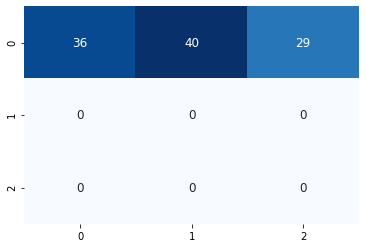

102/102 [==============================] - 0s 374us/sample - loss: 1.5653 - accuracy: 0.3235


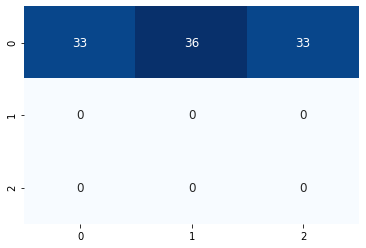

102/102 [==============================] - 0s 283us/sample - loss: 1.4555 - accuracy: 0.3333


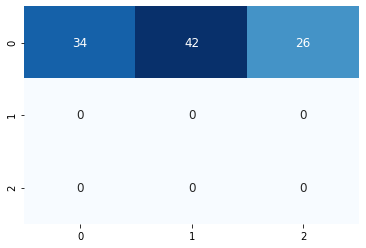

102/102 [==============================] - 0s 286us/sample - loss: 1.5970 - accuracy: 0.3333


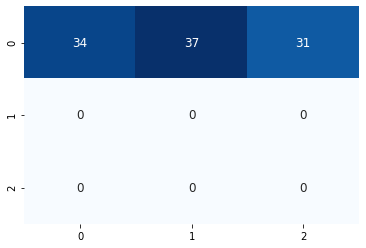

102/102 [==============================] - 0s 266us/sample - loss: 1.6226 - accuracy: 0.2843


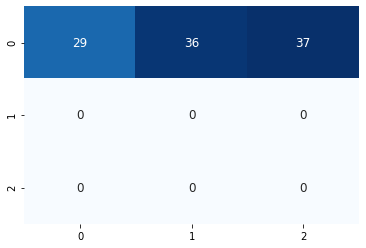

100/100 [==============================] - 0s 297us/sample - loss: 1.5890 - accuracy: 0.2800


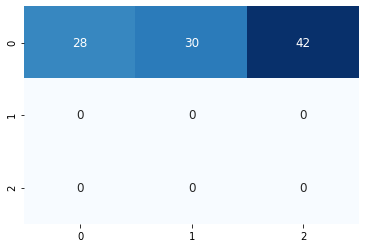

100/100 [==============================] - 0s 282us/sample - loss: 1.6646 - accuracy: 0.3400


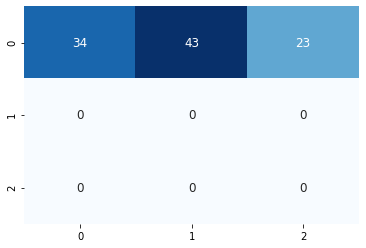

100/100 [==============================] - 0s 268us/sample - loss: 1.5754 - accuracy: 0.3000


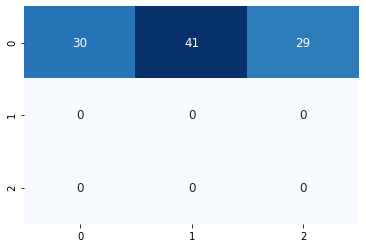

102/102 [==============================] - 0s 286us/sample - loss: 1.5399 - accuracy: 0.3235


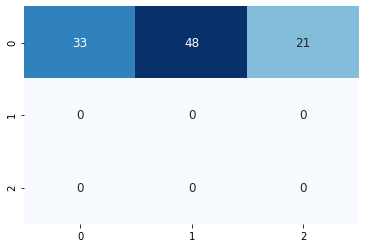

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3897 samples, validate on 995 samples
Epoch 1/300
3897/3897 [==============================] - 3s 762us/sample - loss: 0.9316 - accuracy: 0.5473 - val_loss: 1.0797 - val_accuracy: 0.4241
Epoch 2/300
3897/3897 [==============================] - 1s 186us/sample - loss: 0.6311 - accuracy: 0.7447 - val_loss: 1.1521 - val_accuracy: 0.4734
Epoch 3/300
3897/3897 [==============================] - 1s 196us/sample - loss: 0.4506 - accuracy: 0.8152 - val_loss: 1.2637 - val_accuracy: 0.4965
Epoch 4/300
3897/3897 [==============================] - 1s 197us/sample - loss: 0.3462 - accuracy: 0.8625 - val_loss: 1.3660 - val_accuracy: 0.5146
Epoch 00004: early stopping
97/97 [==============================] - 0s 4ms/sample - loss: 1.3558 - accuracy: 0.3918


3it [1:10:19, 1396.48s/it]
100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 73 steps
Epoch 1/300
284/284 [==============================] - 29s 103ms/step - loss: 1.4102 - accuracy: 0.4364 - val_loss: 1.1872 - val_accuracy: 0.4161
Epoch 2/300
284/284 [==============================] - 28s 97ms/step - loss: 1.0353 - accuracy: 0.4865 - val_loss: 1.1889 - val_accuracy: 0.4016
Epoch 3/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9838 - accuracy: 0.5079 - val_loss: 1.1943 - val_accuracy: 0.3672
Epoch 4/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9623 - accuracy: 0.5208 - val_loss: 1.2958 - val_accuracy: 0.4004
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 73 steps
Epoch 1/300
284/284 [==============================] - 69s 244ms/step - loss: 0.8893 - accuracy: 0.5714 - val_loss: 1.2544 - val_accuracy: 0.4411
Epoch 2/300
284/284 [====

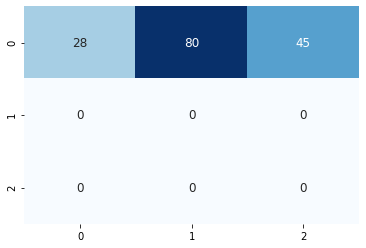

148/148 [==============================] - 0s 264us/sample - loss: 1.8419 - accuracy: 0.1959


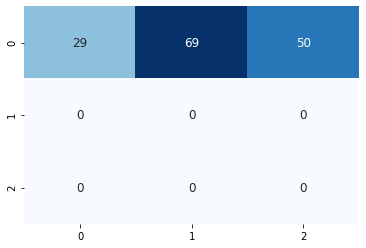

144/144 [==============================] - 0s 243us/sample - loss: 1.9577 - accuracy: 0.1736


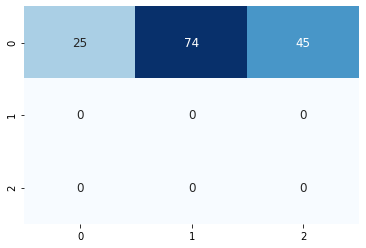

143/143 [==============================] - 0s 257us/sample - loss: 1.9732 - accuracy: 0.1818


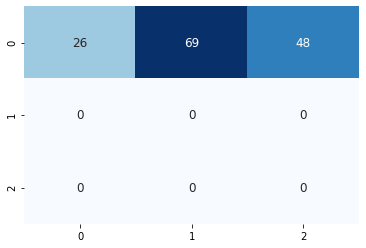

144/144 [==============================] - 0s 260us/sample - loss: 1.8616 - accuracy: 0.1736


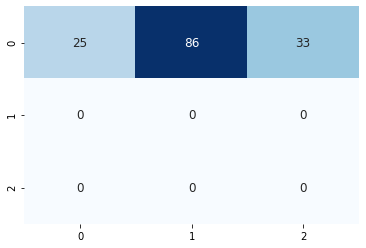

141/141 [==============================] - 0s 247us/sample - loss: 1.9016 - accuracy: 0.1631


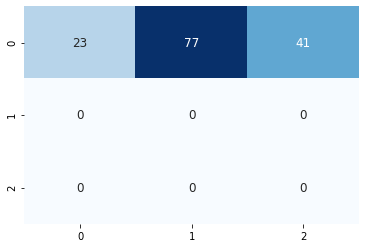

141/141 [==============================] - 0s 250us/sample - loss: 2.0061 - accuracy: 0.1773


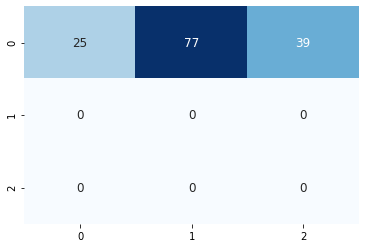

140/140 [==============================] - 0s 270us/sample - loss: 2.1418 - accuracy: 0.1643


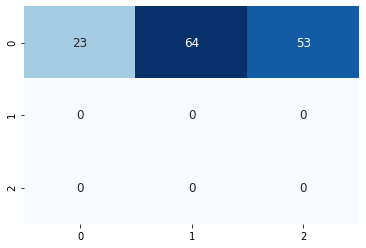

138/138 [==============================] - 0s 243us/sample - loss: 2.3898 - accuracy: 0.1522


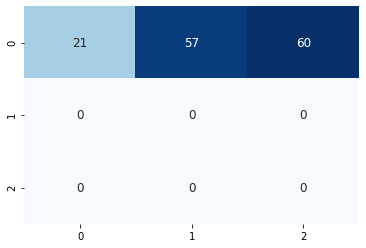

136/136 [==============================] - 0s 263us/sample - loss: 2.2480 - accuracy: 0.1544


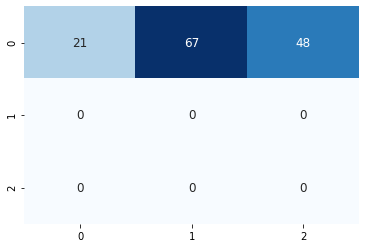

138/138 [==============================] - 0s 266us/sample - loss: 2.2282 - accuracy: 0.1812


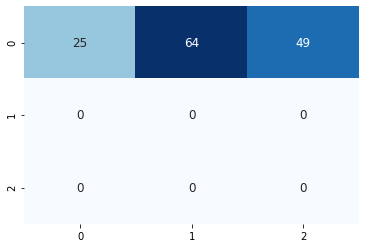

137/137 [==============================] - 0s 300us/sample - loss: 2.1763 - accuracy: 0.1606


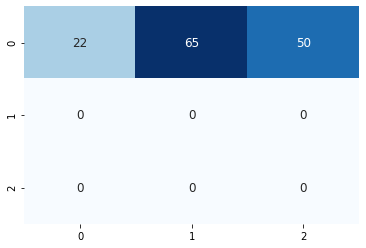

135/135 [==============================] - 0s 280us/sample - loss: 2.2194 - accuracy: 0.1852


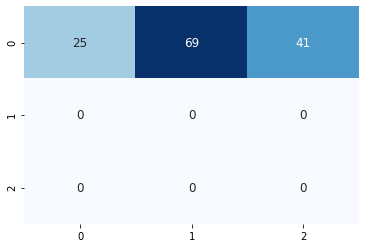

140/140 [==============================] - 0s 256us/sample - loss: 2.4035 - accuracy: 0.2071


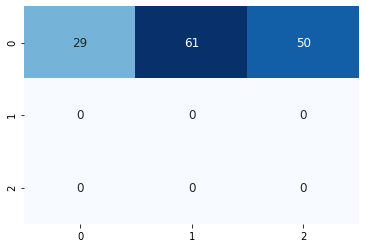

135/135 [==============================] - 0s 248us/sample - loss: 2.4190 - accuracy: 0.1630


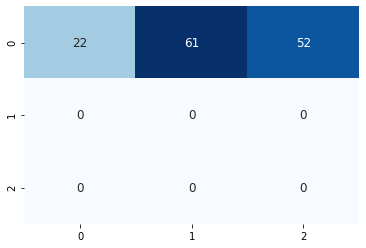

134/134 [==============================] - 0s 250us/sample - loss: 2.3897 - accuracy: 0.2090


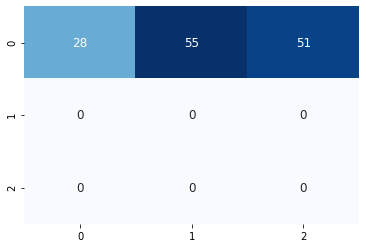

133/133 [==============================] - 0s 310us/sample - loss: 2.4721 - accuracy: 0.1729


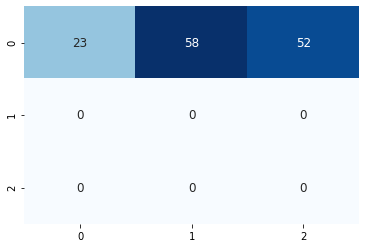

133/133 [==============================] - 0s 270us/sample - loss: 2.2768 - accuracy: 0.2331


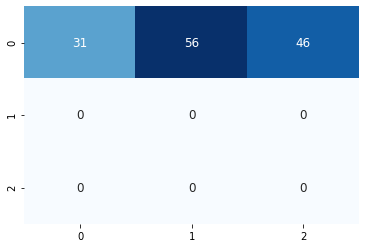

133/133 [==============================] - 0s 259us/sample - loss: 2.3381 - accuracy: 0.1880


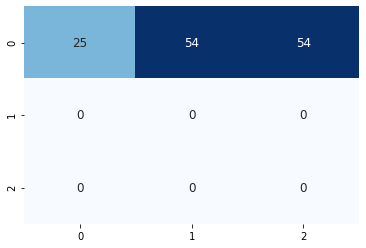

131/131 [==============================] - 0s 246us/sample - loss: 2.6016 - accuracy: 0.1527


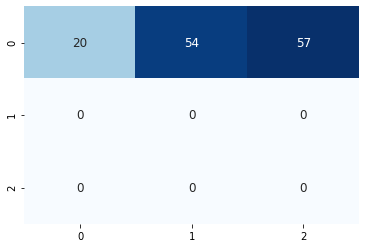

131/131 [==============================] - 0s 269us/sample - loss: 2.4990 - accuracy: 0.1679


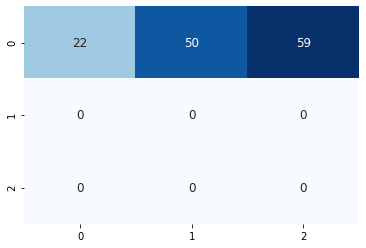

131/131 [==============================] - 0s 279us/sample - loss: 2.3542 - accuracy: 0.1832


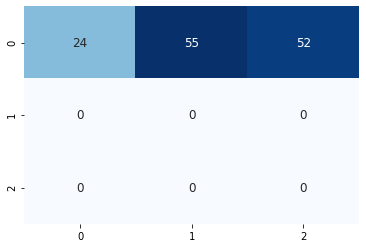

129/129 [==============================] - 0s 271us/sample - loss: 2.4595 - accuracy: 0.2016


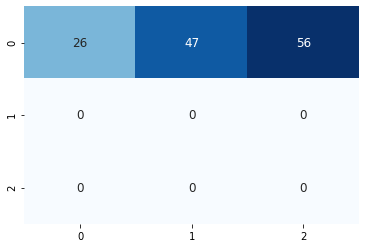

128/128 [==============================] - 0s 2ms/sample - loss: 2.3893 - accuracy: 0.1641


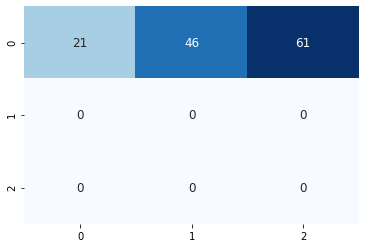

129/129 [==============================] - 0s 308us/sample - loss: 2.2263 - accuracy: 0.2171


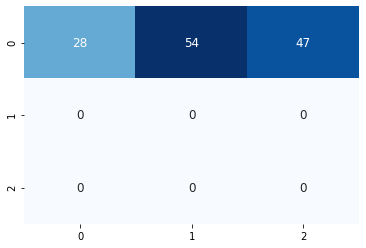

129/129 [==============================] - 0s 273us/sample - loss: 2.1381 - accuracy: 0.2171


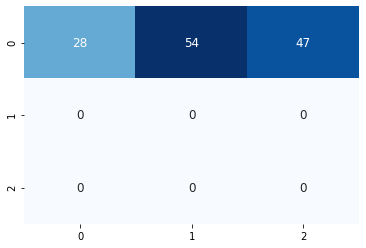

129/129 [==============================] - 0s 286us/sample - loss: 2.2915 - accuracy: 0.1938


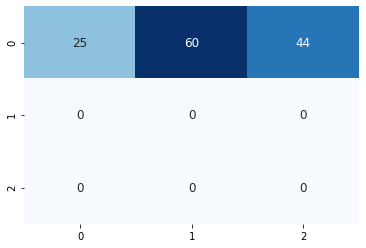

128/128 [==============================] - 0s 281us/sample - loss: 2.2642 - accuracy: 0.2422


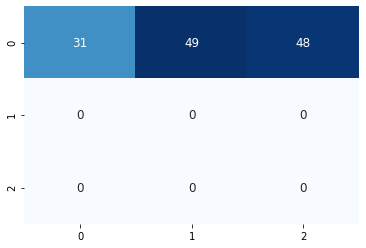

128/128 [==============================] - 0s 226us/sample - loss: 2.1784 - accuracy: 0.1719


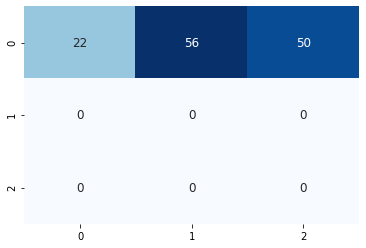

127/127 [==============================] - 0s 226us/sample - loss: 2.1639 - accuracy: 0.2283


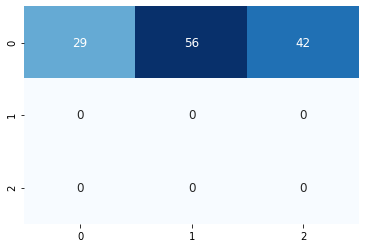

127/127 [==============================] - 0s 238us/sample - loss: 2.1856 - accuracy: 0.1496


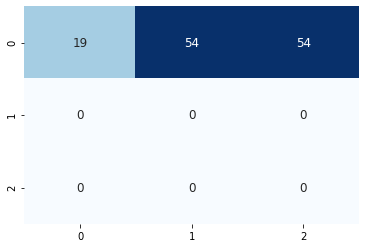

127/127 [==============================] - 0s 227us/sample - loss: 2.2767 - accuracy: 0.2283


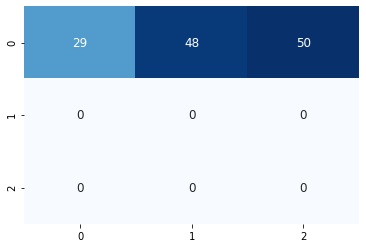

127/127 [==============================] - 0s 227us/sample - loss: 2.2319 - accuracy: 0.1890


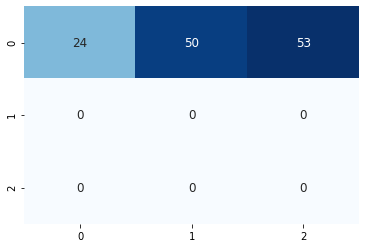

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3875 samples, validate on 991 samples
Epoch 1/300
3875/3875 [==============================] - 3s 720us/sample - loss: 0.9458 - accuracy: 0.4880 - val_loss: 1.1145 - val_accuracy: 0.3976
Epoch 2/300
3875/3875 [==============================] - 1s 202us/sample - loss: 0.7257 - accuracy: 0.6439 - val_loss: 1.1823 - val_accuracy: 0.4268
Epoch 3/300
3875/3875 [==============================] - 1s 196us/sample - loss: 0.5872 - accuracy: 0.7218 - val_loss: 1.2774 - val_accuracy: 0.4682
Epoch 4/300
3875/3875 [==============================] - 1s 219us/sample - loss: 0.4878 - accuracy: 0.7763 - val_loss: 1.3826 - val_accuracy: 0.4743
Epoch 00004: early stopping
123/123 [==============================] - 0s 3ms/sample - loss: 1.9051 - accuracy: 0.1463


4it [1:32:49, 1382.71s/it]
100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 73 steps
Epoch 1/300
286/286 [==============================] - 30s 103ms/step - loss: 1.4299 - accuracy: 0.4372 - val_loss: 1.1985 - val_accuracy: 0.3265
Epoch 2/300
286/286 [==============================] - 28s 98ms/step - loss: 1.0400 - accuracy: 0.4841 - val_loss: 1.1572 - val_accuracy: 0.3463
Epoch 3/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9895 - accuracy: 0.5042 - val_loss: 1.2082 - val_accuracy: 0.3768
Epoch 4/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9688 - accuracy: 0.5170 - val_loss: 1.2557 - val_accuracy: 0.3825
Epoch 5/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9553 - accuracy: 0.5272 - val_loss: 1.3613 - val_accuracy: 0.3552
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 73 steps
Epoch 1/300
286/286 [=====

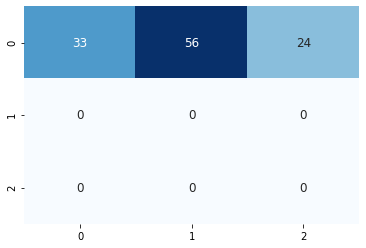

108/108 [==============================] - 0s 272us/sample - loss: 1.7578 - accuracy: 0.2963


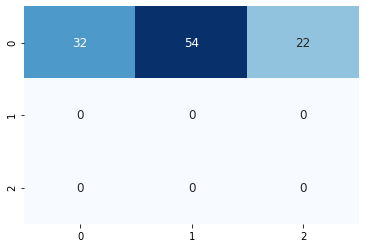

102/102 [==============================] - 0s 259us/sample - loss: 1.7525 - accuracy: 0.3235


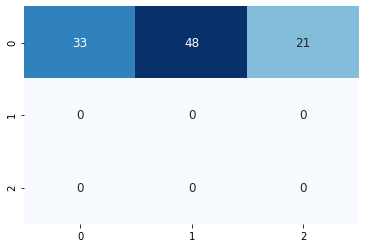

101/101 [==============================] - 0s 264us/sample - loss: 1.8771 - accuracy: 0.2871


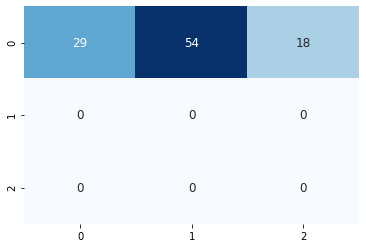

101/101 [==============================] - 0s 273us/sample - loss: 1.7351 - accuracy: 0.2970


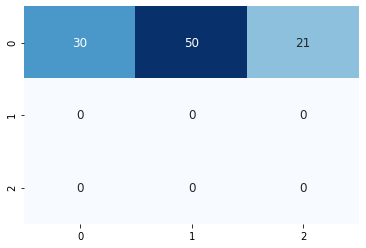

99/99 [==============================] - 0s 290us/sample - loss: 1.8842 - accuracy: 0.2626


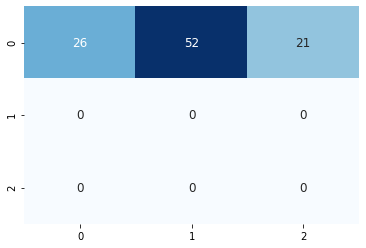

96/96 [==============================] - 0s 2ms/sample - loss: 1.8229 - accuracy: 0.3021


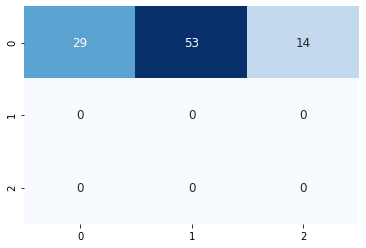

95/95 [==============================] - 0s 294us/sample - loss: 2.1273 - accuracy: 0.2316


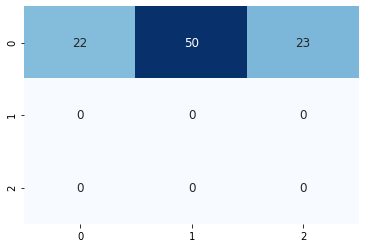

96/96 [==============================] - 0s 240us/sample - loss: 1.8101 - accuracy: 0.3125


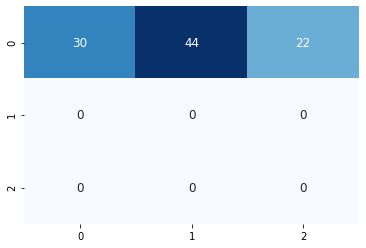

97/97 [==============================] - 0s 277us/sample - loss: 2.0889 - accuracy: 0.2268


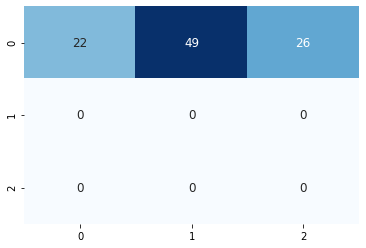

96/96 [==============================] - 0s 249us/sample - loss: 2.0941 - accuracy: 0.3021


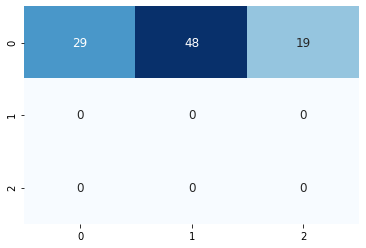

94/94 [==============================] - 0s 274us/sample - loss: 2.0562 - accuracy: 0.2128


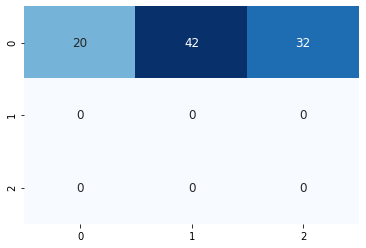

93/93 [==============================] - 0s 265us/sample - loss: 2.2298 - accuracy: 0.2043


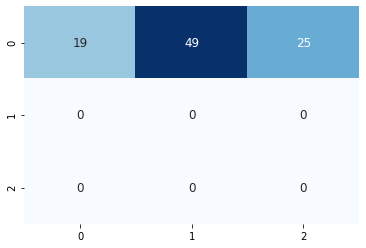

93/93 [==============================] - 0s 268us/sample - loss: 2.1934 - accuracy: 0.2688


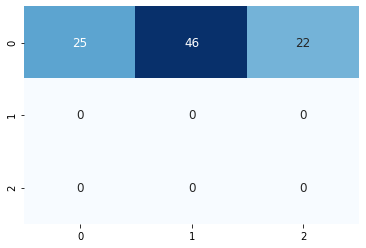

94/94 [==============================] - 0s 262us/sample - loss: 2.0595 - accuracy: 0.2872


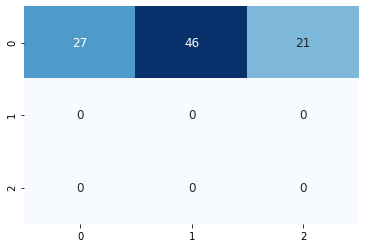

93/93 [==============================] - 0s 258us/sample - loss: 2.1036 - accuracy: 0.2151


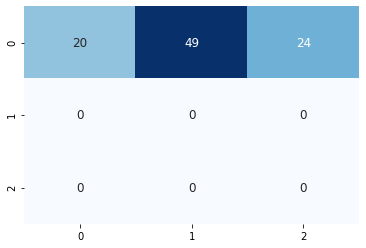

91/91 [==============================] - 0s 260us/sample - loss: 2.0824 - accuracy: 0.2747


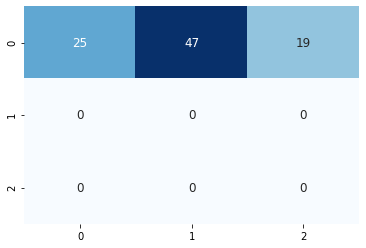

90/90 [==============================] - 0s 257us/sample - loss: 2.1105 - accuracy: 0.2444


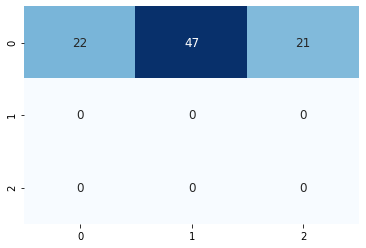

91/91 [==============================] - 0s 309us/sample - loss: 2.2862 - accuracy: 0.2527


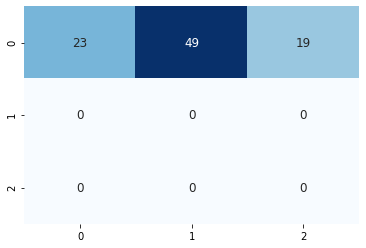

88/88 [==============================] - 0s 244us/sample - loss: 2.1279 - accuracy: 0.2273


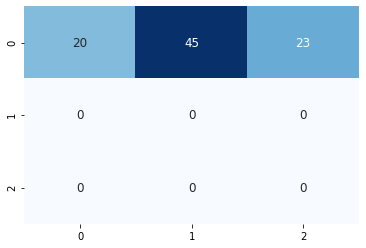

89/89 [==============================] - 0s 270us/sample - loss: 2.2090 - accuracy: 0.2135


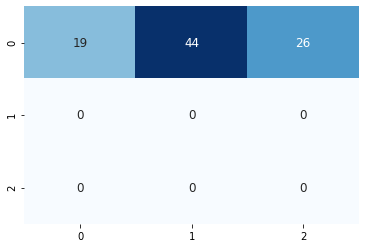

88/88 [==============================] - 0s 272us/sample - loss: 2.4916 - accuracy: 0.1591


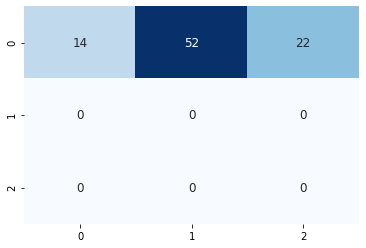

89/89 [==============================] - 0s 267us/sample - loss: 2.4645 - accuracy: 0.2584


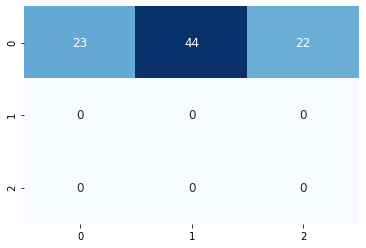

88/88 [==============================] - 0s 285us/sample - loss: 2.2581 - accuracy: 0.1818


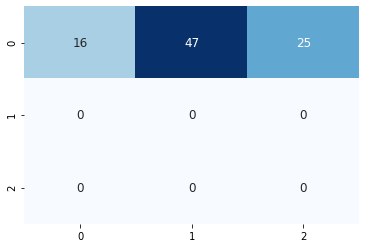

87/87 [==============================] - 0s 292us/sample - loss: 2.4973 - accuracy: 0.1954


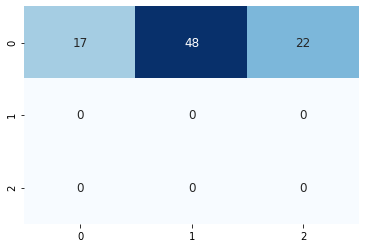

88/88 [==============================] - 0s 257us/sample - loss: 2.4789 - accuracy: 0.1705


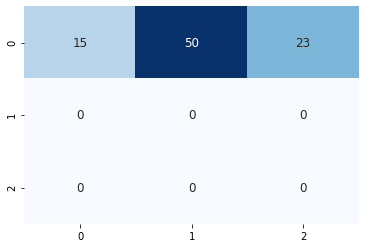

88/88 [==============================] - 0s 243us/sample - loss: 2.3117 - accuracy: 0.2386


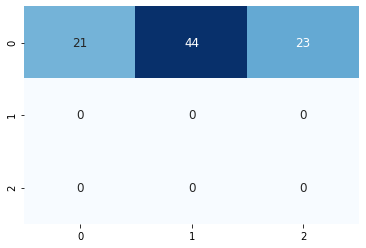

87/87 [==============================] - 0s 403us/sample - loss: 2.2749 - accuracy: 0.2184


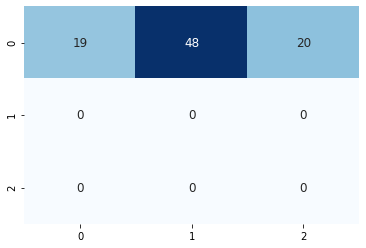

87/87 [==============================] - 0s 257us/sample - loss: 2.2877 - accuracy: 0.2184


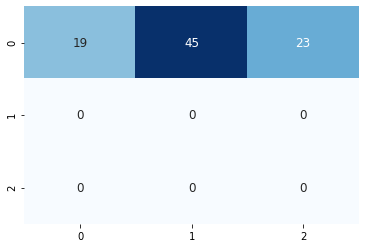

86/86 [==============================] - 0s 339us/sample - loss: 2.6844 - accuracy: 0.2209


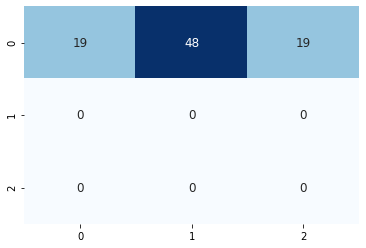

85/85 [==============================] - 0s 239us/sample - loss: 2.4252 - accuracy: 0.1882


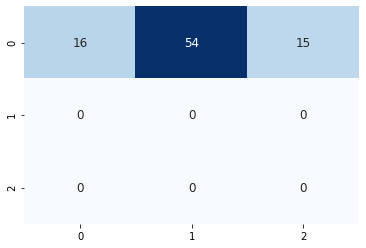

86/86 [==============================] - 0s 253us/sample - loss: 2.3297 - accuracy: 0.2558


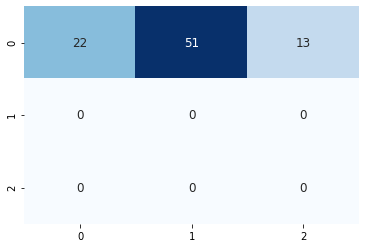

85/85 [==============================] - 0s 288us/sample - loss: 2.2563 - accuracy: 0.1882


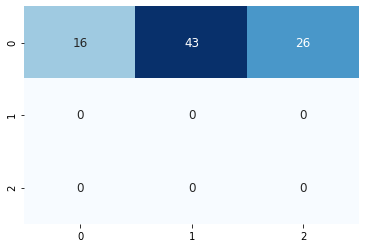

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3907 samples, validate on 999 samples
Epoch 1/300
3907/3907 [==============================] - 3s 713us/sample - loss: 0.9436 - accuracy: 0.5178 - val_loss: 1.0798 - val_accuracy: 0.3934
Epoch 2/300
3907/3907 [==============================] - 1s 207us/sample - loss: 0.6634 - accuracy: 0.6652 - val_loss: 1.1628 - val_accuracy: 0.4044
Epoch 3/300
3907/3907 [==============================] - 1s 189us/sample - loss: 0.5164 - accuracy: 0.7297 - val_loss: 1.2750 - val_accuracy: 0.4354
Epoch 4/300
3907/3907 [==============================] - 1s 217us/sample - loss: 0.4233 - accuracy: 0.7863 - val_loss: 1.3924 - val_accuracy: 0.4645
Epoch 00004: early stopping
83/83 [==============================] - 0s 5ms/sample - loss: 2.1105 - accuracy: 0.2410


5it [1:56:25, 1392.56s/it]
100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 73 steps
Epoch 1/300
284/284 [==============================] - 30s 104ms/step - loss: 1.4699 - accuracy: 0.4299 - val_loss: 1.2719 - val_accuracy: 0.4443
Epoch 2/300
284/284 [==============================] - 28s 98ms/step - loss: 1.0548 - accuracy: 0.4844 - val_loss: 1.2120 - val_accuracy: 0.3991
Epoch 3/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9931 - accuracy: 0.5077 - val_loss: 1.1930 - val_accuracy: 0.3987
Epoch 4/300
284/284 [==============================] - 28s 99ms/step - loss: 0.9682 - accuracy: 0.5225 - val_loss: 1.2799 - val_accuracy: 0.4071
Epoch 5/300
284/284 [==============================] - 28s 97ms/step - loss: 0.9577 - accuracy: 0.5320 - val_loss: 1.3488 - val_accuracy: 0.3805
Epoch 6/300
284/284 [==============================] - 28s 98ms/step - loss: 0.9446 - accuracy: 0.5412 - val_loss: 1.2988 - val_accuracy: 0.3242
Ep

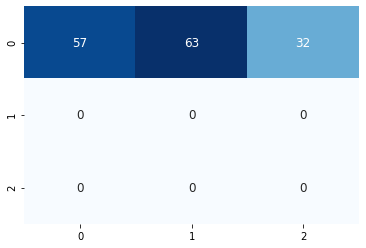

144/144 [==============================] - 0s 290us/sample - loss: 1.3941 - accuracy: 0.4236


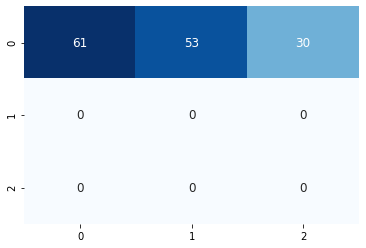

143/143 [==============================] - 0s 314us/sample - loss: 1.4430 - accuracy: 0.3916


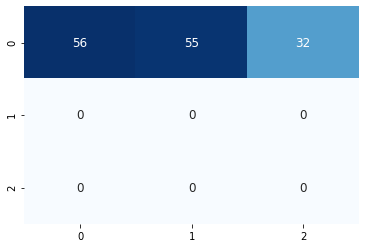

140/140 [==============================] - 0s 245us/sample - loss: 1.3651 - accuracy: 0.3929


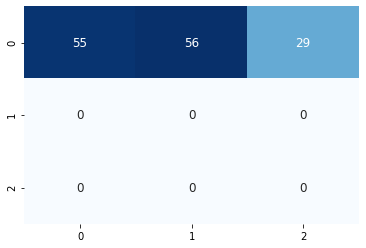

139/139 [==============================] - 0s 241us/sample - loss: 1.5204 - accuracy: 0.4101


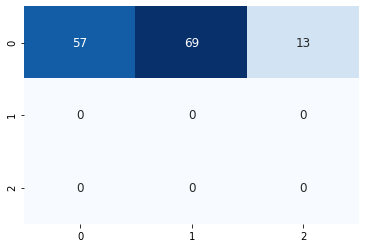

138/138 [==============================] - 0s 263us/sample - loss: 1.5090 - accuracy: 0.3478


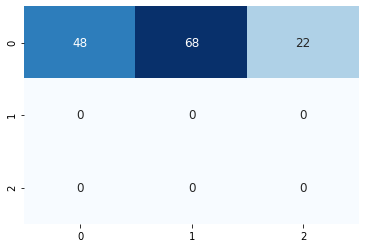

137/137 [==============================] - 0s 267us/sample - loss: 1.5422 - accuracy: 0.3504


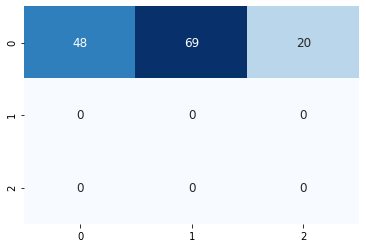

137/137 [==============================] - 0s 254us/sample - loss: 1.5742 - accuracy: 0.3431


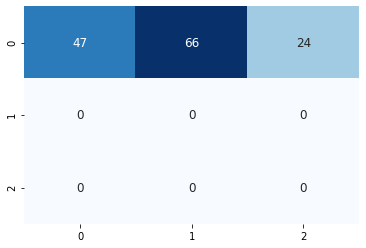

137/137 [==============================] - 0s 271us/sample - loss: 1.6806 - accuracy: 0.3504


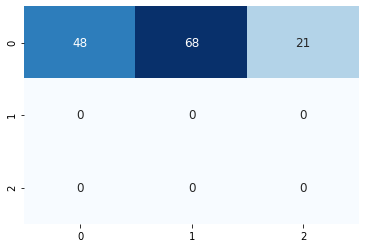

136/136 [==============================] - 0s 254us/sample - loss: 1.4531 - accuracy: 0.3824


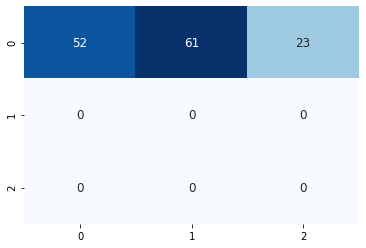

136/136 [==============================] - 0s 286us/sample - loss: 1.5864 - accuracy: 0.3235


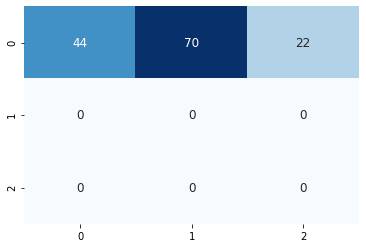

134/134 [==============================] - 0s 294us/sample - loss: 1.7620 - accuracy: 0.2537


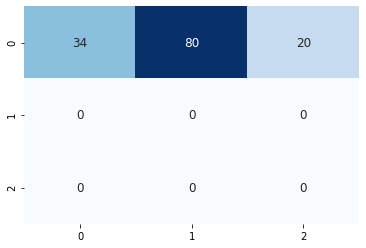

134/134 [==============================] - 0s 294us/sample - loss: 1.6487 - accuracy: 0.2985


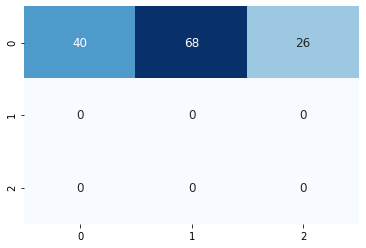

134/134 [==============================] - 0s 238us/sample - loss: 1.6574 - accuracy: 0.2985


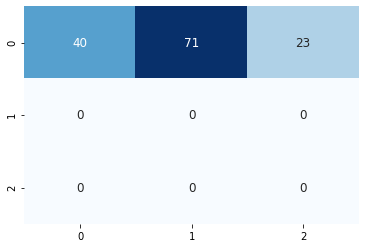

133/133 [==============================] - 0s 267us/sample - loss: 1.7345 - accuracy: 0.2932


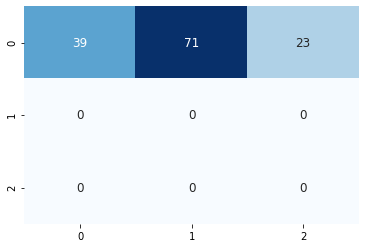

134/134 [==============================] - 0s 276us/sample - loss: 1.7006 - accuracy: 0.2463


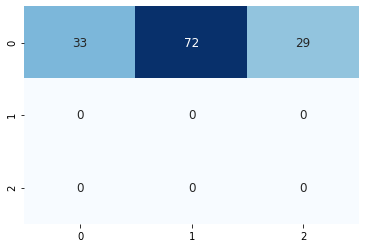

135/135 [==============================] - 0s 272us/sample - loss: 1.6752 - accuracy: 0.2667


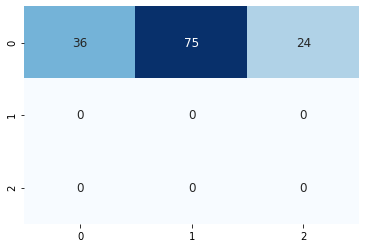

134/134 [==============================] - 0s 266us/sample - loss: 1.7224 - accuracy: 0.2910


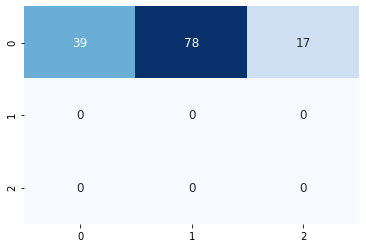

136/136 [==============================] - 0s 251us/sample - loss: 1.7527 - accuracy: 0.3162


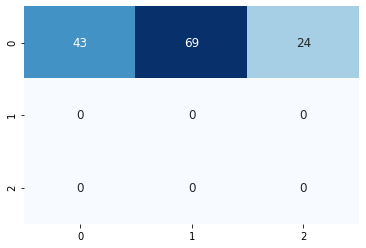

133/133 [==============================] - 0s 296us/sample - loss: 1.7141 - accuracy: 0.2782


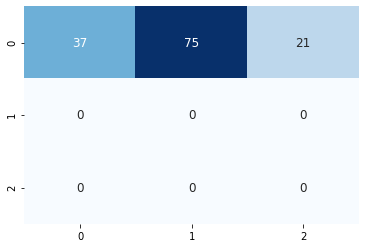

134/134 [==============================] - 0s 260us/sample - loss: 1.6930 - accuracy: 0.3134


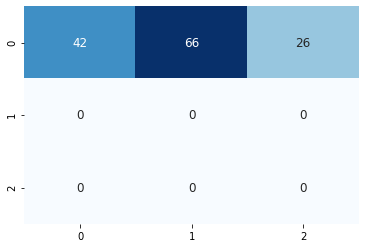

132/132 [==============================] - 0s 252us/sample - loss: 1.6083 - accuracy: 0.3106


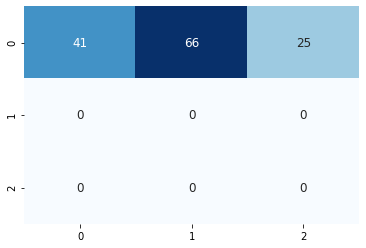

133/133 [==============================] - 0s 300us/sample - loss: 1.7068 - accuracy: 0.3158


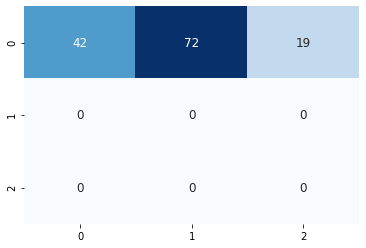

133/133 [==============================] - 0s 259us/sample - loss: 1.6847 - accuracy: 0.2406


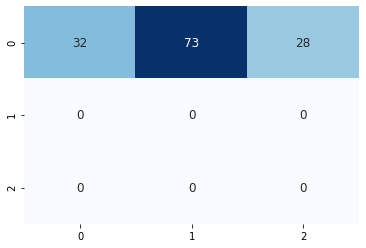

132/132 [==============================] - 0s 273us/sample - loss: 1.7496 - accuracy: 0.2803


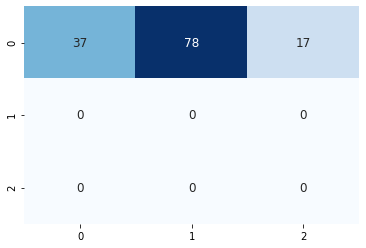

132/132 [==============================] - 0s 282us/sample - loss: 1.6839 - accuracy: 0.3030


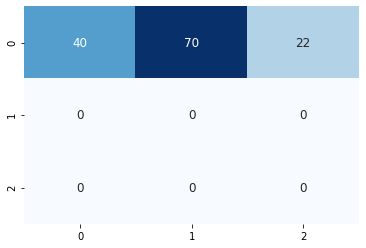

133/133 [==============================] - 0s 259us/sample - loss: 1.6483 - accuracy: 0.3308


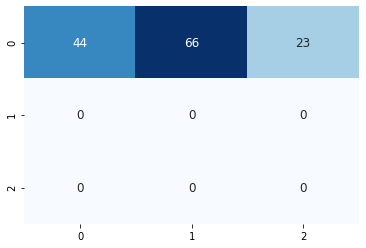

132/132 [==============================] - 0s 262us/sample - loss: 1.7906 - accuracy: 0.2879


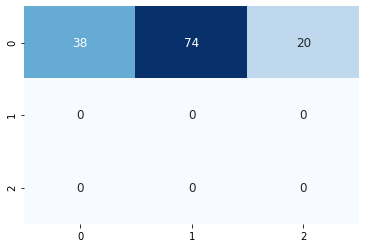

132/132 [==============================] - 0s 284us/sample - loss: 1.7417 - accuracy: 0.3106


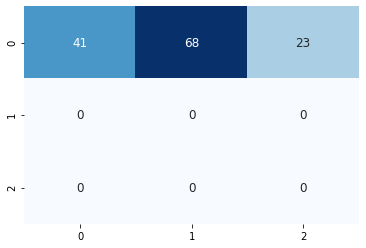

132/132 [==============================] - 0s 268us/sample - loss: 1.7391 - accuracy: 0.3182


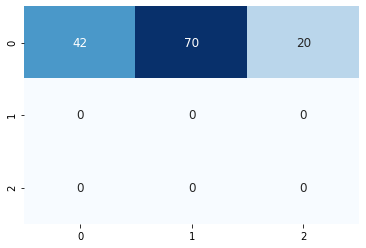

132/132 [==============================] - 0s 245us/sample - loss: 1.7032 - accuracy: 0.3258


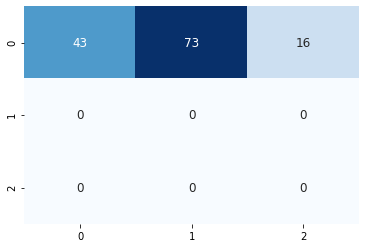

133/133 [==============================] - 0s 253us/sample - loss: 1.8651 - accuracy: 0.2857


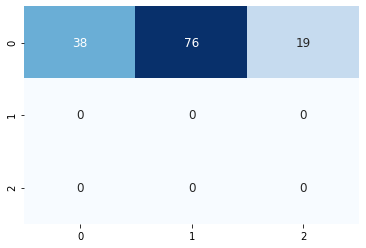

128/128 [==============================] - 0s 2ms/sample - loss: 1.7041 - accuracy: 0.2578


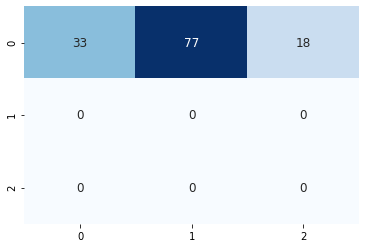

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3882 samples, validate on 985 samples
Epoch 1/300
3882/3882 [==============================] - 3s 736us/sample - loss: 0.9412 - accuracy: 0.4876 - val_loss: 1.0913 - val_accuracy: 0.3736
Epoch 2/300
3882/3882 [==============================] - 1s 217us/sample - loss: 0.7141 - accuracy: 0.6705 - val_loss: 1.1265 - val_accuracy: 0.4102
Epoch 3/300
3882/3882 [==============================] - 1s 216us/sample - loss: 0.5594 - accuracy: 0.7499 - val_loss: 1.1936 - val_accuracy: 0.4396
Epoch 4/300
3882/3882 [==============================] - 1s 207us/sample - loss: 0.4365 - accuracy: 0.8228 - val_loss: 1.2765 - val_accuracy: 0.4792
Epoch 00004: early stopping
122/122 [==============================] - 0s 3ms/sample - loss: 1.3808 - accuracy: 0.3279


6it [2:20:42, 1411.91s/it]
100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285 steps, validate for 73 steps
Epoch 1/300
285/285 [==============================] - 29s 101ms/step - loss: 1.4359 - accuracy: 0.4266 - val_loss: 1.2135 - val_accuracy: 0.3372
Epoch 2/300
285/285 [==============================] - 28s 98ms/step - loss: 1.0518 - accuracy: 0.4785 - val_loss: 1.1797 - val_accuracy: 0.3143
Epoch 3/300
285/285 [==============================] - 28s 98ms/step - loss: 1.0001 - accuracy: 0.4973 - val_loss: 1.2429 - val_accuracy: 0.3495
Epoch 4/300
285/285 [==============================] - 29s 100ms/step - loss: 0.9764 - accuracy: 0.5129 - val_loss: 1.3666 - val_accuracy: 0.3943
Epoch 5/300
285/285 [==============================] - 28s 99ms/step - loss: 0.9637 - accuracy: 0.5208 - val_loss: 1.2620 - val_accuracy: 0.3746
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 285 steps, validate for 73 steps
Epoch 1/300
285/285 [====

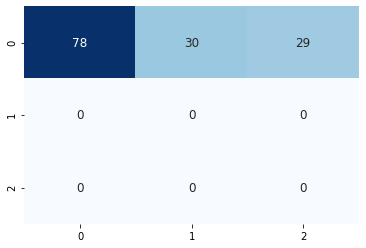

132/132 [==============================] - 0s 297us/sample - loss: 0.9698 - accuracy: 0.5833


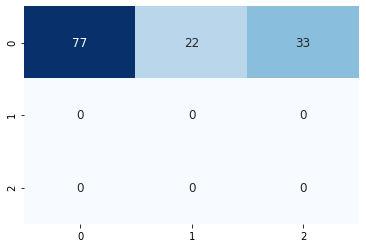

130/130 [==============================] - 0s 284us/sample - loss: 0.9470 - accuracy: 0.5692


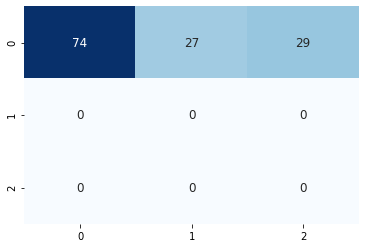

130/130 [==============================] - 0s 292us/sample - loss: 0.9492 - accuracy: 0.5231


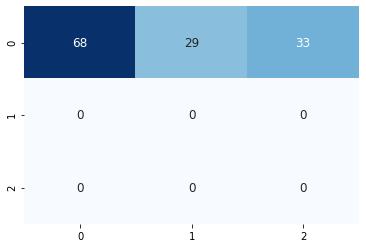

128/128 [==============================] - 0s 2ms/sample - loss: 0.9689 - accuracy: 0.5625


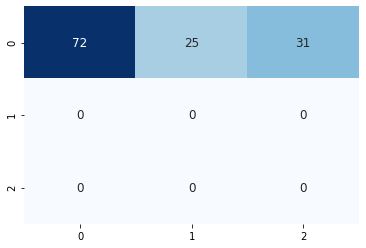

128/128 [==============================] - 0s 231us/sample - loss: 0.8986 - accuracy: 0.5938


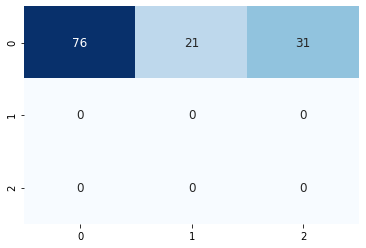

129/129 [==============================] - 0s 257us/sample - loss: 0.9470 - accuracy: 0.6047


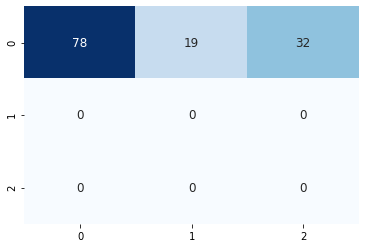

129/129 [==============================] - 0s 315us/sample - loss: 0.9533 - accuracy: 0.5891


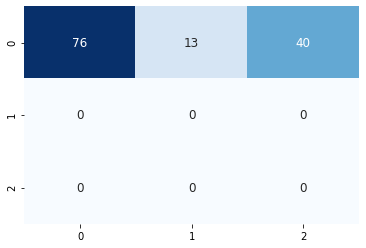

126/126 [==============================] - 0s 256us/sample - loss: 0.9141 - accuracy: 0.5714


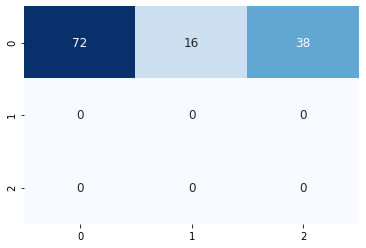

126/126 [==============================] - 0s 288us/sample - loss: 0.9922 - accuracy: 0.5476


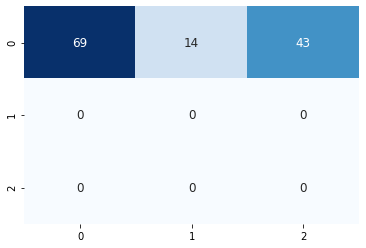

126/126 [==============================] - 0s 223us/sample - loss: 0.9918 - accuracy: 0.5556


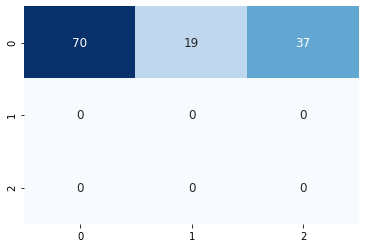

126/126 [==============================] - 0s 241us/sample - loss: 0.9590 - accuracy: 0.5952


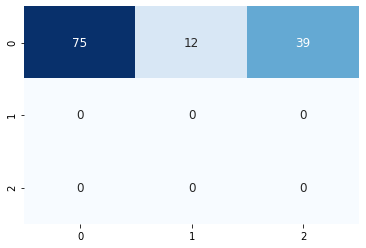

126/126 [==============================] - 0s 262us/sample - loss: 0.9492 - accuracy: 0.5556


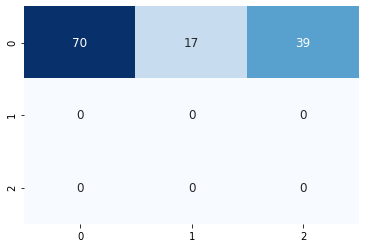

124/124 [==============================] - 0s 264us/sample - loss: 0.9966 - accuracy: 0.5806


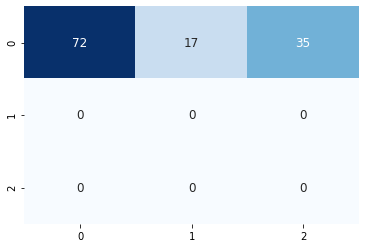

124/124 [==============================] - 0s 291us/sample - loss: 1.0406 - accuracy: 0.5484


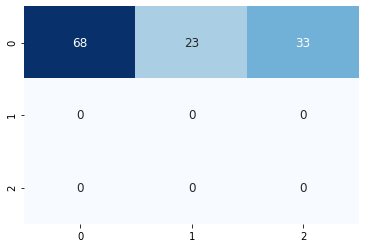

122/122 [==============================] - 0s 244us/sample - loss: 1.0090 - accuracy: 0.5328


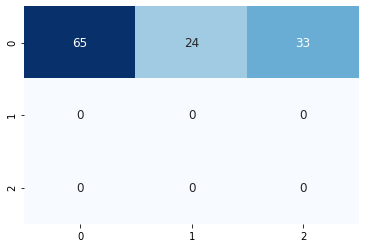

122/122 [==============================] - 0s 264us/sample - loss: 0.9938 - accuracy: 0.5328


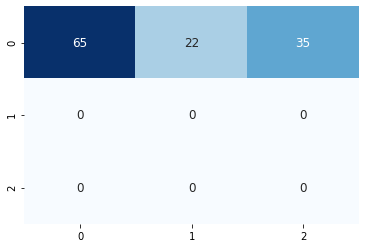

120/120 [==============================] - 0s 238us/sample - loss: 1.0256 - accuracy: 0.5083


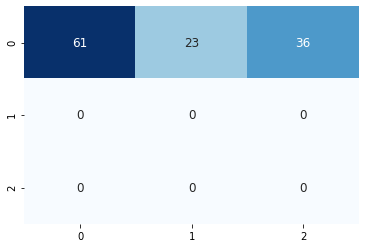

121/121 [==============================] - 0s 256us/sample - loss: 1.0865 - accuracy: 0.5372


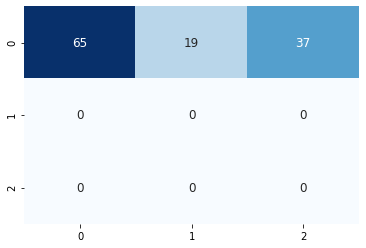

121/121 [==============================] - 0s 257us/sample - loss: 1.1134 - accuracy: 0.4959


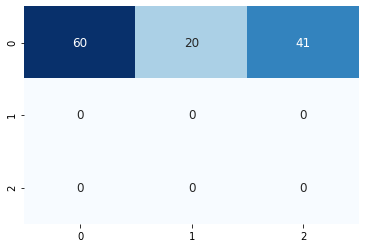

120/120 [==============================] - 0s 266us/sample - loss: 1.0620 - accuracy: 0.5750


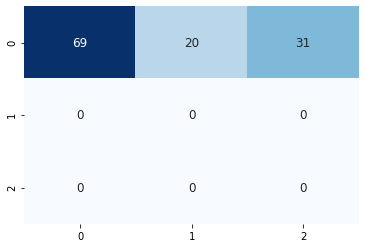

121/121 [==============================] - 0s 259us/sample - loss: 0.8735 - accuracy: 0.6281


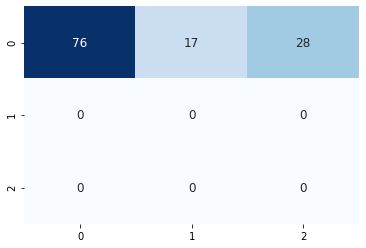

120/120 [==============================] - 0s 275us/sample - loss: 0.9180 - accuracy: 0.6000


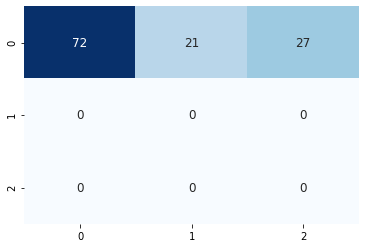

120/120 [==============================] - 0s 264us/sample - loss: 0.8761 - accuracy: 0.6333


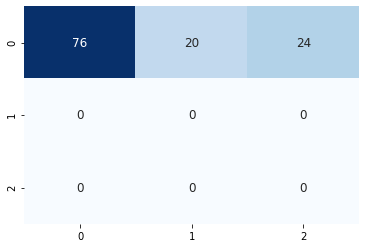

120/120 [==============================] - 0s 258us/sample - loss: 0.9214 - accuracy: 0.6167


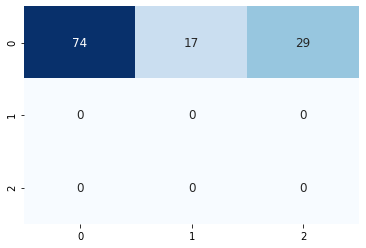

120/120 [==============================] - 0s 283us/sample - loss: 0.9571 - accuracy: 0.6083


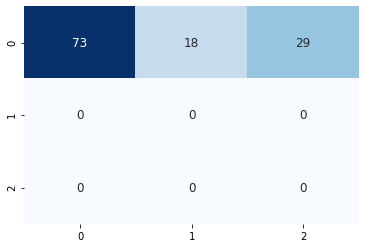

122/122 [==============================] - 0s 261us/sample - loss: 0.9314 - accuracy: 0.6148


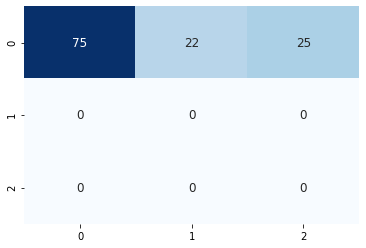

119/119 [==============================] - 0s 254us/sample - loss: 0.8915 - accuracy: 0.5798


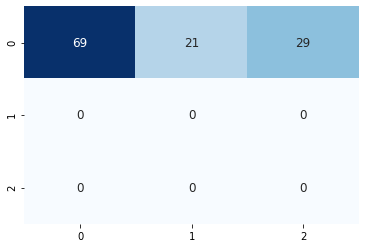

116/116 [==============================] - 0s 248us/sample - loss: 0.9222 - accuracy: 0.5517


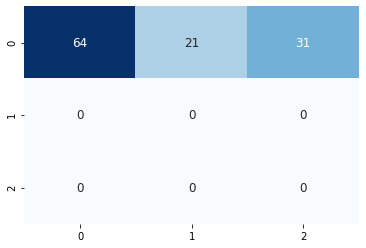

117/117 [==============================] - 0s 252us/sample - loss: 0.9061 - accuracy: 0.5812


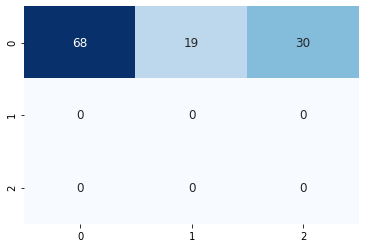

116/116 [==============================] - 0s 274us/sample - loss: 0.8295 - accuracy: 0.6121


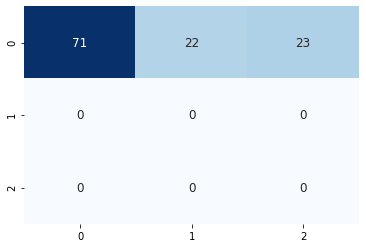

117/117 [==============================] - 0s 273us/sample - loss: 0.9743 - accuracy: 0.5726


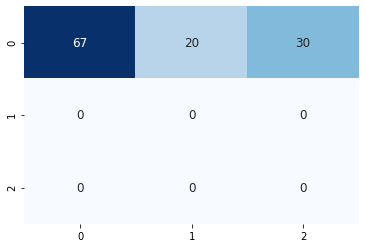

117/117 [==============================] - 0s 310us/sample - loss: 0.8389 - accuracy: 0.6325


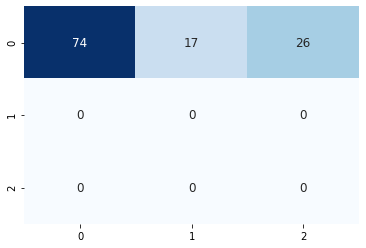

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3891 samples, validate on 989 samples
Epoch 1/300
3891/3891 [==============================] - 3s 687us/sample - loss: 1.0534 - accuracy: 0.4464 - val_loss: 1.0904 - val_accuracy: 0.4024
Epoch 2/300
3891/3891 [==============================] - 1s 201us/sample - loss: 0.8551 - accuracy: 0.5878 - val_loss: 1.1017 - val_accuracy: 0.4237
Epoch 3/300
3891/3891 [==============================] - 1s 180us/sample - loss: 0.7044 - accuracy: 0.6677 - val_loss: 1.1552 - val_accuracy: 0.4408
Epoch 4/300
3891/3891 [==============================] - 1s 177us/sample - loss: 0.5841 - accuracy: 0.7309 - val_loss: 1.2330 - val_accuracy: 0.4580
Epoch 00004: early stopping
109/109 [==============================] - 0s 4ms/sample - loss: 0.7985 - accuracy: 0.6239


7it [2:43:19, 1395.29s/it]
100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 286 steps, validate for 74 steps
Epoch 1/300
286/286 [==============================] - 30s 104ms/step - loss: 1.4314 - accuracy: 0.4383 - val_loss: 1.2250 - val_accuracy: 0.4025
Epoch 2/300
286/286 [==============================] - 28s 98ms/step - loss: 1.0424 - accuracy: 0.4902 - val_loss: 1.2305 - val_accuracy: 0.4041
Epoch 3/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9867 - accuracy: 0.5123 - val_loss: 1.2239 - val_accuracy: 0.3704
Epoch 4/300
286/286 [==============================] - 28s 99ms/step - loss: 0.9653 - accuracy: 0.5249 - val_loss: 1.2843 - val_accuracy: 0.4102
Epoch 5/300
286/286 [==============================] - 28s 98ms/step - loss: 0.9499 - accuracy: 0.5357 - val_loss: 1.2831 - val_accuracy: 0.3978
Epoch 6/300
286/286 [==============================] - 28s 98ms/step - loss: 0.9440 - accuracy: 0.5424 - val_loss: 1.2586 - val_accuracy: 0.3679
Ep

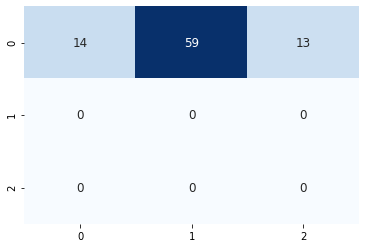

85/85 [==============================] - 0s 239us/sample - loss: 1.5408 - accuracy: 0.3059


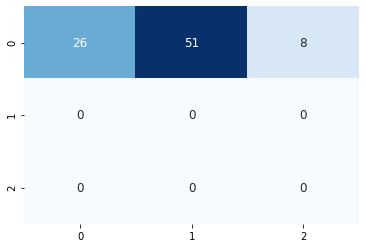

84/84 [==============================] - 0s 243us/sample - loss: 1.5787 - accuracy: 0.2738


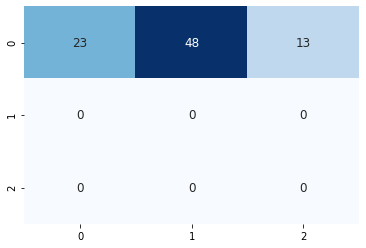

82/82 [==============================] - 0s 280us/sample - loss: 1.5228 - accuracy: 0.2927


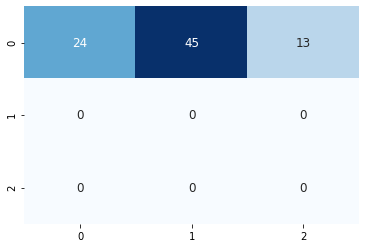

83/83 [==============================] - 0s 247us/sample - loss: 1.6490 - accuracy: 0.2410


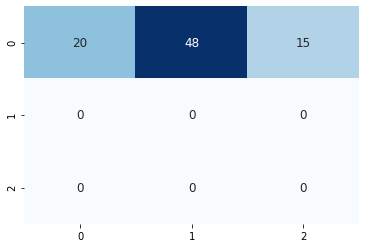

83/83 [==============================] - 0s 263us/sample - loss: 1.6322 - accuracy: 0.2771


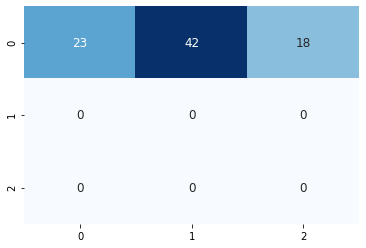

82/82 [==============================] - 0s 261us/sample - loss: 1.5202 - accuracy: 0.3049


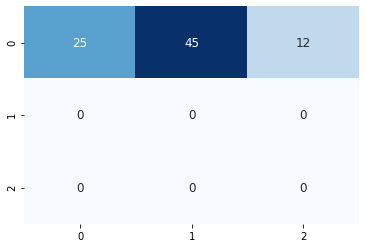

82/82 [==============================] - 0s 276us/sample - loss: 1.4874 - accuracy: 0.3415


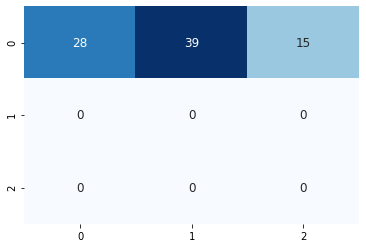

80/80 [==============================] - 0s 281us/sample - loss: 1.6405 - accuracy: 0.3000


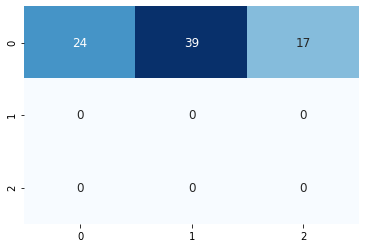

79/79 [==============================] - 0s 401us/sample - loss: 1.5789 - accuracy: 0.3671


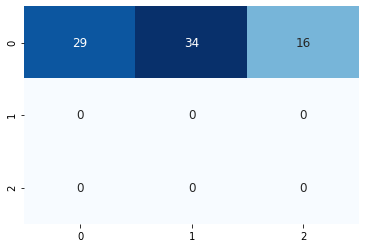

79/79 [==============================] - 0s 299us/sample - loss: 1.3803 - accuracy: 0.3165


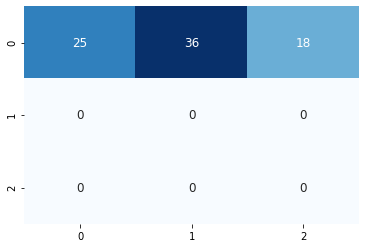

78/78 [==============================] - 0s 323us/sample - loss: 1.4223 - accuracy: 0.4359


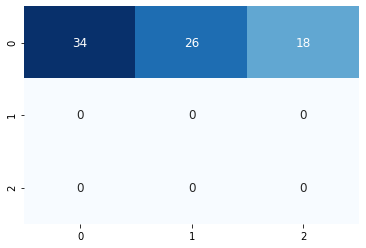

78/78 [==============================] - 0s 259us/sample - loss: 1.5509 - accuracy: 0.3333


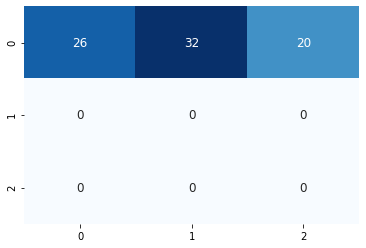

79/79 [==============================] - 0s 282us/sample - loss: 1.5360 - accuracy: 0.3924


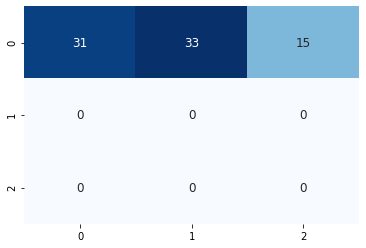

78/78 [==============================] - 0s 306us/sample - loss: 1.6945 - accuracy: 0.3462


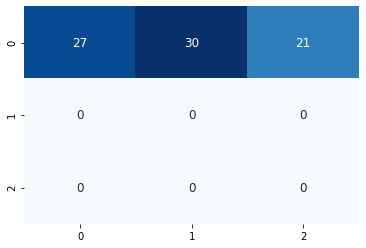

77/77 [==============================] - 0s 301us/sample - loss: 1.5996 - accuracy: 0.2857


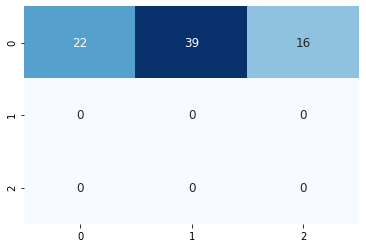

76/76 [==============================] - 0s 271us/sample - loss: 1.6092 - accuracy: 0.3026


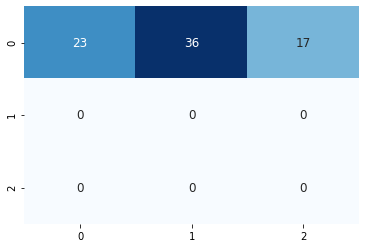

76/76 [==============================] - 0s 279us/sample - loss: 1.4908 - accuracy: 0.3684


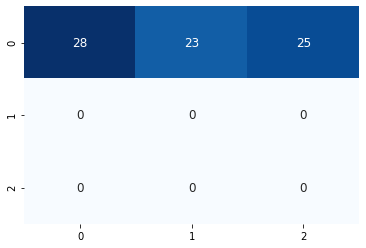

75/75 [==============================] - 0s 288us/sample - loss: 1.6508 - accuracy: 0.2800


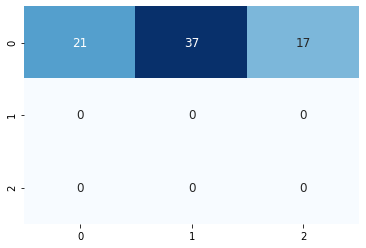

76/76 [==============================] - 0s 275us/sample - loss: 1.5094 - accuracy: 0.3421


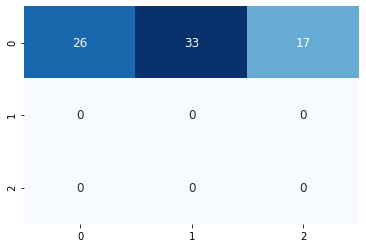

76/76 [==============================] - 0s 288us/sample - loss: 1.6098 - accuracy: 0.3553


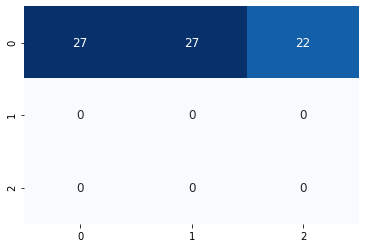

76/76 [==============================] - 0s 286us/sample - loss: 1.6570 - accuracy: 0.3553


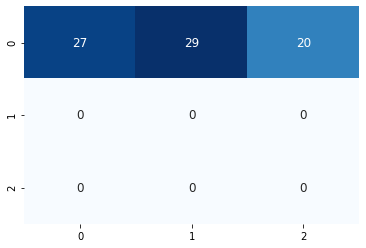

75/75 [==============================] - 0s 313us/sample - loss: 1.6228 - accuracy: 0.3467


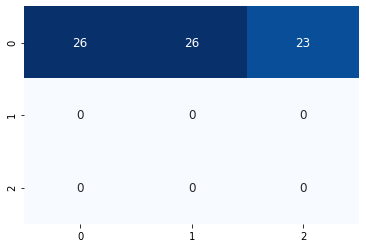

75/75 [==============================] - 0s 323us/sample - loss: 1.4676 - accuracy: 0.3867


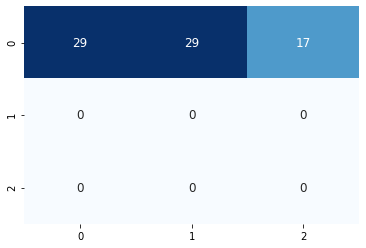

74/74 [==============================] - 0s 282us/sample - loss: 1.6124 - accuracy: 0.3378


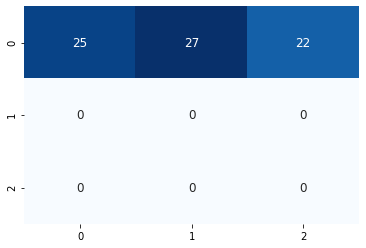

75/75 [==============================] - 0s 442us/sample - loss: 1.6611 - accuracy: 0.2400


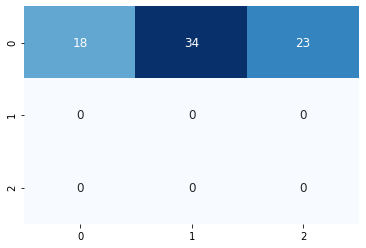

75/75 [==============================] - 0s 281us/sample - loss: 1.6687 - accuracy: 0.3467


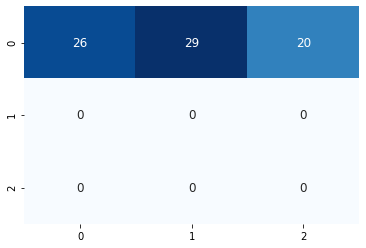

74/74 [==============================] - 0s 278us/sample - loss: 1.7586 - accuracy: 0.3378


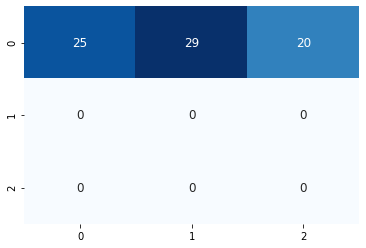

73/73 [==============================] - 0s 313us/sample - loss: 1.7465 - accuracy: 0.3836


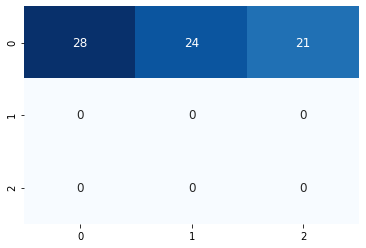

73/73 [==============================] - 0s 332us/sample - loss: 1.7103 - accuracy: 0.3562


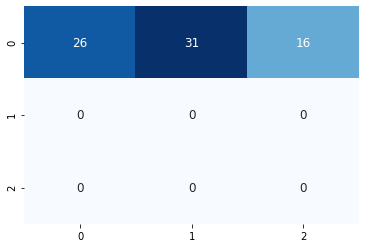

73/73 [==============================] - 0s 305us/sample - loss: 1.8427 - accuracy: 0.3151


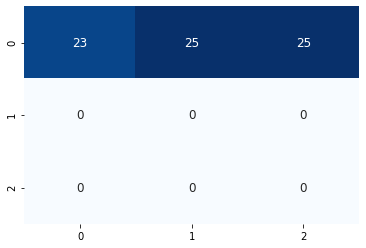

73/73 [==============================] - 0s 292us/sample - loss: 1.7514 - accuracy: 0.3014


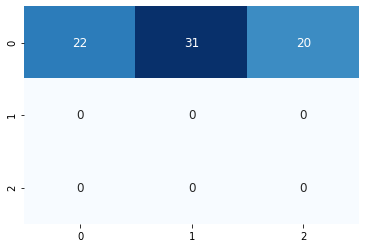

71/71 [==============================] - 0s 314us/sample - loss: 1.5897 - accuracy: 0.3380


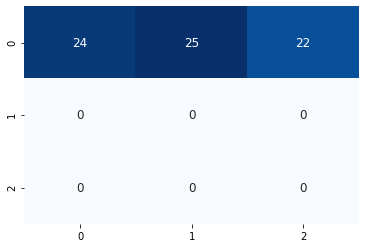

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3914 samples, validate on 1009 samples
Epoch 1/300
3914/3914 [==============================] - 3s 673us/sample - loss: 0.9390 - accuracy: 0.5171 - val_loss: 1.0740 - val_accuracy: 0.3786
Epoch 2/300
3914/3914 [==============================] - 1s 222us/sample - loss: 0.7395 - accuracy: 0.6533 - val_loss: 1.1022 - val_accuracy: 0.4113
Epoch 3/300
3914/3914 [==============================] - 1s 221us/sample - loss: 0.5943 - accuracy: 0.7261 - val_loss: 1.1789 - val_accuracy: 0.4371
Epoch 4/300
3914/3914 [==============================] - 1s 212us/sample - loss: 0.4813 - accuracy: 0.7885 - val_loss: 1.2827 - val_accuracy: 0.4559
Epoch 00004: early stopping
66/66 [==============================] - 0s 6ms/sample - loss: 1.4687 - accuracy: 0.3333


8it [3:06:58, 1402.41s/it]
100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 282 steps, validate for 73 steps
Epoch 1/300
282/282 [==============================] - 29s 103ms/step - loss: 1.4393 - accuracy: 0.4470 - val_loss: 1.2311 - val_accuracy: 0.4593
Epoch 2/300
282/282 [==============================] - 27s 97ms/step - loss: 1.0391 - accuracy: 0.4977 - val_loss: 1.1512 - val_accuracy: 0.3812
Epoch 3/300
282/282 [==============================] - 27s 97ms/step - loss: 0.9828 - accuracy: 0.5163 - val_loss: 1.2046 - val_accuracy: 0.3998
Epoch 4/300
282/282 [==============================] - 28s 98ms/step - loss: 0.9593 - accuracy: 0.5299 - val_loss: 1.2687 - val_accuracy: 0.3288
Epoch 5/300
282/282 [==============================] - 28s 99ms/step - loss: 0.9456 - accuracy: 0.5380 - val_loss: 1.3548 - val_accuracy: 0.4014
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 282 steps, validate for 73 steps
Epoch 1/300
282/282 [=====

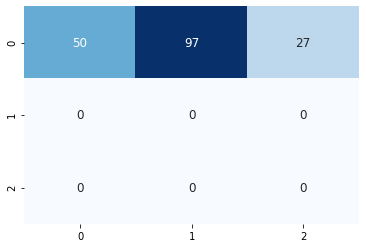

169/169 [==============================] - 0s 227us/sample - loss: 1.5387 - accuracy: 0.3491


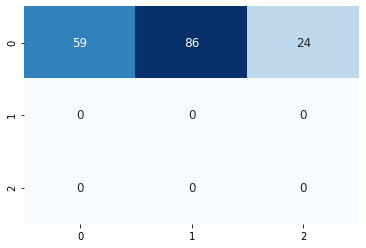

170/170 [==============================] - 0s 267us/sample - loss: 1.6000 - accuracy: 0.3176


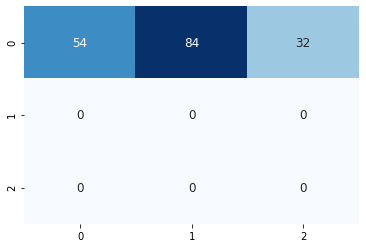

167/167 [==============================] - 0s 253us/sample - loss: 1.5572 - accuracy: 0.2934


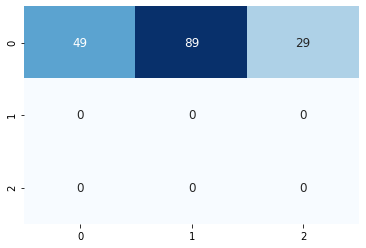

168/168 [==============================] - 0s 227us/sample - loss: 1.6473 - accuracy: 0.2917


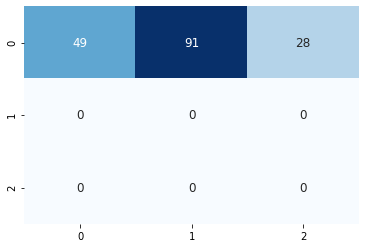

169/169 [==============================] - 0s 277us/sample - loss: 1.7942 - accuracy: 0.2249


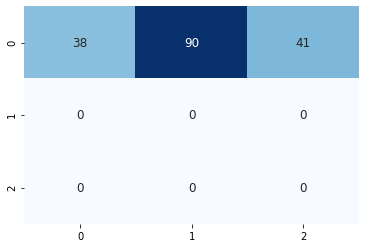

169/169 [==============================] - 0s 266us/sample - loss: 1.7255 - accuracy: 0.2604


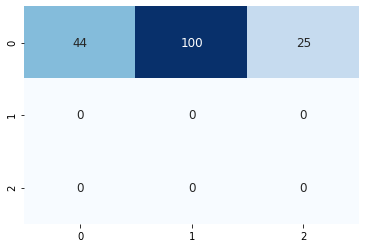

167/167 [==============================] - 0s 255us/sample - loss: 2.0126 - accuracy: 0.1916


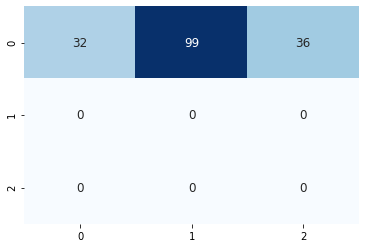

166/166 [==============================] - 0s 263us/sample - loss: 2.0093 - accuracy: 0.1506


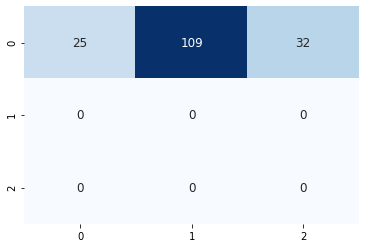

164/164 [==============================] - 0s 264us/sample - loss: 2.0681 - accuracy: 0.1524


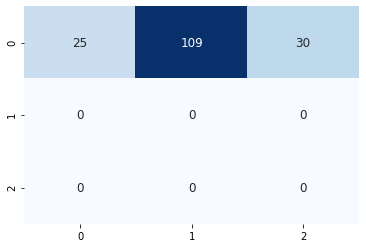

164/164 [==============================] - 0s 271us/sample - loss: 2.1107 - accuracy: 0.1524


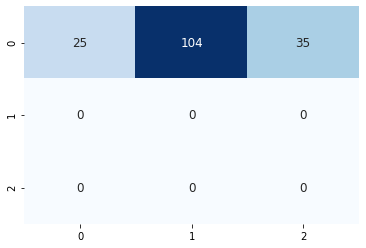

164/164 [==============================] - 0s 273us/sample - loss: 2.0749 - accuracy: 0.1707


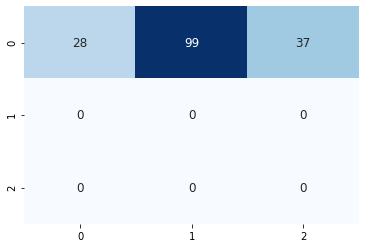

163/163 [==============================] - 0s 236us/sample - loss: 2.0649 - accuracy: 0.1840


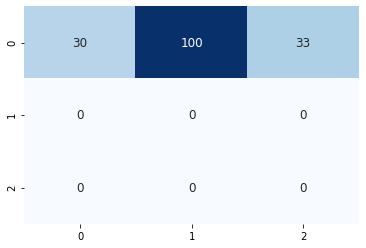

161/161 [==============================] - 0s 261us/sample - loss: 2.0464 - accuracy: 0.2112


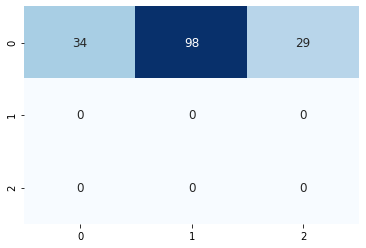

159/159 [==============================] - 0s 238us/sample - loss: 2.0688 - accuracy: 0.2013


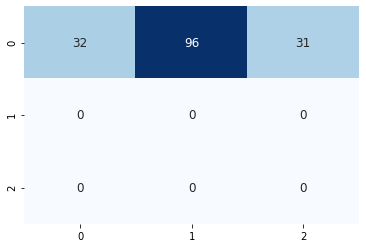

161/161 [==============================] - 0s 275us/sample - loss: 2.0086 - accuracy: 0.2112


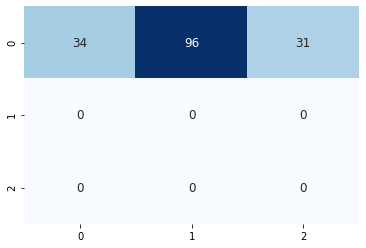

159/159 [==============================] - 0s 264us/sample - loss: 2.0739 - accuracy: 0.1950


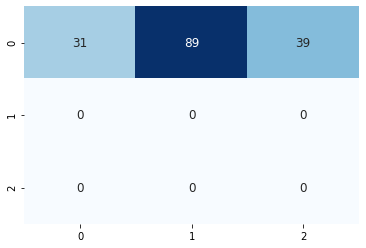

158/158 [==============================] - 0s 244us/sample - loss: 2.1025 - accuracy: 0.1962


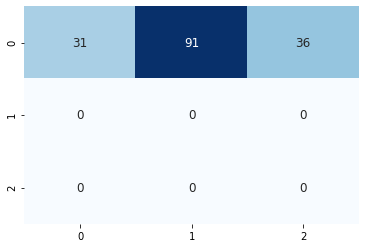

159/159 [==============================] - 0s 269us/sample - loss: 2.1249 - accuracy: 0.1950


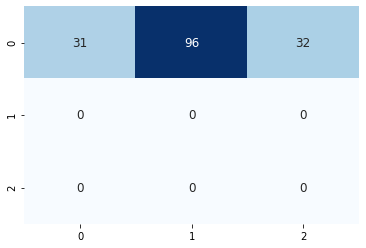

158/158 [==============================] - 0s 227us/sample - loss: 2.0821 - accuracy: 0.2215


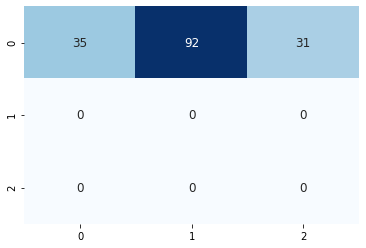

157/157 [==============================] - 0s 242us/sample - loss: 2.0780 - accuracy: 0.2420


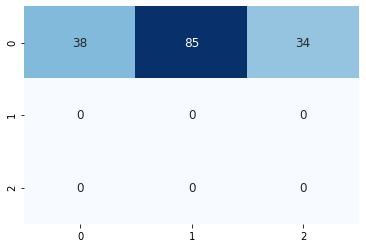

157/157 [==============================] - 0s 280us/sample - loss: 2.1117 - accuracy: 0.1720


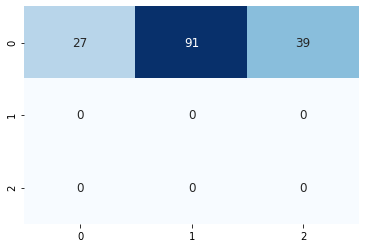

157/157 [==============================] - 0s 239us/sample - loss: 2.2218 - accuracy: 0.1911


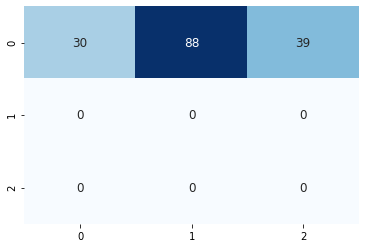

157/157 [==============================] - 0s 232us/sample - loss: 2.0382 - accuracy: 0.2166


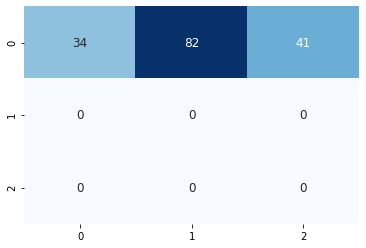

154/154 [==============================] - 0s 253us/sample - loss: 2.1322 - accuracy: 0.2208


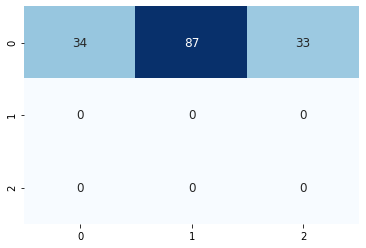

153/153 [==============================] - 0s 241us/sample - loss: 1.9492 - accuracy: 0.2484


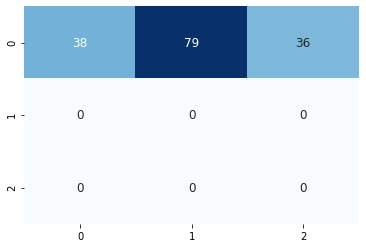

153/153 [==============================] - 0s 286us/sample - loss: 2.1653 - accuracy: 0.2026


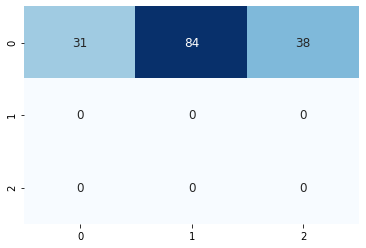

153/153 [==============================] - 0s 252us/sample - loss: 1.9613 - accuracy: 0.2549


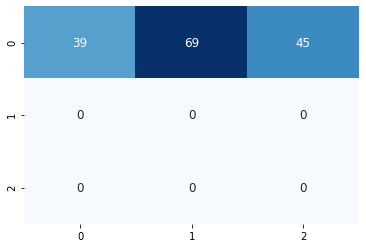

150/150 [==============================] - 0s 264us/sample - loss: 2.0463 - accuracy: 0.2533


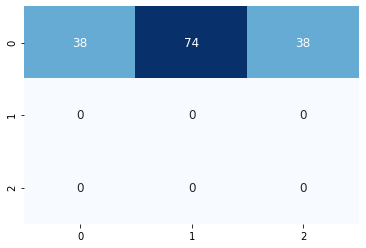

150/150 [==============================] - 0s 266us/sample - loss: 2.1550 - accuracy: 0.2333


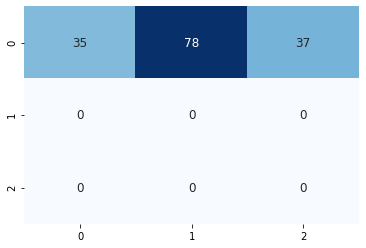

152/152 [==============================] - 0s 291us/sample - loss: 1.9019 - accuracy: 0.2829


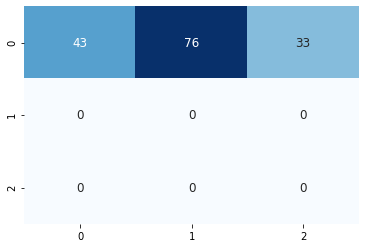

151/151 [==============================] - 0s 257us/sample - loss: 1.9735 - accuracy: 0.2185


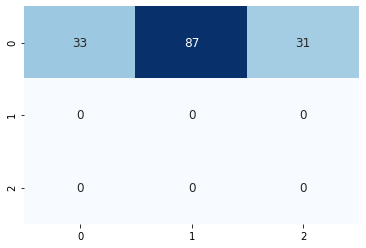

147/147 [==============================] - 0s 268us/sample - loss: 2.0342 - accuracy: 0.2313


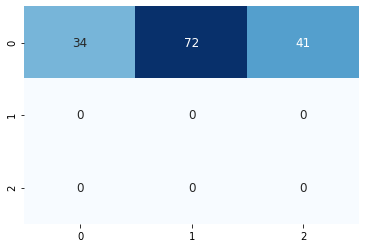

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3856 samples, validate on 994 samples
Epoch 1/300
3856/3856 [==============================] - 3s 698us/sample - loss: 0.9166 - accuracy: 0.5708 - val_loss: 1.1029 - val_accuracy: 0.4165
Epoch 2/300
3856/3856 [==============================] - 1s 228us/sample - loss: 0.5770 - accuracy: 0.7793 - val_loss: 1.1900 - val_accuracy: 0.4779
Epoch 3/300
3856/3856 [==============================] - 1s 215us/sample - loss: 0.3615 - accuracy: 0.8833 - val_loss: 1.3638 - val_accuracy: 0.5181
Epoch 4/300
3856/3856 [==============================] - 1s 218us/sample - loss: 0.2418 - accuracy: 0.9240 - val_loss: 1.5598 - val_accuracy: 0.5272
Epoch 00004: early stopping
139/139 [==============================] - 0s 3ms/sample - loss: 2.7463 - accuracy: 0.0863


9it [3:31:49, 1429.19s/it]
100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 72 steps
Epoch 1/300
283/283 [==============================] - 29s 103ms/step - loss: 1.4222 - accuracy: 0.4205 - val_loss: 1.2037 - val_accuracy: 0.3739
Epoch 2/300
283/283 [==============================] - 28s 99ms/step - loss: 1.0490 - accuracy: 0.4728 - val_loss: 1.1772 - val_accuracy: 0.3930
Epoch 3/300
283/283 [==============================] - 28s 100ms/step - loss: 0.9951 - accuracy: 0.5001 - val_loss: 1.2444 - val_accuracy: 0.3784
Epoch 4/300
283/283 [==============================] - 28s 99ms/step - loss: 0.9752 - accuracy: 0.5132 - val_loss: 1.3023 - val_accuracy: 0.3364
Epoch 5/300
283/283 [==============================] - 28s 100ms/step - loss: 0.9598 - accuracy: 0.5252 - val_loss: 1.2927 - val_accuracy: 0.3573
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 72 steps
Epoch 1/300
283/283 [===

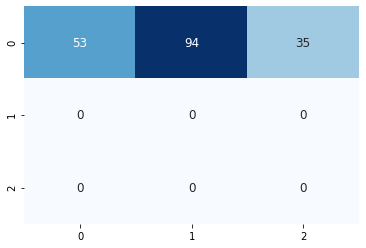

181/181 [==============================] - 0s 250us/sample - loss: 1.5127 - accuracy: 0.2707


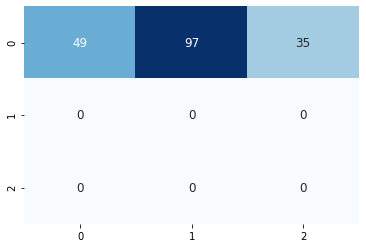

178/178 [==============================] - 0s 215us/sample - loss: 1.5714 - accuracy: 0.2809


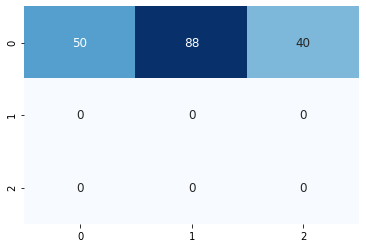

175/175 [==============================] - 0s 271us/sample - loss: 1.6301 - accuracy: 0.2743


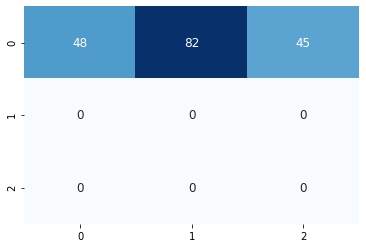

175/175 [==============================] - 0s 261us/sample - loss: 1.4958 - accuracy: 0.2971


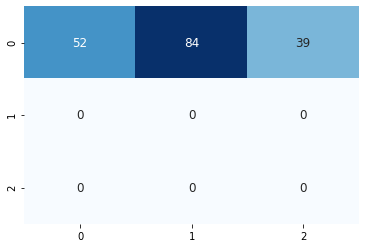

175/175 [==============================] - 0s 248us/sample - loss: 1.5604 - accuracy: 0.2800


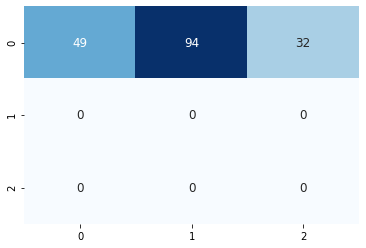

172/172 [==============================] - 0s 255us/sample - loss: 1.5305 - accuracy: 0.2965


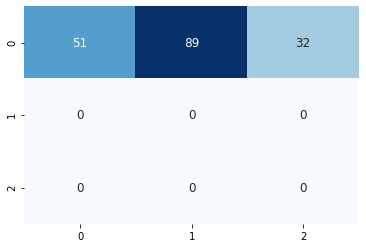

172/172 [==============================] - 0s 233us/sample - loss: 1.6351 - accuracy: 0.2674


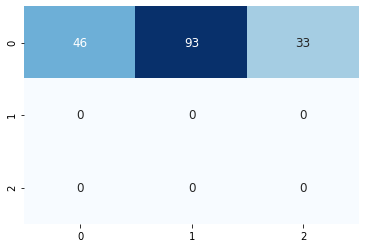

170/170 [==============================] - 0s 281us/sample - loss: 1.5005 - accuracy: 0.3176


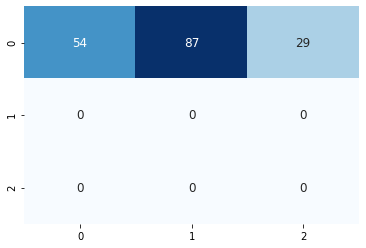

168/168 [==============================] - 0s 270us/sample - loss: 1.4066 - accuracy: 0.3690


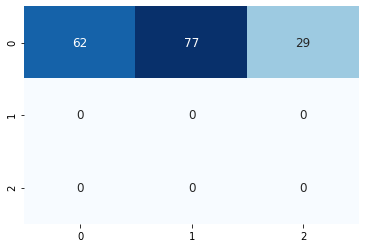

168/168 [==============================] - 0s 241us/sample - loss: 1.4175 - accuracy: 0.3393


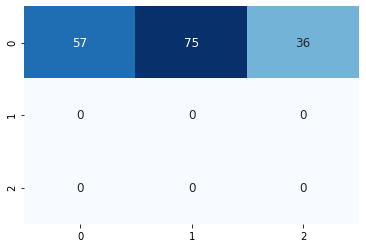

166/166 [==============================] - 0s 239us/sample - loss: 1.4143 - accuracy: 0.3614


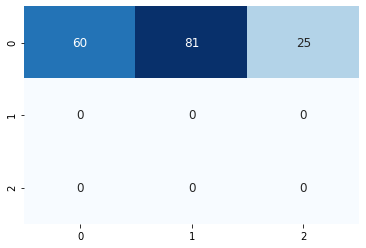

164/164 [==============================] - 0s 308us/sample - loss: 1.5160 - accuracy: 0.3720


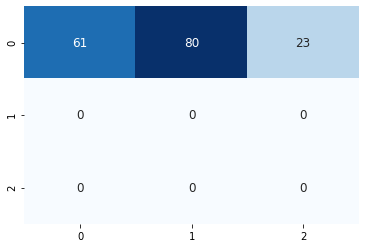

164/164 [==============================] - 0s 259us/sample - loss: 1.3389 - accuracy: 0.3902


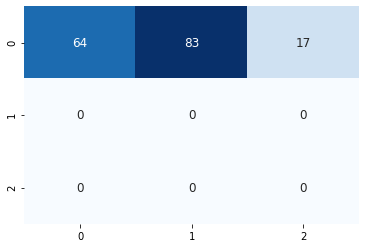

163/163 [==============================] - 0s 257us/sample - loss: 1.4492 - accuracy: 0.3620


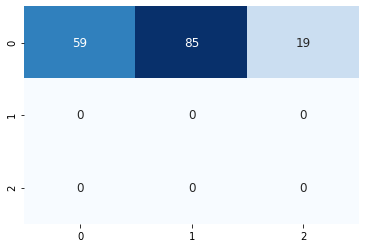

161/161 [==============================] - 0s 262us/sample - loss: 1.3758 - accuracy: 0.3540


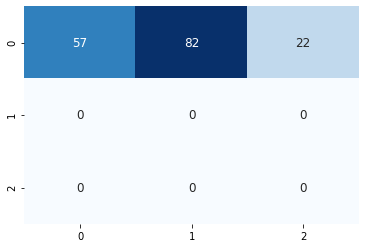

162/162 [==============================] - 0s 247us/sample - loss: 1.3765 - accuracy: 0.3889


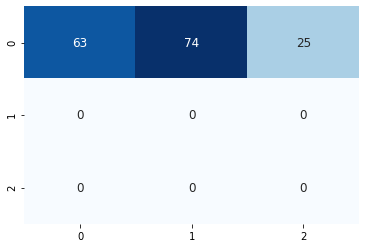

159/159 [==============================] - 0s 244us/sample - loss: 1.4503 - accuracy: 0.4025


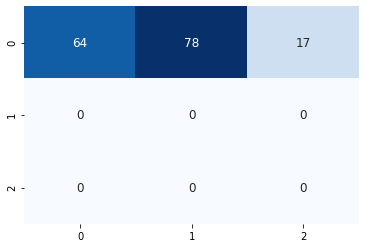

158/158 [==============================] - 0s 247us/sample - loss: 1.3998 - accuracy: 0.3987


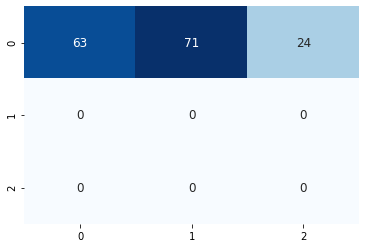

159/159 [==============================] - 0s 238us/sample - loss: 1.5332 - accuracy: 0.3648


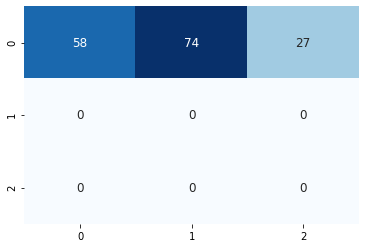

158/158 [==============================] - 0s 240us/sample - loss: 1.5591 - accuracy: 0.3291


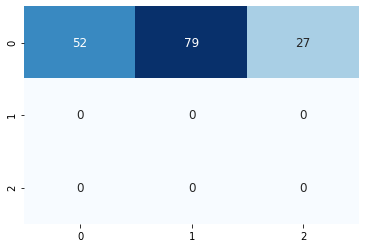

158/158 [==============================] - 0s 253us/sample - loss: 1.4268 - accuracy: 0.3861


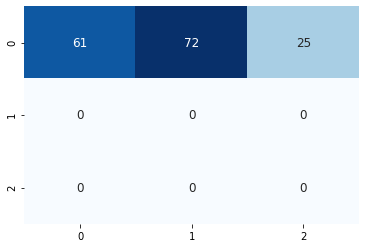

160/160 [==============================] - 0s 1ms/sample - loss: 1.4744 - accuracy: 0.4000


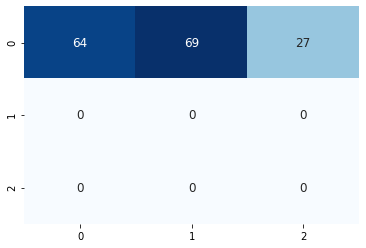

157/157 [==============================] - 0s 259us/sample - loss: 1.4920 - accuracy: 0.3312


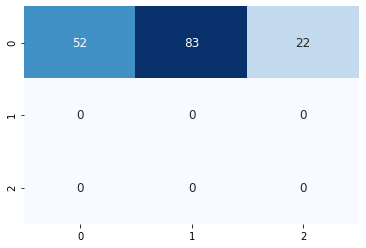

154/154 [==============================] - 0s 289us/sample - loss: 1.4482 - accuracy: 0.3506


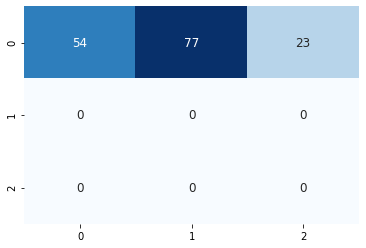

155/155 [==============================] - 0s 273us/sample - loss: 1.3539 - accuracy: 0.3484


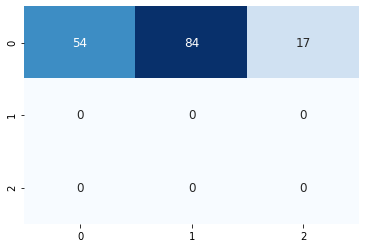

154/154 [==============================] - 0s 294us/sample - loss: 1.3604 - accuracy: 0.4026


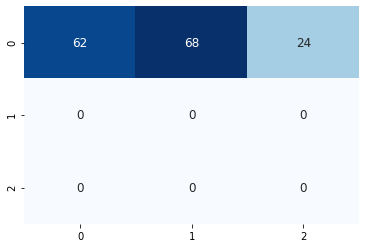

153/153 [==============================] - 0s 238us/sample - loss: 1.3144 - accuracy: 0.4248


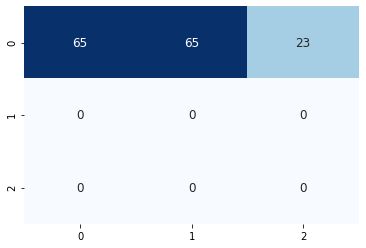

151/151 [==============================] - 0s 262us/sample - loss: 1.3288 - accuracy: 0.4503


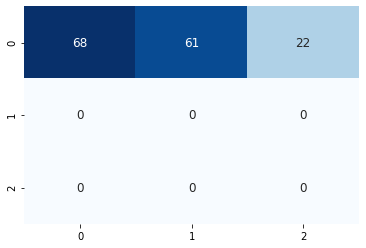

151/151 [==============================] - 0s 242us/sample - loss: 1.3265 - accuracy: 0.4371


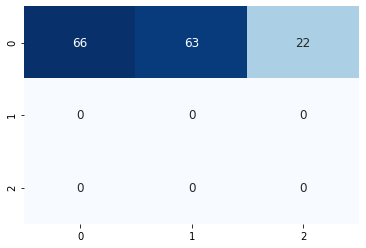

151/151 [==============================] - 0s 241us/sample - loss: 1.2345 - accuracy: 0.4834


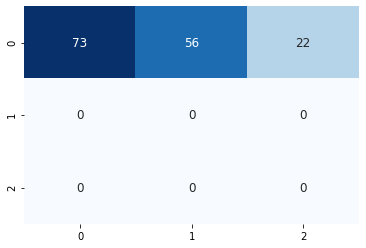

147/147 [==============================] - 0s 235us/sample - loss: 1.2597 - accuracy: 0.4014


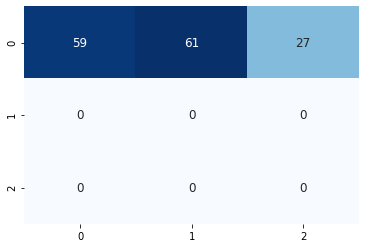

148/148 [==============================] - 0s 267us/sample - loss: 1.3109 - accuracy: 0.4527


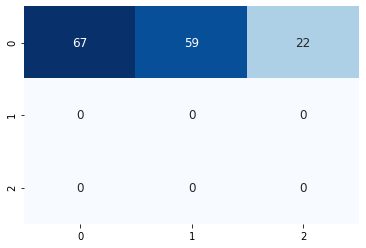

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3864 samples, validate on 982 samples
Epoch 1/300
3864/3864 [==============================] - 3s 680us/sample - loss: 0.9421 - accuracy: 0.5443 - val_loss: 1.0849 - val_accuracy: 0.4175
Epoch 2/300
3864/3864 [==============================] - 1s 195us/sample - loss: 0.6932 - accuracy: 0.7076 - val_loss: 1.1734 - val_accuracy: 0.4287
Epoch 3/300
3864/3864 [==============================] - 1s 217us/sample - loss: 0.5104 - accuracy: 0.7746 - val_loss: 1.3211 - val_accuracy: 0.4501
Epoch 4/300
3864/3864 [==============================] - 1s 197us/sample - loss: 0.3897 - accuracy: 0.8346 - val_loss: 1.4631 - val_accuracy: 0.4807
Epoch 00004: early stopping
143/143 [==============================] - 0s 3ms/sample - loss: 1.0395 - accuracy: 0.4965


10it [3:55:37, 1428.72s/it]
100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 72 steps
Epoch 1/300
284/284 [==============================] - 29s 102ms/step - loss: 1.4800 - accuracy: 0.4319 - val_loss: 1.2247 - val_accuracy: 0.3847
Epoch 2/300
284/284 [==============================] - 28s 97ms/step - loss: 1.0644 - accuracy: 0.4833 - val_loss: 1.1713 - val_accuracy: 0.3576
Epoch 3/300
284/284 [==============================] - 28s 97ms/step - loss: 1.0003 - accuracy: 0.5032 - val_loss: 1.2556 - val_accuracy: 0.3744
Epoch 4/300
284/284 [==============================] - 28s 99ms/step - loss: 0.9749 - accuracy: 0.5176 - val_loss: 1.2898 - val_accuracy: 0.3554
Epoch 5/300
284/284 [==============================] - 28s 100ms/step - loss: 0.9639 - accuracy: 0.5271 - val_loss: 1.2421 - val_accuracy: 0.3681
Epoch 00005: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 284 steps, validate for 72 steps
Epoch 1/300
284/284 [====

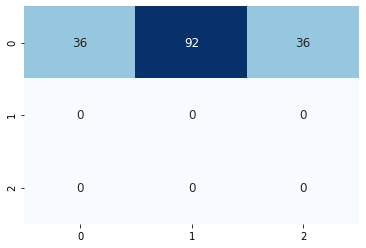

161/161 [==============================] - 0s 231us/sample - loss: 1.6439 - accuracy: 0.1739


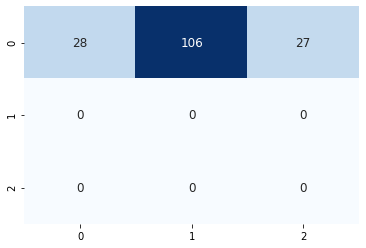

157/157 [==============================] - 0s 231us/sample - loss: 1.4880 - accuracy: 0.2548


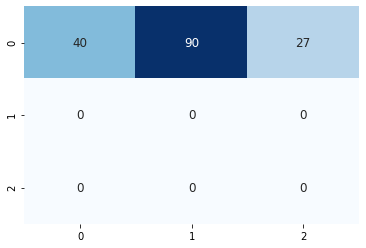

158/158 [==============================] - 0s 244us/sample - loss: 1.4365 - accuracy: 0.3228


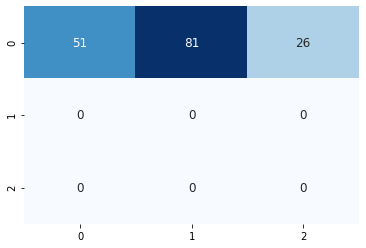

158/158 [==============================] - 0s 256us/sample - loss: 1.5166 - accuracy: 0.2658


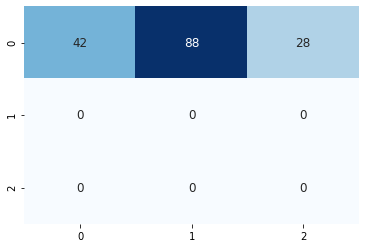

156/156 [==============================] - 0s 263us/sample - loss: 1.4666 - accuracy: 0.3782


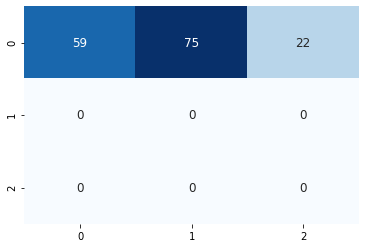

153/153 [==============================] - 0s 291us/sample - loss: 1.3512 - accuracy: 0.3791


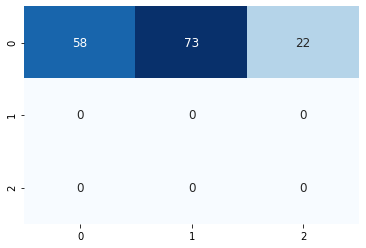

155/155 [==============================] - 0s 233us/sample - loss: 1.4759 - accuracy: 0.3032


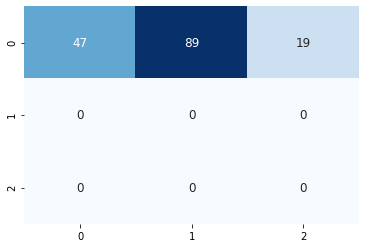

153/153 [==============================] - 0s 246us/sample - loss: 1.3053 - accuracy: 0.3725


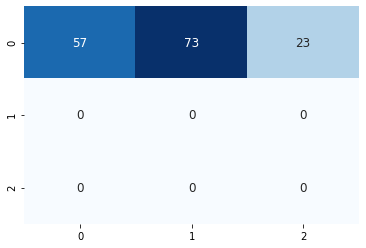

150/150 [==============================] - 0s 262us/sample - loss: 1.3065 - accuracy: 0.4267


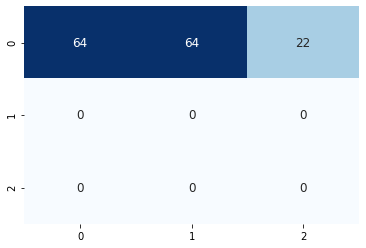

149/149 [==============================] - 0s 251us/sample - loss: 1.3958 - accuracy: 0.3691


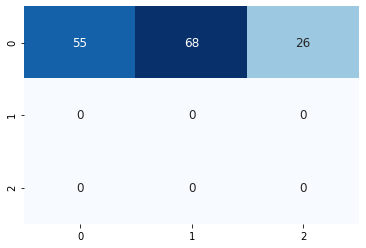

148/148 [==============================] - 0s 258us/sample - loss: 1.3792 - accuracy: 0.3446


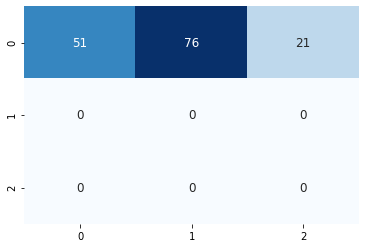

146/146 [==============================] - 0s 281us/sample - loss: 1.3959 - accuracy: 0.3836


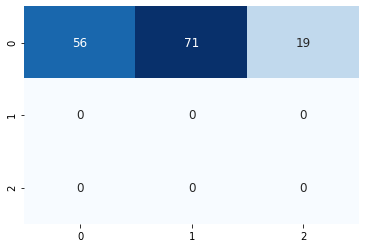

148/148 [==============================] - 0s 264us/sample - loss: 1.3304 - accuracy: 0.3784


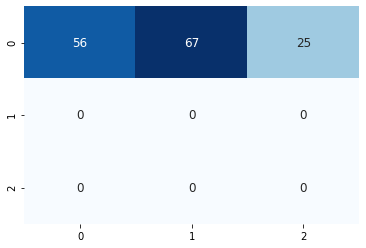

148/148 [==============================] - 0s 239us/sample - loss: 1.3132 - accuracy: 0.3784


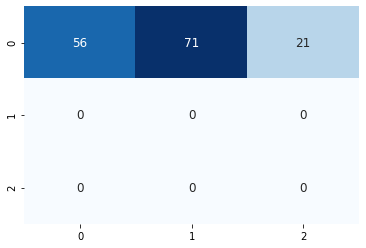

146/146 [==============================] - 0s 266us/sample - loss: 1.4179 - accuracy: 0.3425


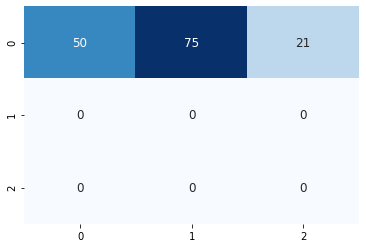

144/144 [==============================] - 0s 260us/sample - loss: 1.2674 - accuracy: 0.3958


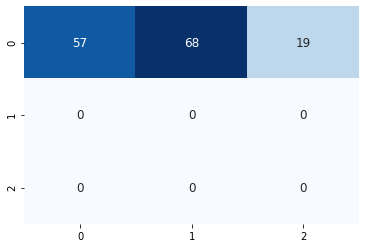

143/143 [==============================] - 0s 252us/sample - loss: 1.2741 - accuracy: 0.4196


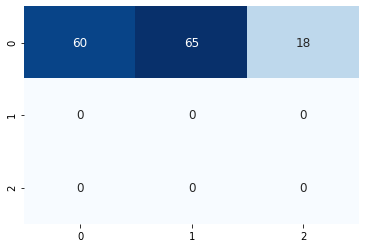

143/143 [==============================] - 0s 281us/sample - loss: 1.1964 - accuracy: 0.4965


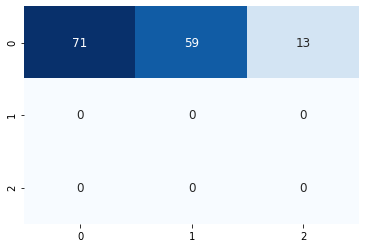

142/142 [==============================] - 0s 293us/sample - loss: 1.2069 - accuracy: 0.4437


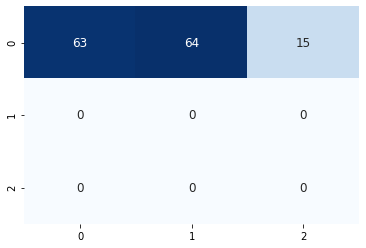

142/142 [==============================] - 0s 272us/sample - loss: 1.2409 - accuracy: 0.4577


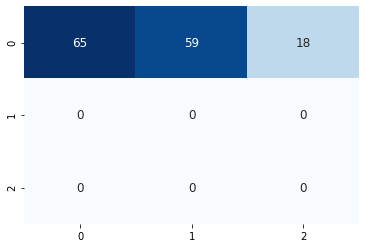

142/142 [==============================] - 0s 295us/sample - loss: 1.2074 - accuracy: 0.4437


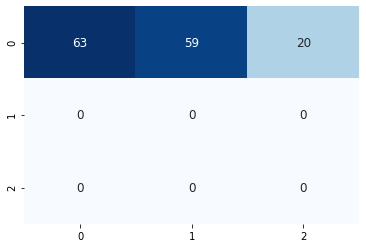

140/140 [==============================] - 0s 241us/sample - loss: 1.1166 - accuracy: 0.4286


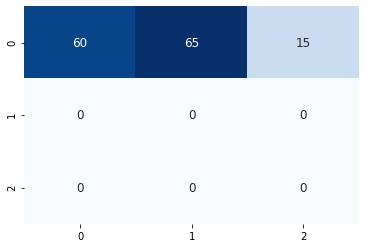

139/139 [==============================] - 0s 250us/sample - loss: 1.1909 - accuracy: 0.4820


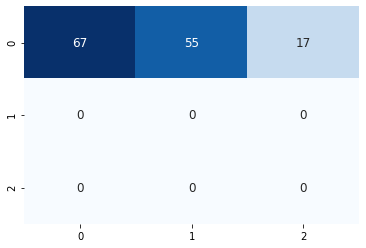

139/139 [==============================] - 0s 273us/sample - loss: 1.1342 - accuracy: 0.5036


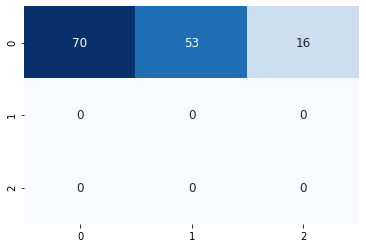

139/139 [==============================] - 0s 261us/sample - loss: 1.1925 - accuracy: 0.4604


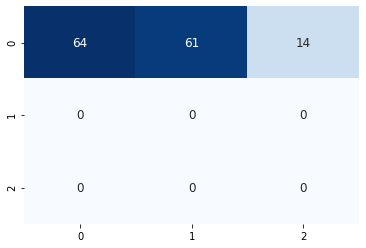

138/138 [==============================] - 0s 273us/sample - loss: 1.1187 - accuracy: 0.5072


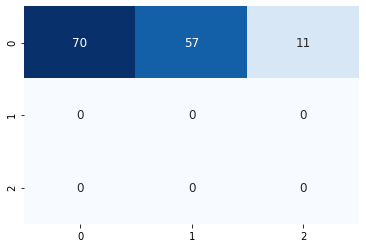

137/137 [==============================] - 0s 271us/sample - loss: 1.1586 - accuracy: 0.4599


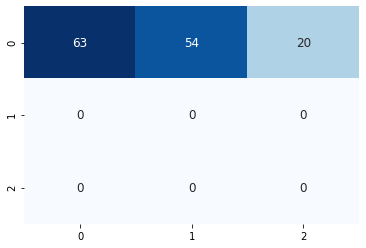

136/136 [==============================] - 0s 275us/sample - loss: 1.1456 - accuracy: 0.4926


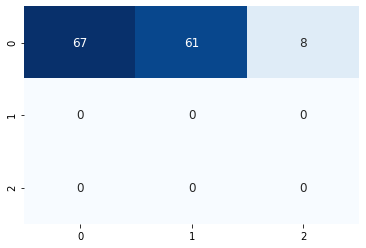

136/136 [==============================] - 0s 288us/sample - loss: 1.1262 - accuracy: 0.4559


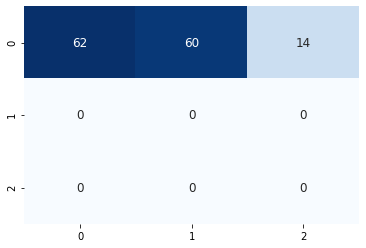

136/136 [==============================] - 0s 284us/sample - loss: 1.1627 - accuracy: 0.4559


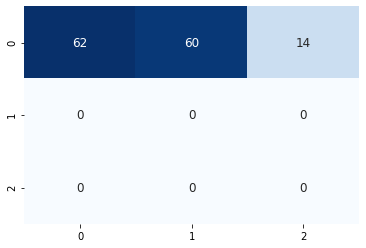

136/136 [==============================] - 0s 292us/sample - loss: 1.1177 - accuracy: 0.4779


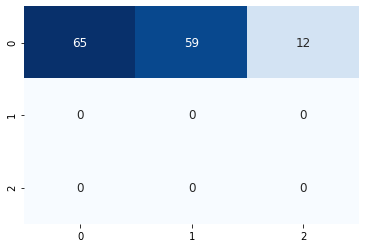

134/134 [==============================] - 0s 277us/sample - loss: 1.2298 - accuracy: 0.4478


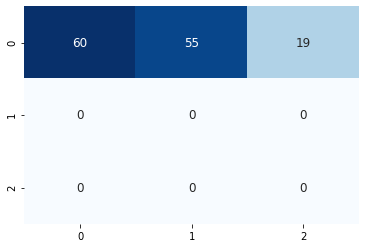

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3874 samples, validate on 982 samples
Epoch 1/300
3874/3874 [==============================] - 3s 754us/sample - loss: 0.9199 - accuracy: 0.5480 - val_loss: 1.1176 - val_accuracy: 0.4287
Epoch 2/300
3874/3874 [==============================] - 1s 217us/sample - loss: 0.6648 - accuracy: 0.6988 - val_loss: 1.2020 - val_accuracy: 0.4460
Epoch 3/300
3874/3874 [==============================] - 1s 198us/sample - loss: 0.5015 - accuracy: 0.7883 - val_loss: 1.3210 - val_accuracy: 0.4664
Epoch 4/300
3874/3874 [==============================] - 1s 196us/sample - loss: 0.3980 - accuracy: 0.8402 - val_loss: 1.4485 - val_accuracy: 0.4705
Epoch 00004: early stopping
133/133 [==============================] - 0s 3ms/sample - loss: 0.8614 - accuracy: 0.5714


11it [4:19:21, 1427.41s/it]
100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


Train_images_done
Val_images_done
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 73 steps
Epoch 1/300
283/283 [==============================] - 29s 104ms/step - loss: 1.4143 - accuracy: 0.4371 - val_loss: 1.1851 - val_accuracy: 0.4376
Epoch 2/300
283/283 [==============================] - 28s 98ms/step - loss: 1.0427 - accuracy: 0.4898 - val_loss: 1.1918 - val_accuracy: 0.3445
Epoch 3/300
283/283 [==============================] - 28s 98ms/step - loss: 0.9941 - accuracy: 0.5090 - val_loss: 1.3285 - val_accuracy: 0.3808
Epoch 4/300
283/283 [==============================] - 28s 99ms/step - loss: 0.9736 - accuracy: 0.5220 - val_loss: 1.3151 - val_accuracy: 0.3602
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 283 steps, validate for 73 steps
Epoch 1/300
283/283 [==============================] - 71s 250ms/step - loss: 0.9005 - accuracy: 0.5686 - val_loss: 1.3783 - val_accuracy: 0.3118
Epoch 2/300
283/283 [====

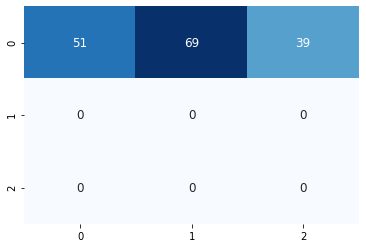

147/147 [==============================] - 0s 236us/sample - loss: 1.9640 - accuracy: 0.2789


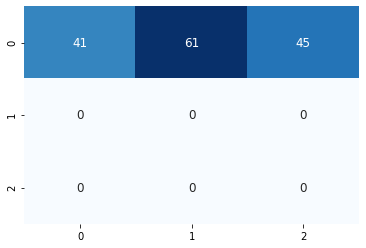

144/144 [==============================] - 0s 251us/sample - loss: 1.8906 - accuracy: 0.2778


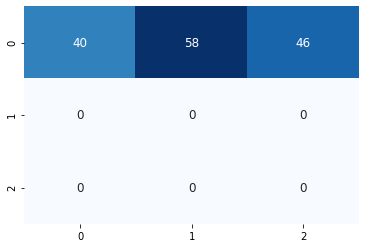

141/141 [==============================] - 0s 233us/sample - loss: 1.7432 - accuracy: 0.3546


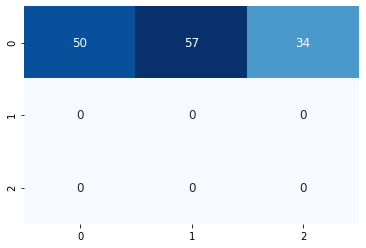

140/140 [==============================] - 0s 245us/sample - loss: 1.8749 - accuracy: 0.2929


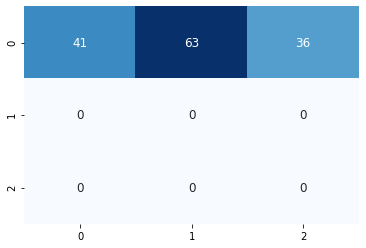

140/140 [==============================] - 0s 271us/sample - loss: 1.8495 - accuracy: 0.2571


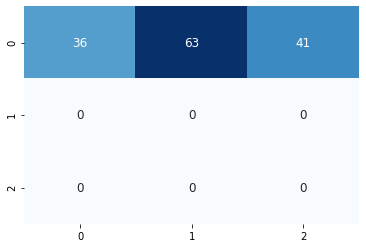

138/138 [==============================] - 0s 267us/sample - loss: 1.9068 - accuracy: 0.2899


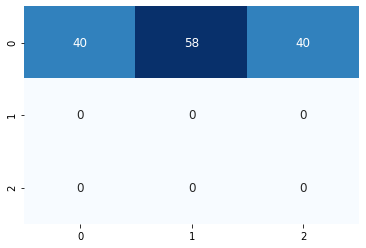

134/134 [==============================] - 0s 283us/sample - loss: 2.1729 - accuracy: 0.2463


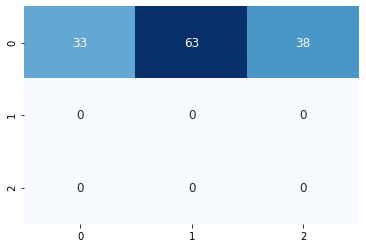

135/135 [==============================] - 0s 234us/sample - loss: 1.8696 - accuracy: 0.2815


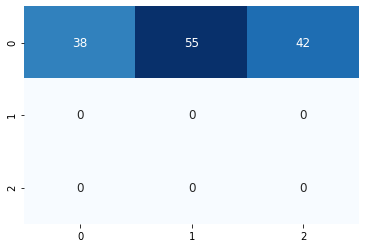

135/135 [==============================] - 0s 264us/sample - loss: 2.0386 - accuracy: 0.2000


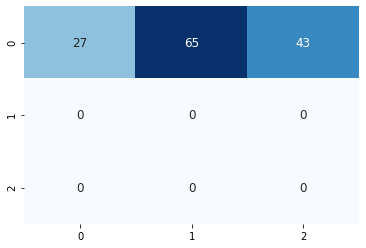

134/134 [==============================] - 0s 315us/sample - loss: 2.0941 - accuracy: 0.2687


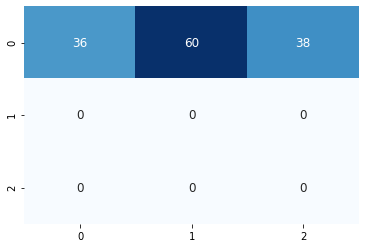

134/134 [==============================] - 0s 258us/sample - loss: 1.9204 - accuracy: 0.2463


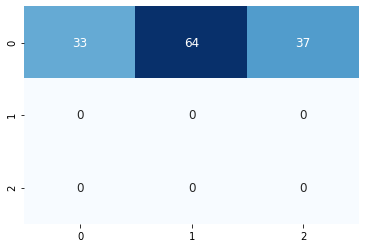

135/135 [==============================] - 0s 281us/sample - loss: 2.0249 - accuracy: 0.2519


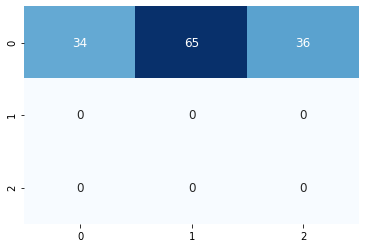

132/132 [==============================] - 0s 274us/sample - loss: 1.9632 - accuracy: 0.3106


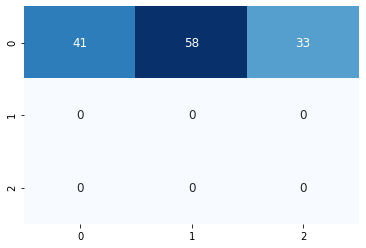

132/132 [==============================] - 0s 240us/sample - loss: 1.9025 - accuracy: 0.2955


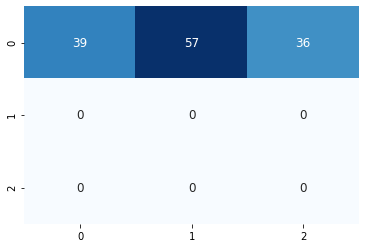

131/131 [==============================] - 0s 308us/sample - loss: 1.8375 - accuracy: 0.3359


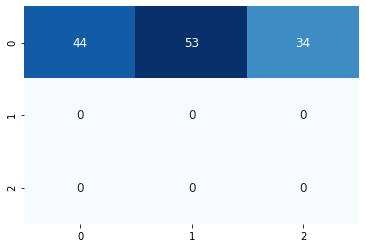

130/130 [==============================] - 0s 239us/sample - loss: 1.8467 - accuracy: 0.2538


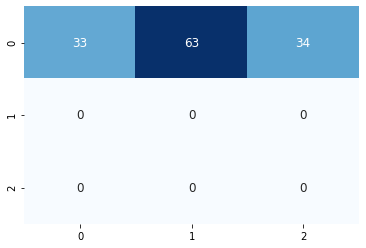

130/130 [==============================] - 0s 246us/sample - loss: 1.7840 - accuracy: 0.3077


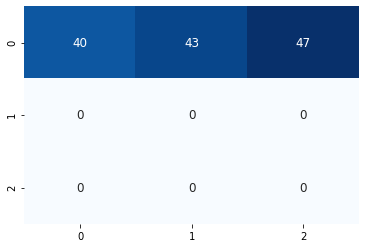

129/129 [==============================] - 0s 287us/sample - loss: 1.8551 - accuracy: 0.2868


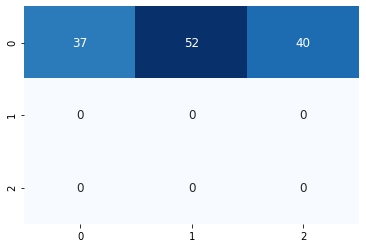

127/127 [==============================] - 0s 267us/sample - loss: 1.9415 - accuracy: 0.2362


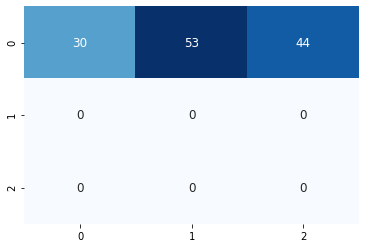

127/127 [==============================] - 0s 292us/sample - loss: 1.8043 - accuracy: 0.3622


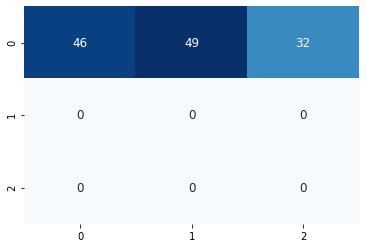

128/128 [==============================] - 0s 2ms/sample - loss: 2.0265 - accuracy: 0.3047


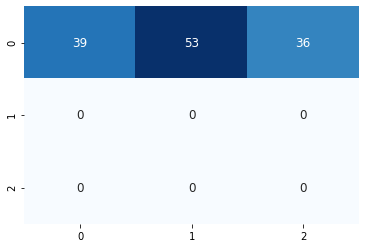

127/127 [==============================] - 0s 259us/sample - loss: 2.0243 - accuracy: 0.3228


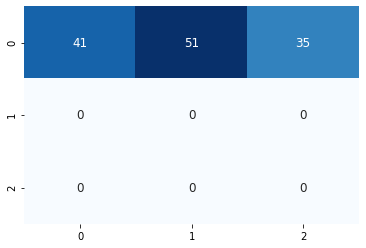

127/127 [==============================] - 0s 244us/sample - loss: 1.9456 - accuracy: 0.2913


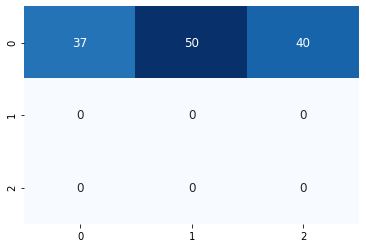

126/126 [==============================] - 0s 254us/sample - loss: 1.8516 - accuracy: 0.3413


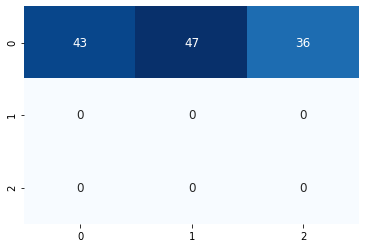

126/126 [==============================] - 0s 238us/sample - loss: 1.8925 - accuracy: 0.3651


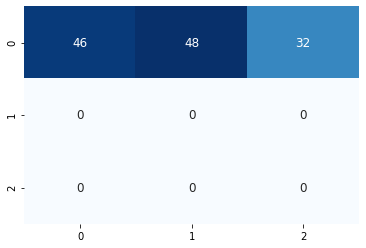

122/122 [==============================] - 0s 234us/sample - loss: 2.1552 - accuracy: 0.2869


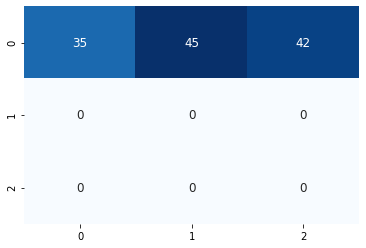

122/122 [==============================] - 0s 250us/sample - loss: 2.0398 - accuracy: 0.2951


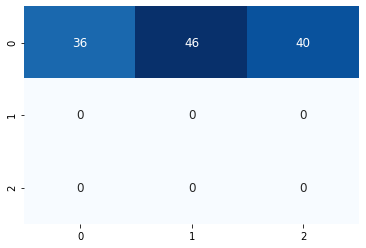

123/123 [==============================] - 0s 260us/sample - loss: 1.9421 - accuracy: 0.2764


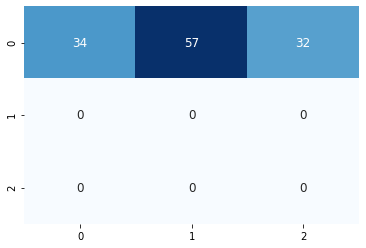

122/122 [==============================] - 0s 239us/sample - loss: 2.0750 - accuracy: 0.3443


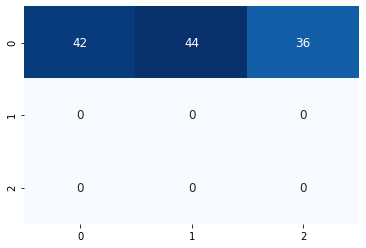

122/122 [==============================] - 0s 249us/sample - loss: 2.0209 - accuracy: 0.3525


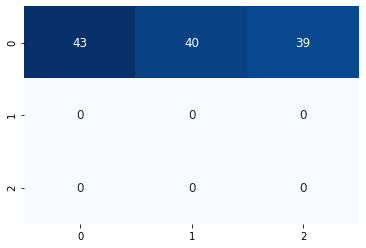

122/122 [==============================] - 0s 248us/sample - loss: 2.0156 - accuracy: 0.3607


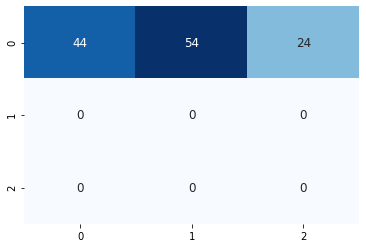

121/121 [==============================] - 0s 259us/sample - loss: 1.8058 - accuracy: 0.3719


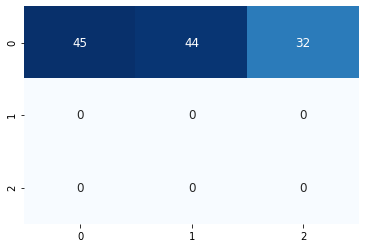

Saved_feature_train
Saved_feature_test
Saved_feature_validation
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3869 samples, validate on 1001 samples
Epoch 1/300
3869/3869 [==============================] - 3s 695us/sample - loss: 0.8482 - accuracy: 0.5629 - val_loss: 1.1030 - val_accuracy: 0.4046
Epoch 2/300
3869/3869 [==============================] - 1s 199us/sample - loss: 0.5859 - accuracy: 0.7116 - val_loss: 1.1977 - val_accuracy: 0.4545
Epoch 3/300
3869/3869 [==============================] - 1s 220us/sample - loss: 0.4430 - accuracy: 0.7795 - val_loss: 1.3269 - val_accuracy: 0.4685
Epoch 4/300
3869/3869 [==============================] - 1s 220us/sample - loss: 0.3512 - accuracy: 0.8346 - val_loss: 1.4742 - val_accuracy: 0.4975
Epoch 00004: early stopping
119/119 [==============================] - 0s 3ms/sample - loss: 2.1862 - accuracy: 0.2185


12it [4:43:01, 1415.10s/it]


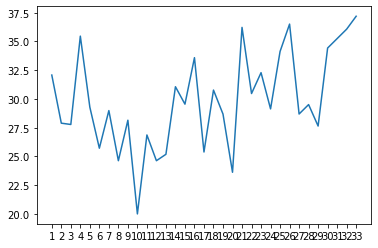

In [22]:
for num_ix, rand_num in enumerate(rand):
    for index_t_well, _ in tqdm.tqdm(enumerate(tot_well)):

        time_points = list(map(str, range(1,34)))

        new_time = []
        for i in time_points:
            r = '_' + i + '.'
            new_time.append(r)



        path_test = '/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/{}_cropped/'.format(a)

        # NAME OF THE WELLS CORRESPONDING TO THE DRUG THAT YOU WANT IN THE TEST SET 

        wells_drug = [tot_well[index_t_well][0]] 

        test = []

        for _,_, filenames in os.walk(path_test):

            for filename in sorted(filenames, key = natural_keys):

                for w in wells_drug:
                    for t in new_time:
                        if '{}'.format(w) in filename and '{}tiff'.format(t) in filename:
                            test.append(filename)

        groups_list = ['{}'.format(a), '{}'.format(b), '{}'.format(c)]

        fileds_of_view = ['1','2','3','4','5']

        field_train, field_val = train_test_split(fileds_of_view, test_size=0.2, random_state=rand_num)


        train = []

        validation = []

        group_compounds = []

        for group in tqdm.tqdm(groups_list):

            pa = '/home/jovyan/DATA_MASTER_PROJECT/IMG_A549_high_con/{}_cropped/'.format(group)

            for _,_, filenames in os.walk(pa):

                for filename in sorted(filenames, key = natural_keys):

                    for t in new_time:

                        if '_{}-'.format(wells_drug[0]) not in filename  and '{}tiff'.format(t) in filename:

                            group_compounds.append(filename)






        for i in group_compounds:

            for f in field_train:
                if '-{}_'.format(f) in i:
                    train.append(i)


            for v in field_val:
                if '-{}_'.format(v) in i:
                    validation.append(i)


        x_train = loadImages(train)
        y_train = make_labels(train)
        
        print('Train_images_done')



        x_val = loadImages(validation)
        y_val = make_labels(validation)
        
        print('Val_images_done')


        x_train = resize(x_train)


        x_val = resize(x_val)


        weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
        
        weights = dict(enumerate(weights))


        x_train = preprocess_input(x_train)

        x_val = preprocess_input(x_val)
        
        y_train = keras.utils.to_categorical(y_train, num_classes = 3)
        
        y_val = keras.utils.to_categorical(y_val, num_classes = 3)


        es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

        pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

        base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

        batch_size = 512

        datagen = ImageDataGenerator()

        datagen.fit(x_train)

        train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

        dat_val = ImageDataGenerator()

        dat_val.fit(x_val)

        val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

        m4 = Sequential()
        m4.add(base_model)


        m4.add(BatchNormalization())
        m4.add(GlobalAveragePooling2D())
        m4.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        m4.add(BatchNormalization())
        m4.add(Activation('relu'))
        m4.add(Dense(3,activation='softmax'))


        base_model.trainable = False

        opt = keras.optimizers.Adam(lr=1e-3)

        m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])



        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)//batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = (val_gen), 
                        validation_steps = (len(x_val)//batch_size),
                        class_weight = weights,
                         verbose = 1)

        base_model.trainable = True

        opt = keras.optimizers.Adam(lr=1e-4)

        m4.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)//batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = val_gen, 
                        validation_steps = (len(x_val)//batch_size),
                        class_weight = weights,
                        verbose = 1)

        l = []
        for t in new_time:
            for i in test:
                if t in i:
                    l.append((i))


        grouped = {}
        for elem in l:
            key = elem.split('.tiff')[0].split('_')[5]
            grouped.setdefault(key, []).append(elem)
        grouped = grouped.values()

        test_data = list(grouped)

        r = []

        for ix ,_ in enumerate(test_data):
            r.append(time_step_acc(test_data[ix],m4))

        plt.plot(time_points,r)
        plt.savefig('/home/jovyan/IMG_CNN_FINAL/{}_accuracy.png'.format(string_well[index_t_well]))

        tot_results_accuracy.append(r)
        
        for i, layer in enumerate(m4.layers):
            layer._name = 'layer_' + str(i)



        lstm_model = Model(inputs=m4.input, outputs=m4.get_layer('layer_4').output)

        del m4
        K.clear_session()
        
        data_name = [train,test,validation]

        feat_name = ['train', 'test', 'validation']

        for index_name, _ in enumerate(data_name):

            path =  data_name[index_name]

            name_well = []

            for i in path:
                name_well.append(i.split('_id')[0])

            wells = list(set(name_well))
            wells

            for w in wells:

                time = []


                for filename in sorted(path, key = natural_keys):
                    if w in filename: #PAY ATTENTION ID THE IMAGE IS A TIFF OR PNG IMAGE #########
                        time.append(filename)

                data_id = {}
                n_id = []
                w_n = []

                for i in time:
                    t = i.split('_id_')[1].split('time_')[0]
                    f = i.split('_id_')[0].split('time_')[0]
                    n_id.append(t)
                    w_n.append(f)

                id_cell = set(n_id)


                for ix, i in enumerate(sorted(id_cell, key = natural_keys)):

                    id_name = []
                    dict_1 = {}

                    for t in time:
                        if 'id_{}'.format(i) in t:
                            id_name.append(t)

                    d = {'id':id_name}
                    data = pd.DataFrame(d)

                    dict_1[ix]=data 
                    data_id.update(dict_1) 

                delete = [i for i, j in data_id.items() if len(j) < len(time_points)] # 9 or the length of time span you are traning on 
                for i in delete : del data_id[i]

                len_id = [i for i, j in data_id.items()]

                for le in len_id:    


                    e = pd.DataFrame(data_id[le])

                    coords = e.values.tolist()
                    id_cells = []
                    for i in coords:
                        for j in i:
                            id_cells.append(j)

                    x_orig = loadImages(id_cells)
                    x_orig = resize(x_orig)

                    x_orig = preprocess_input(x_orig)
                    output = lstm_model.predict(x_orig)
                    np.save('/home/jovyan/DATA_MASTER_PROJECT/LSTM//FEAT_FOLDERS/features_{}/features_well_{}_id_{}.npy'.format(feat_name[index_name],w_n[0], le), output)
            print('Saved_feature_{}'.format(feat_name[index_name]))


        x_train_lstm = loadImages_LSTM(train_data, len(time_points))
        y_train_lstm = make_labels_LSTM(y_tra_path)

        x_test_lstm = loadImages_LSTM(tes_data, len(time_points))
        y_test_lstm = make_labels_LSTM(y_tes_path)

        x_val_lstm = loadImages_LSTM(val_data, len(time_points))
        y_val_lstm = make_labels_LSTM(y_val_path)

        weights_lstm = class_weight.compute_class_weight('balanced', np.unique(y_train_lstm),y_train_lstm)
        
        weights_lstm = dict(enumerate(weights_lstm))
        
        y_train_lstm = keras.utils.to_categorical(y_train_lstm, num_classes = 3)
        y_test_1_lstm = keras.utils.to_categorical(y_test_lstm, num_classes= 3)
        y_val_lstm = keras.utils.to_categorical(y_val_lstm, num_classes = 3)


        m = Sequential()
        m.add(LSTM(32, input_shape = (x_train_lstm.shape[1],x_train_lstm.shape[2])))
        m.add(Dropout(0.2))
        m.add(Dense(3, activation='softmax'))


        opt_lstm = keras.optimizers.Adam(lr=1e-4)

        m.compile(loss= keras.losses.categorical_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m_h = m.fit(x_train_lstm,y_train_lstm,

                         callbacks = [es],

                        epochs=epochs,
                        validation_data = (x_val_lstm,y_val_lstm), 

                        class_weight = weights_lstm)


        scores_lstm = m.evaluate(x_test_lstm, y_test_1_lstm)
        results_lstm.append([scores_lstm[1]*100, string_well[index_t_well]])
        
        del m
        K.clear_session()

        # DELITE FILES IN FEATURE VECTOR FOLDERS

        folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

        for fo in folders:
            file = glob.glob(f'{fo}/*')
            for f in file:
                os.remove(f)

In [23]:
#### ACCURACY SCORE AVERAGE FOR CNN
cv_s = cv_mean_acc(tot_results_accuracy, string_well)
cv_s

[(33.634690157692845, 'met'),
 (35.02835568153497, 'mid'),
 (20.05026965129255, 'oxy'),
 (58.72462370780983, 'nap'),
 (28.4070140183574, 'dip'),
 (56.86702427237925, 'met_1'),
 (43.26897892687055, 'lab'),
 (39.27986898807564, 'car'),
 (24.144769241713515, 'mep'),
 (41.825338310063486, 'nef'),
 (45.008737511105004, 'tri'),
 (53.41981994082229, 'dox')]

In [24]:
cv_s_mean,_ = zip(*cv_s)

m_cv = np.mean(list(cv_s_mean))
m_cv    

39.971624200643106

In [25]:
# PLOT OF MEAN ACCURACY FOR EVERY TIME POINT CNN

l_drug = string_well*3

acc_plot = []

for i in tot_results_accuracy:
    acc_plot.append(i)

cv_plot = list(zip(acc_plot, l_drug))

res_plot = sorted(cv_plot, key = lambda x: x[1])

a , b = zip(*res_plot)
    
a = list(a)

s = list(np.array_split(a, len(string_well)))

cv_plot = []

for ix, i in enumerate(s):
    s1 = list(s[ix])
    
    cv_plot.append(np.average(s1, axis=0))

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in cv_plot:
    
    plt.plot(time_points, i)
    plt.show
    plt.savefig('/home/jovyan/cv_score.png')

In [ ]:
results_lstm = sorted(results_lstm, key=lambda x: x[1])
r_lstm , _ = zip(*results_lstm)
    
r_lstm = list(r_lstm)

re_lstm = list(np.array_split(r_lstm, len(string_well)))

cv_lstm = []

for ix, i in enumerate(re_lstm):
    r1 = list(re_lstm[ix])
    cv_lstm.append(np.mean(r1))


In [ ]:
cv_lstm = list(zip(cv_lstm, string_well))
cv_lstm

In [ ]:
cv_l_mean,_ = zip(*cv_lstm)

m_cv_l = np.mean(list(cv_l_mean))
m_cv_l 

In [ ]:
# BEFORE RUNNING AGAIN

folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

for fo in folders:
    file = glob.glob(f'{fo}/*')
    for f in file:
        os.remove(f)

In [ ]:
cv_l_mean,_ = zip(*cv_lstm)

m_cv_l = np.mean(list(cv_l_mean))
m_cv_l 

In [ ]:
sd_cv_l =  np.std(list(cv_l_mean))
sd_cv_l

In [ ]:
me = np.mean(cv_plot, axis = 0)
me = me.flatten()

In [ ]:
sd = np.std(cv_plot, axis = 0)
sd = sd.flatten()

In [ ]:
plt.rc('ytick', labelsize=18)
ax = plt.figure(figsize=(13,8), facecolor='w').gca()
ax.plot(me)
ax.fill_between(time_points, me - sd, me + sd, alpha = 0.5)

plt.errorbar(31.5, m_cv_l, sd_cv_l, linestyle='None', marker='^', markersize=12)

plt.savefig('/home/jovyan/md_sd_score.png')

In [ ]:
cnn_stat = [i for i in cv_s_mean]
lstm_stat = [i for i in cv_l_mean]

from scipy.stats import wilcoxon

stat, p = wilcoxon(cnn_stat, lstm_stat)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')